# Inicialização dos Recursos Necessários

## Bibliotecas

In [335]:
from typing import Set
from dataclasses import asdict
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from dateutil.parser import isoparse
from label import Label
from ast import literal_eval
from scipy import stats
import numpy
import pingouin

## Mann-Whitney Tests

In [336]:
def run_mw_test(service_time, non_service_time, attribute, alpha=0.05, label="service_time"):
    result = {}
    result["test"] = "Mann-Whitney"
    result["h0"] = str(label + "_" + attribute + " == NON_"+ label + "_" + attribute)
    result["h1"] = str(label + "_" + attribute + " > NON_"+ label + "_" + attribute)
    result["h2"] = str(label + "_" + attribute + " < NON_"+ label + "_" + attribute)
    
    mwu, p_value = stats.mannwhitneyu(service_time[attribute], non_service_time[attribute], alternative='two-sided')
    result["accepted"] = "h0"
    result["h0stats"] = mwu
    result["h0p-value"] = p_value
    if p_value > alpha:
        result["accepted"] = "h0"
    else :
        mwu, p_value = stats.mannwhitneyu(service_time[attribute], non_service_time[attribute], alternative='greater')        
        if p_value <= alpha:
            result["accepted"] = "h1"
        else :
            mwu, p_value = stats.mannwhitneyu(service_time[attribute], non_service_time[attribute], alternative='less')
            if p_value <= alpha:
                result["accepted"] = "h2"
                
    result["stats"] = mwu
    result["p-value"] = p_value
    result["effec-size"] = numpy.abs(pingouin.compute_effsize(service_time[attribute], non_service_time[attribute], eftype='cohen'))
    
    return result

    
def print_test_result(result):
    if result["accepted"] != "h0":
        print("{} test result: the H0 was rejected with statistic {} and p-value {}. Then the alternative hypothesis {} was acepted with statistic {} and p-value {}, with Cohen’s d effect size = {} [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].".format(
            result["test"],            
            result["h0stats"], 
            result["h0p-value"],            
            result[result["accepted"]], 
            result["stats"], 
            result["p-value"],
            result["effec-size"]))
    else:
        print("{} test result: the hypothesis {} is acepted with statistic {} and p-value {}, with Cohen’s d effect size = {} [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].".format(result["test"], result[result["accepted"]], result["stats"], result["p-value"], result["effec-size"]))

## Dataset Filtering

In [337]:
def remove_duplicate_ids(dataset):
    return dataset.drop_duplicates("id")

def apply_isoparse(dataset, attribute):
    dataset[attribute] = dataset[attribute].apply(isoparse)

def calculate_completion_time(dataset):
    dataset["time_to_complete"] = (dataset["closed_at"] - dataset["created_at"])
    dataset["time_to_complete"] = dataset["time_to_complete"].apply(timedelta.total_seconds)

In [338]:
def load_label_str(label_str: str) -> Label:
    eval_result = literal_eval(label_str)
    return Label(**eval_result)

# Construção do Dataset

## Carregando os dados

In [339]:
df_issues = pd.read_csv("issues.csv")

In [340]:
df_issues.shape

(8673, 30)

In [341]:
df_issues.columns

Index(['Unnamed: 0', 'url', 'repository_url', 'labels_url', 'comments_url',
       'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user',
       'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone',
       'comments', 'created_at', 'updated_at', 'closed_at',
       'author_association', 'active_lock_reason', 'body', 'reactions',
       'timeline_url', 'performed_via_github_app', 'state_reason', 'score'],
      dtype='object')

In [342]:
df_issues = remove_duplicate_ids(df_issues)
apply_isoparse(df_issues, "created_at")
apply_isoparse(df_issues, "closed_at")
calculate_completion_time(df_issues)

In [343]:
def to_color_name(colorID):
    return "#"+colorID.upper()

## Construção das Tags

In [344]:
TAGS: Set[Label] = set()
for value in df_issues["labels"].values:
    labels = literal_eval(value)
    for elem in labels:
        TAGS.add(Label(**elem))
df_tags = pd.DataFrame.from_records([asdict(tag) for tag in TAGS])
df_tags

,id,node_id,url,name,color,default,description
0,854951979,MDU6TGFiZWw4NTQ5NTE5Nzk=,https://api.github.com/repos/TeamNewPipe/NewPi...,good first issue,5319e7,True,Easy/simple issues perfect for newcomers to ge...
1,3184808663,MDU6TGFiZWwzMTg0ODA4NjYz,https://api.github.com/repos/TeamNewPipe/NewPi...,CI,2551F0,False,Issue is related to the CI
2,1584886757,MDU6TGFiZWwxNTg0ODg2NzU3,https://api.github.com/repos/TeamNewPipe/NewPi...,device/software specific,d93f0b,False,Issues that only happen on some devices or wit...
3,686924681,MDU6TGFiZWw2ODY5MjQ2ODE=,https://api.github.com/repos/TeamNewPipe/NewPi...,ASAP,b60205,False,Issue needs to be fixed as soon as possible
4,1460981435,MDU6TGFiZWwxNDYwOTgxNDM1,https://api.github.com/repos/TeamNewPipe/NewPi...,multiservice,fbca04,False,Issues related to multiple services
5,3290643387,MDU6TGFiZWwzMjkwNjQzMzg3,https://api.github.com/repos/TeamNewPipe/NewPi...,waiting for author,E99695,False,"If the author doesn't respond, the issue will ..."
6,2522947874,MDU6TGFiZWwyNTIyOTQ3ODc0,https://api.github.com/repos/TeamNewPipe/NewPi...,tablet UI,d6690a,False,Issue is related to Tablet UIs
7,839504095,MDU6TGFiZWw4Mzk1MDQwOTU=,https://api.github.com/repos/TeamNewPipe/NewPi...,requires extractor change,d4c5f9,False,This issue requires a change to the extractor
8,629136347,MDU6TGFiZWw2MjkxMzYzNDc=,https://api.github.com/repos/TeamNewPipe/NewPi...,discussion,bfd4f2,False,This needs to be discussed before anything is ...
9,2445576690,MDU6TGFiZWwyNDQ1NTc2Njkw,https://api.github.com/repos/TeamNewPipe/NewPi...,player notification,adffb9,False,Anything to do with the MediaStyle notification


In [345]:
print([tag.name for tag in TAGS])

['good first issue', 'CI', 'device/software specific', 'ASAP', 'multiservice', 'waiting for author', 'tablet UI', 'requires extractor change', 'discussion', 'player notification', 'player', 'bandcamp', 'channel', 'question', 'feed', 'template ignored', 'peertube', 'niche', 'privacy & data protection', 'downloader', 'codequality', 'bug', 'meta', 'needs triage', 'template missing', 'accessibility', 'localisation / translation', 'user blocked us', 'GUI', 'playlist', 'queue', 'feature request', 'bounty', 'soundcloud', 'database', 'Android TV', 'youtube', 'help wanted', 'wontfix', 'media.ccc.de', 'duplicate']


In [346]:
tag_colors = list(map(to_color_name, df_tags.color))

## Remoção de Issues Inúteis

In [347]:
misleading_tags = ['waiting for author', 'template ignored', 'needs triage', 'template missing', 'user blocked us', 'wontfix', 'duplicate']

In [348]:
def remove_misleading_tags(dataset):
    return dataset.loc[~dataset["labels"].isin(misleading_tags)]

In [369]:
df_issues = remove_misleading_tags(df_issues)

## Filtro dos dados com base nas Tags

<AxesSubplot: >

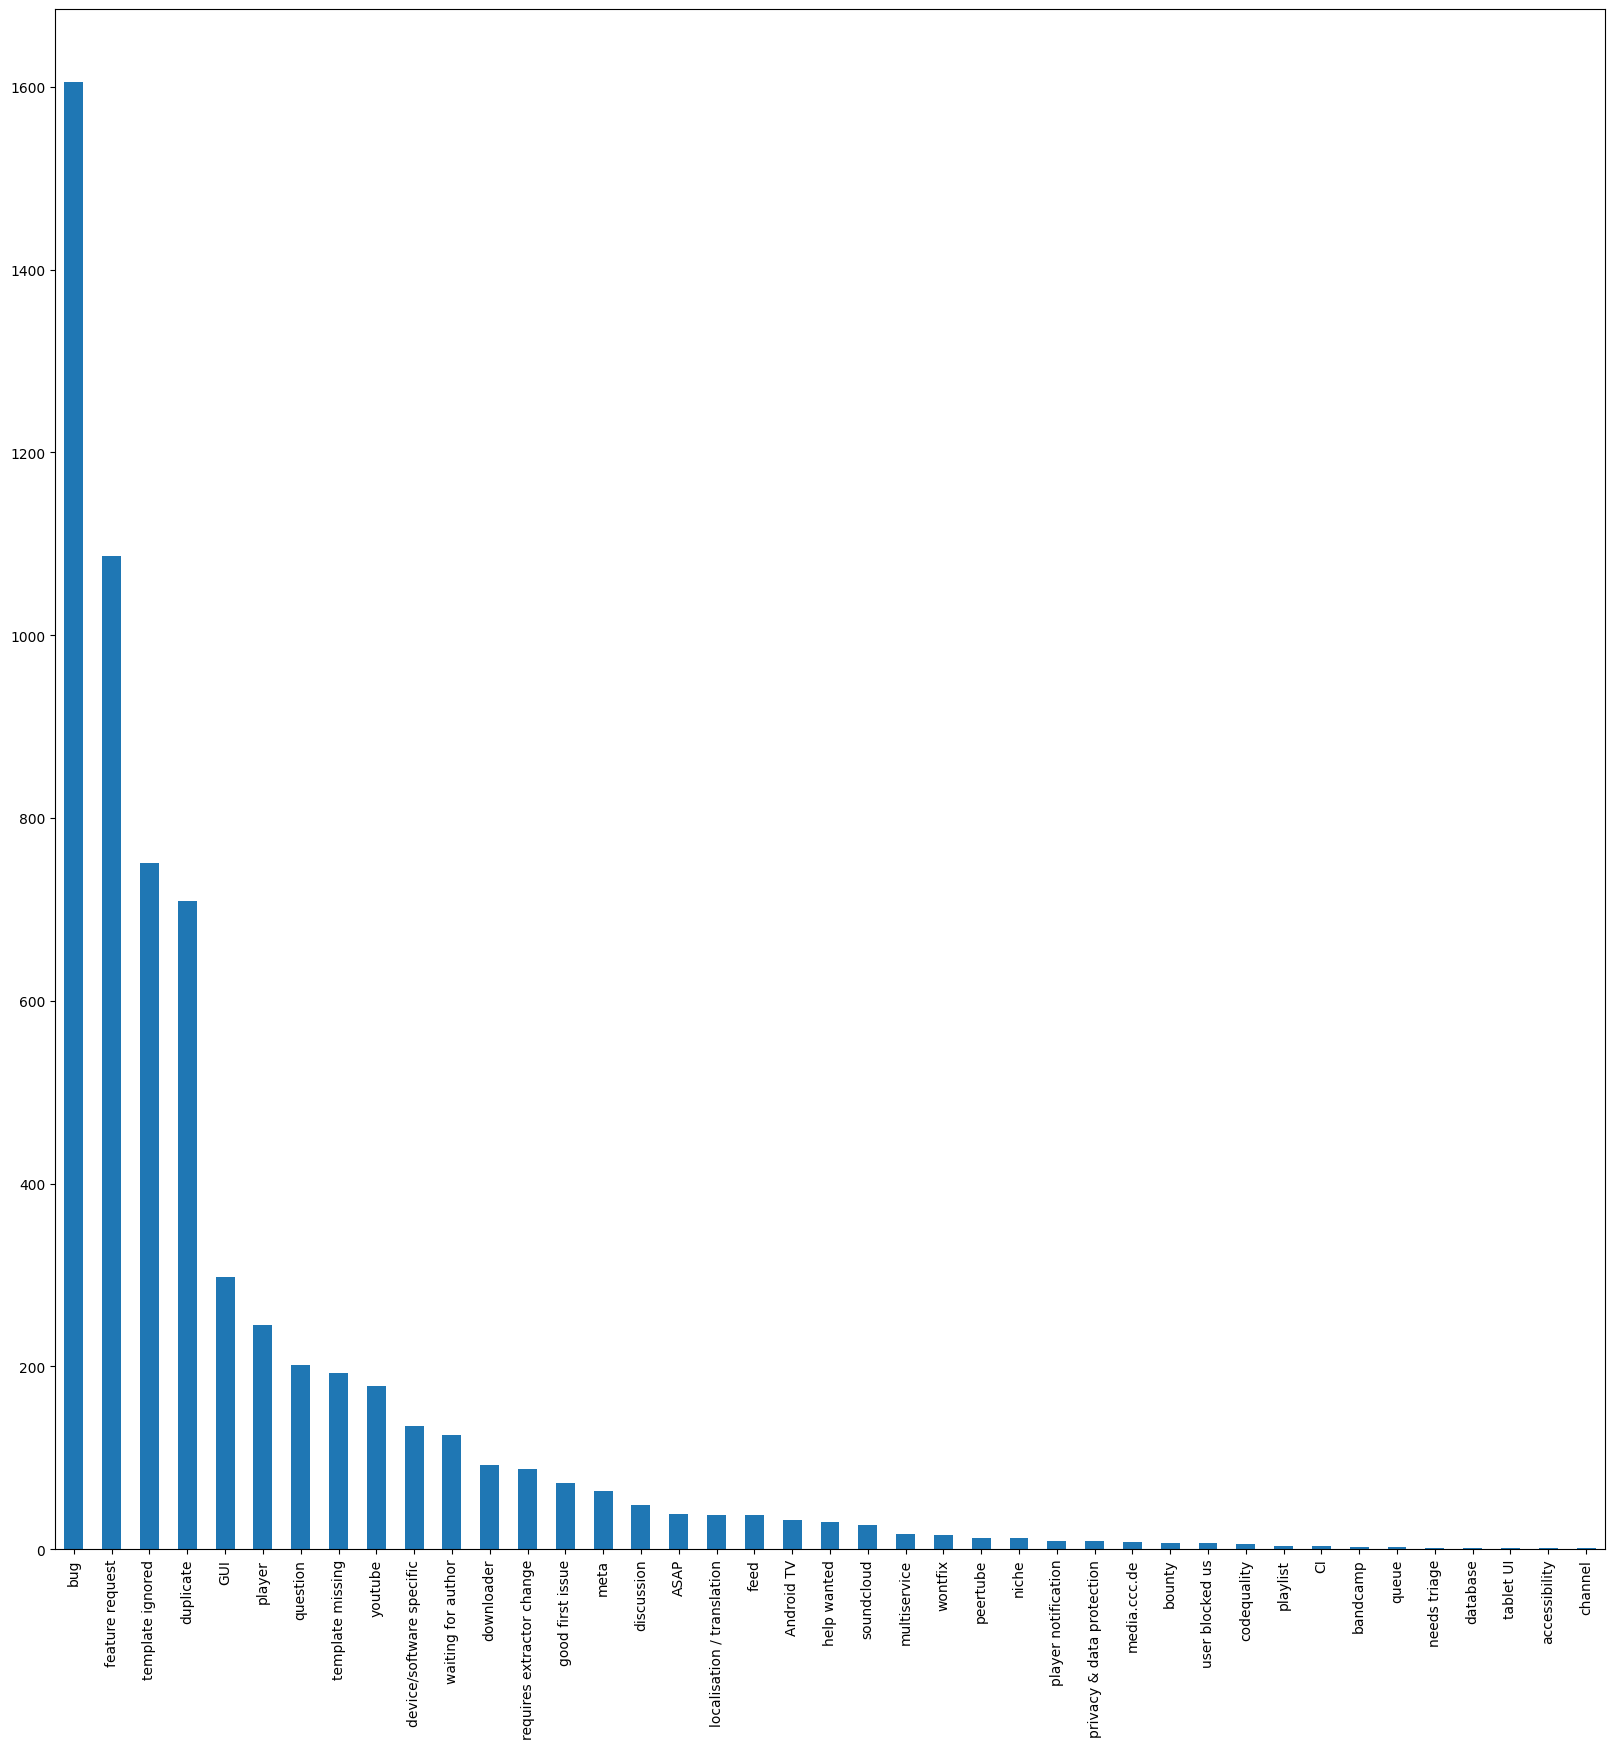

In [370]:
parsed_labels = [literal_eval(label_list) for idx, label_list in df_issues["labels"].items()] #parse labels
flattened_labels = [Label(**item) for item in itertools.chain.from_iterable(parsed_labels)] # flatten and convert to Label
labels_count = pd.Series(item.name for item in flattened_labels).value_counts()
labels_count.plot(kind="bar",)

In [386]:
df_label_means = pd.DataFrame()

for tag in TAGS:
    mean = df_issues.loc[df_issues["labels"].str.contains(tag.node_id)]["time_to_complete"].mean()
    std = df_issues.loc[df_issues["labels"].str.contains(tag.node_id)]["time_to_complete"].std()
    min = df_issues.loc[df_issues["labels"].str.contains(tag.node_id)]["time_to_complete"].min()
    max = df_issues.loc[df_issues["labels"].str.contains(tag.node_id)]["time_to_complete"].max()
    df_label_means = pd.concat([df_label_means, pd.DataFrame.from_records([{"label": tag.name, "time_to_complete_avg": mean, "time_to_complete_std": std, "time_to_complete_min": min, "time_to_complete_max": max}])], ignore_index=True)

In [393]:
def remove_outliers(dataset, attribute, factor):
    if factor == 0:
        return dataset
    copy = dataset.copy()
    return copy[numpy.abs(copy[attribute] - copy[attribute].mean()) <= (factor * copy[attribute].std())]

In [401]:
list_df_issues_no_outliers = remove_outliers(df_issues, "time_to_complete", 1)
# for tag in TAGS:
    # mean, std = df_label_means.loc[df_label_means["label"] == tag.name]
    # print(mean)
    # print(std)
list_df_issues_no_outliers.shape

(4902, 31)

# Explorações do Dataset

## RQ 01) Existe alguma diferença entre o tempo de resolução de issues entre os serviços suportados pelo NewPipe?

In [402]:
def filter_by_tags(dataset, attribute, tags):
    return dataset[dataset[attribute].isin(tags)]

def fetch_comparison_data(dataset, tag, exclude):
    if (exclude):
        return dataset.loc[~dataset["labels"].str.contains(tag)]
    else:
        return dataset.loc[dataset["labels"].str.contains(tag)]

def plot_data_bar(title, labels, dataset, color, width = .15):
    fig, ax = plt.subplots()
    ax.ticklabel_format(style="plain")
    x = numpy.arange(len(labels))

    rectsMin = ax.bar(x - width*3/2, dataset.time_to_complete_min, width, label='Min')
    rectsMax = ax.bar(x - width/2, dataset.time_to_complete_max, width, label='Max')
    rectsAvg = ax.bar(x + width/2, dataset.time_to_complete_avg, width, label='Average')
    rectsStd = ax.bar(x + width*3/2, dataset.time_to_complete_std, width, label='Standard Deviation')
    
    ax.set_ylabel("Time (in seconds)")
    ax.set_xticks(x, labels)
    ax.legend()

    fig.tight_layout()

def plot_data_boxplot(title, data):
    fig1, ax1 = plt.subplots()
    ax1.ticklabel_format(style="plain")
    ax1.set_title(title)
    ax1.boxplot(data)

    fig1.tight_layout()

def compare_tag(tag):
    yes_dataset = fetch_comparison_data(df_issues, tag, False)
    no_dataset = fetch_comparison_data(df_issues, tag, True)

    print_test_result(run_mw_test(yes_dataset, no_dataset, 'time_to_complete', label=tag))

def run_difference_between_issue_resolution():
    service_tags = ['multiservice', 'bandcamp', 'youtube', 'media.ccc.de', 'soundcloud', 'peertube']
    service_issue_time = filter_by_tags(df_label_means, 'label', service_tags)
    service_issue_time = service_issue_time.sort_values(by="time_to_complete_avg",ascending=True)

    plot_data_bar("Average time to complete issues (in seconds)", service_tags, service_issue_time, tag_colors)

    for service in service_tags:
        compare_tag(service)

    print(service_issue_time.shape)
    print(service_issue_time.columns)

Mann-Whitney test result: the H0 was rejected with statistic 76695.0 and p-value 3.969627418081102e-07. Then the alternative hypothesis multiservice_time_to_complete > NON_multiservice_time_to_complete was acepted with statistic 76695.0 and p-value 1.984813709040551e-07, with Cohen’s d effect size = 1.949299418945289 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
Mann-Whitney test result: the hypothesis bandcamp_time_to_complete == NON_bandcamp_time_to_complete is acepted with statistic 8038.0 and p-value 0.2712807636503285, with Cohen’s d effect size = 0.044005336875446714 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
Mann-Whitney test result: the H0 was rejected with statistic 641667.0 and p-value 6.802334836149792e-15. Then the alternative hypothesis youtube_time_to_complete > NON_youtube_time_to_complete was acepted with statistic 641667.0 and p-value 3.401167418074896e-15, with Cohen’s d effect size = 0.02855706462576002 [0.2 <= d (small), 0.5 <= d (medium), 0

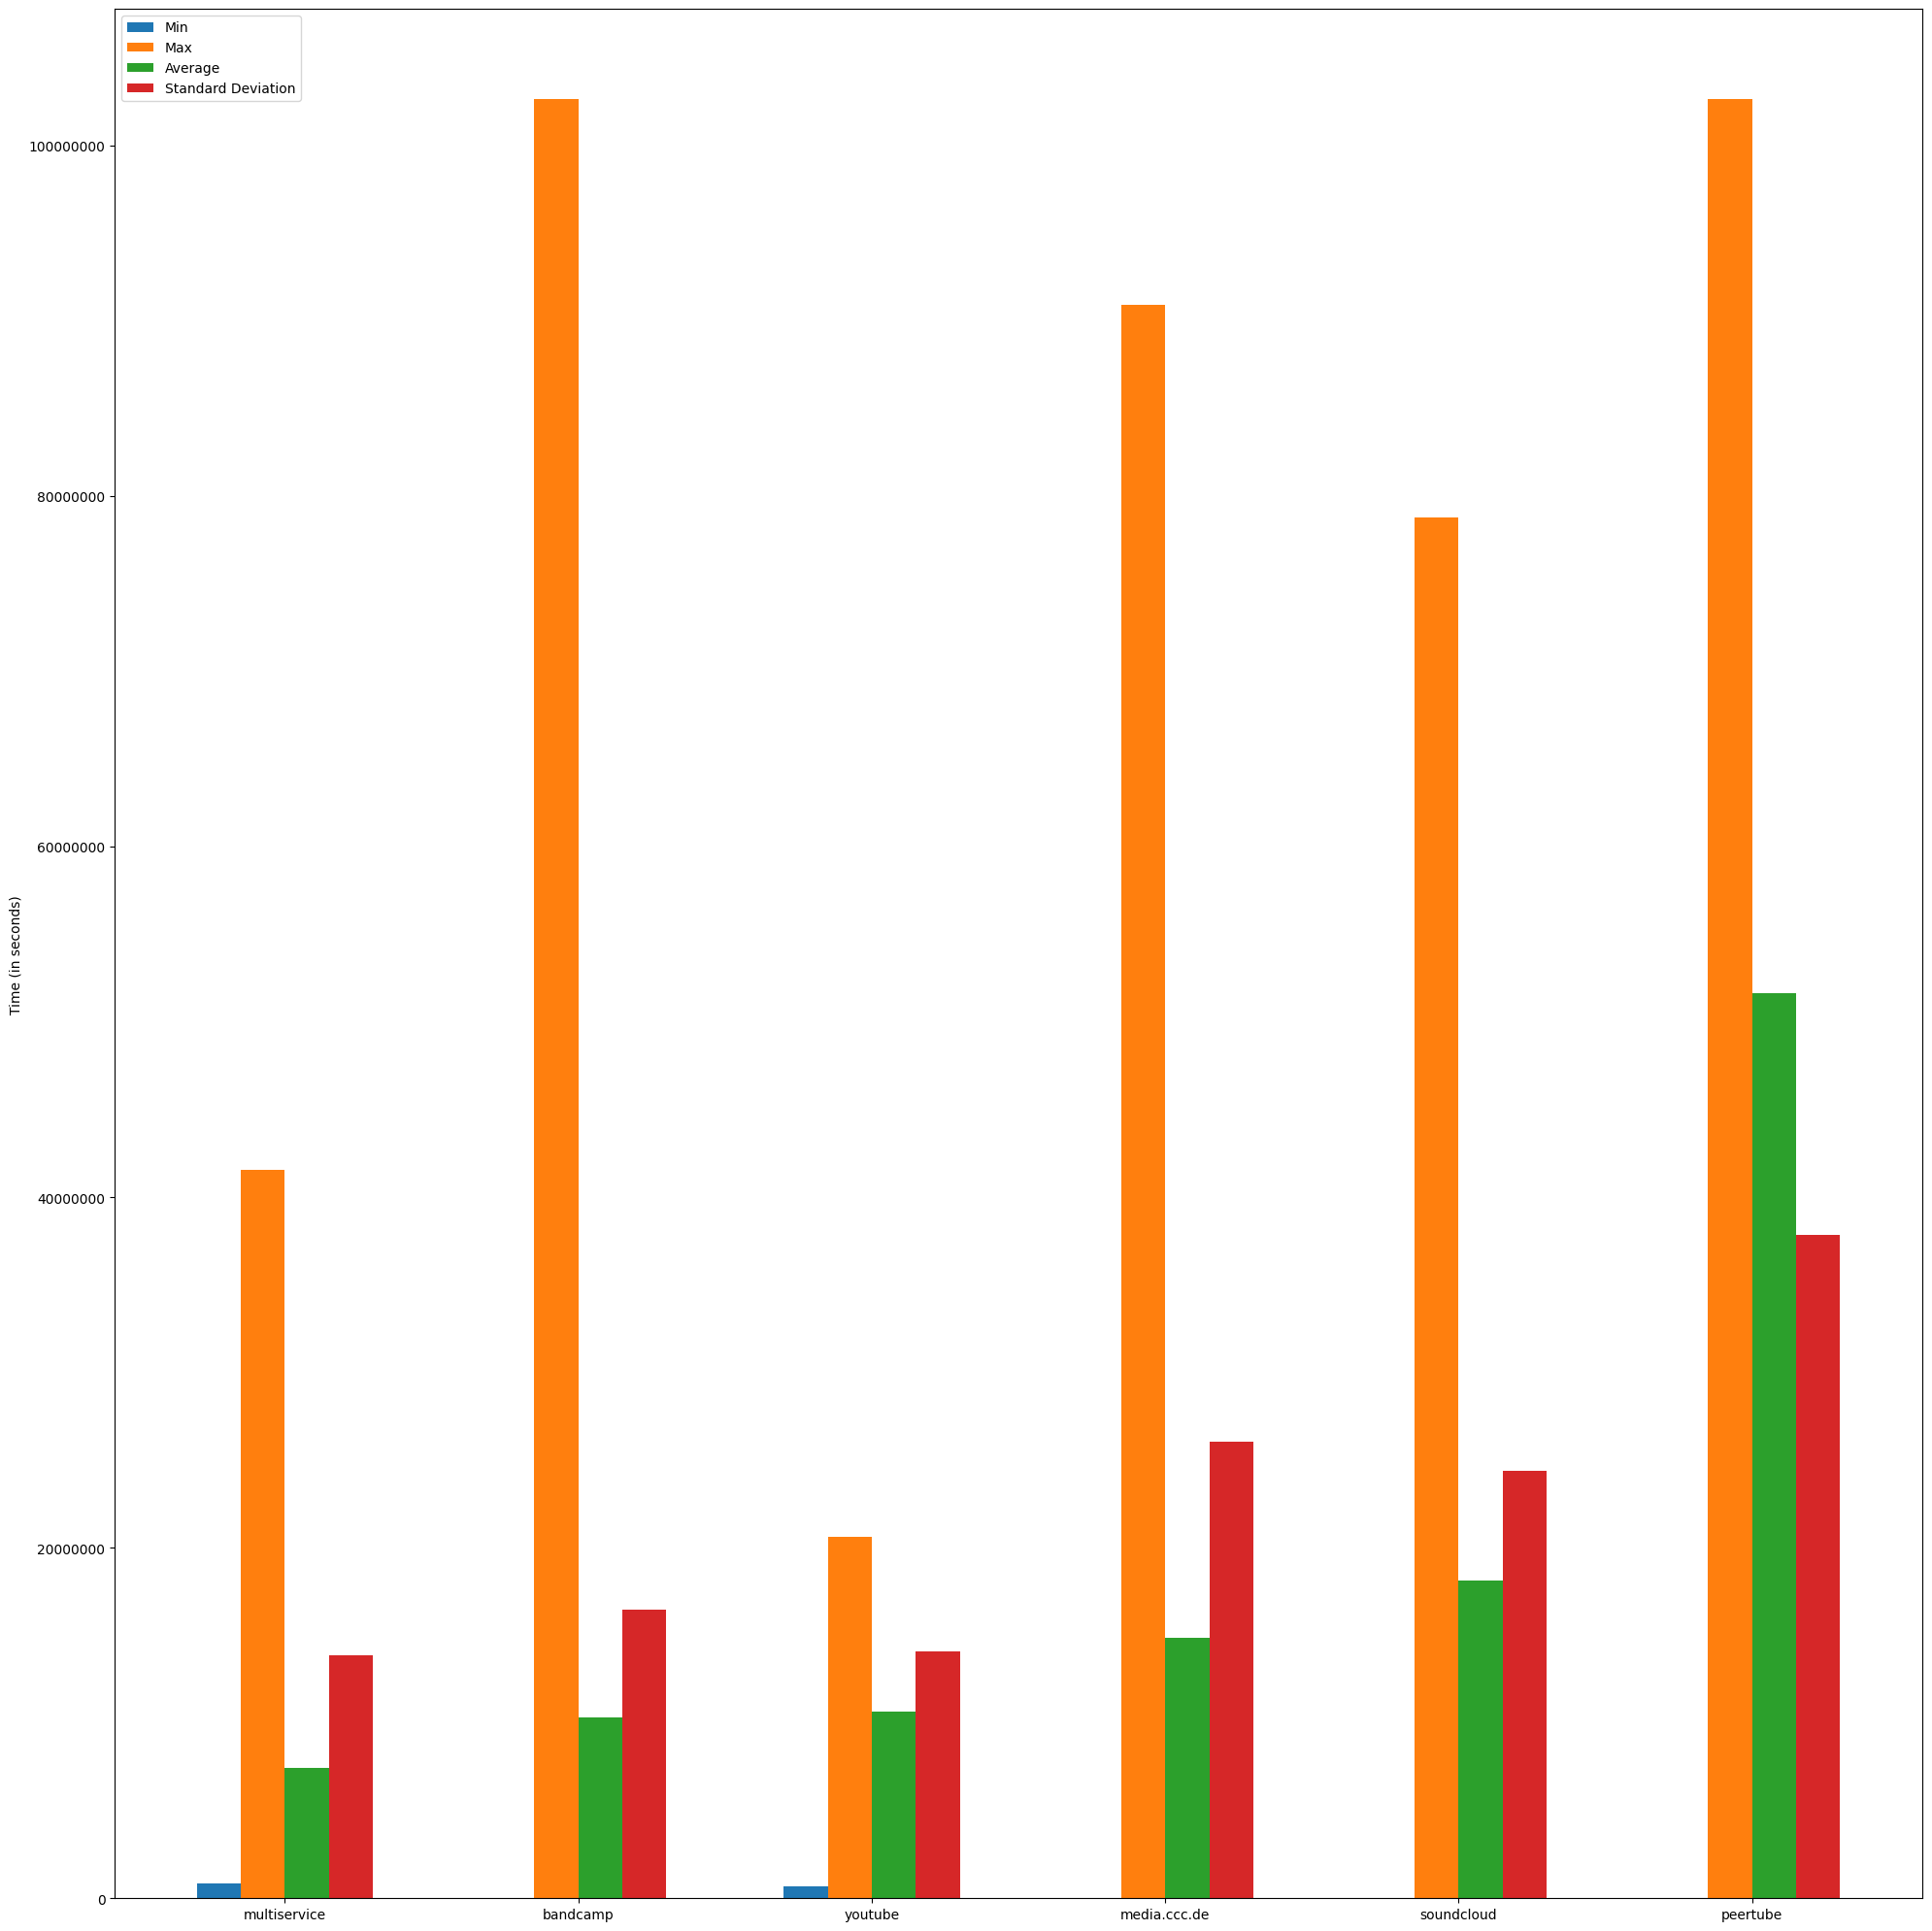

In [396]:
run_difference_between_issue_resolution()

## RQ 02) Qual é o tempo médio de resolução de issues?

In [397]:
def plot_data_barh(title, labels, dataset, color, width = .15):
    fig, ax = plt.subplots()
    ax.ticklabel_format(style="plain")
    y = numpy.arange(len(labels))

    rectsMin = ax.barh(y - width*3/2, dataset.time_to_complete_min, width, label='Min')
    rectsMax = ax.barh(y - width/2, dataset.time_to_complete_max, width, label='Max')
    rectsAvg = ax.barh(y + width/2, dataset.time_to_complete_avg, width, label='Average')
    rectsStd = ax.barh(y + width*3/2, dataset.time_to_complete_std, width, label='Standard Deviation')
    
    ax.set_xlabel("Time (in seconds)")
    ax.set_yticks(y, labels)
    ax.legend()

    # fig.tight_layout()

def average_issue_resolution_time():
    plot_data_barh("Average time to complete issues (in seconds)", df_tags.name, df_label_means, tag_colors)

    for tag in df_tags.name:
        print(tag)
        compare_tag(tag)
    return

good first issue
Mann-Whitney test result: the H0 was rejected with statistic 309994.0 and p-value 6.365166622730932e-17. Then the alternative hypothesis good first issue_time_to_complete > NON_good first issue_time_to_complete was acepted with statistic 309994.0 and p-value 3.182583311365466e-17, with Cohen’s d effect size = 0.843875719610023 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
CI
Mann-Whitney test result: the hypothesis CI_time_to_complete == NON_CI_time_to_complete is acepted with statistic 11432.0 and p-value 0.26153555367688697, with Cohen’s d effect size = 0.04057813856153804 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
device/software specific
Mann-Whitney test result: the H0 was rejected with statistic 551898.0 and p-value 3.429259806706859e-24. Then the alternative hypothesis device/software specific_time_to_complete > NON_device/software specific_time_to_complete was acepted with statistic 551898.0 and p-value 1.7146299033534296e-24, with Cohe

c:\Users\Júnior\AppData\Local\Programs\Python\Python311\Lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
c:\Users\Júnior\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mann-Whitney test result: the H0 was rejected with statistic 344549.0 and p-value 2.5989992715183432e-12. Then the alternative hypothesis requires extractor change_time_to_complete > NON_requires extractor change_time_to_complete was acepted with statistic 344549.0 and p-value 1.2994996357591716e-12, with Cohen’s d effect size = 0.43457745983952173 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
discussion
Mann-Whitney test result: the H0 was rejected with statistic 191790.0 and p-value 6.254878161493292e-08. Then the alternative hypothesis discussion_time_to_complete > NON_discussion_time_to_complete was acepted with statistic 191790.0 and p-value 3.127439080746646e-08, with Cohen’s d effect size = 1.2210967071566112 [0.2 <= d (small), 0.5 <= d (medium), 0.8 <= d (large)].
player notification
Mann-Whitney test result: the H0 was rejected with statistic 35747.0 and p-value 0.024209292390404133. Then the alternative hypothesis player notification_time_to_complete > NON_player n

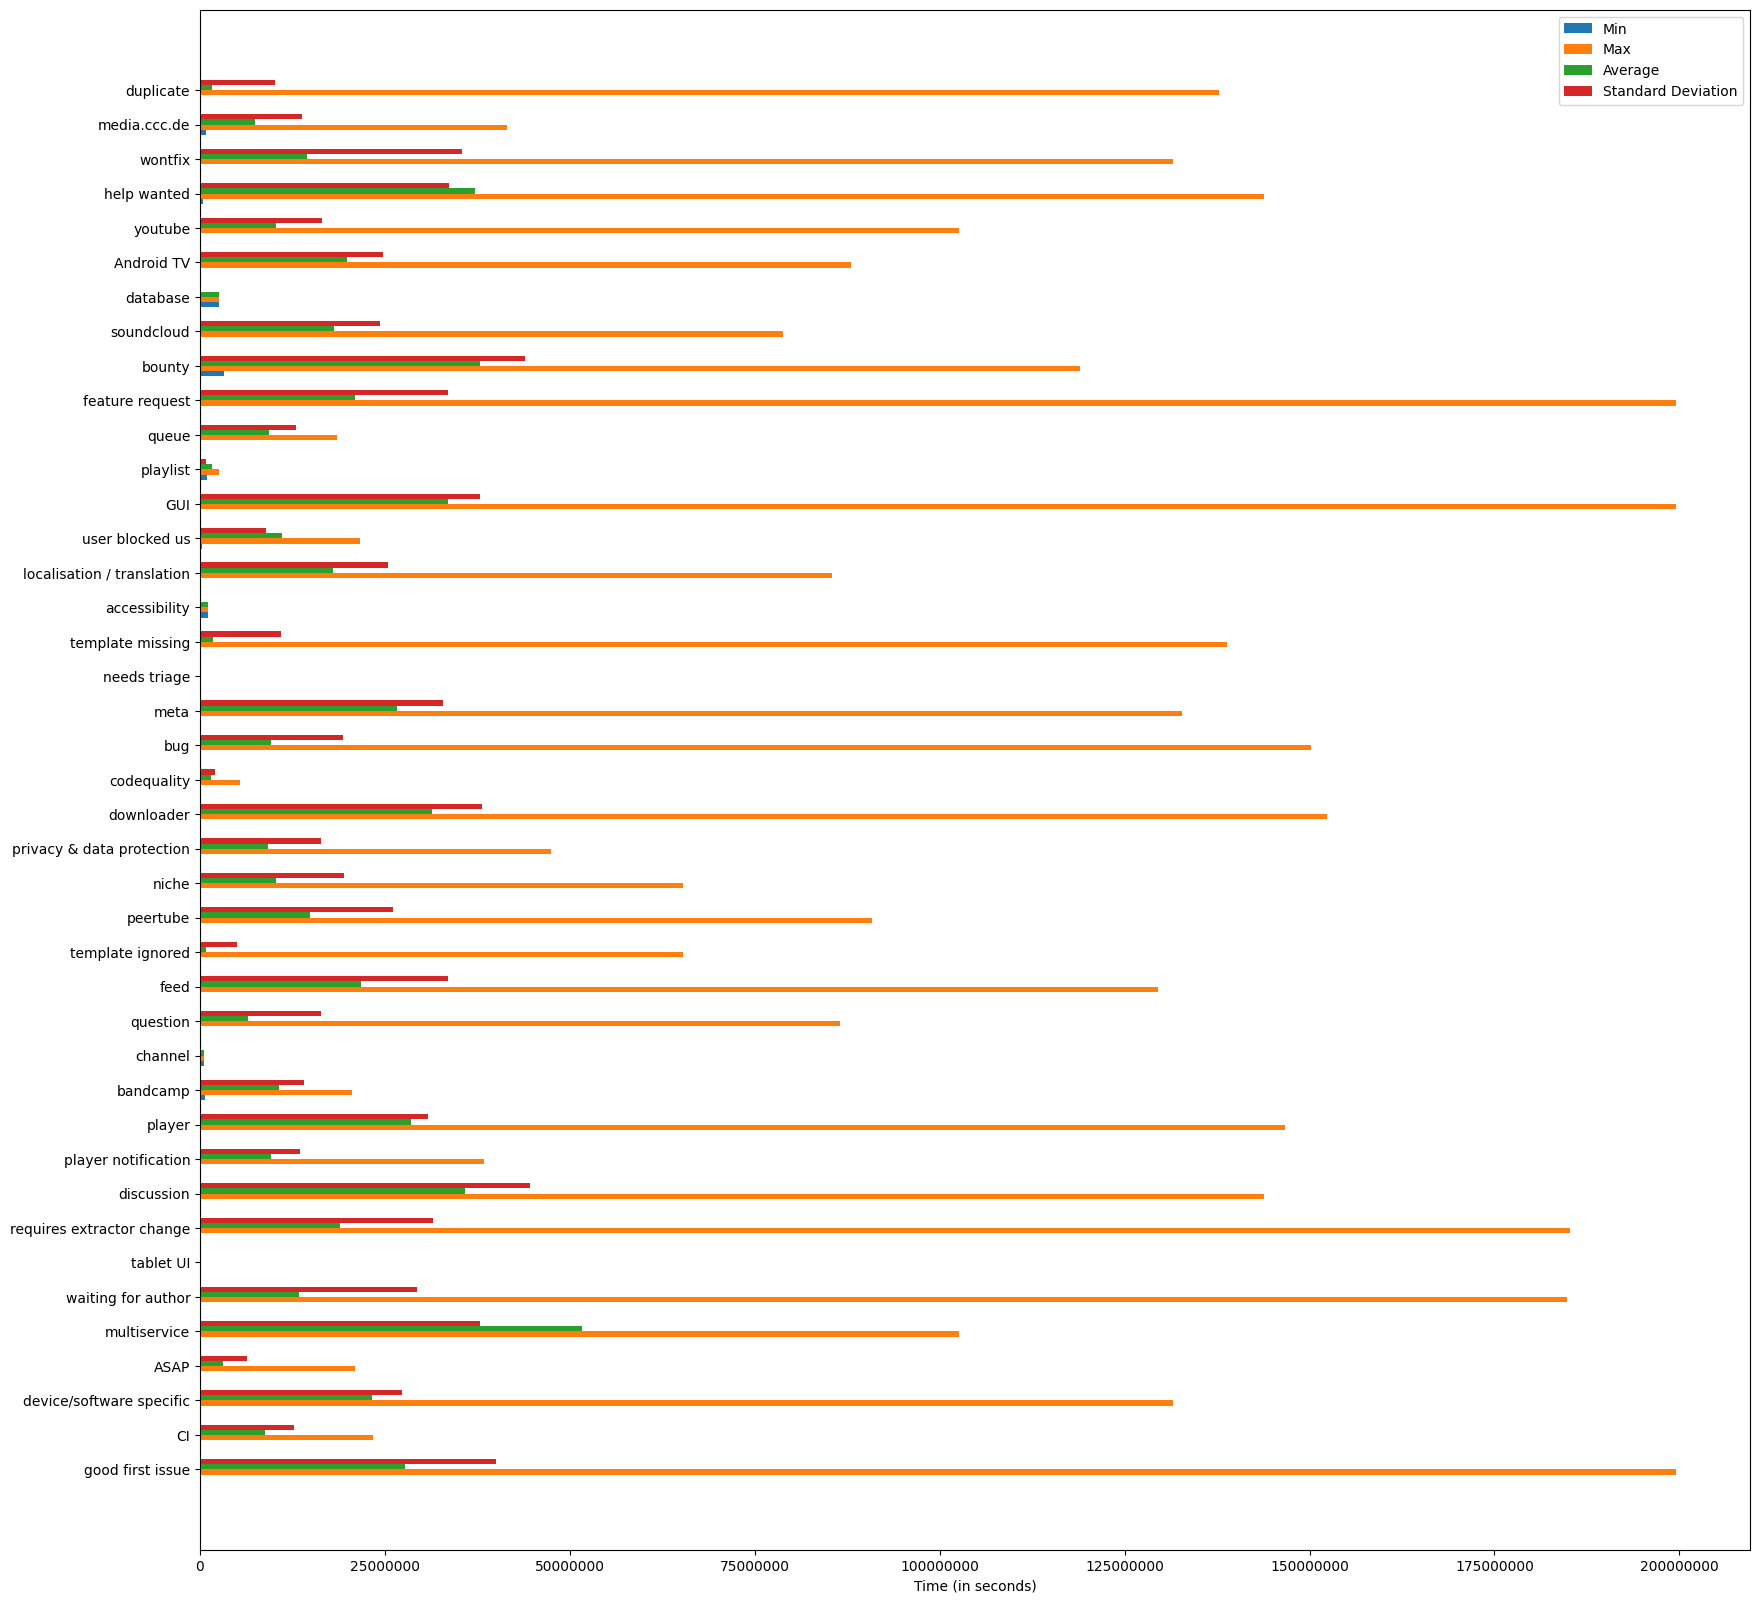

In [398]:
average_issue_resolution_time()

## RQ 03) Como se comporta a distribuição do tempo para completar uma issue?

In [399]:
def show_completion_time_distribution():
    for tag in df_tags.name:
        plot_data_boxplot("Time to Complete "+tag+" (in seconds)", fetch_comparison_data(df_issues, tag, False).time_to_complete)

C:\Users\Júnior\AppData\Local\Temp\ipykernel_9780\672254065.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots()


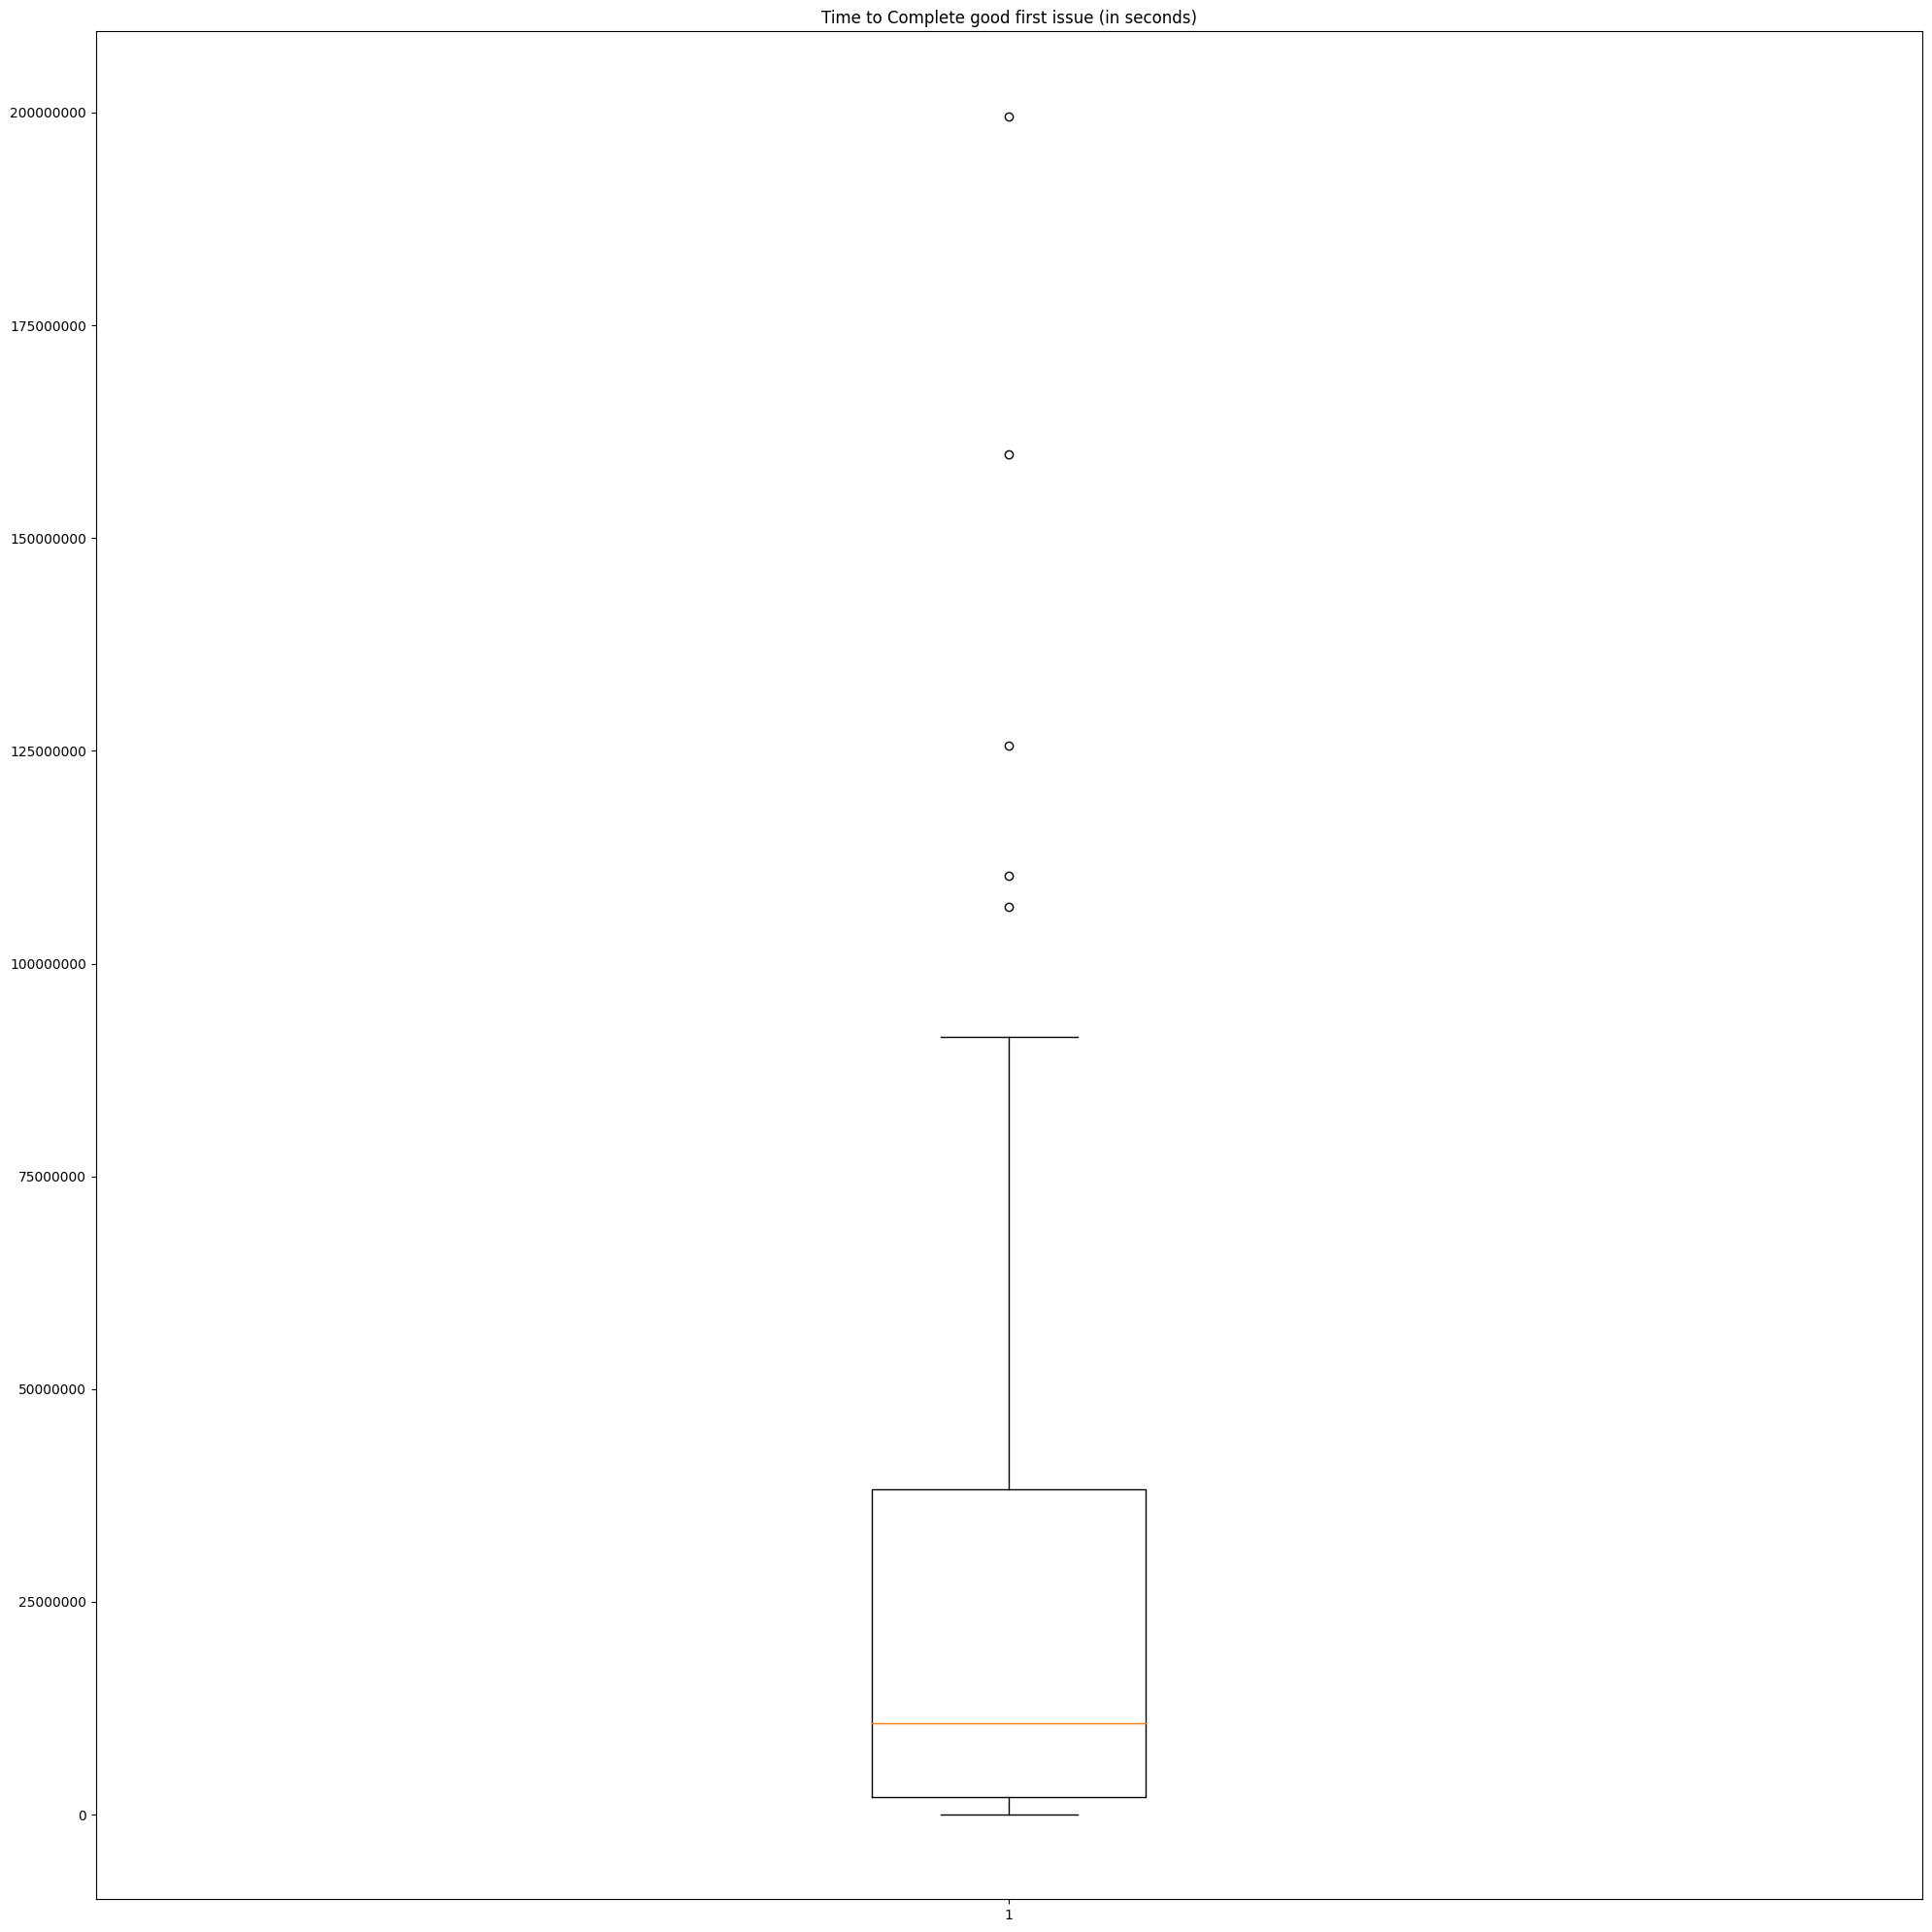

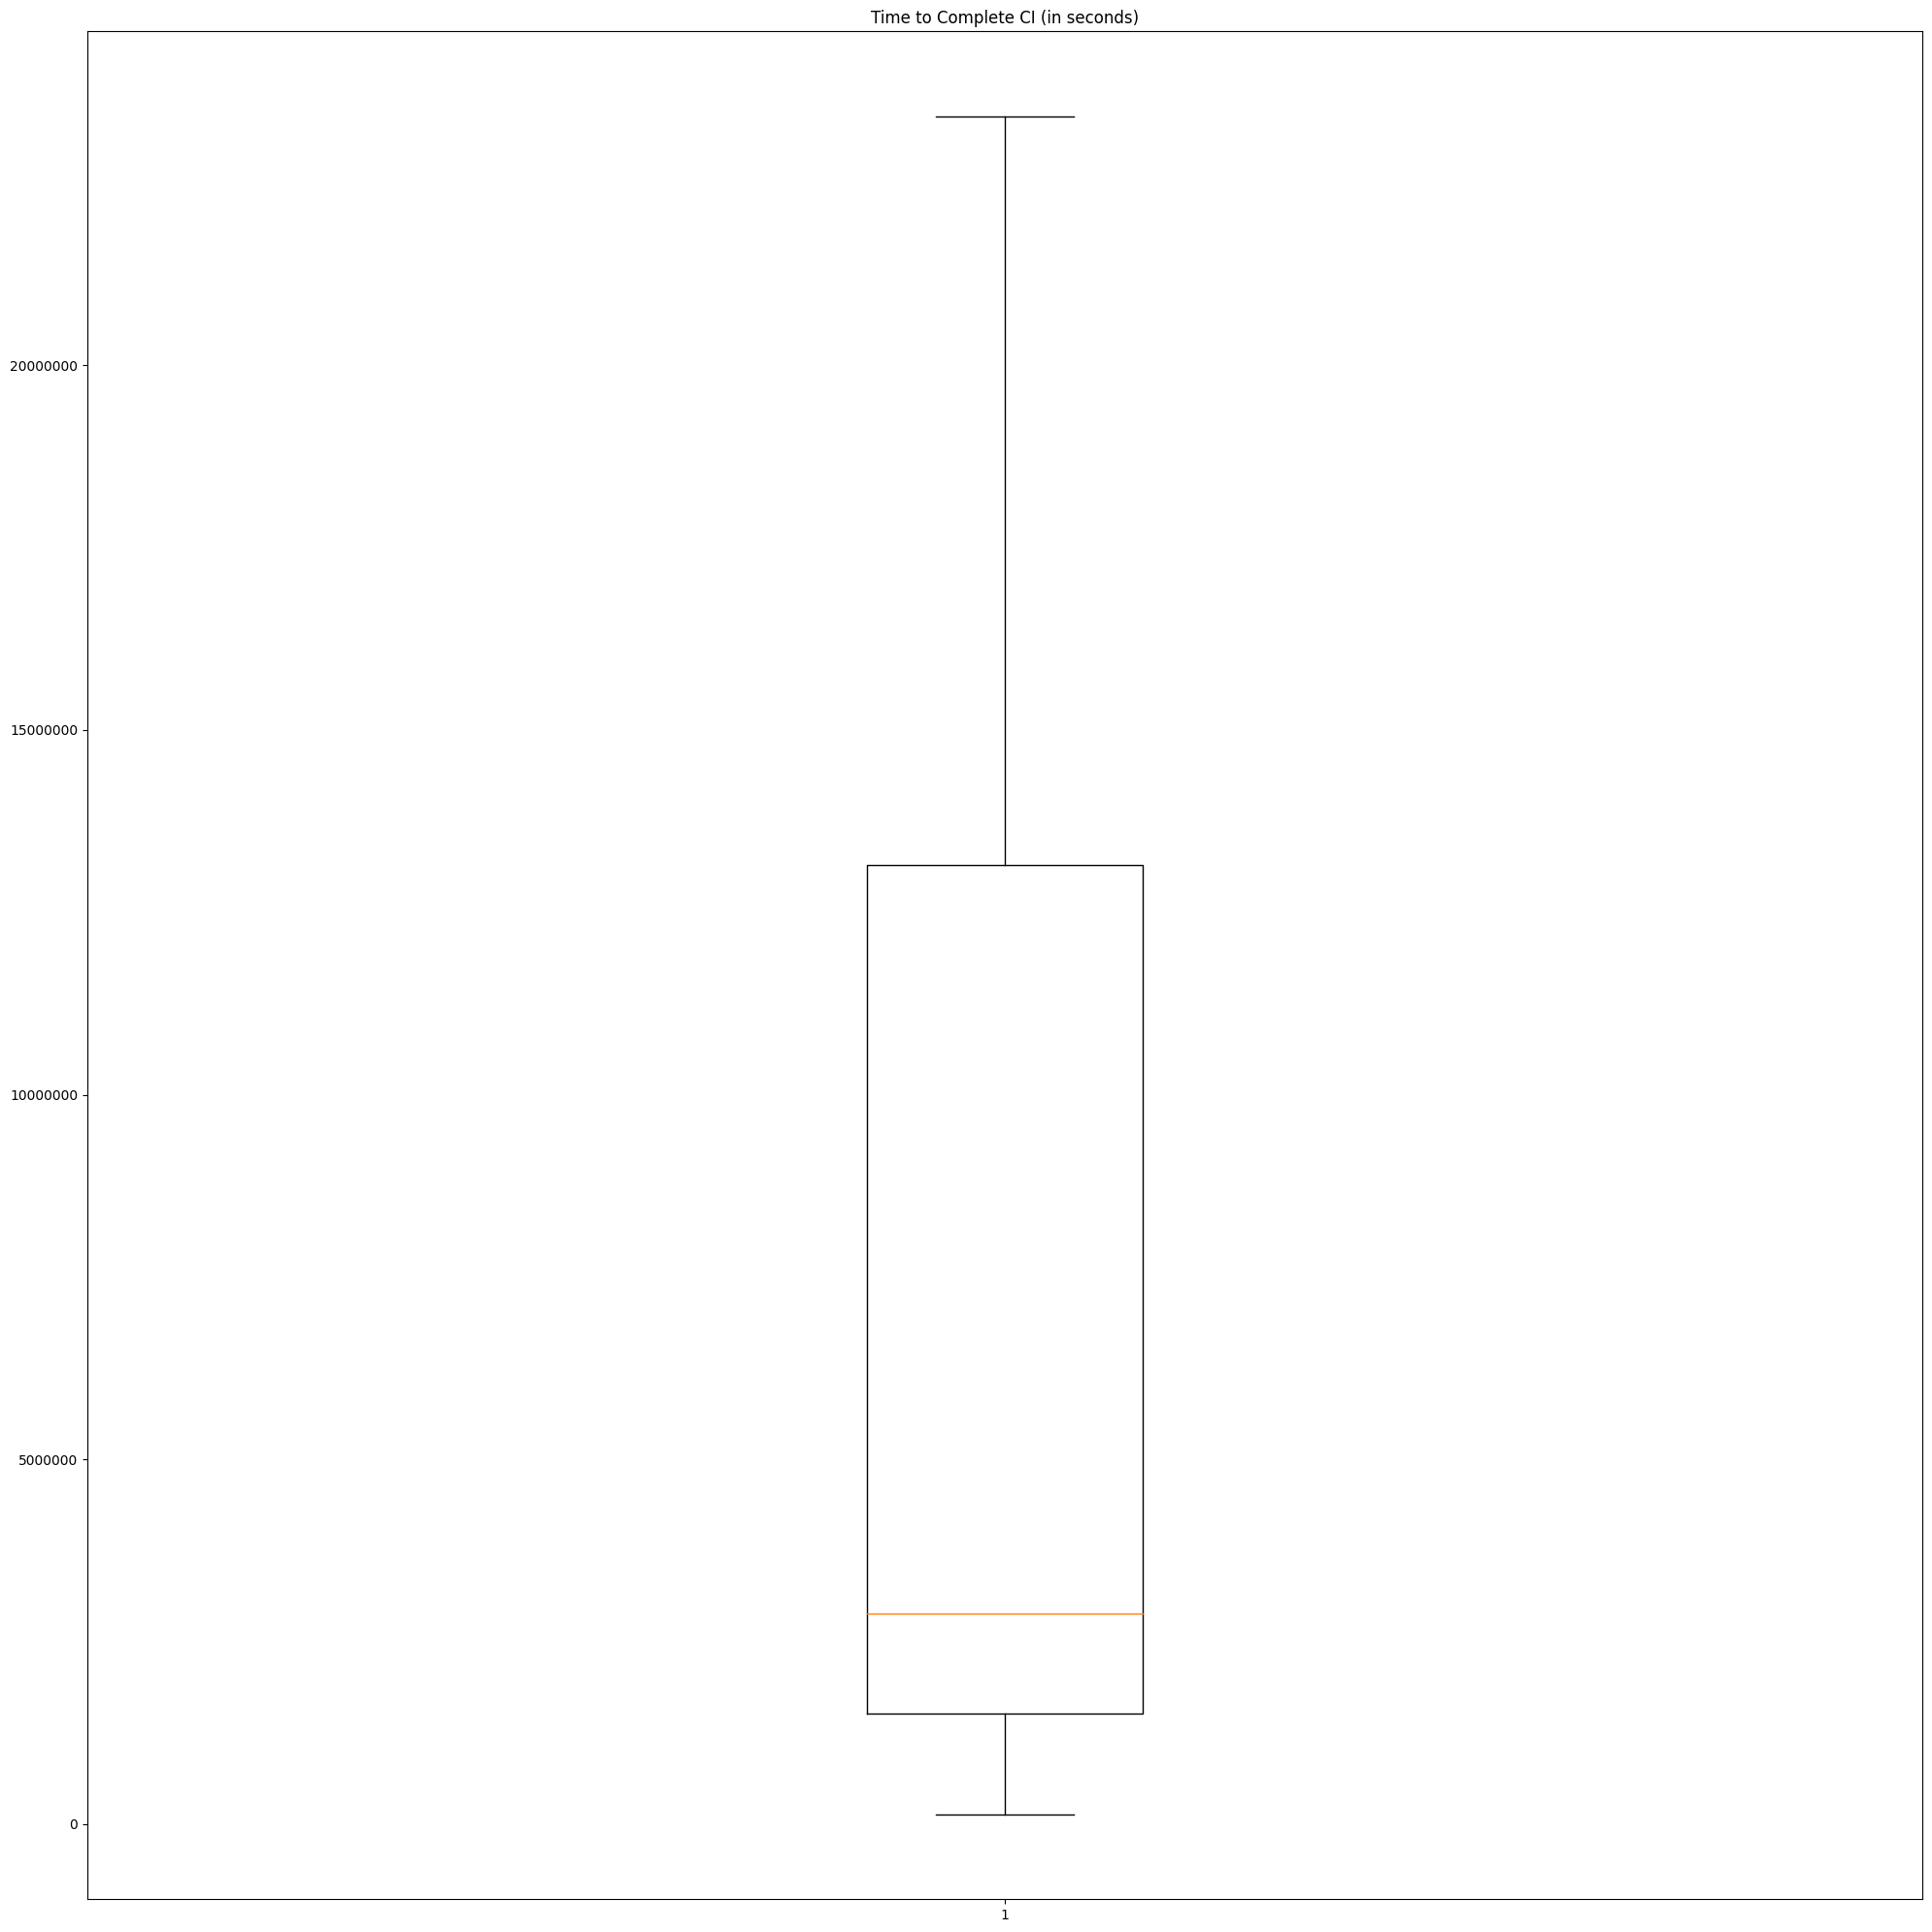

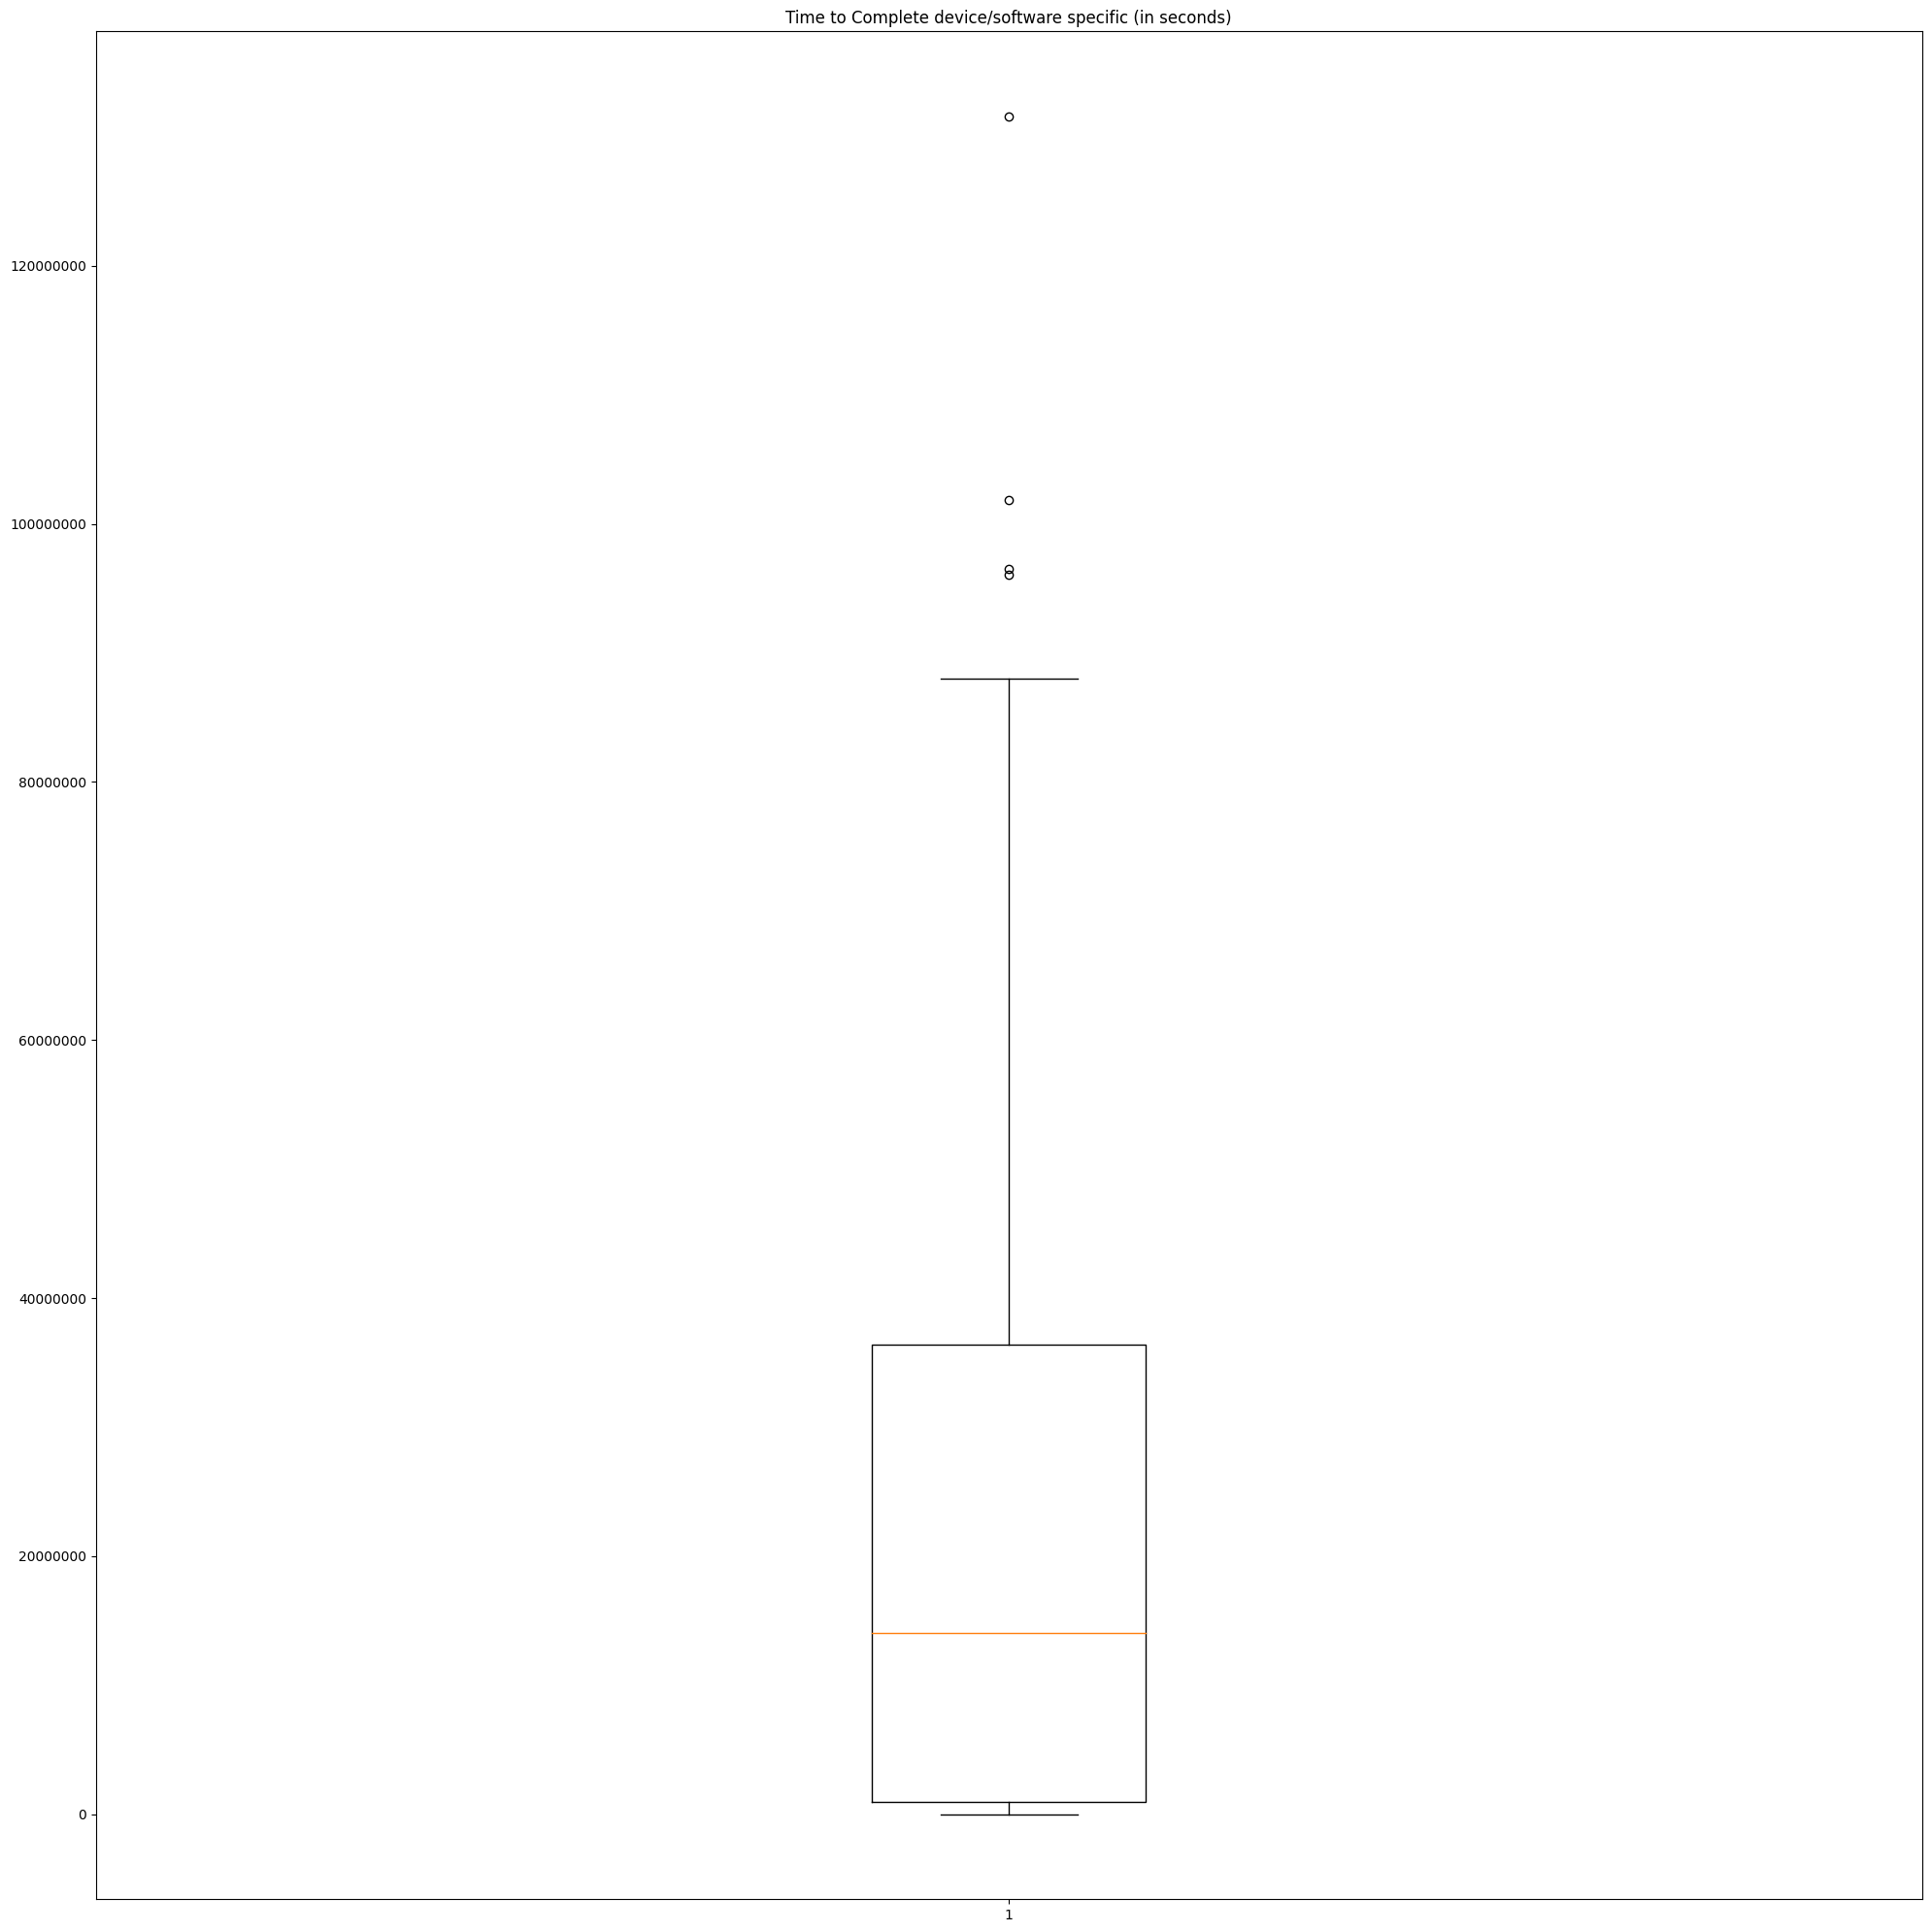

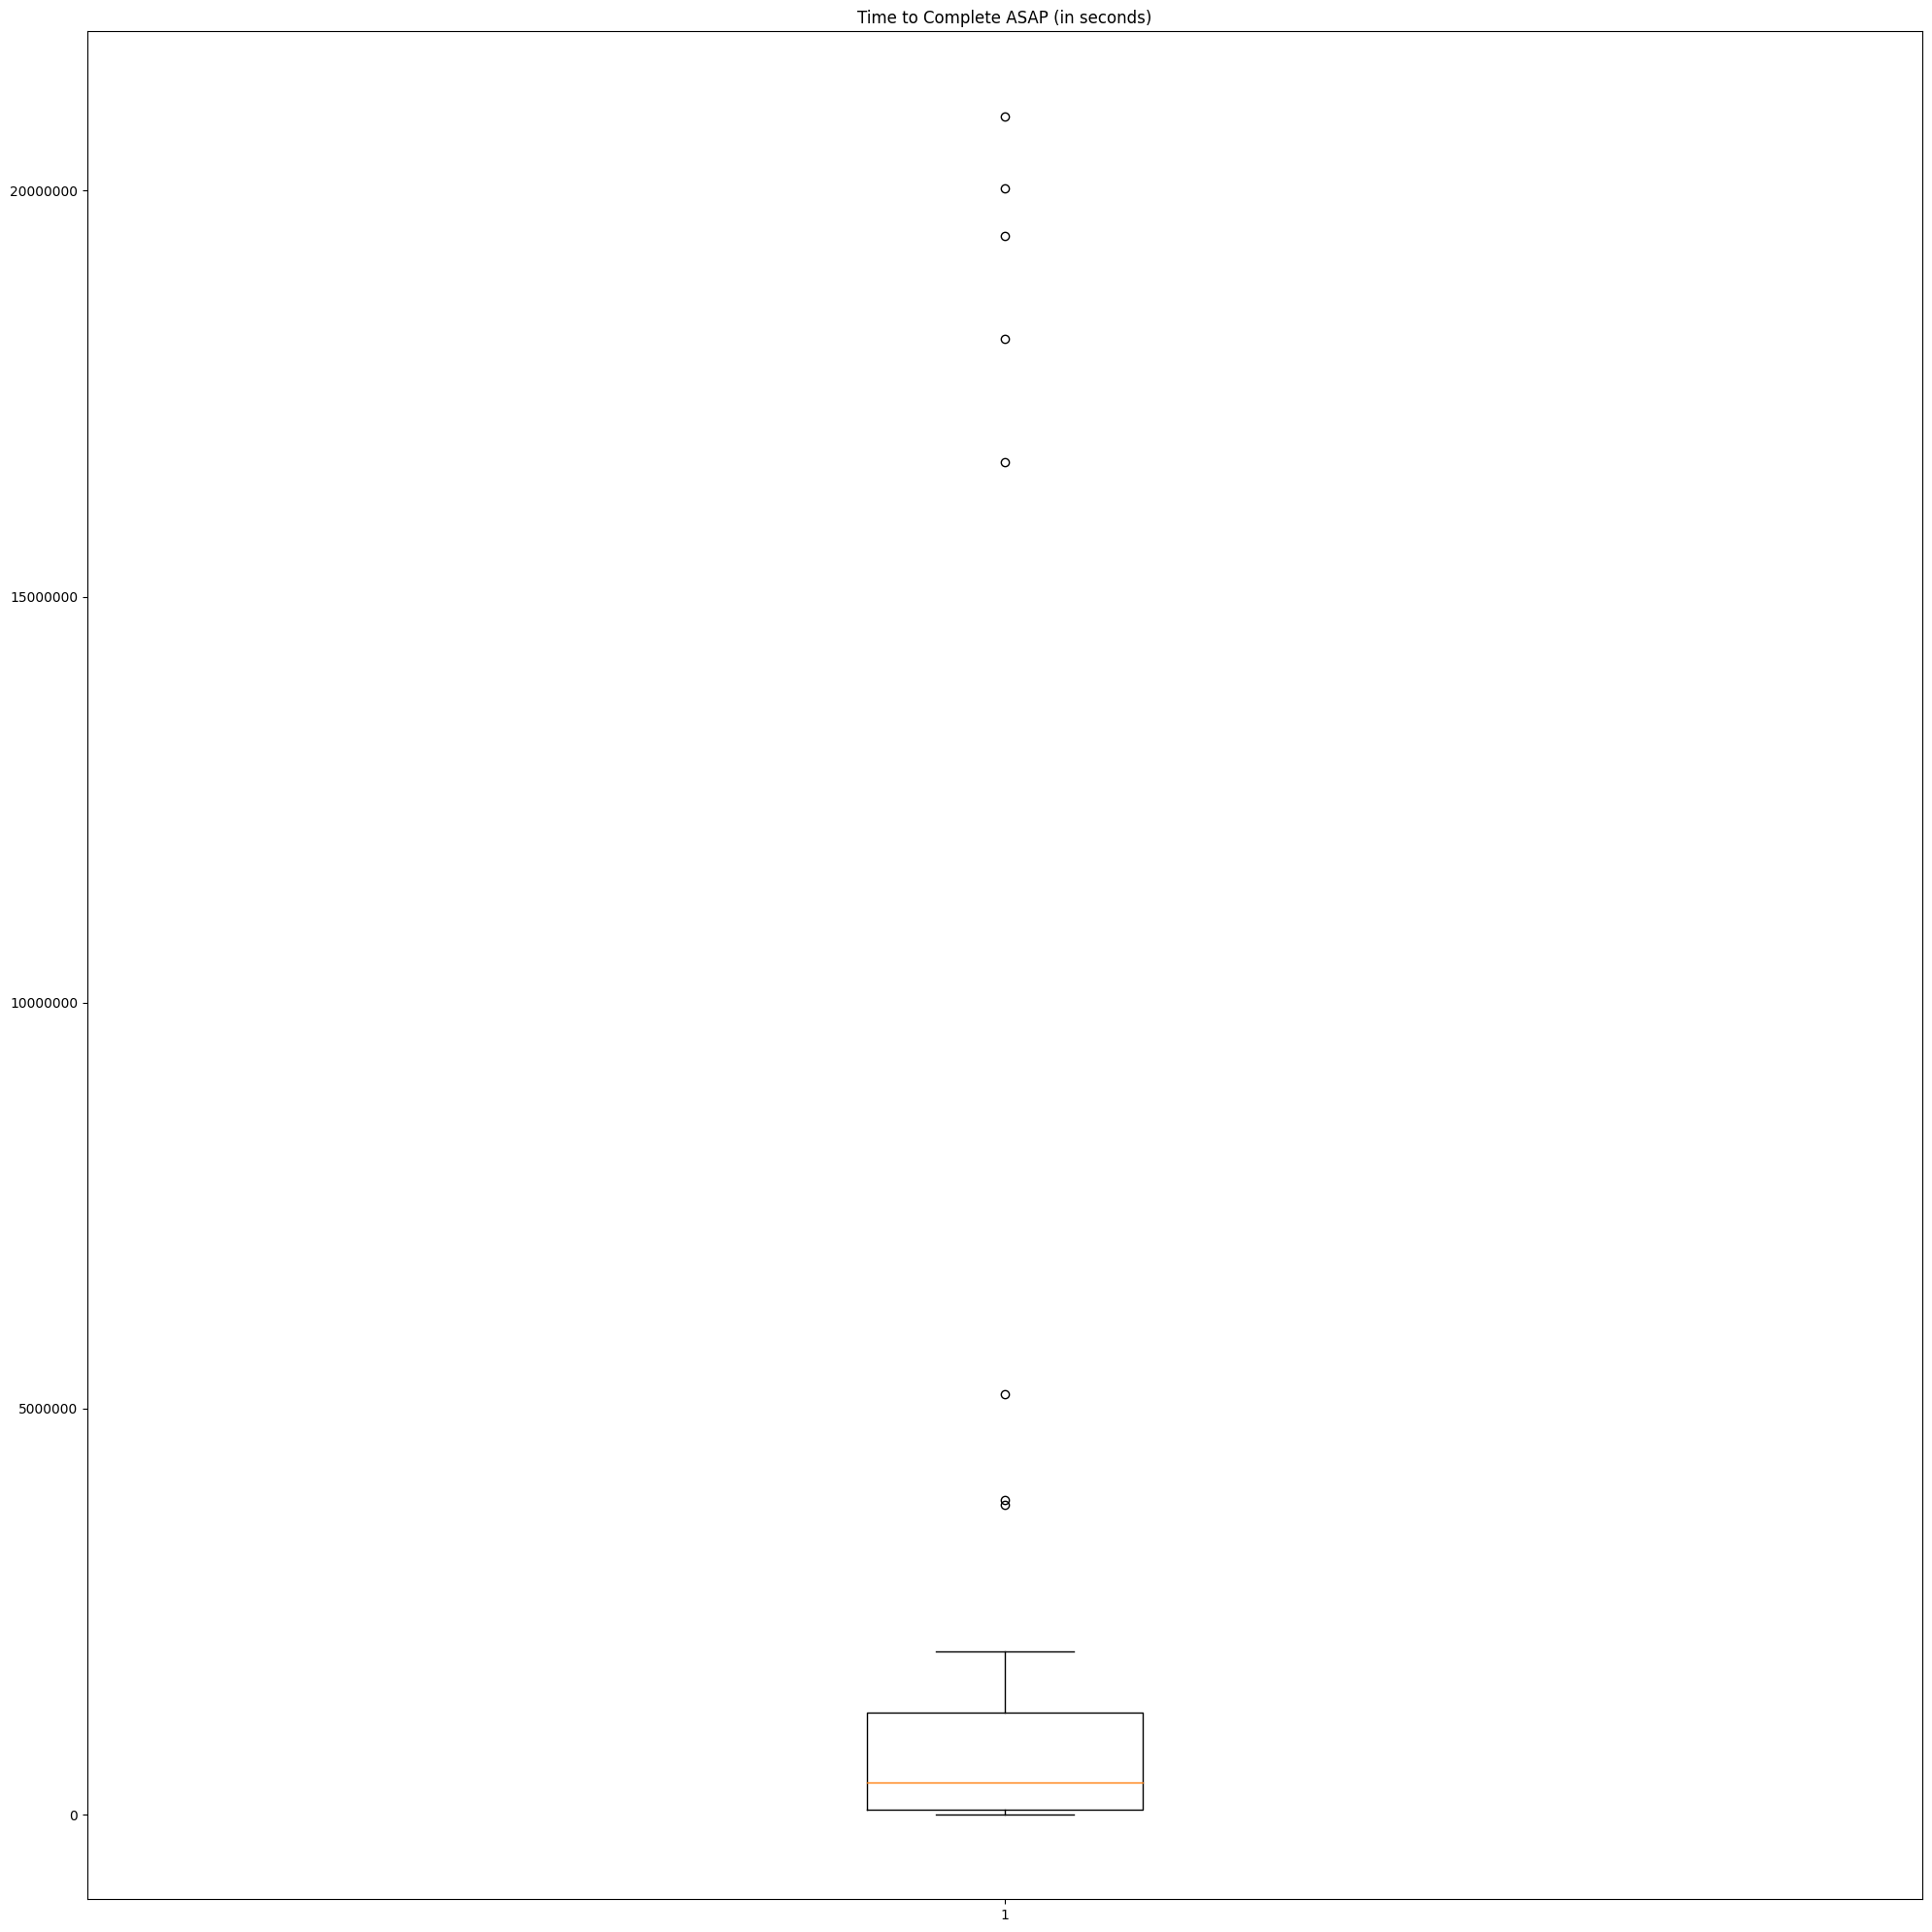

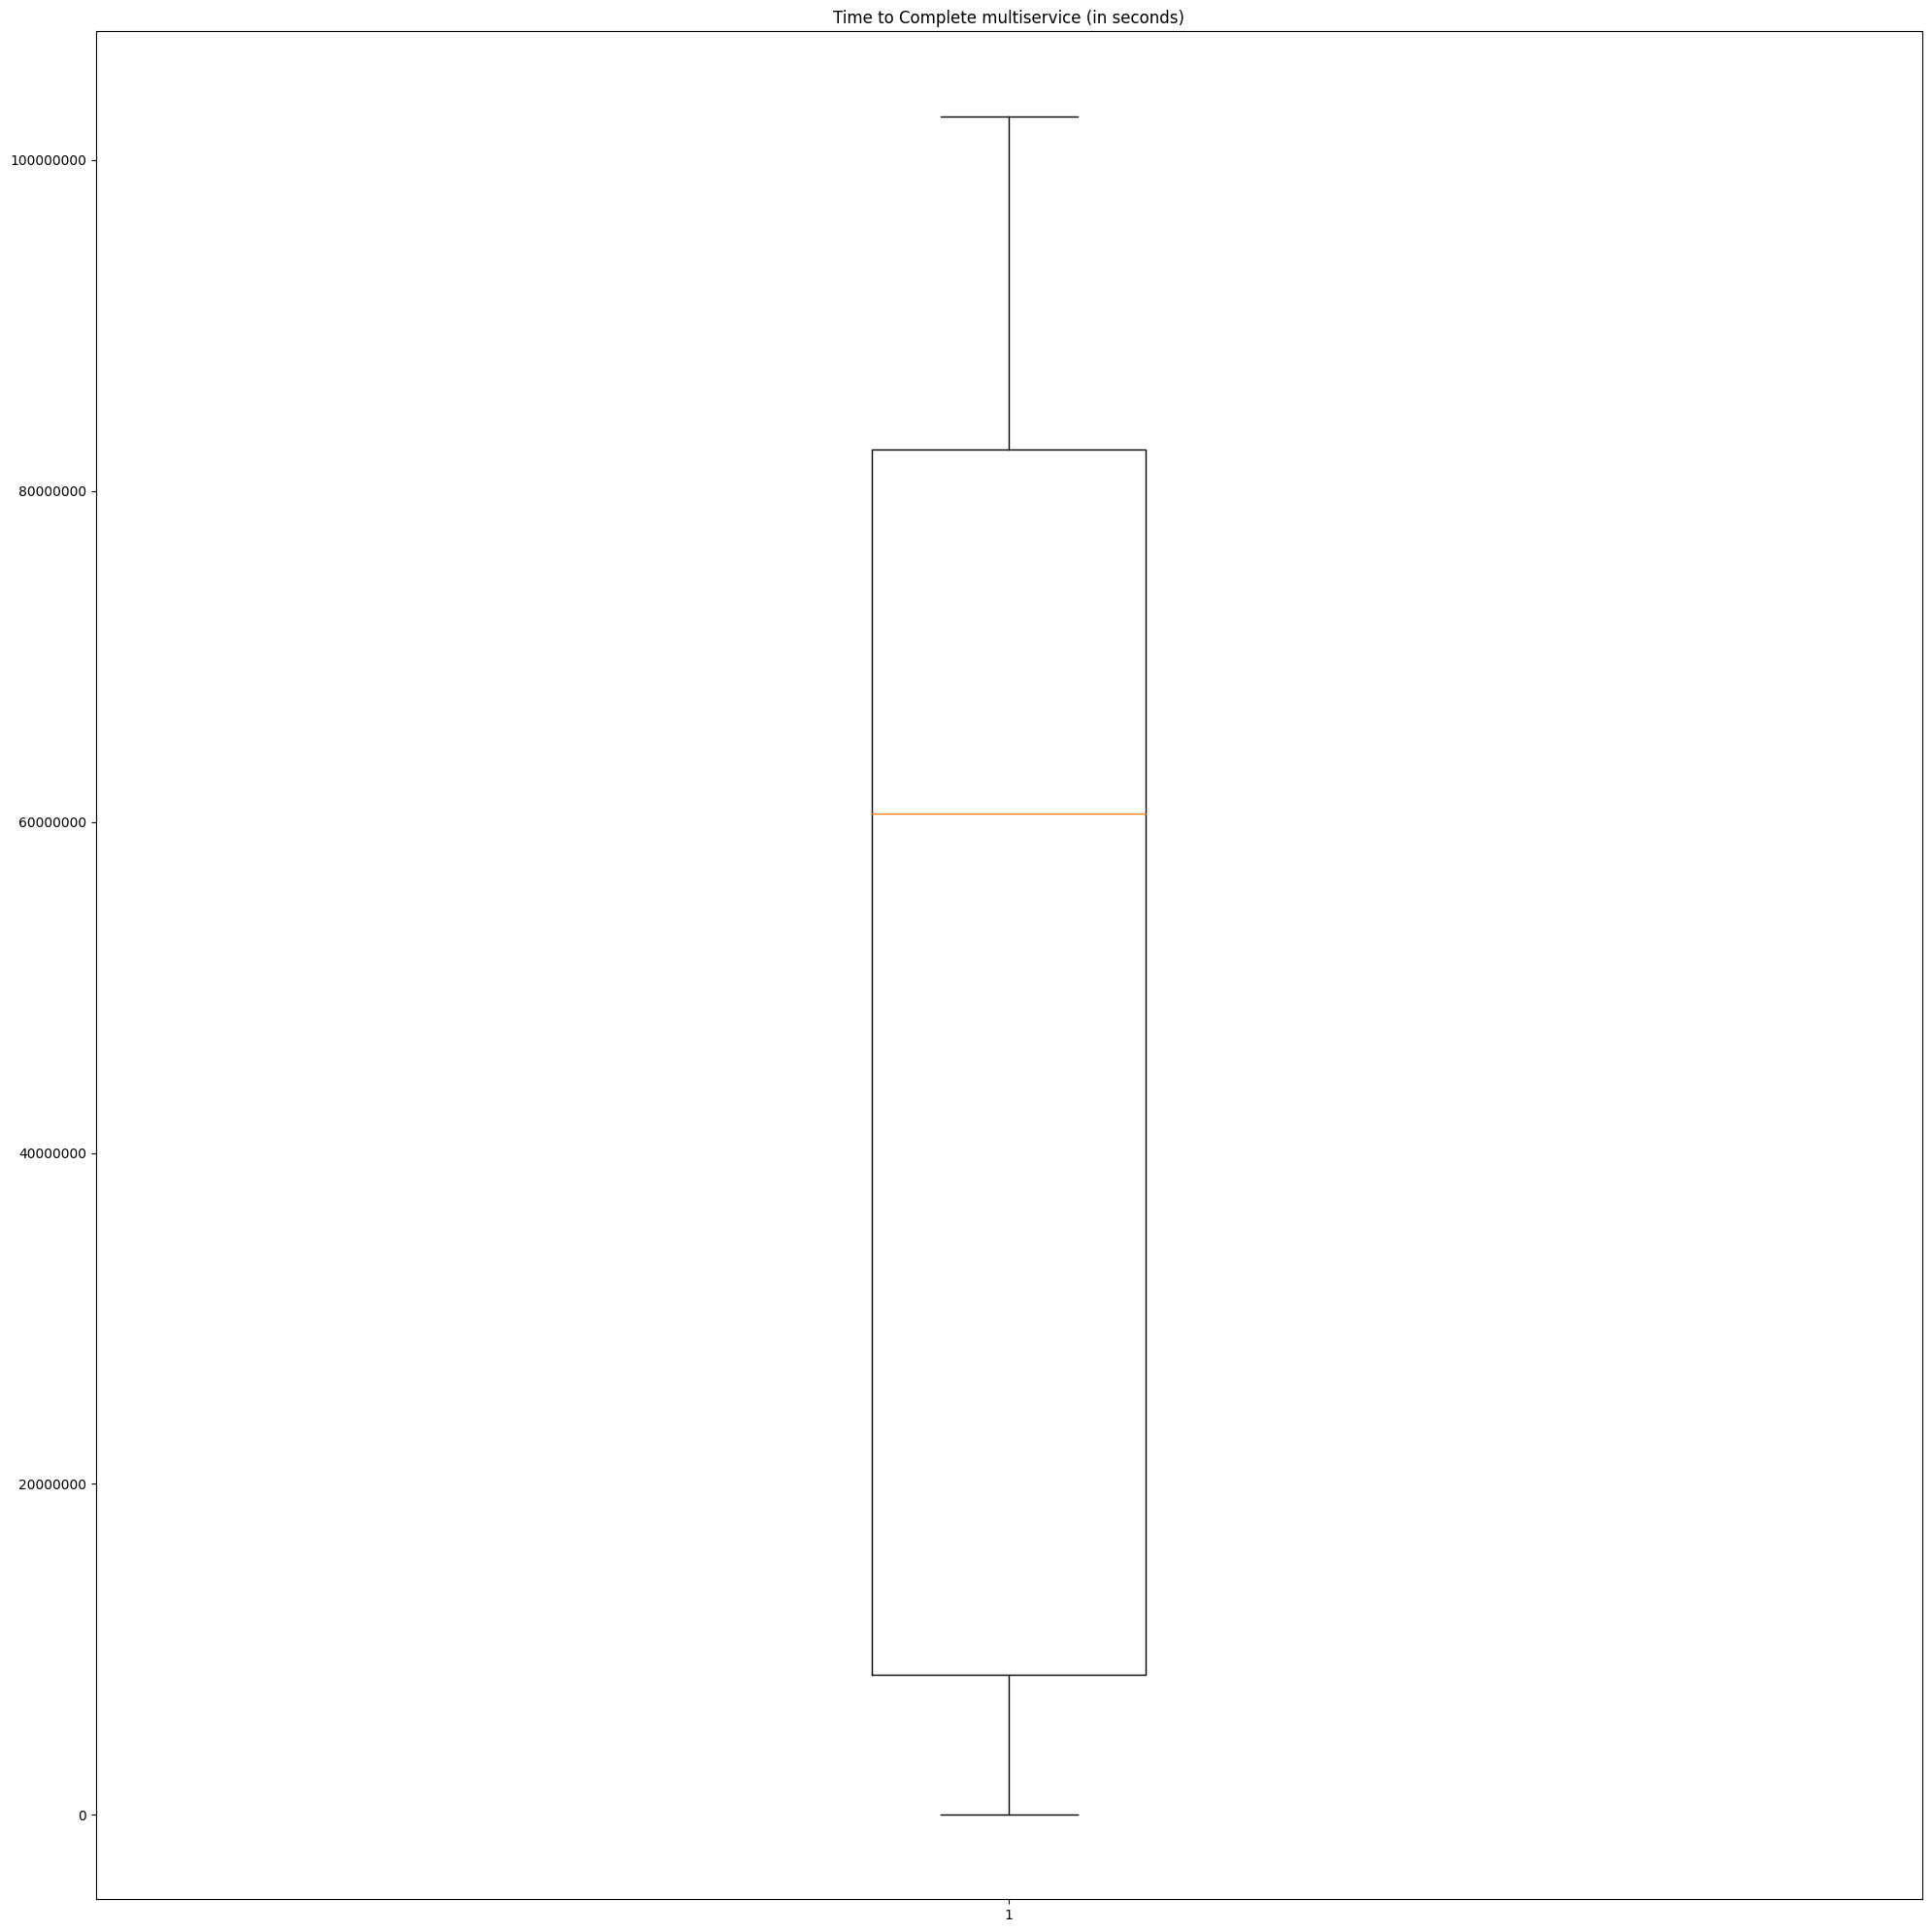

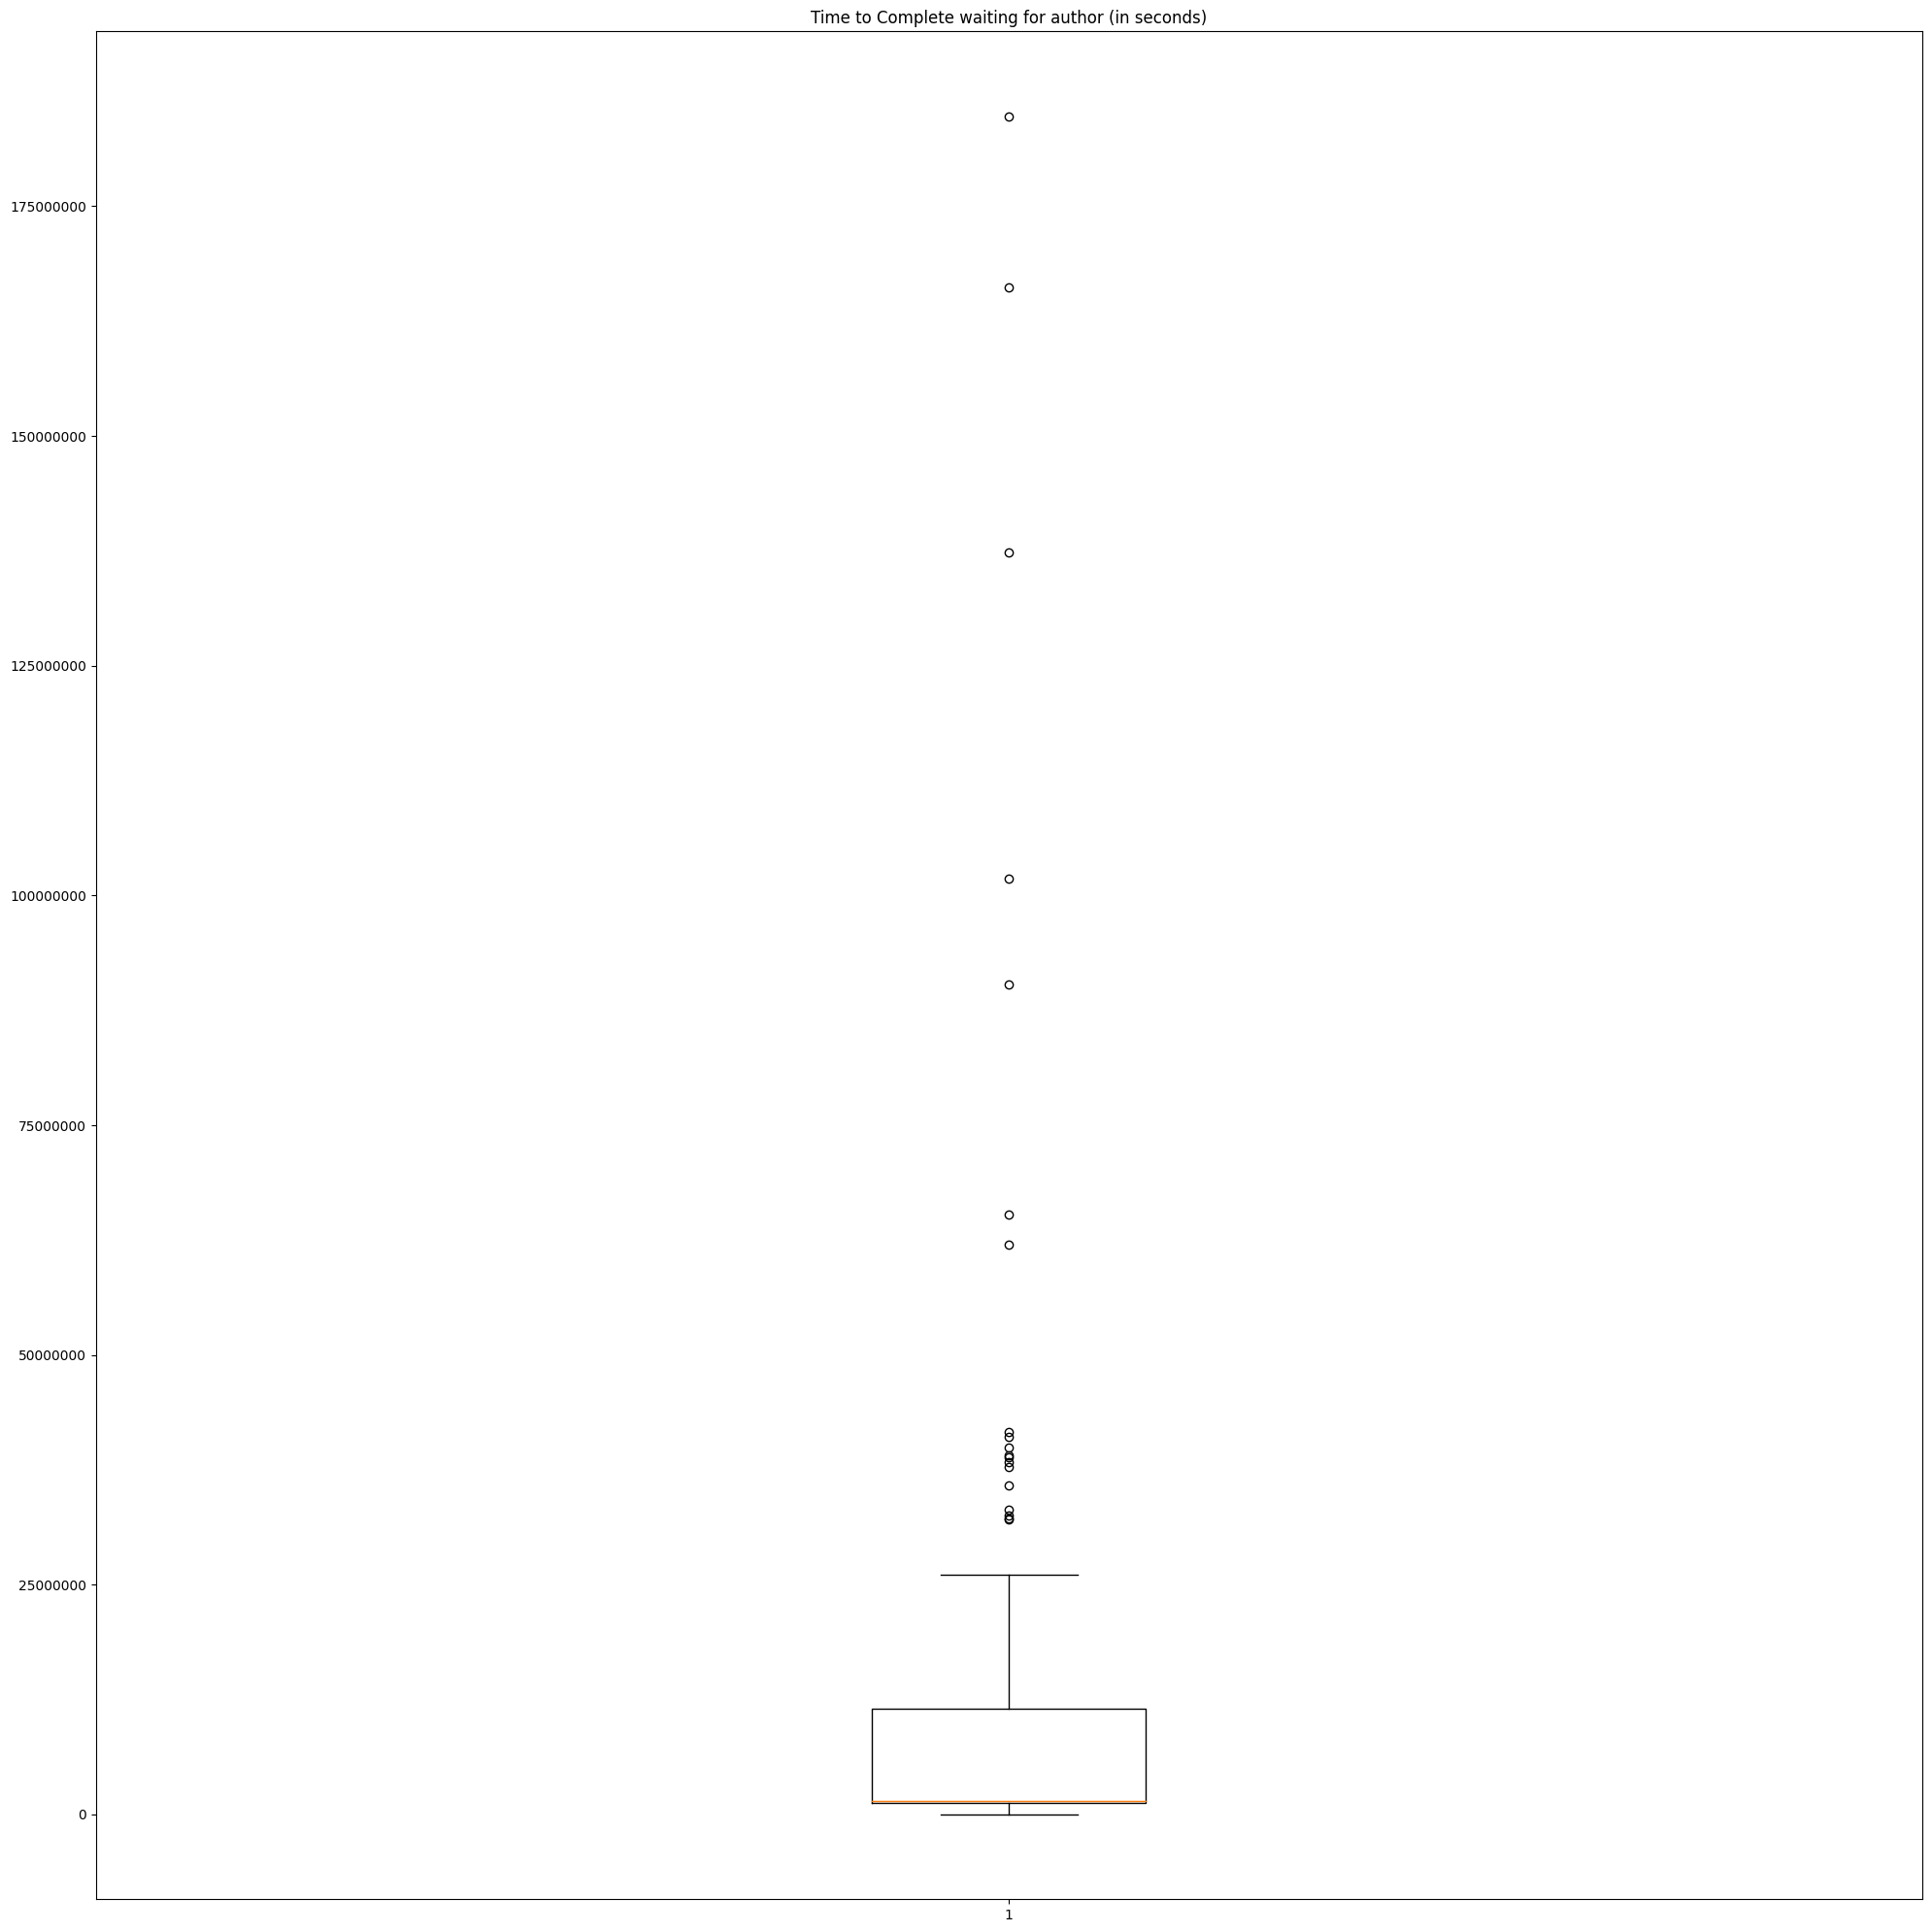

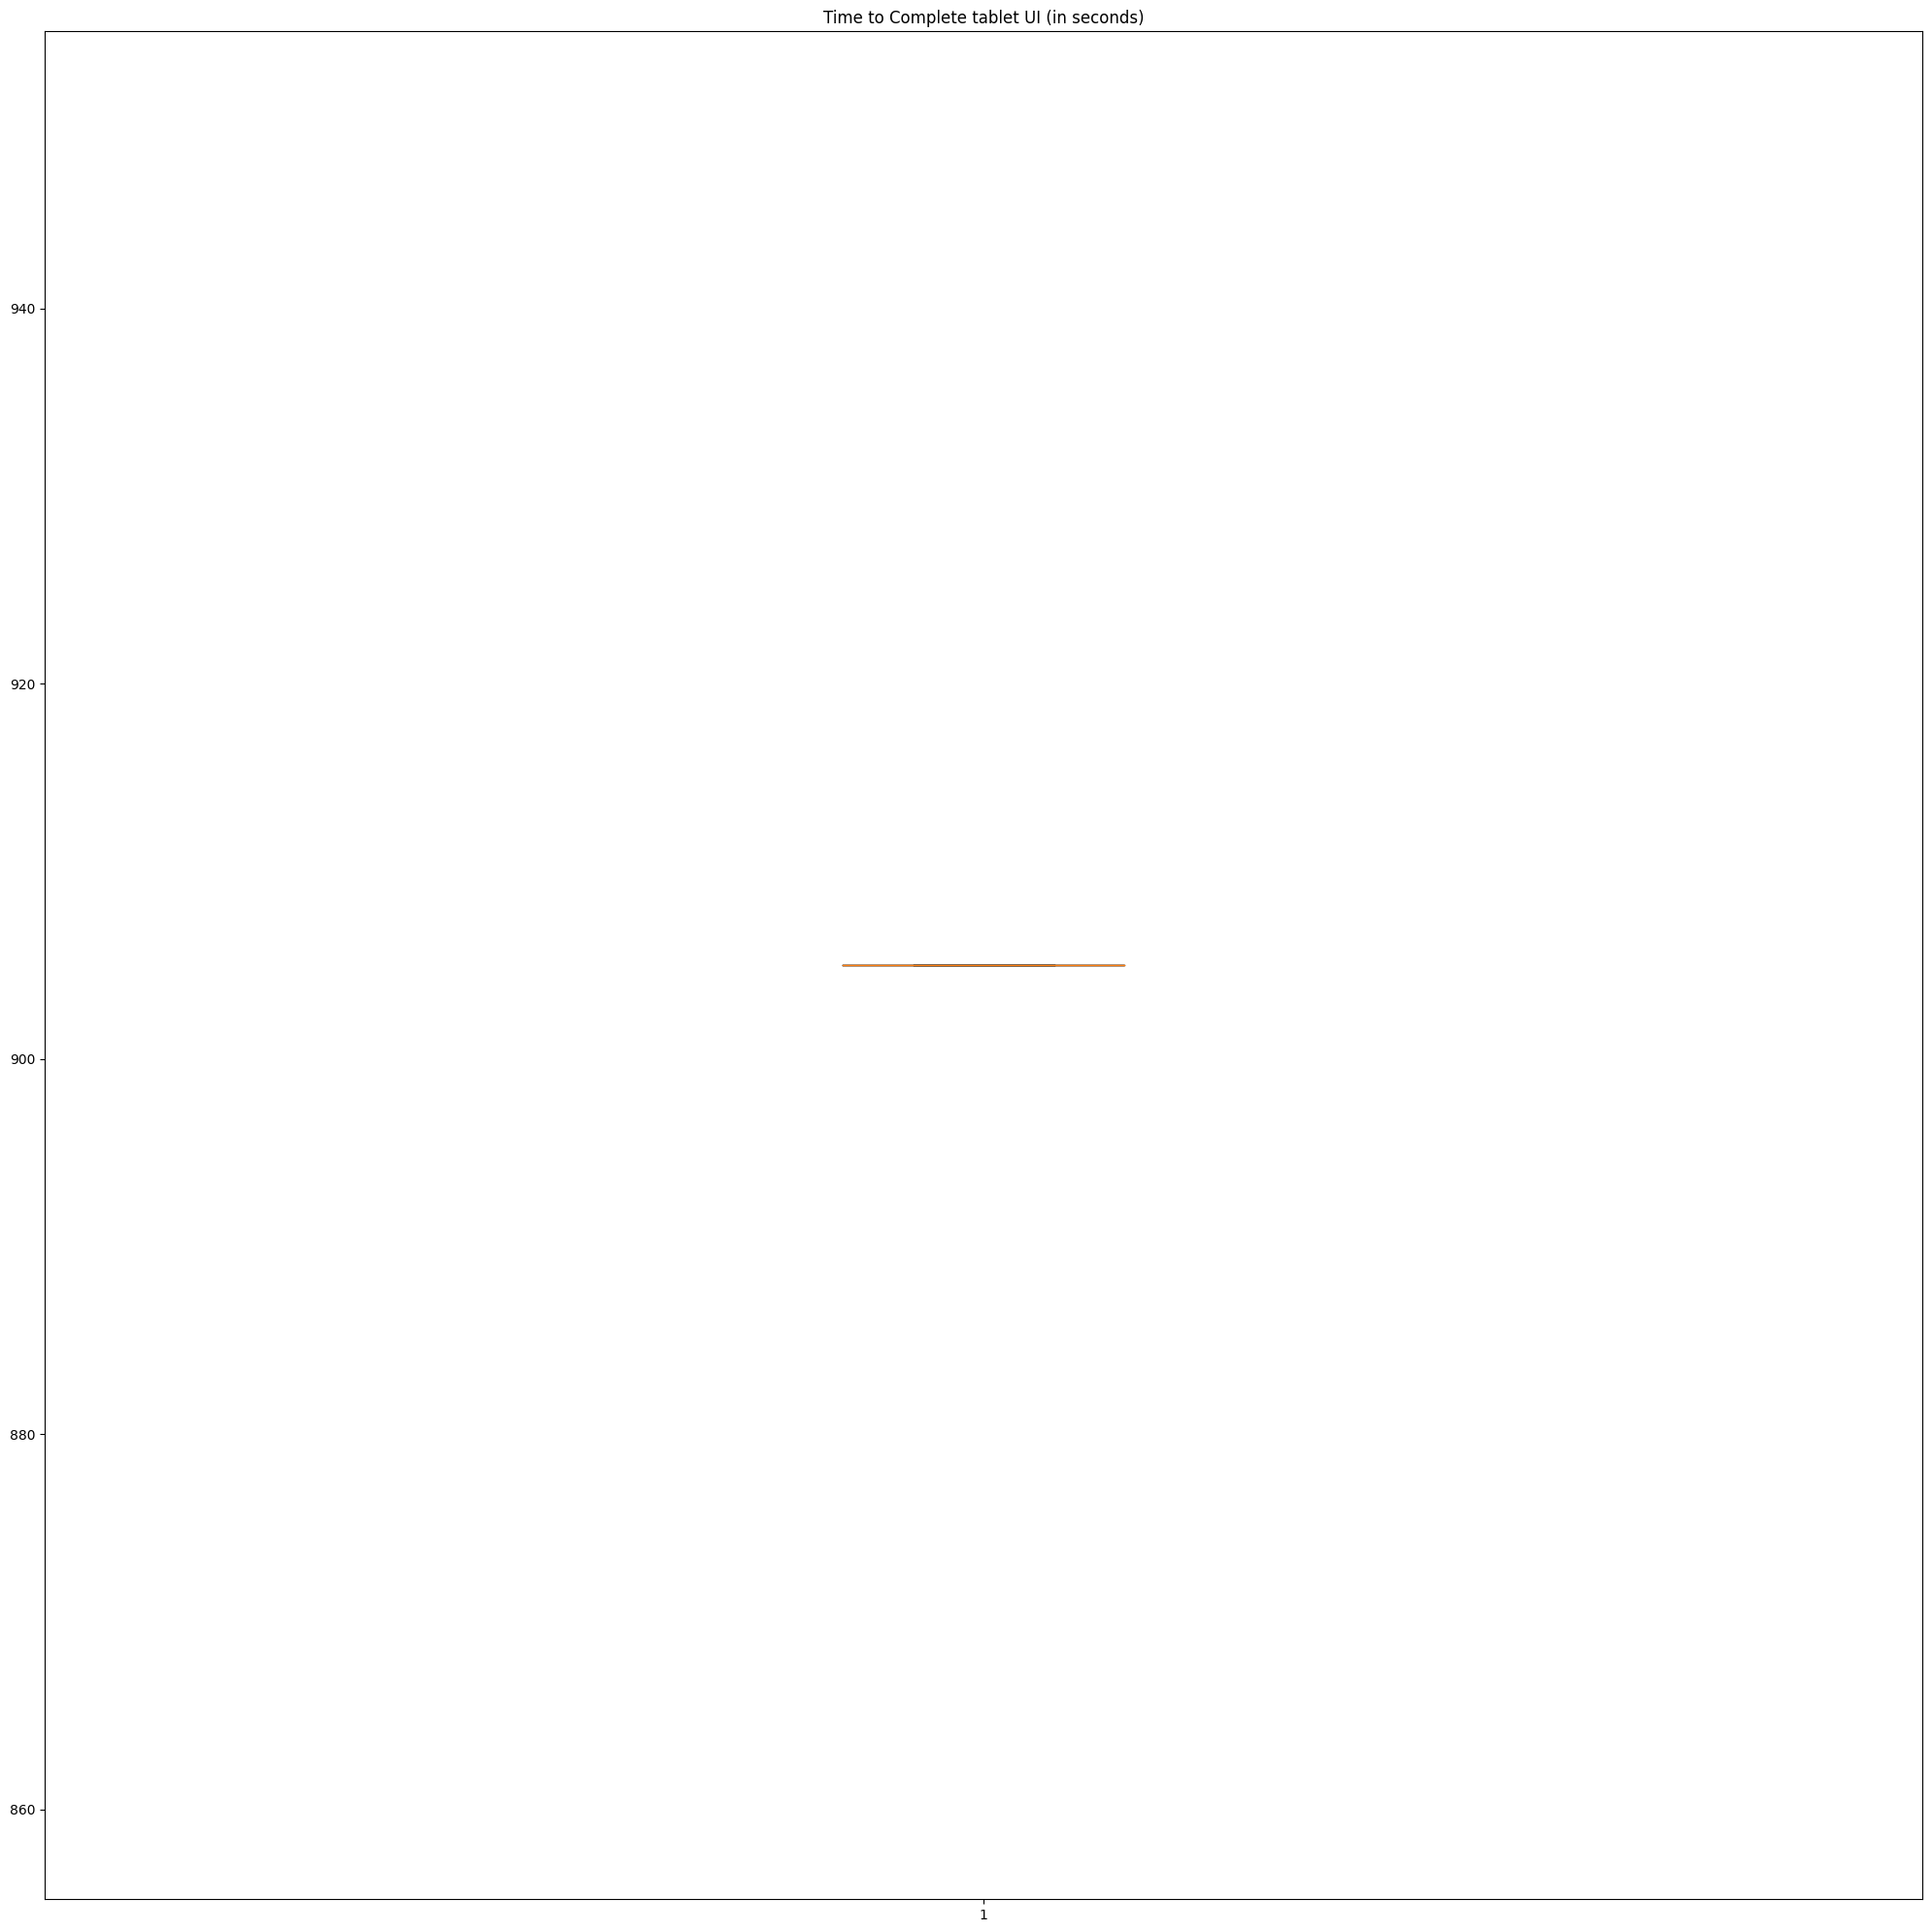

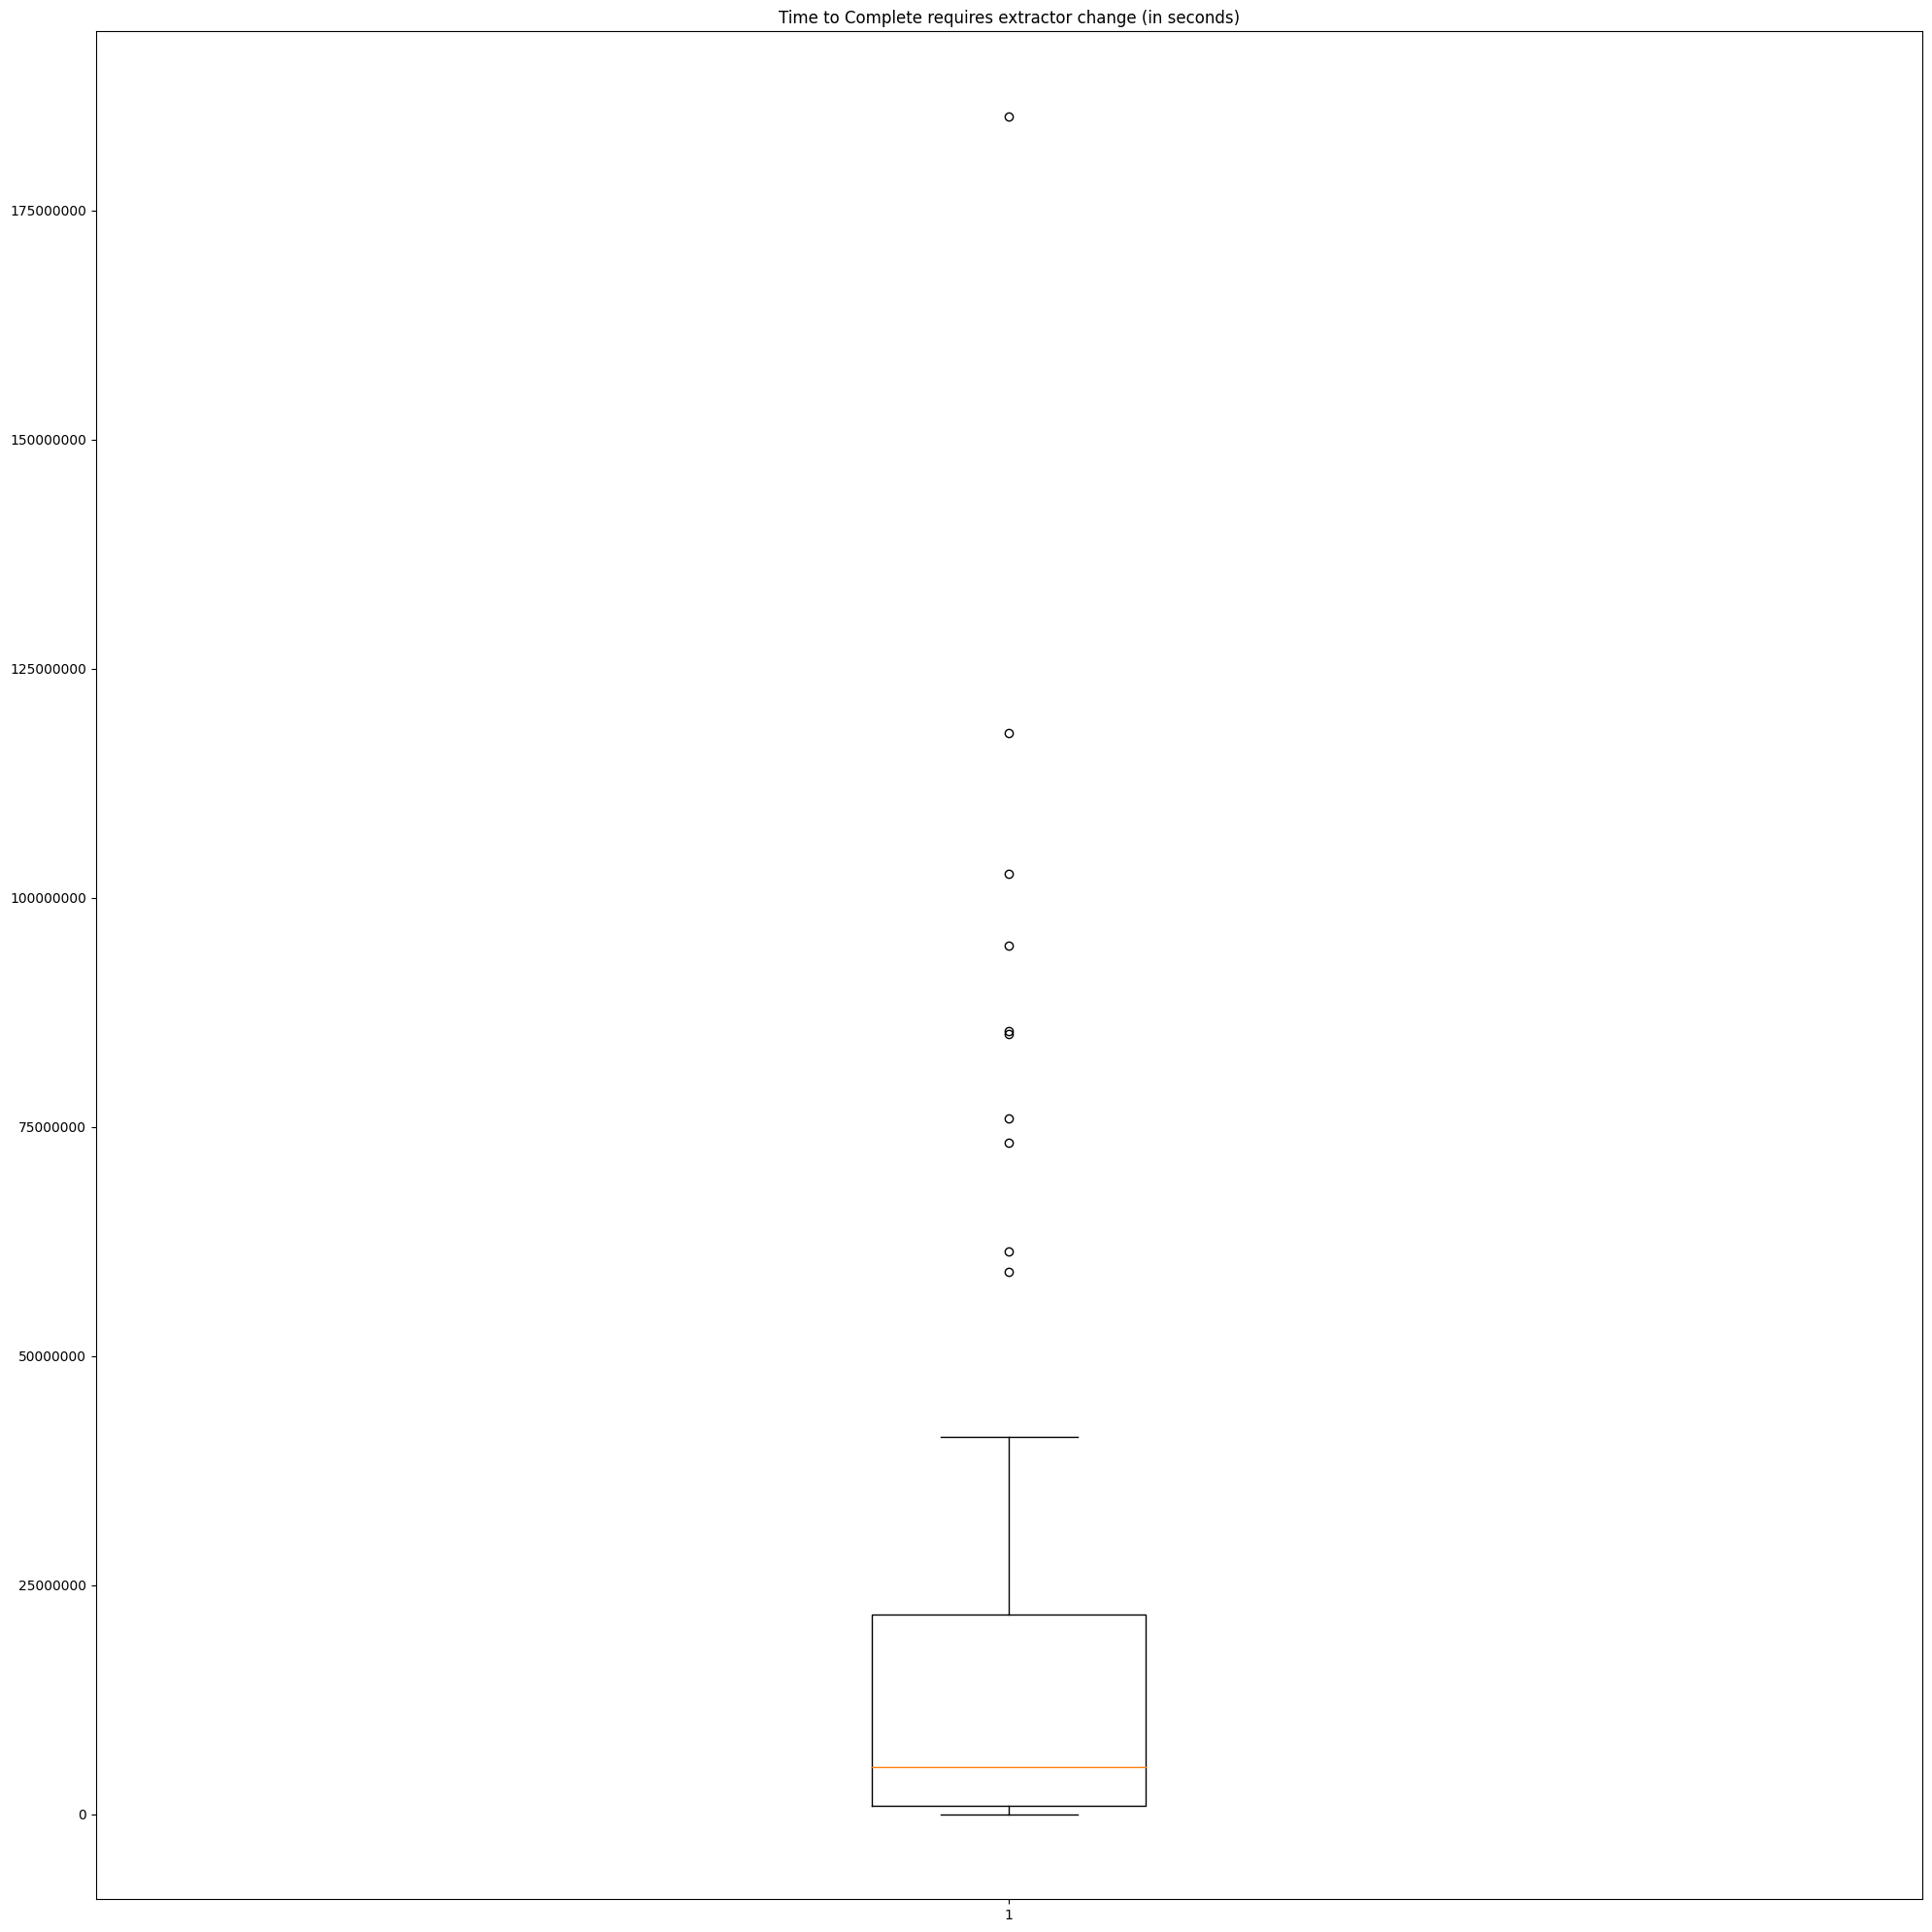

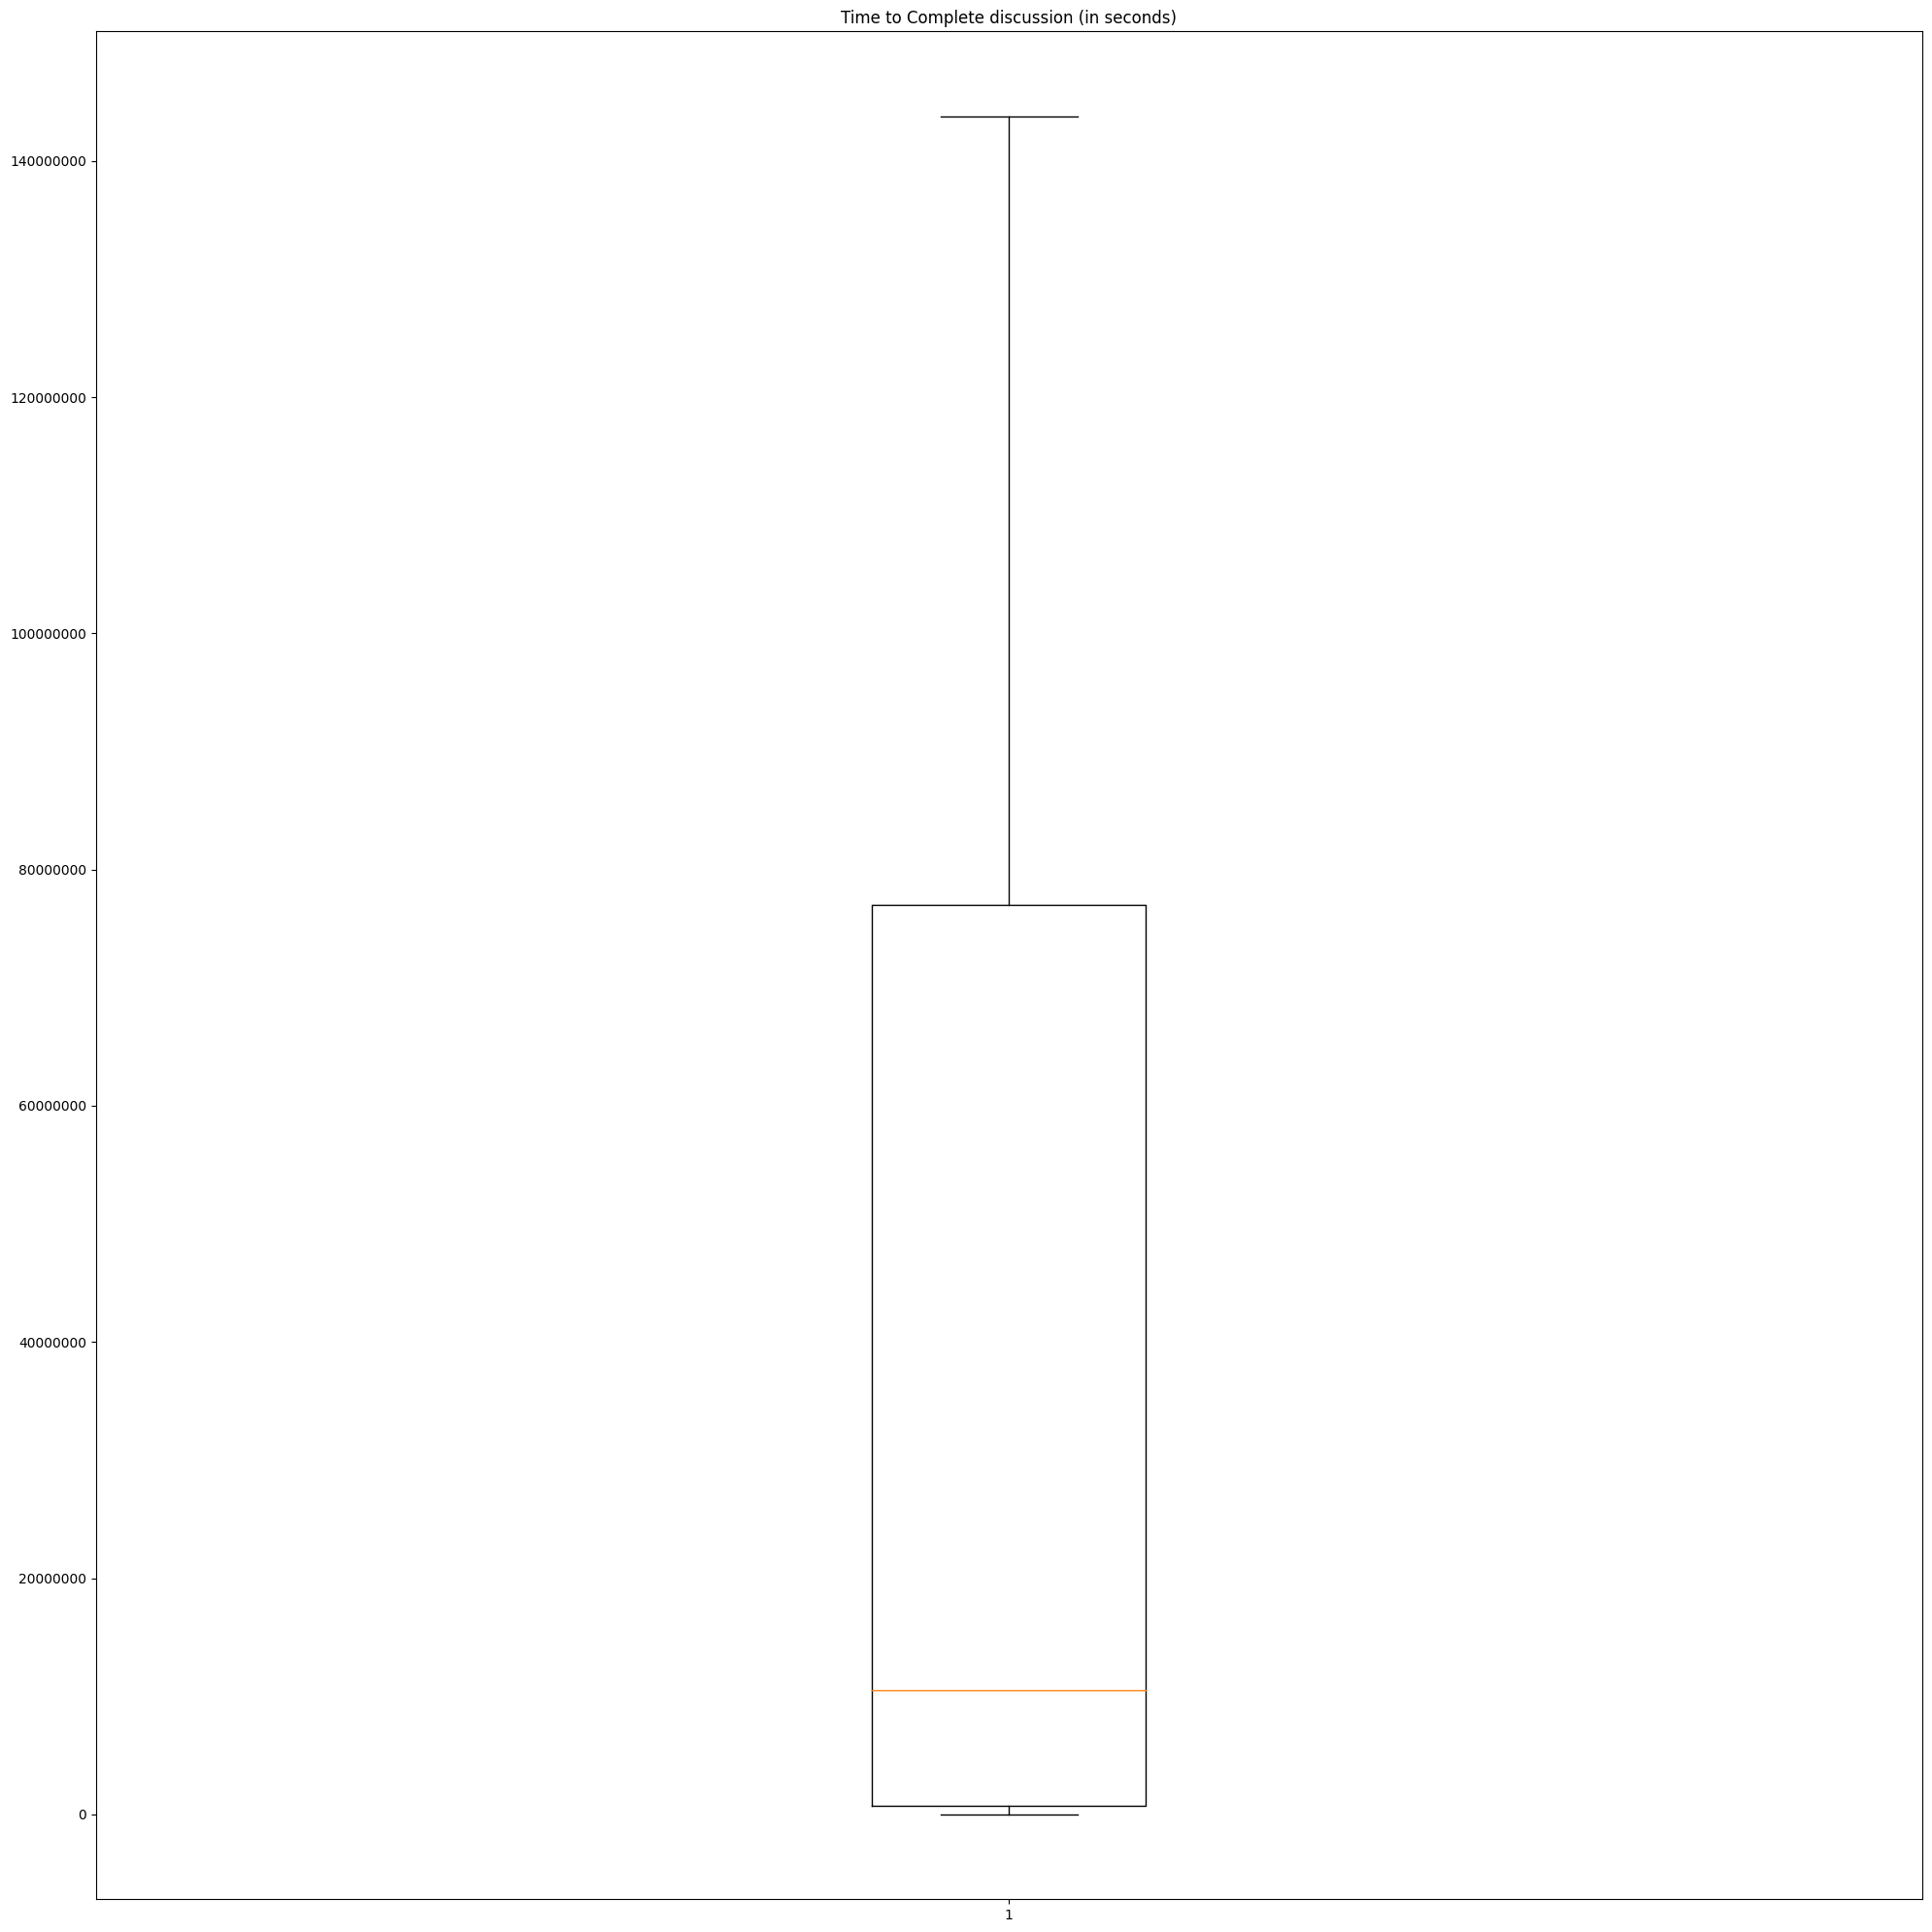

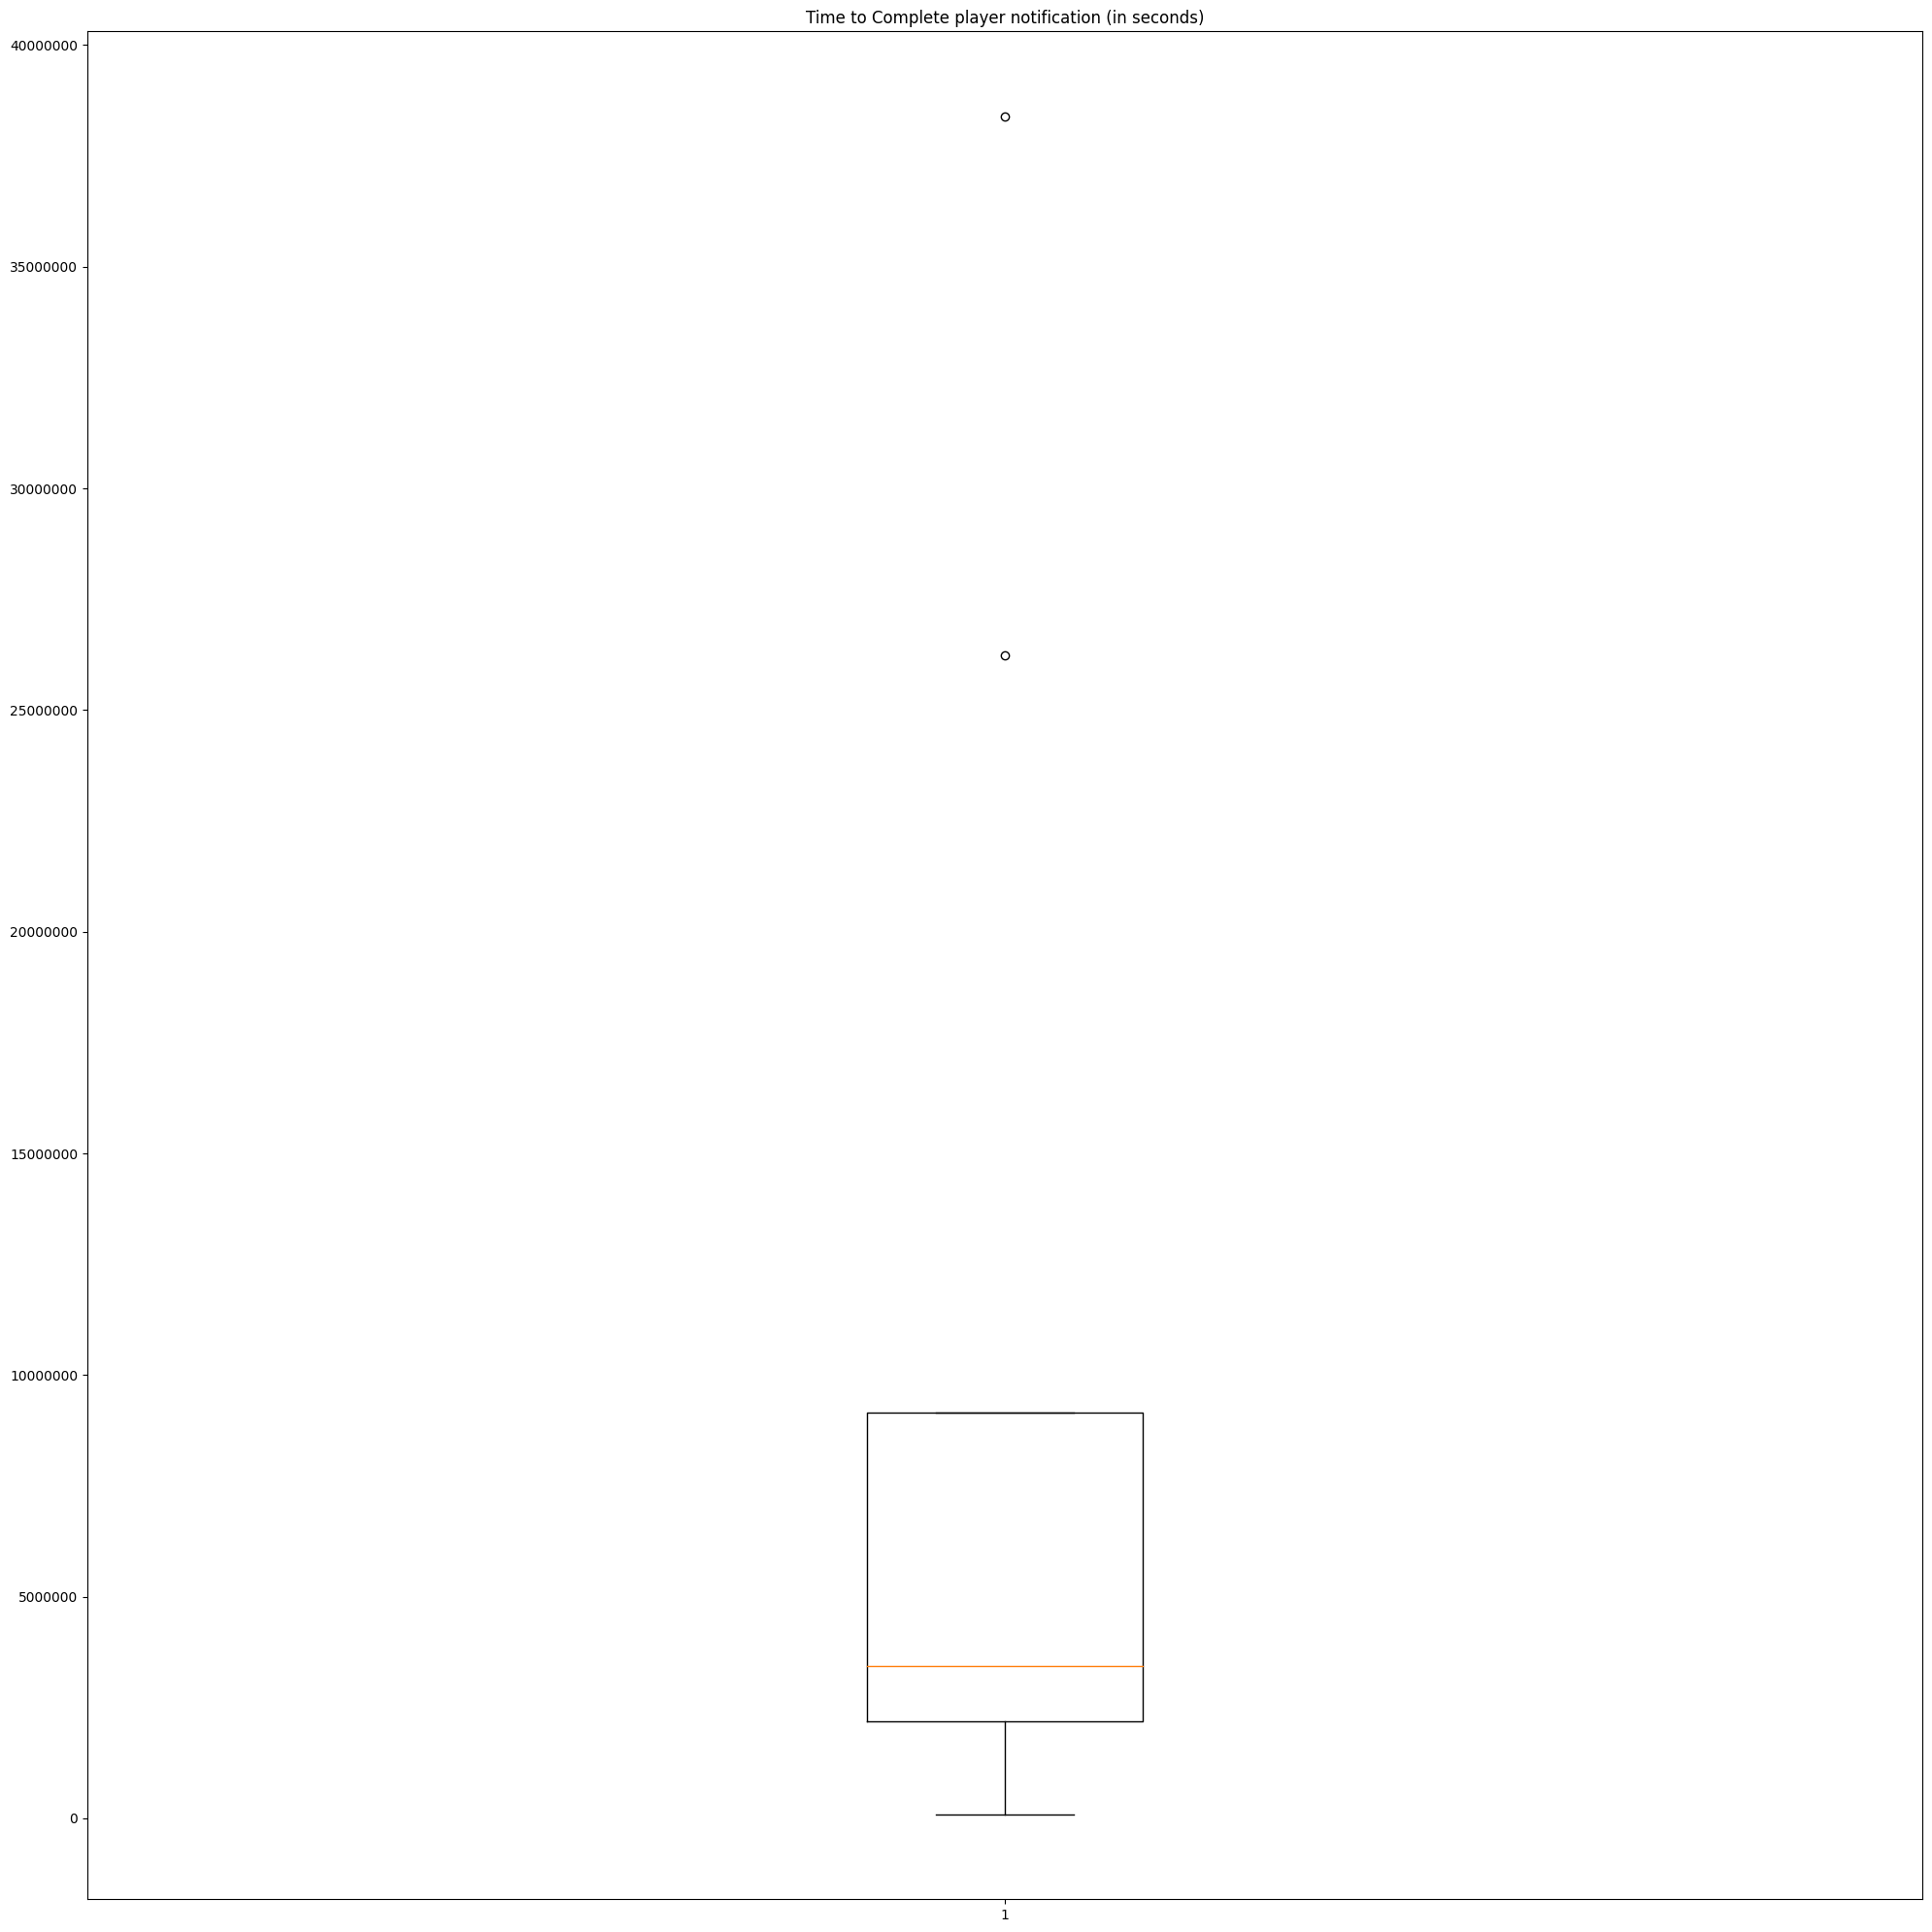

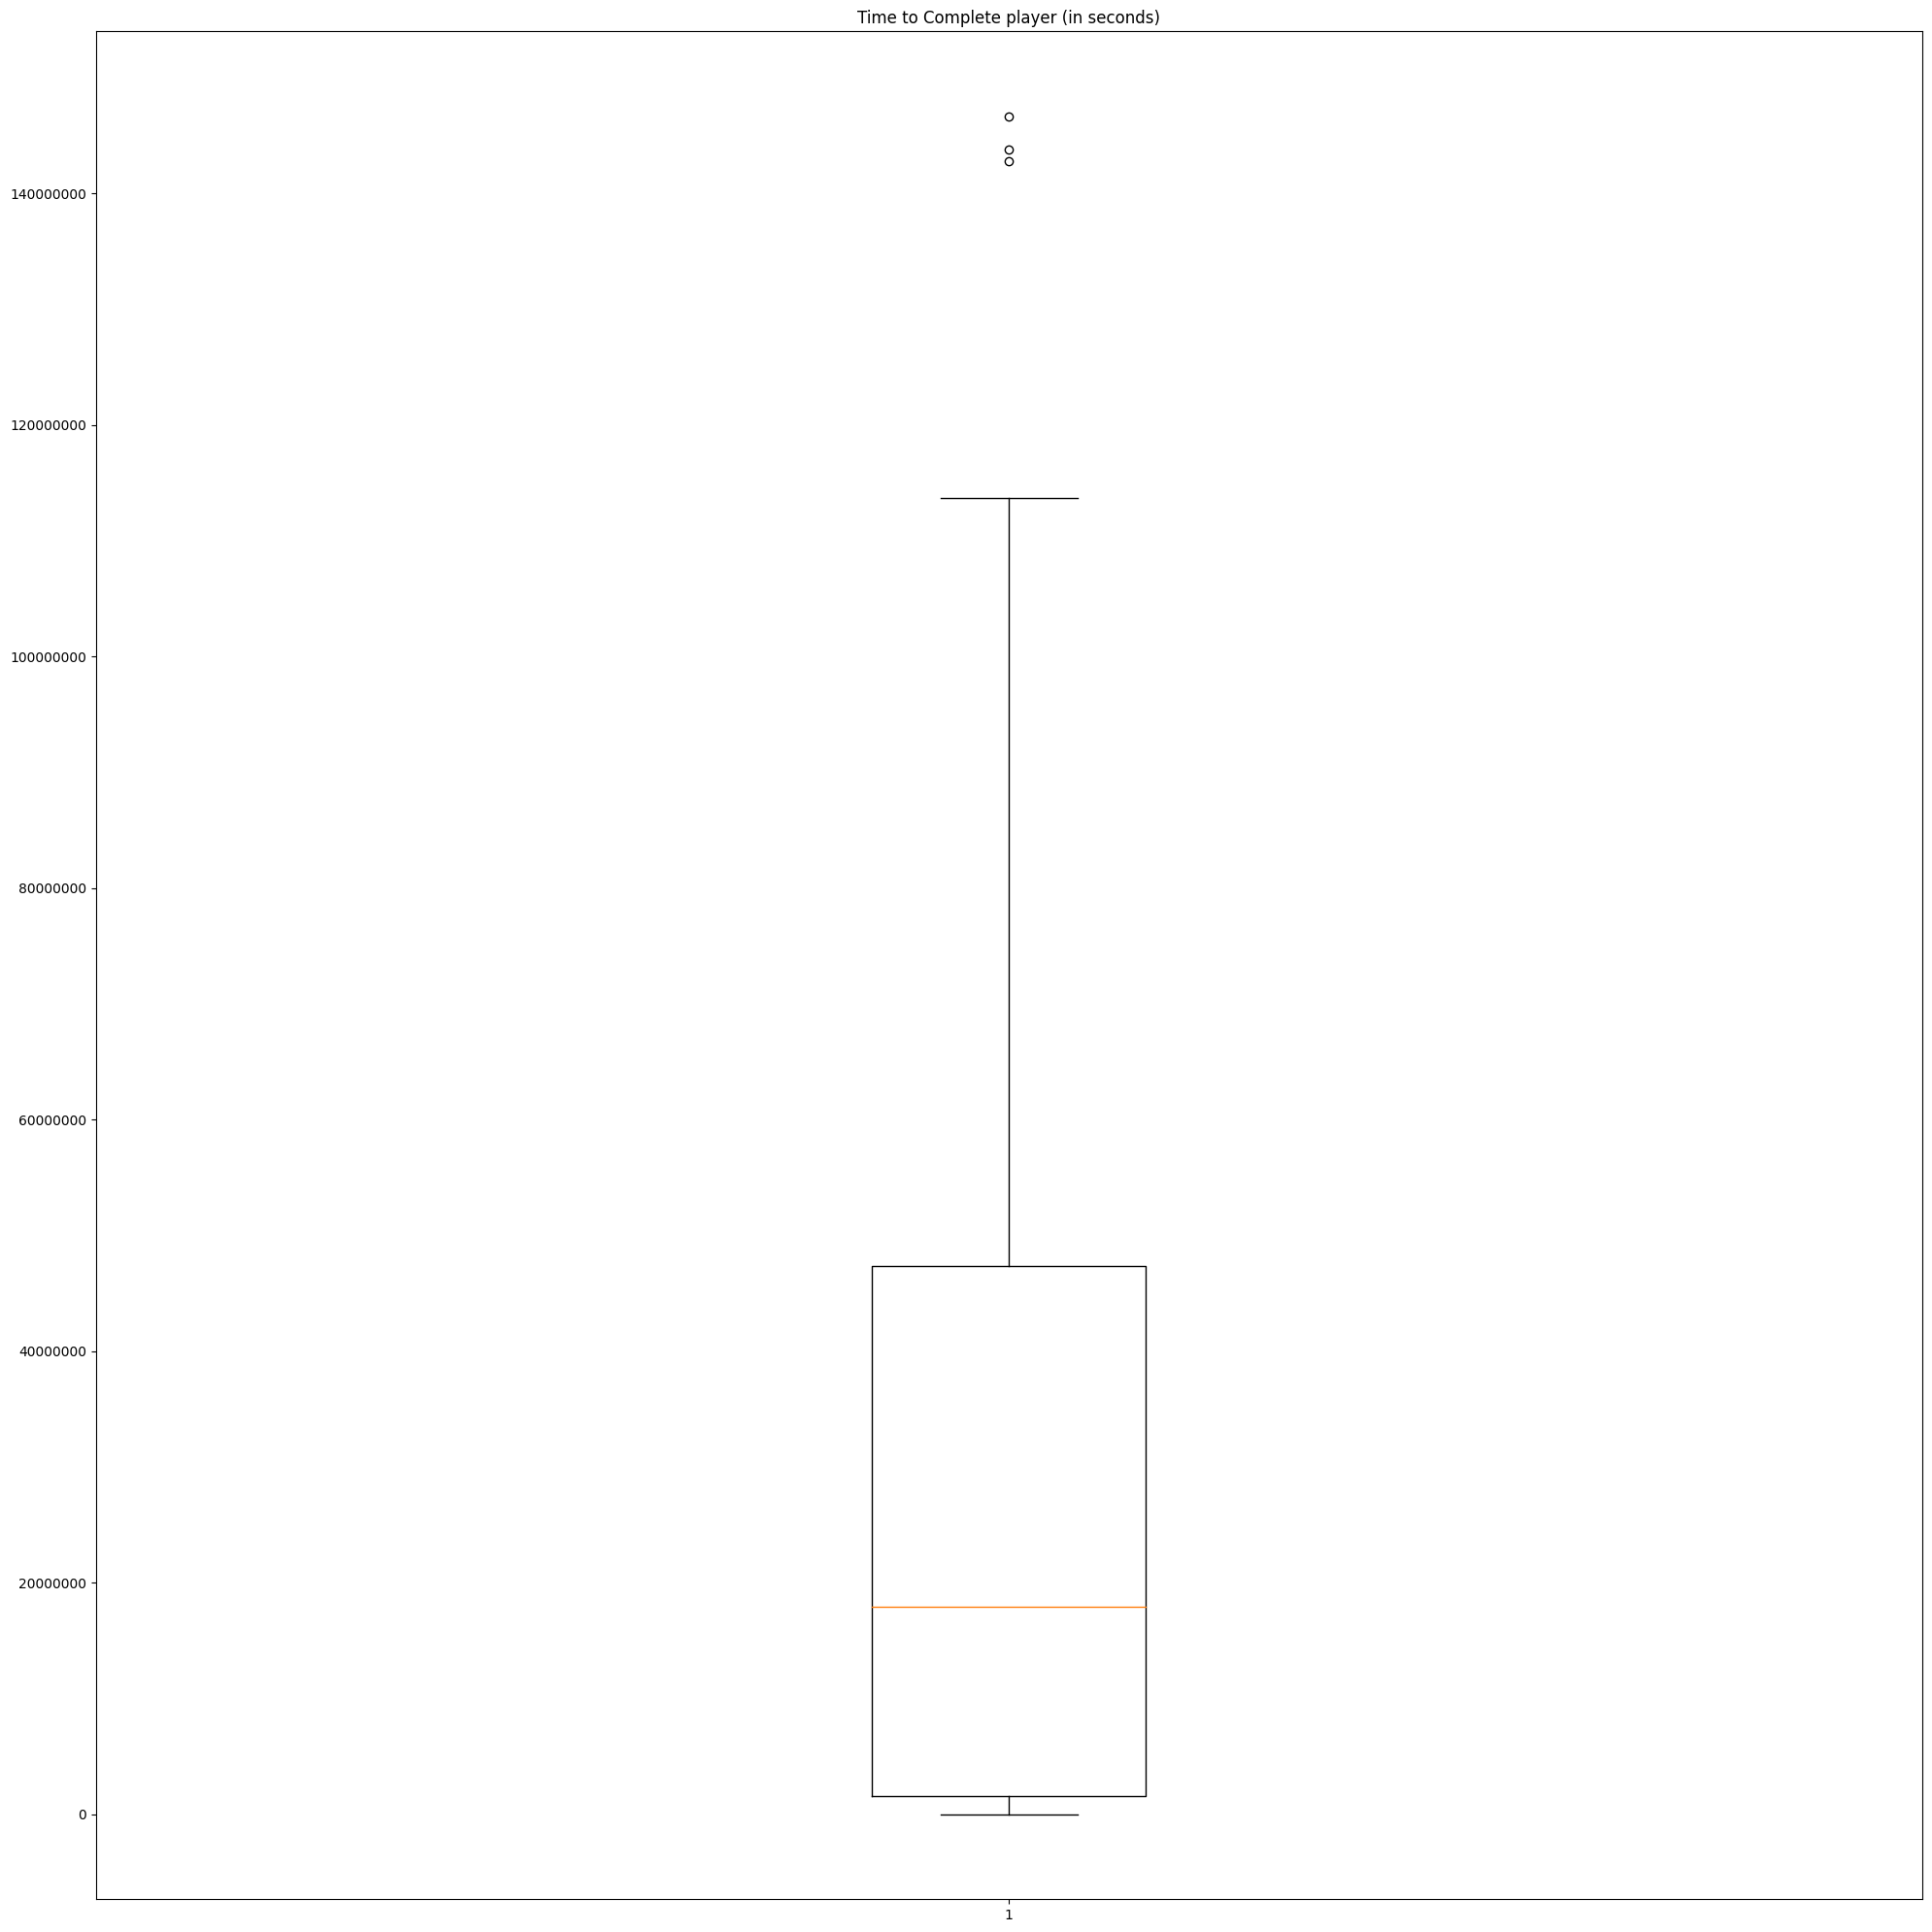

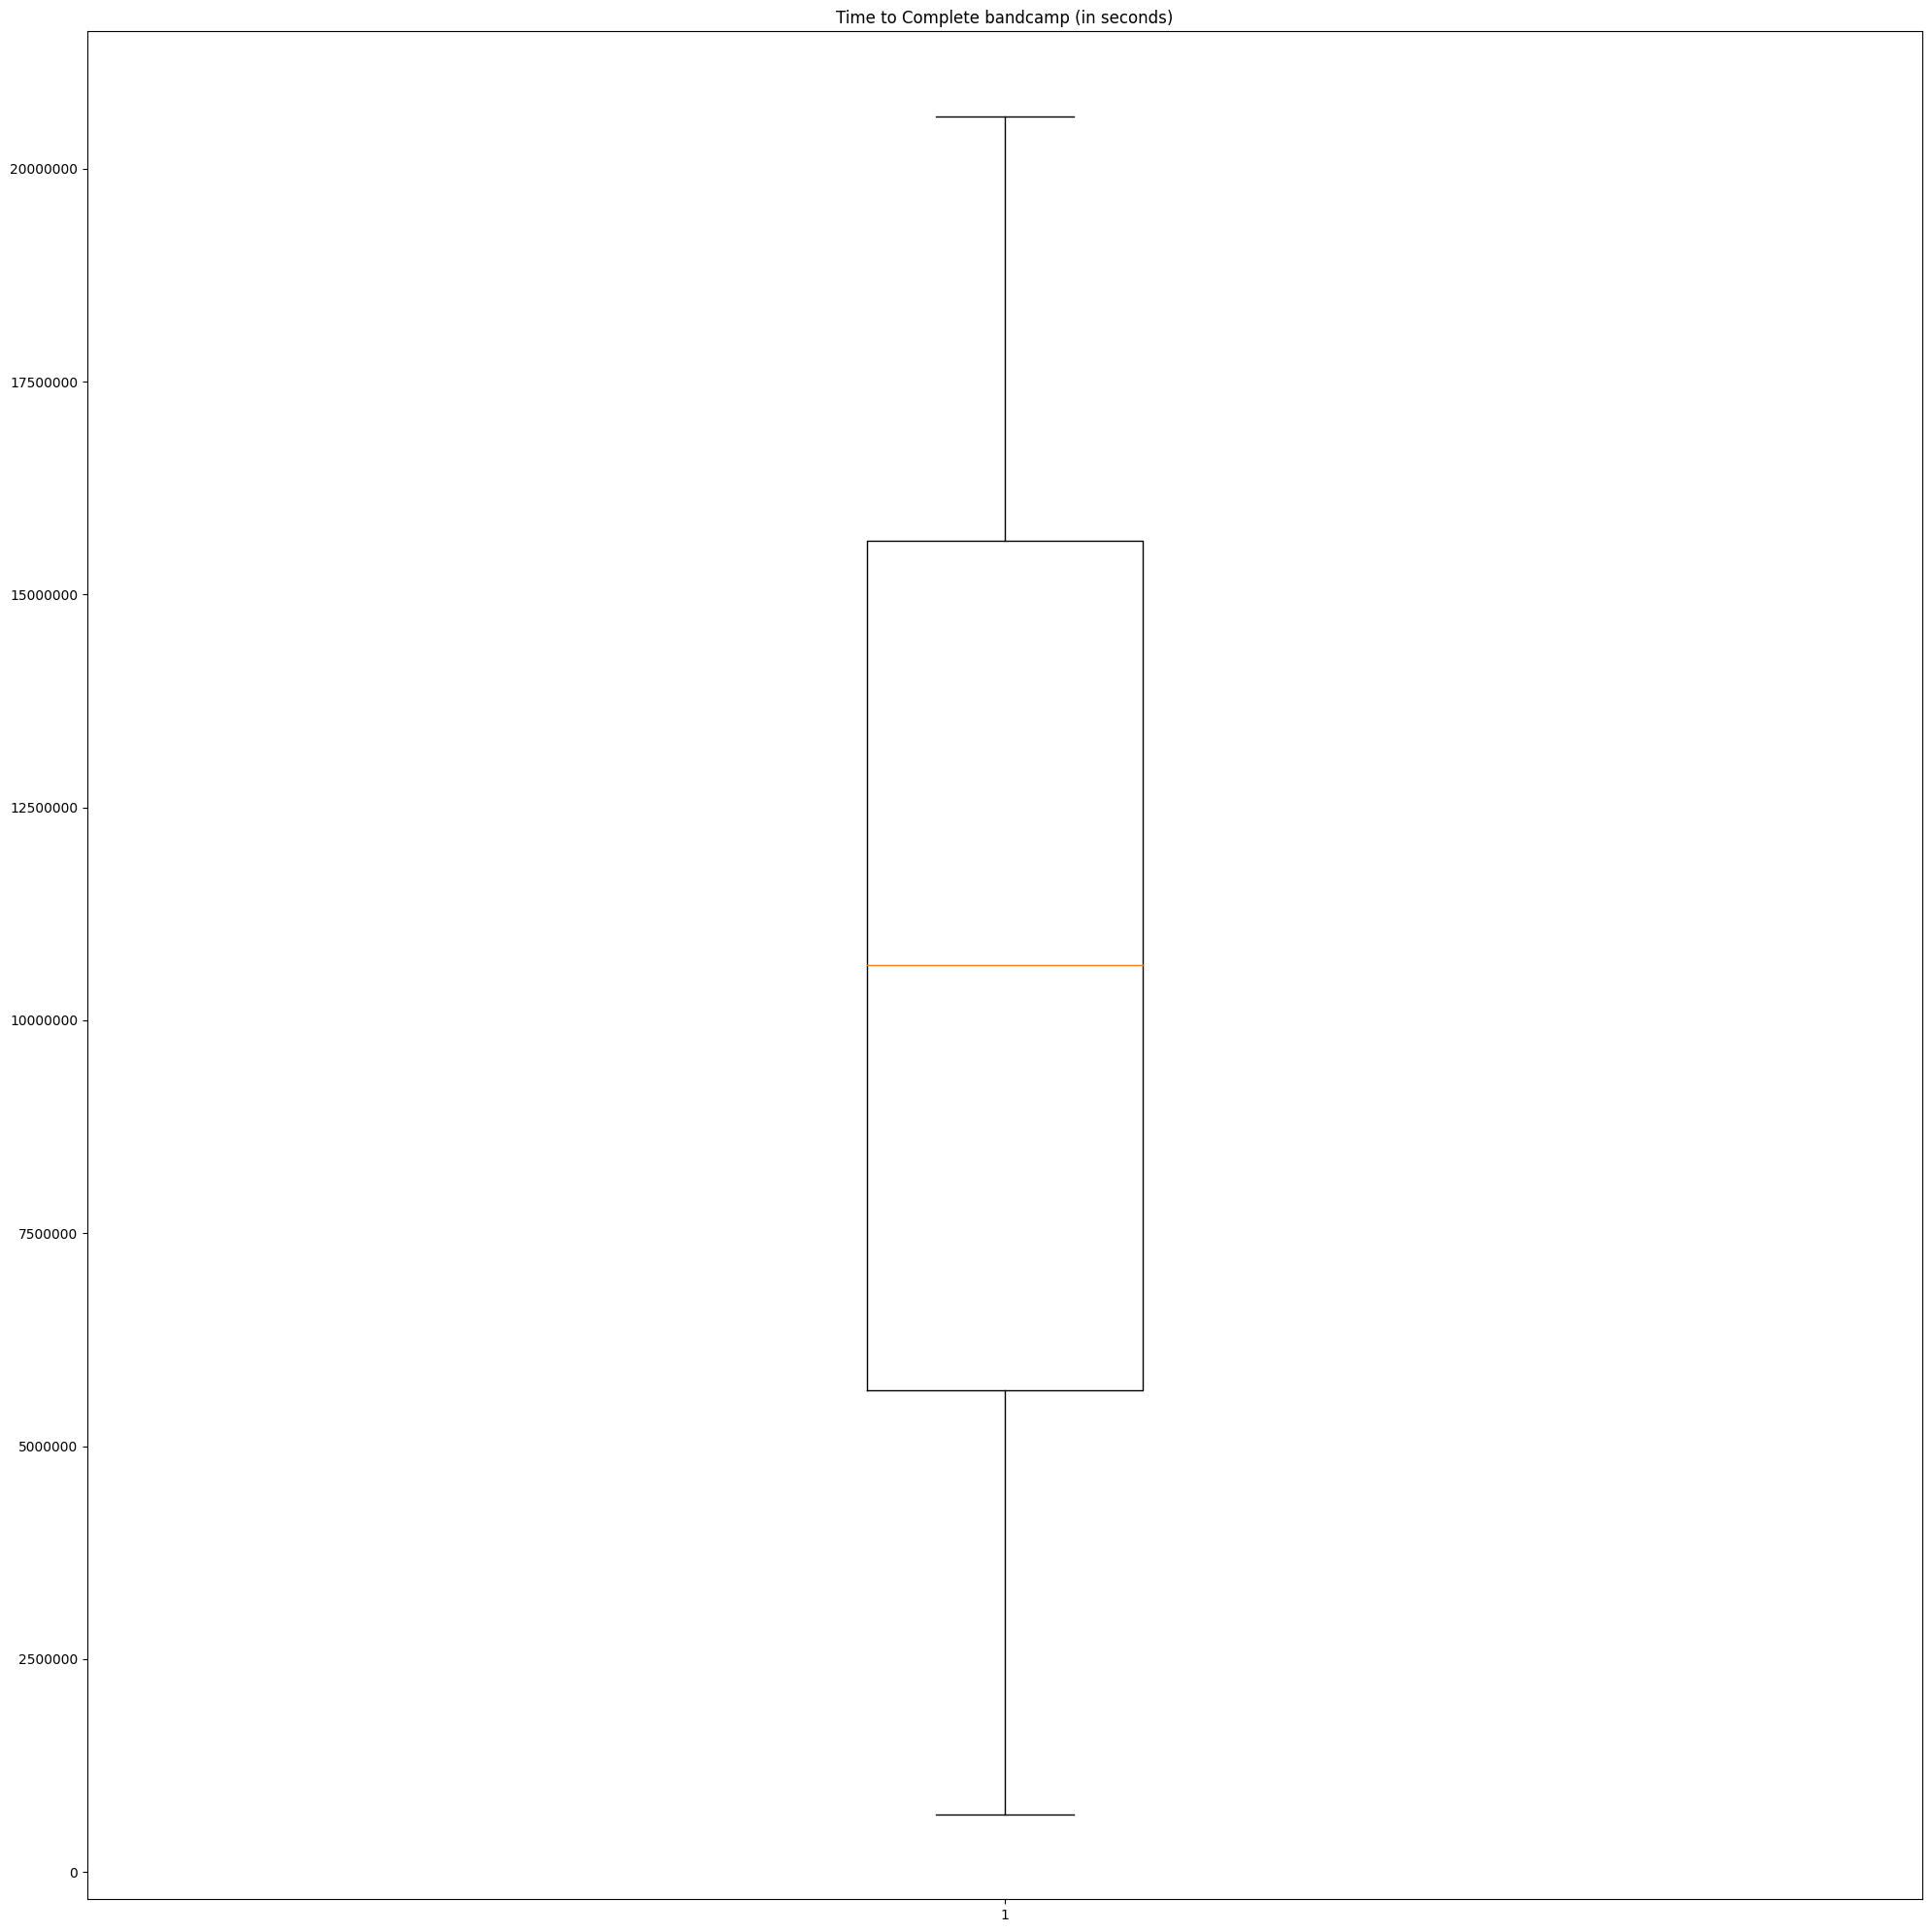

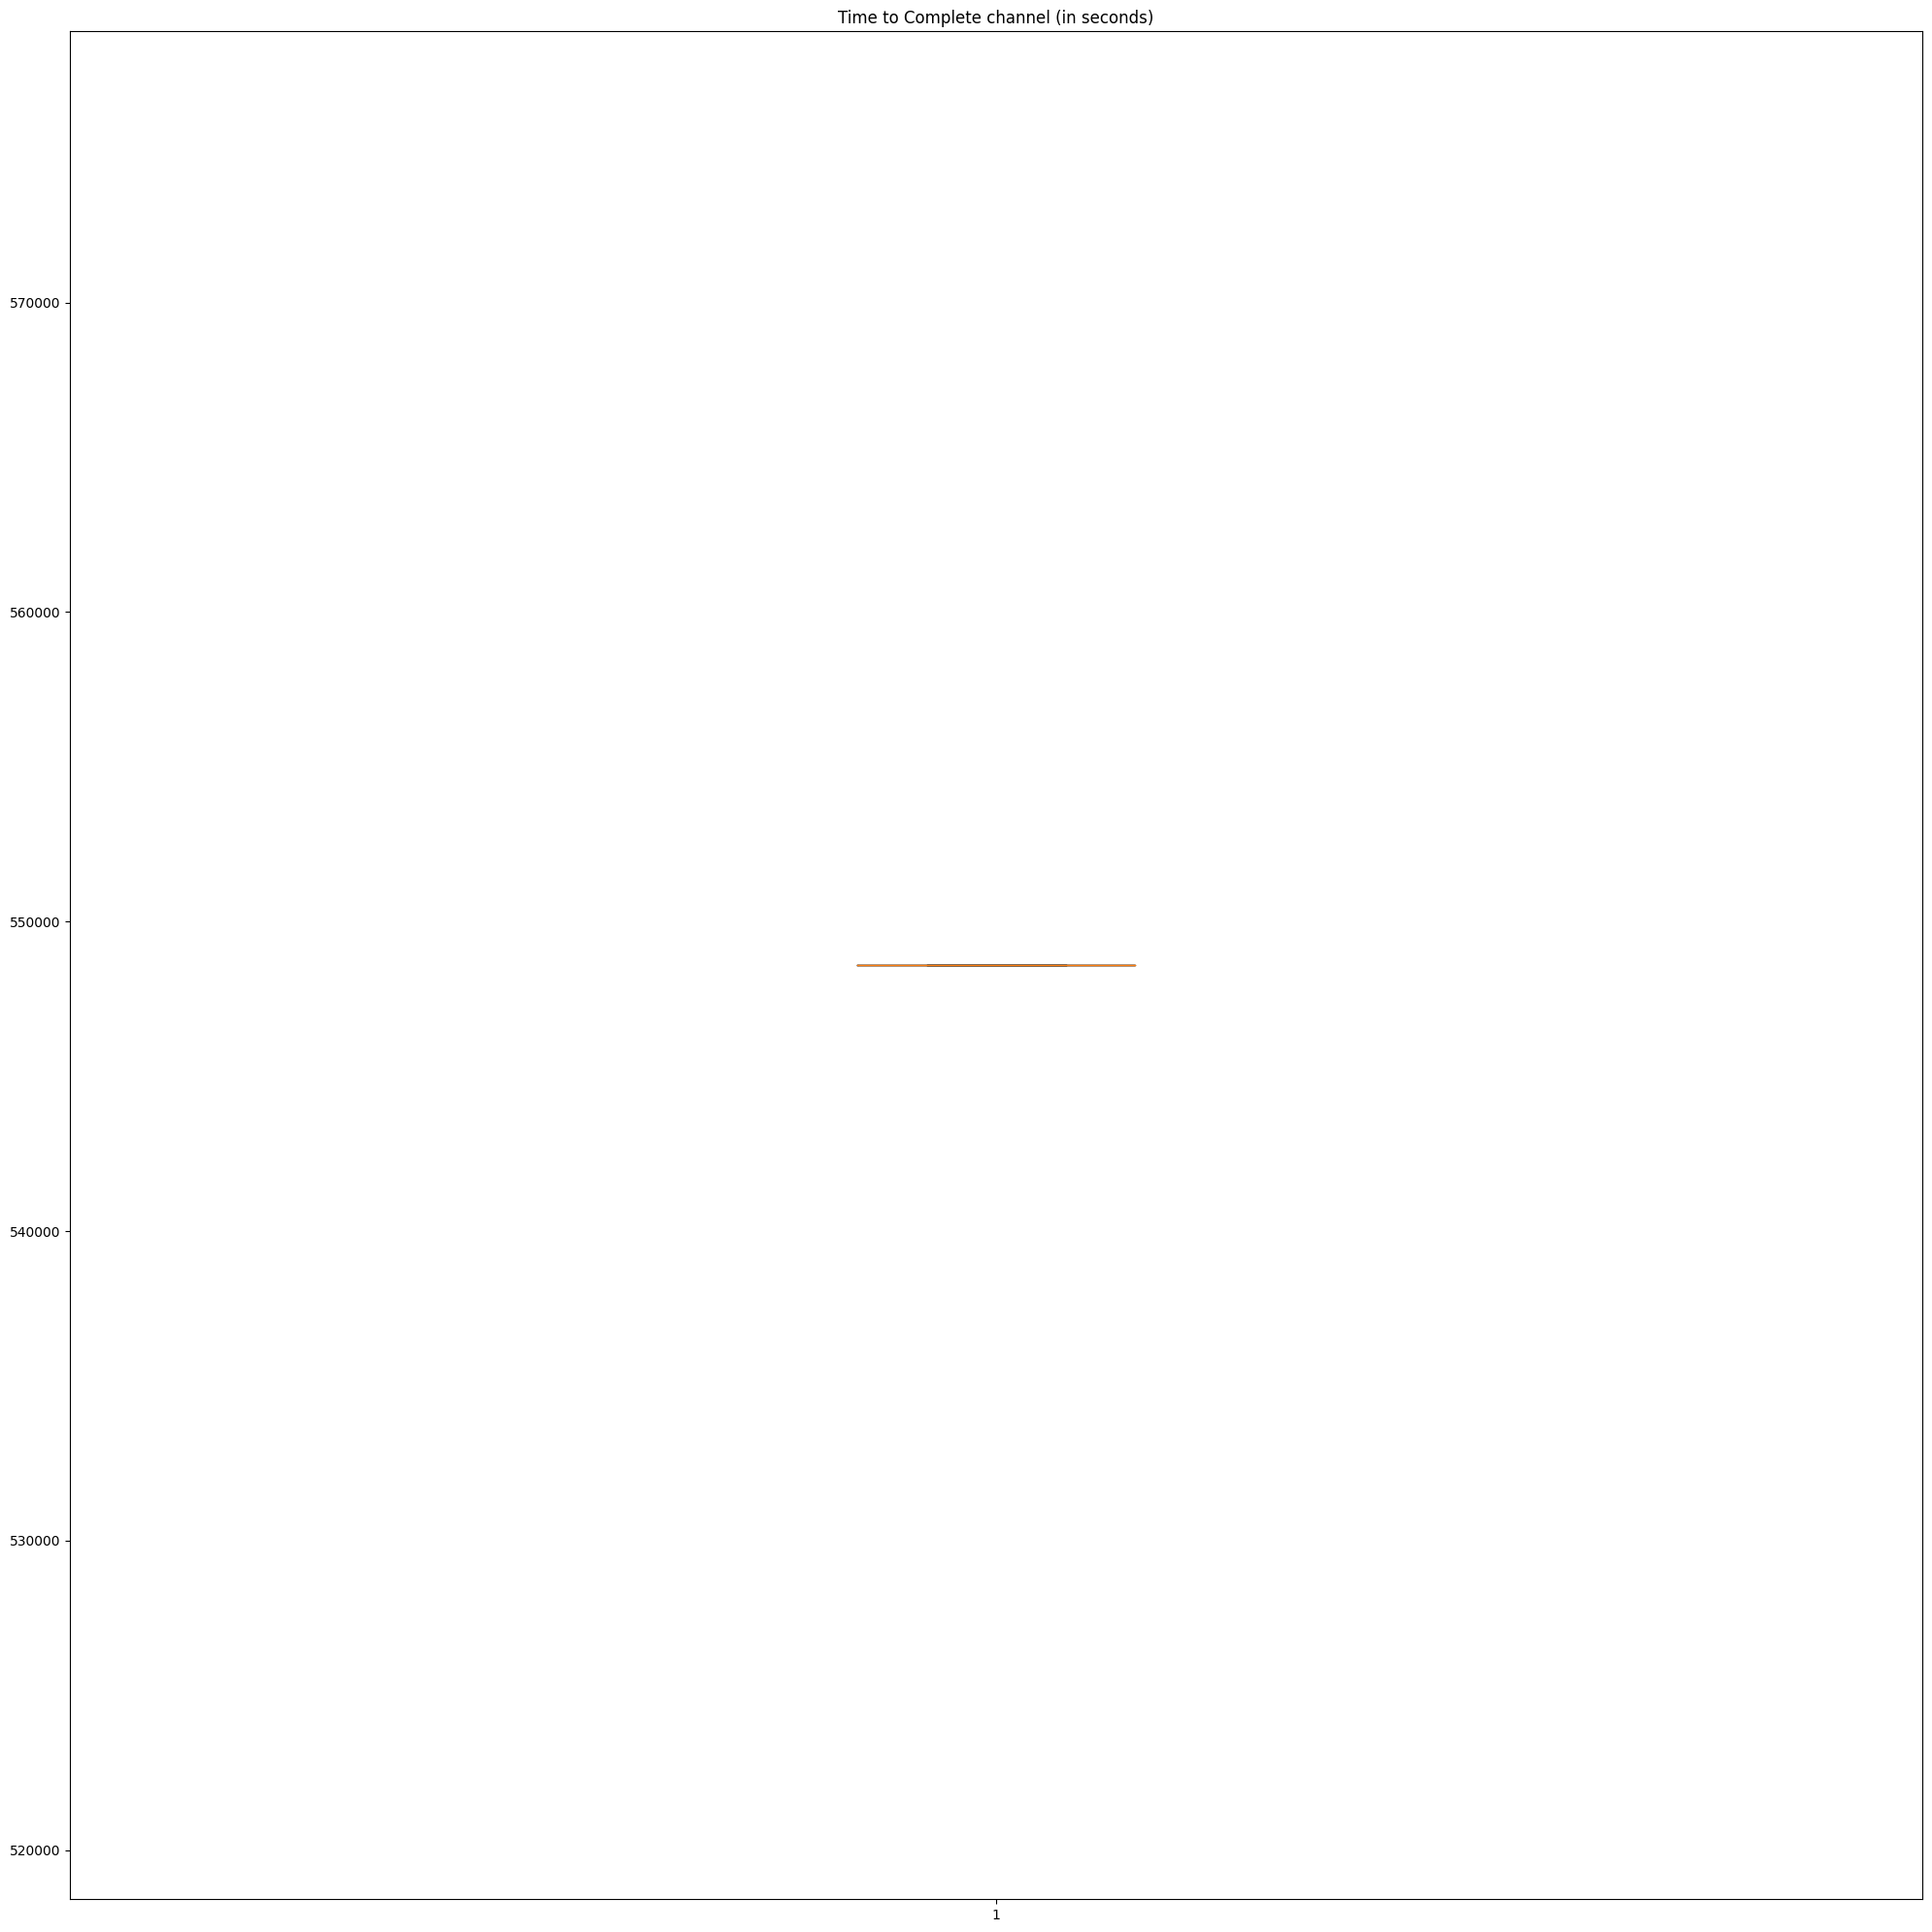

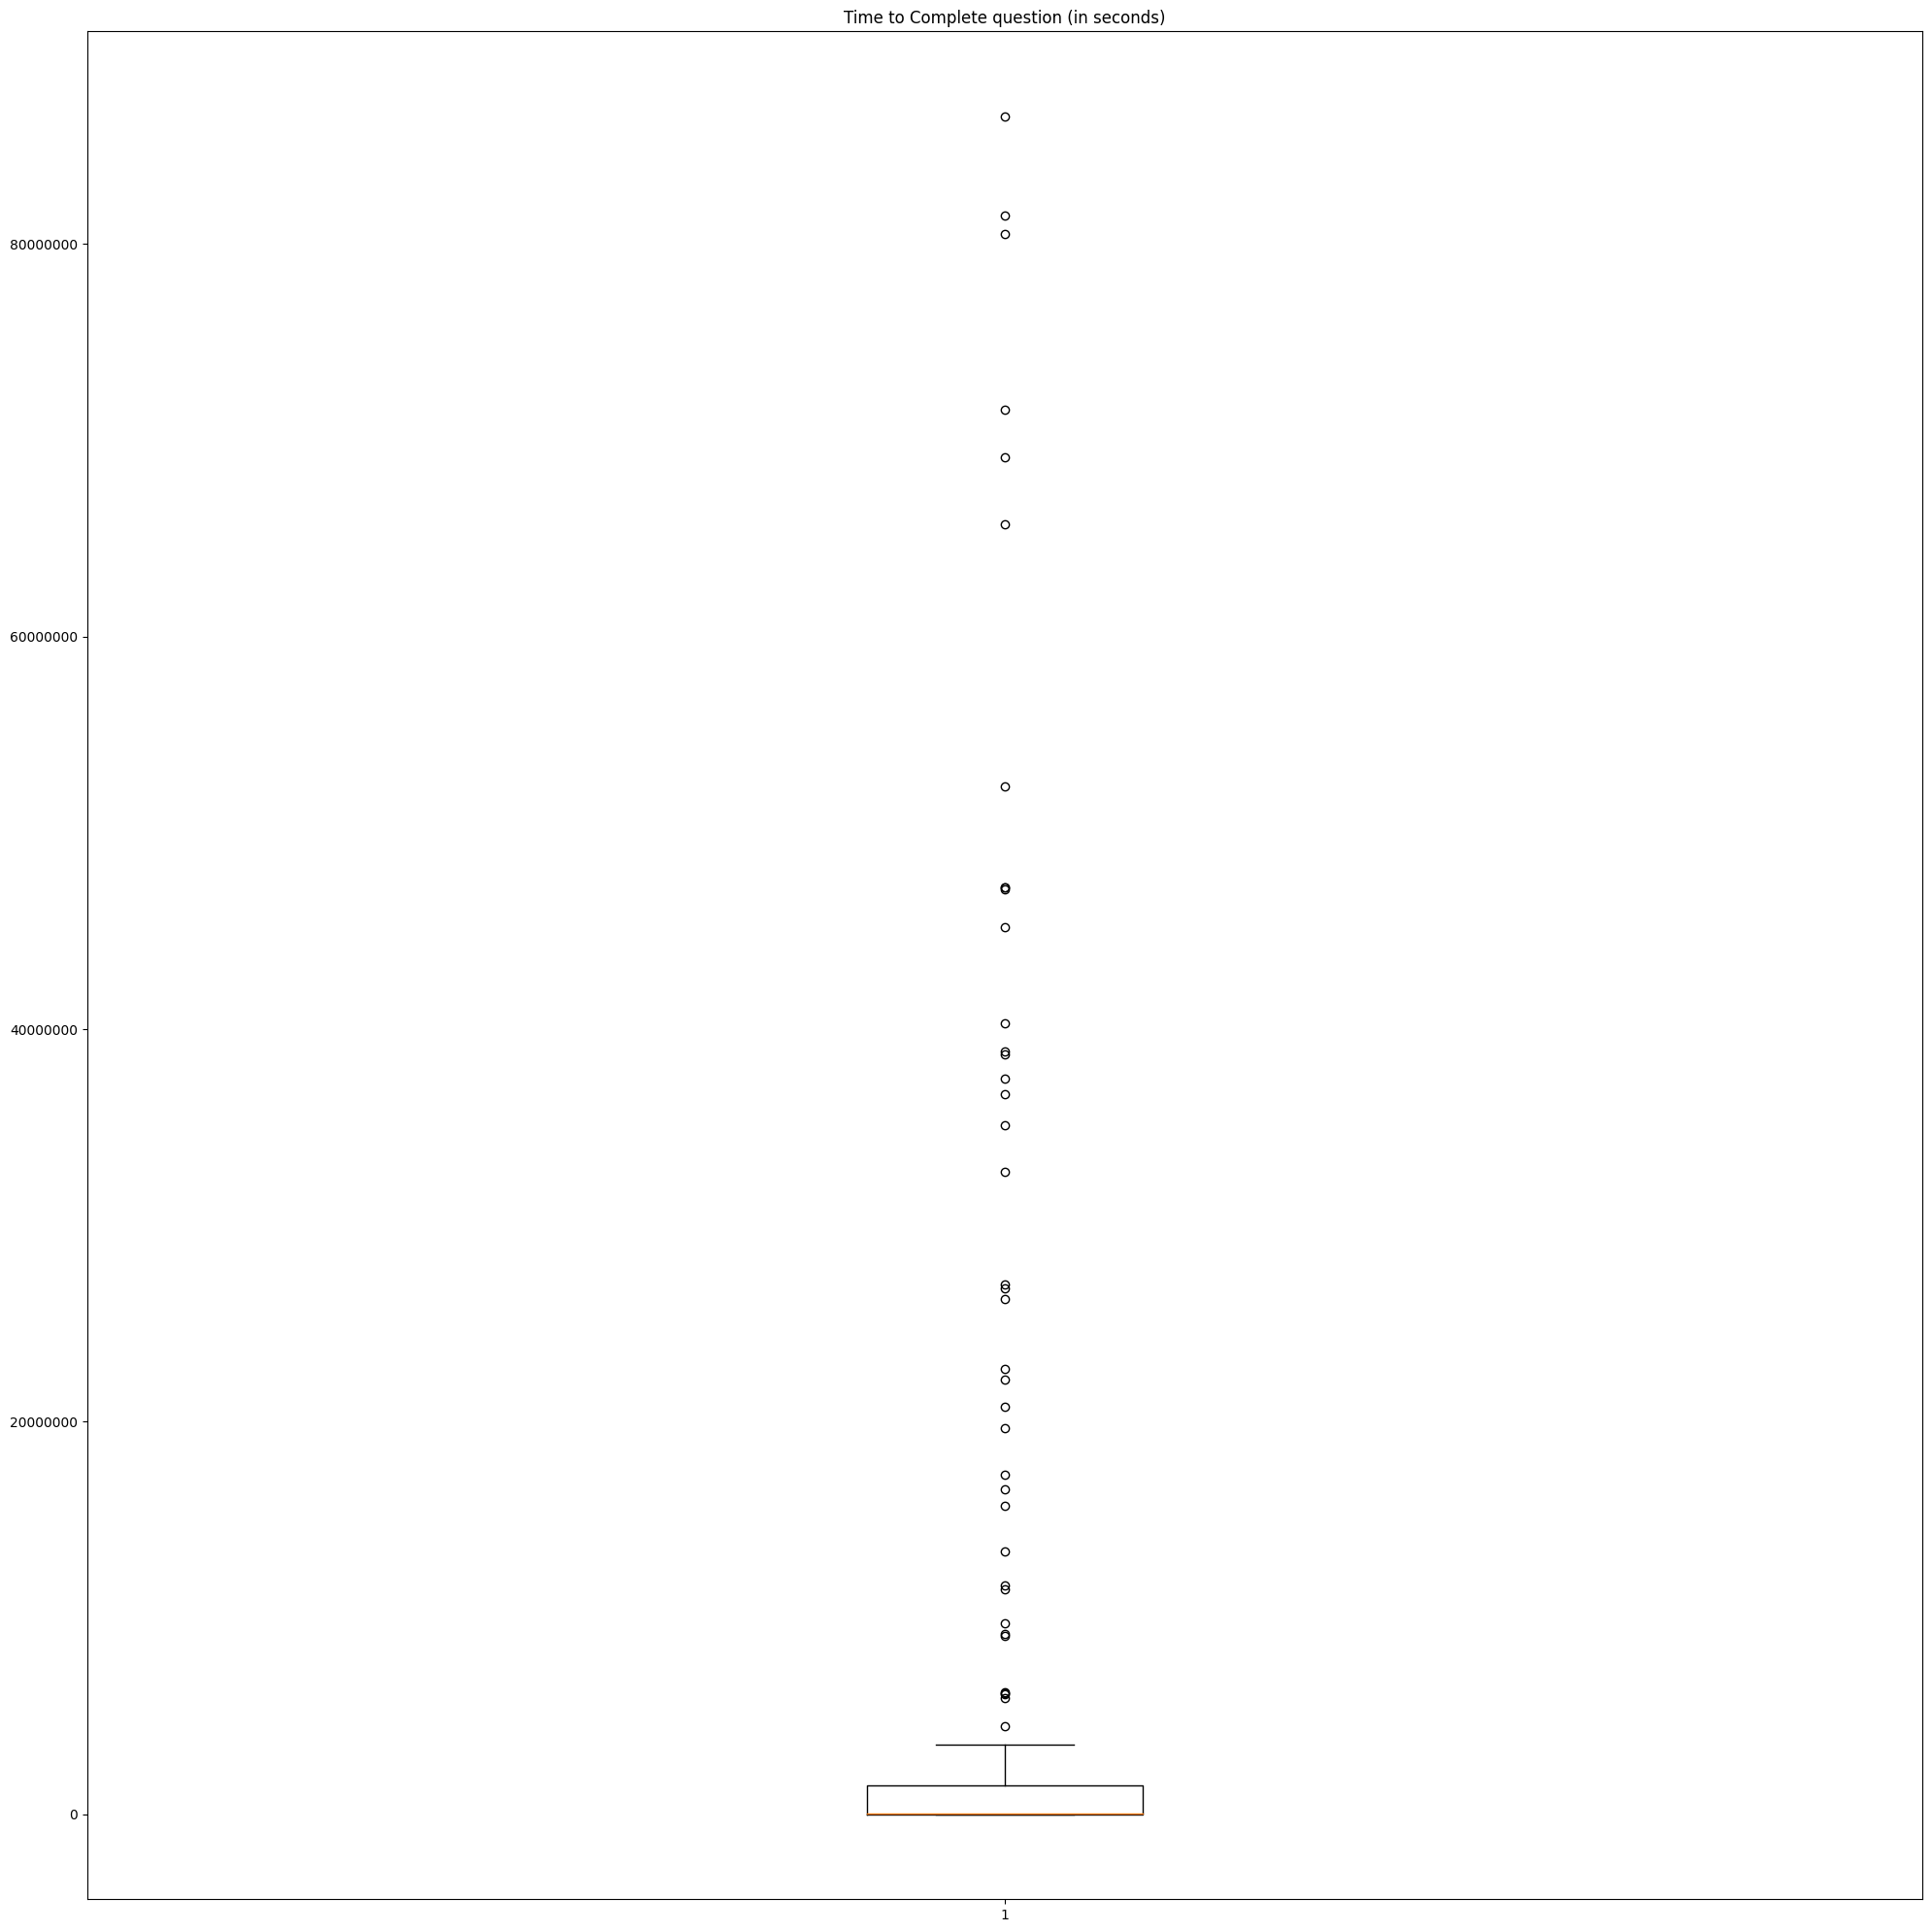

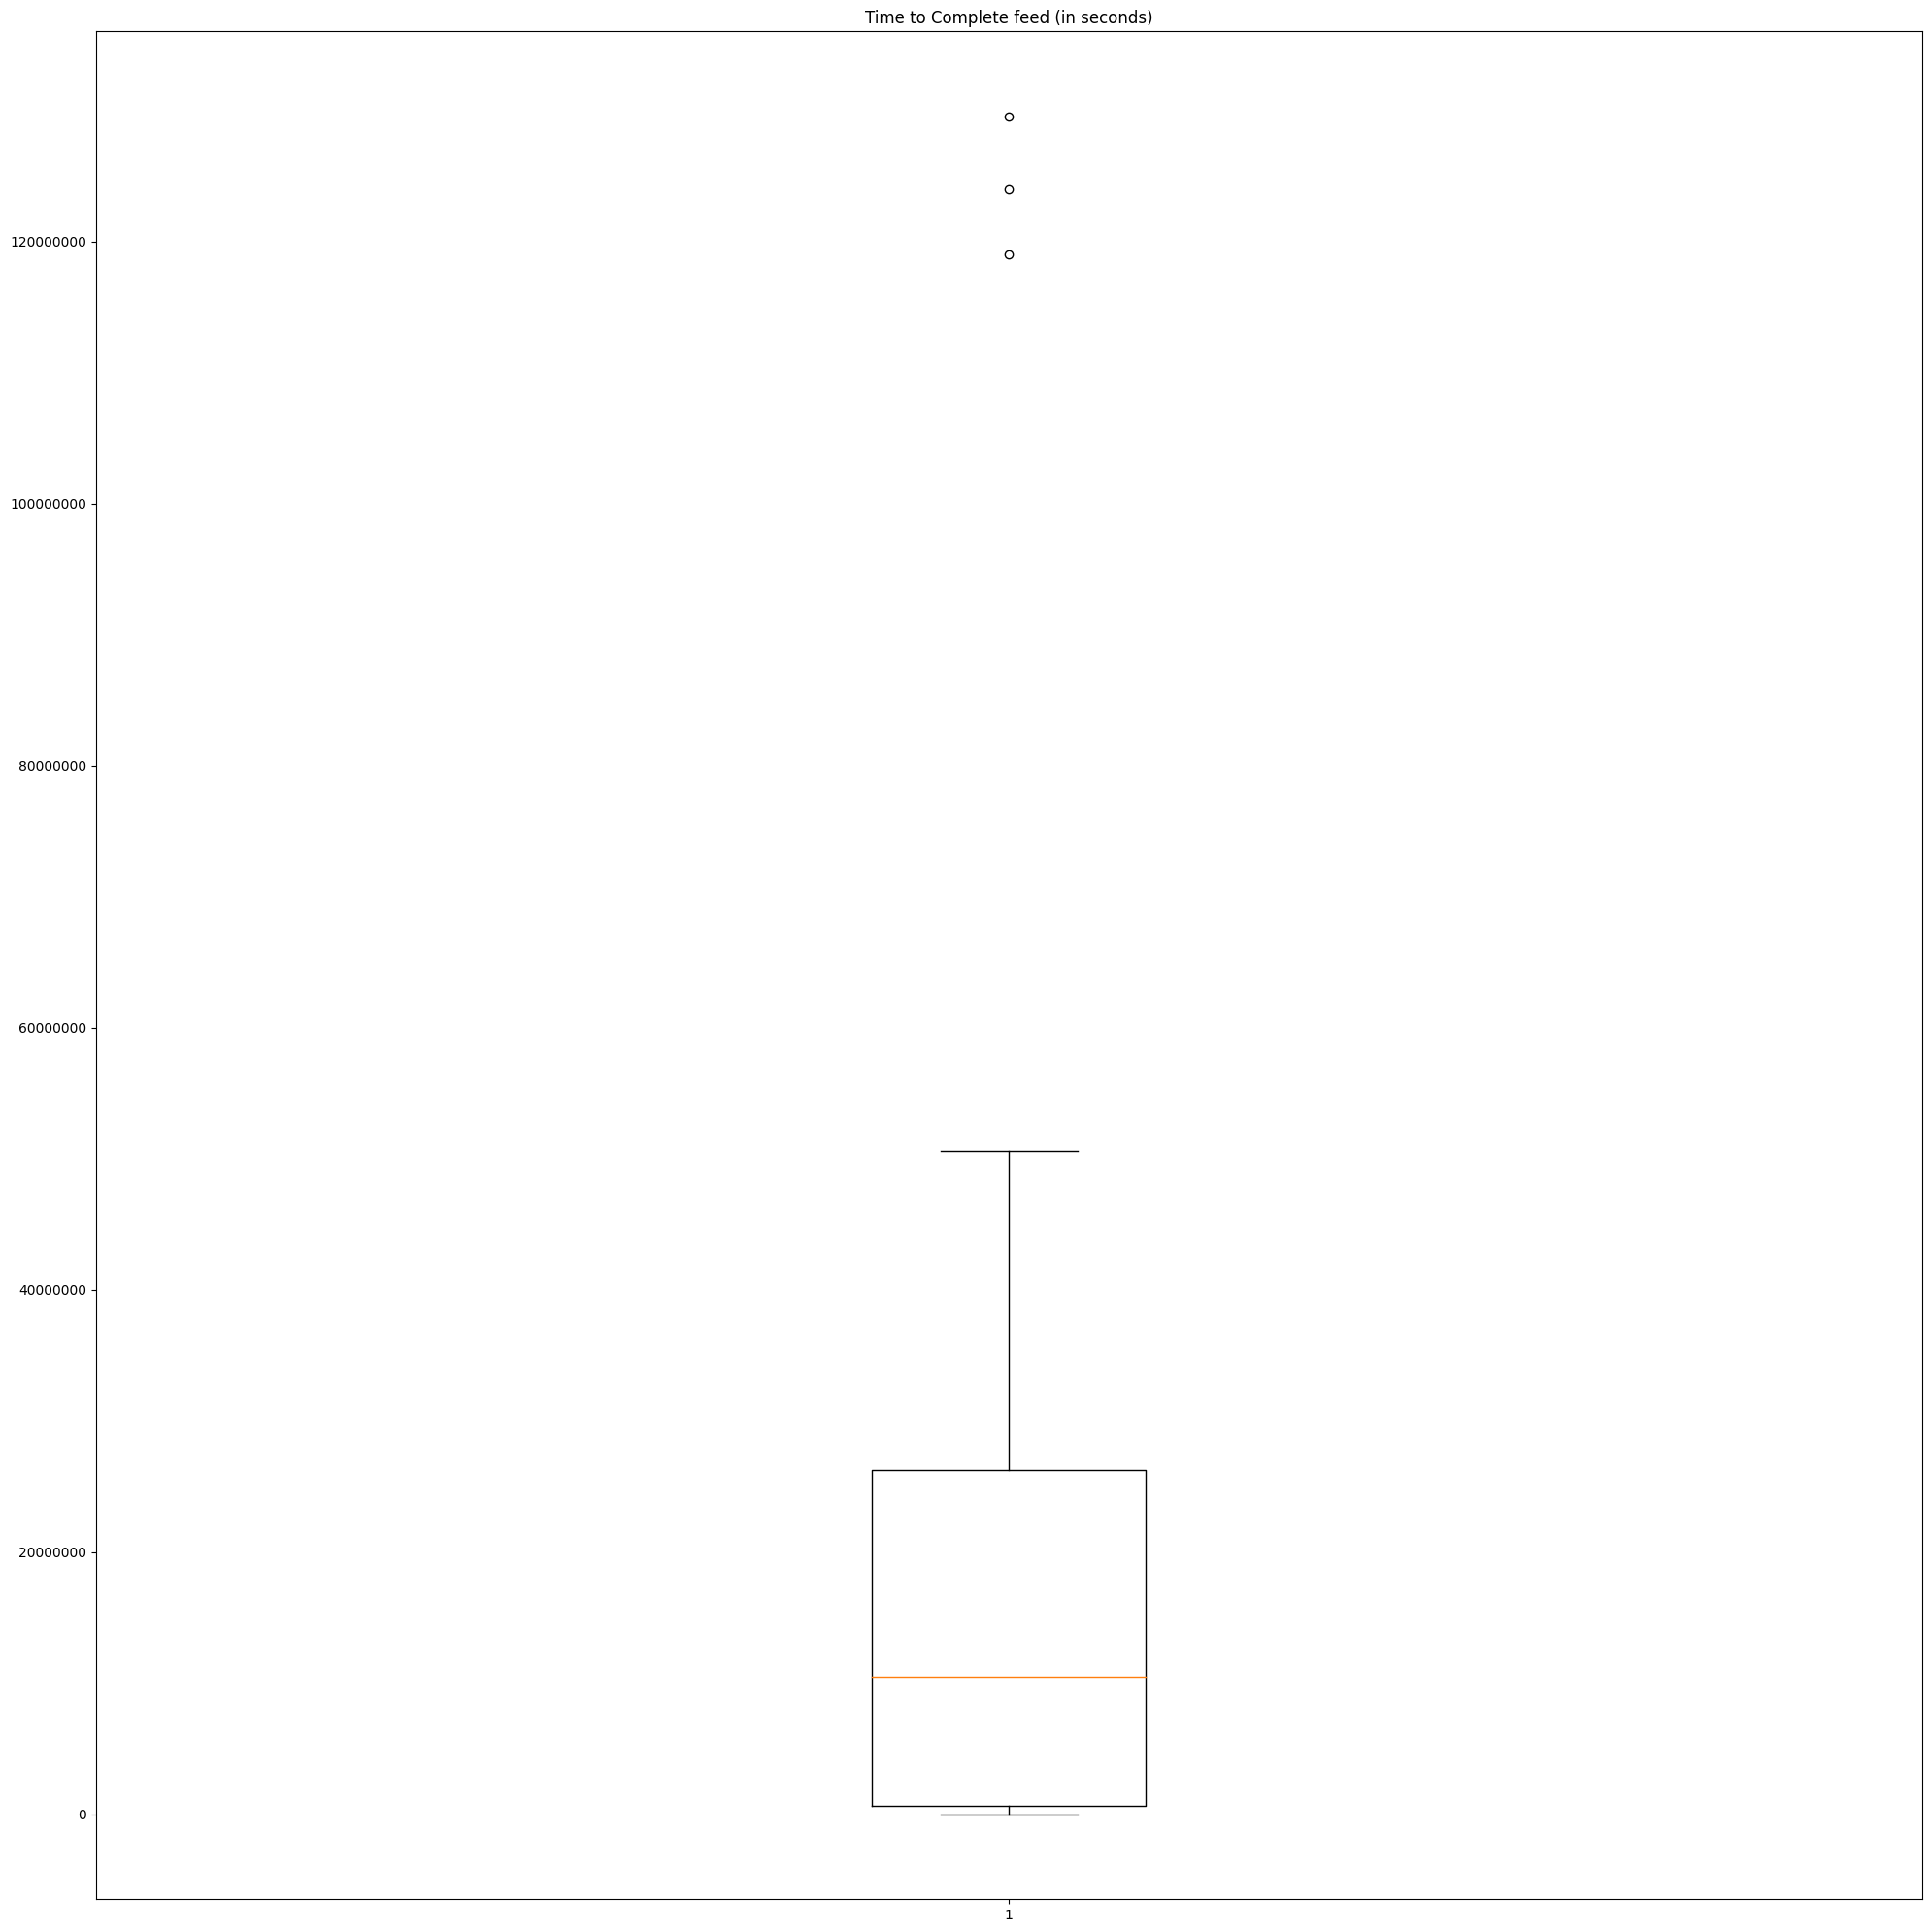

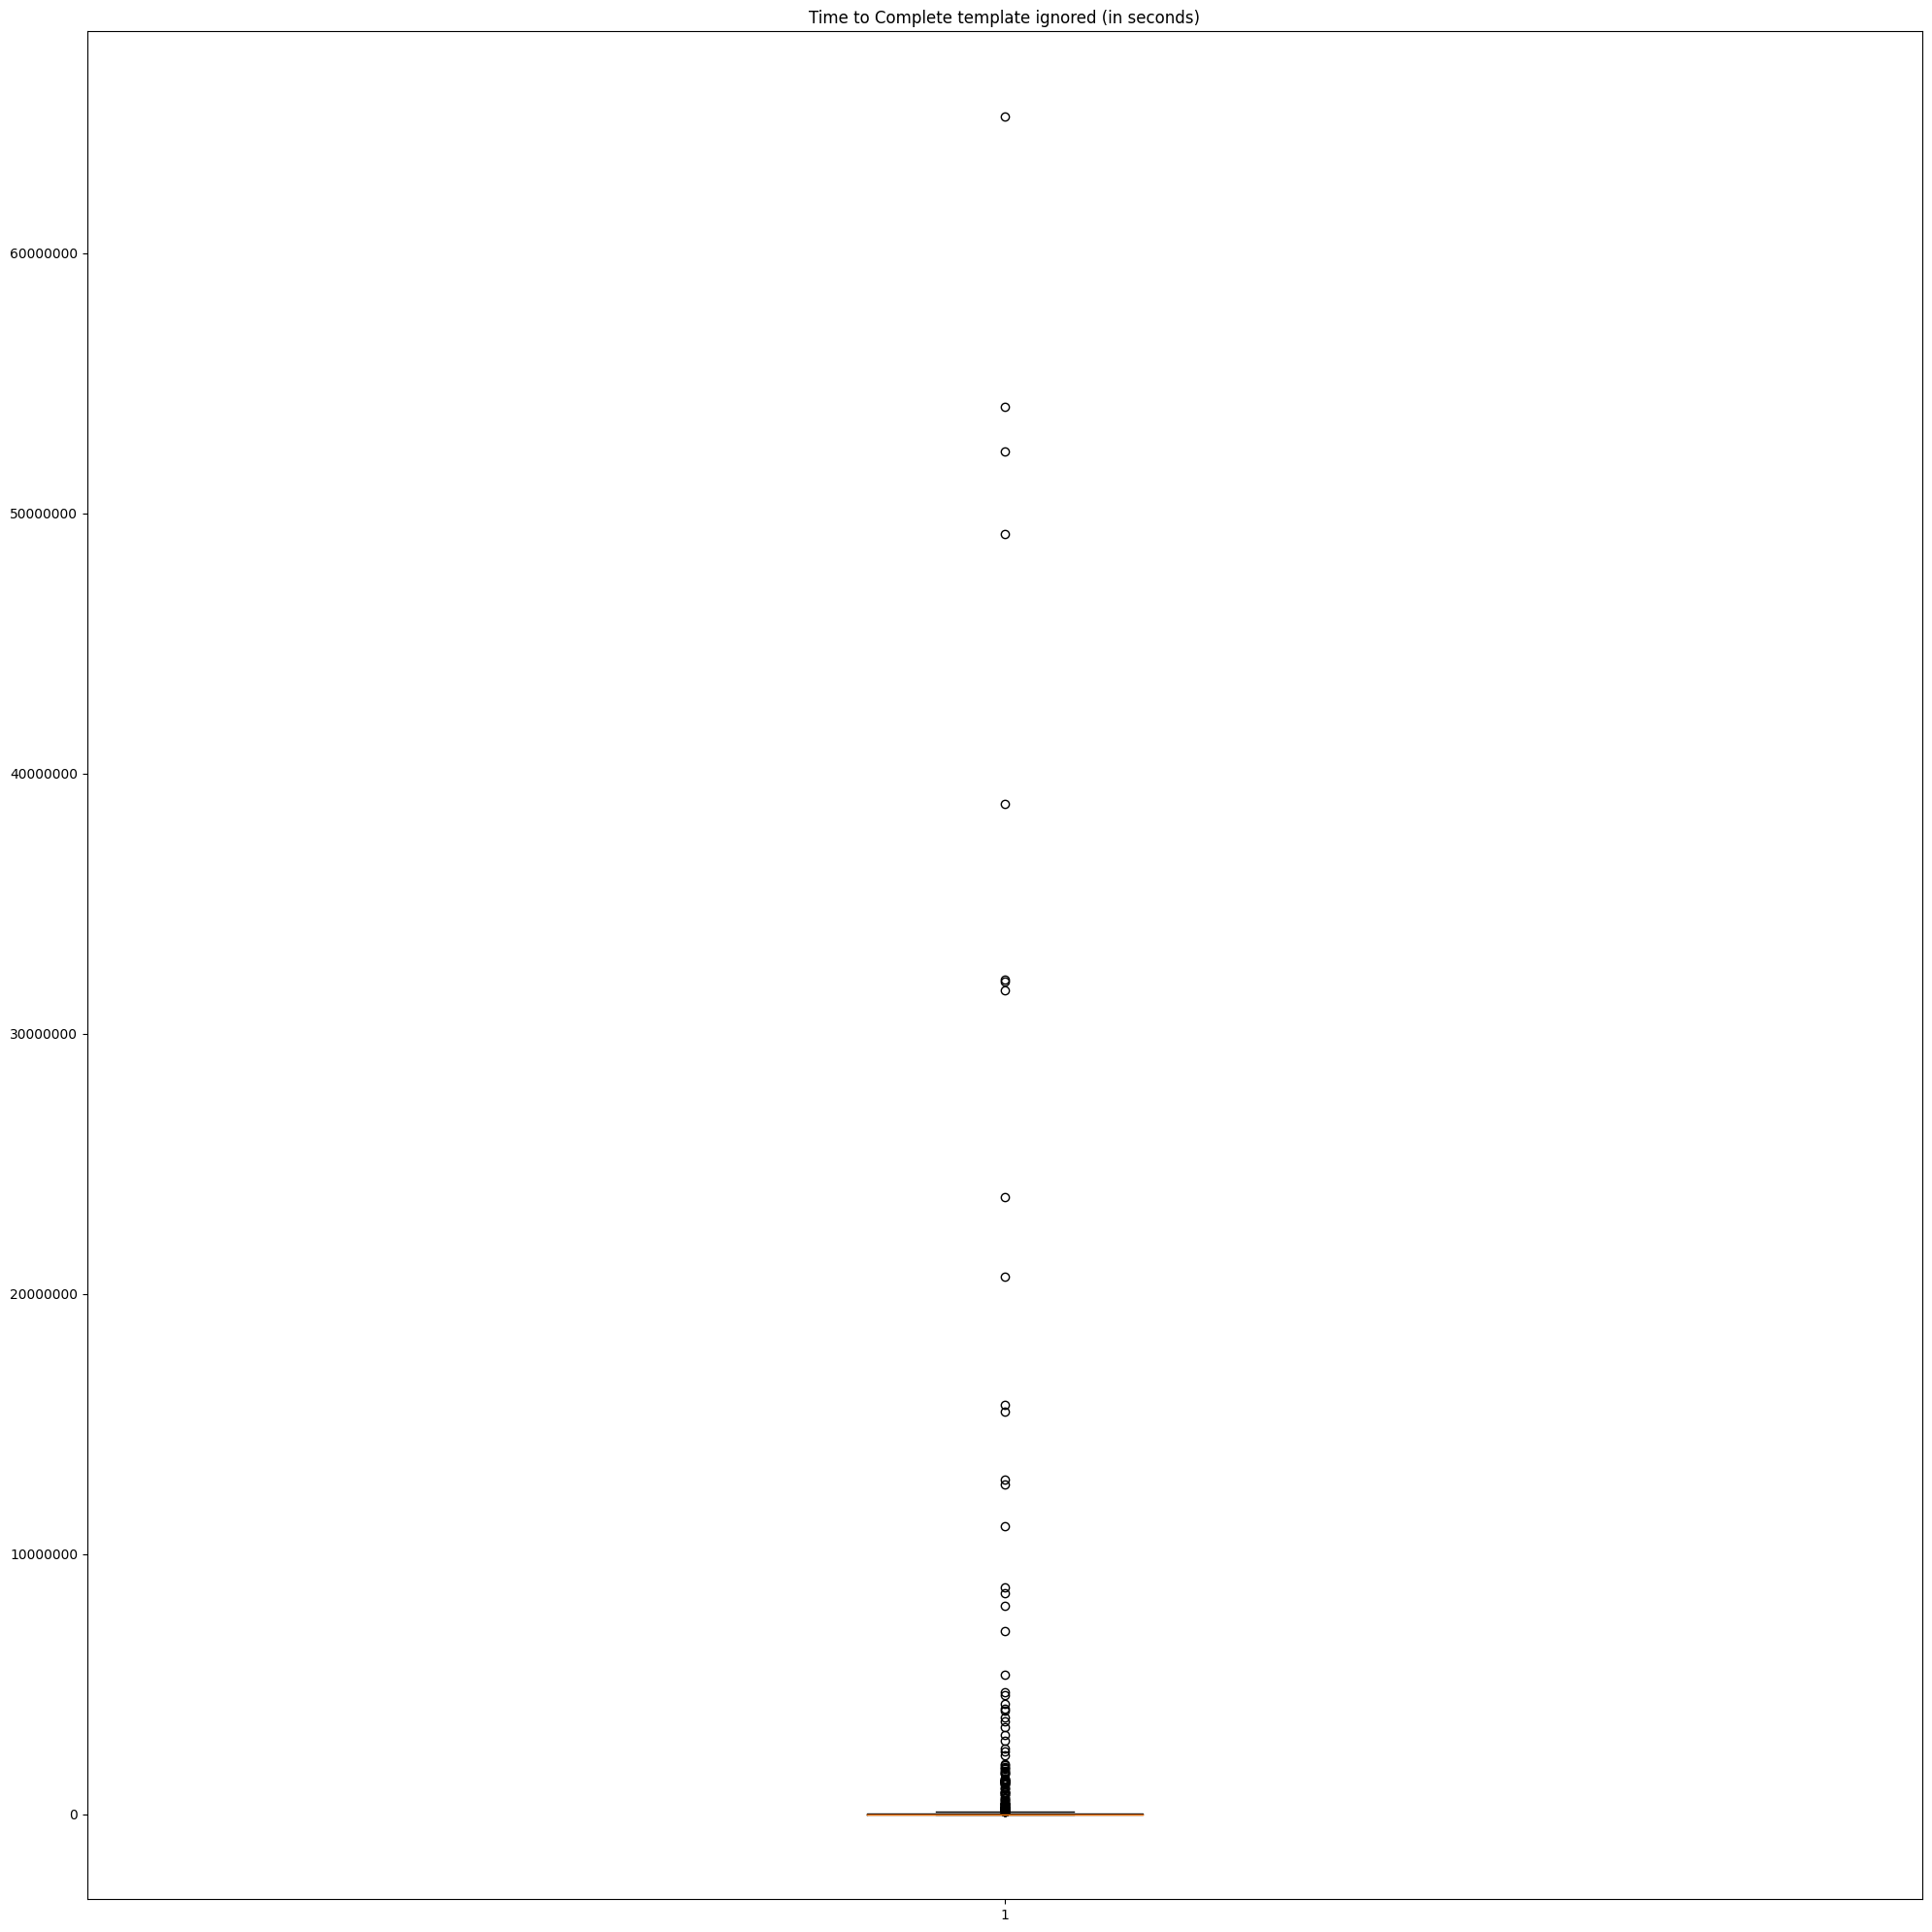

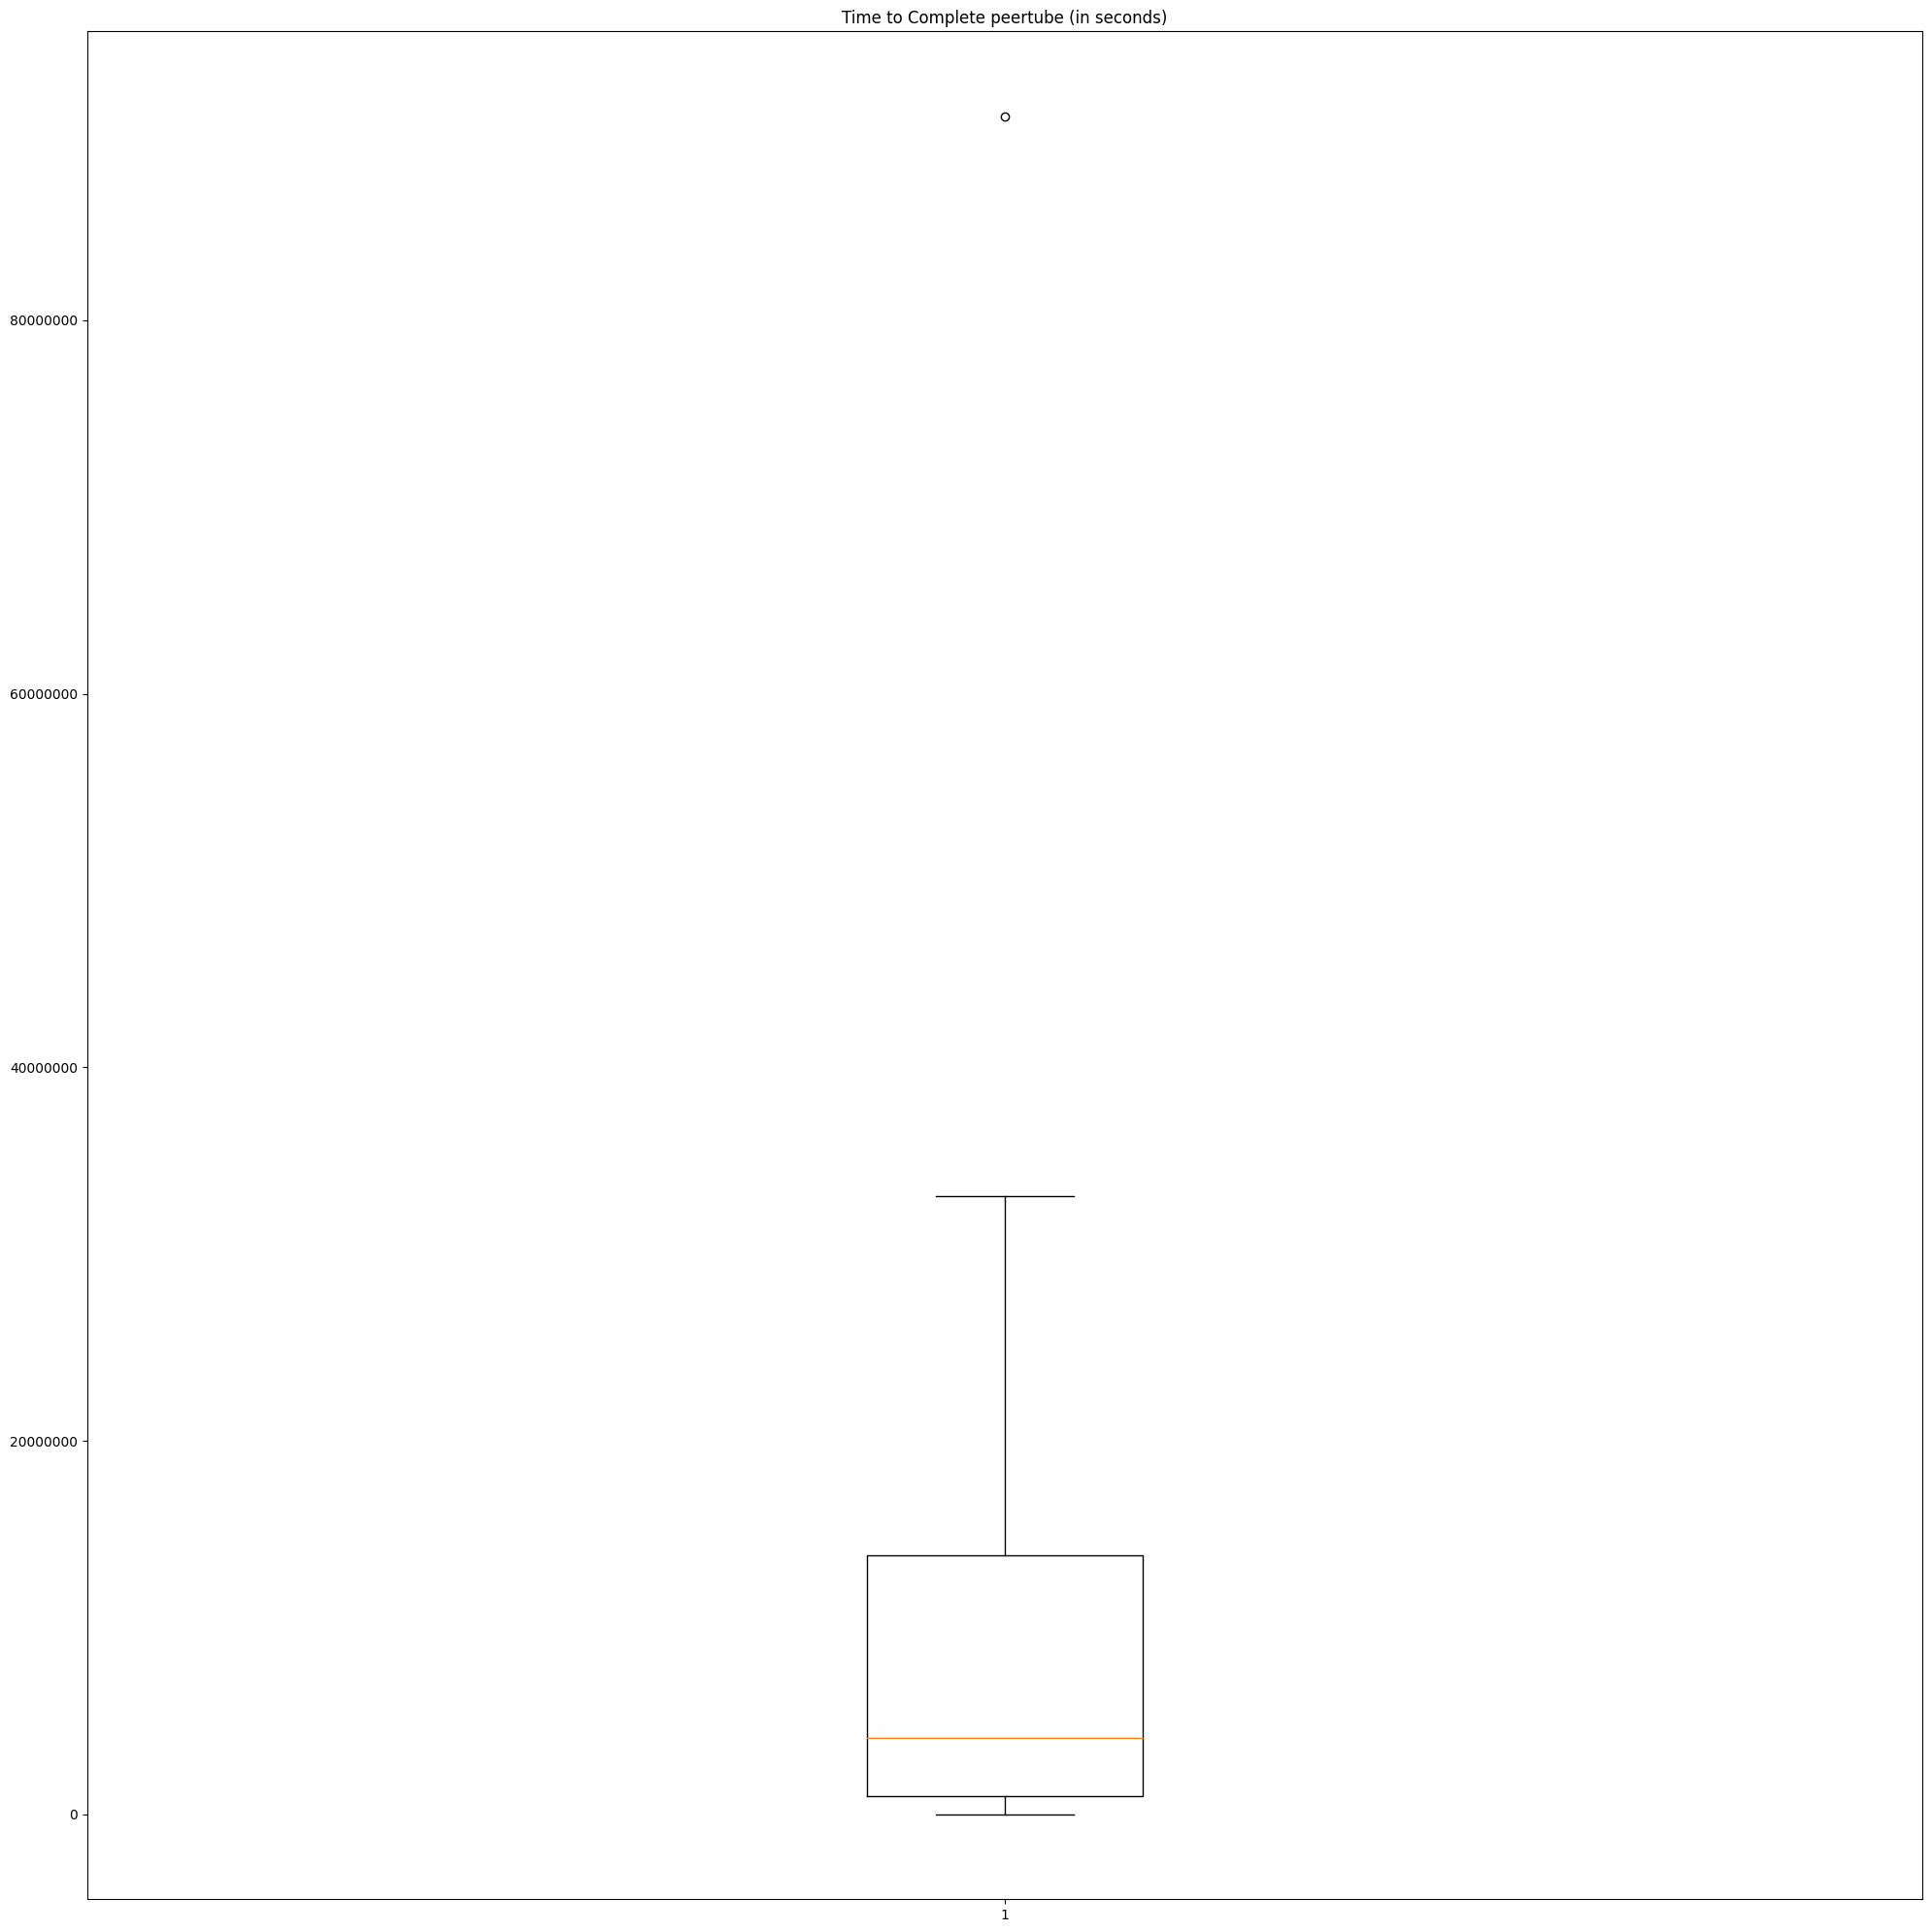

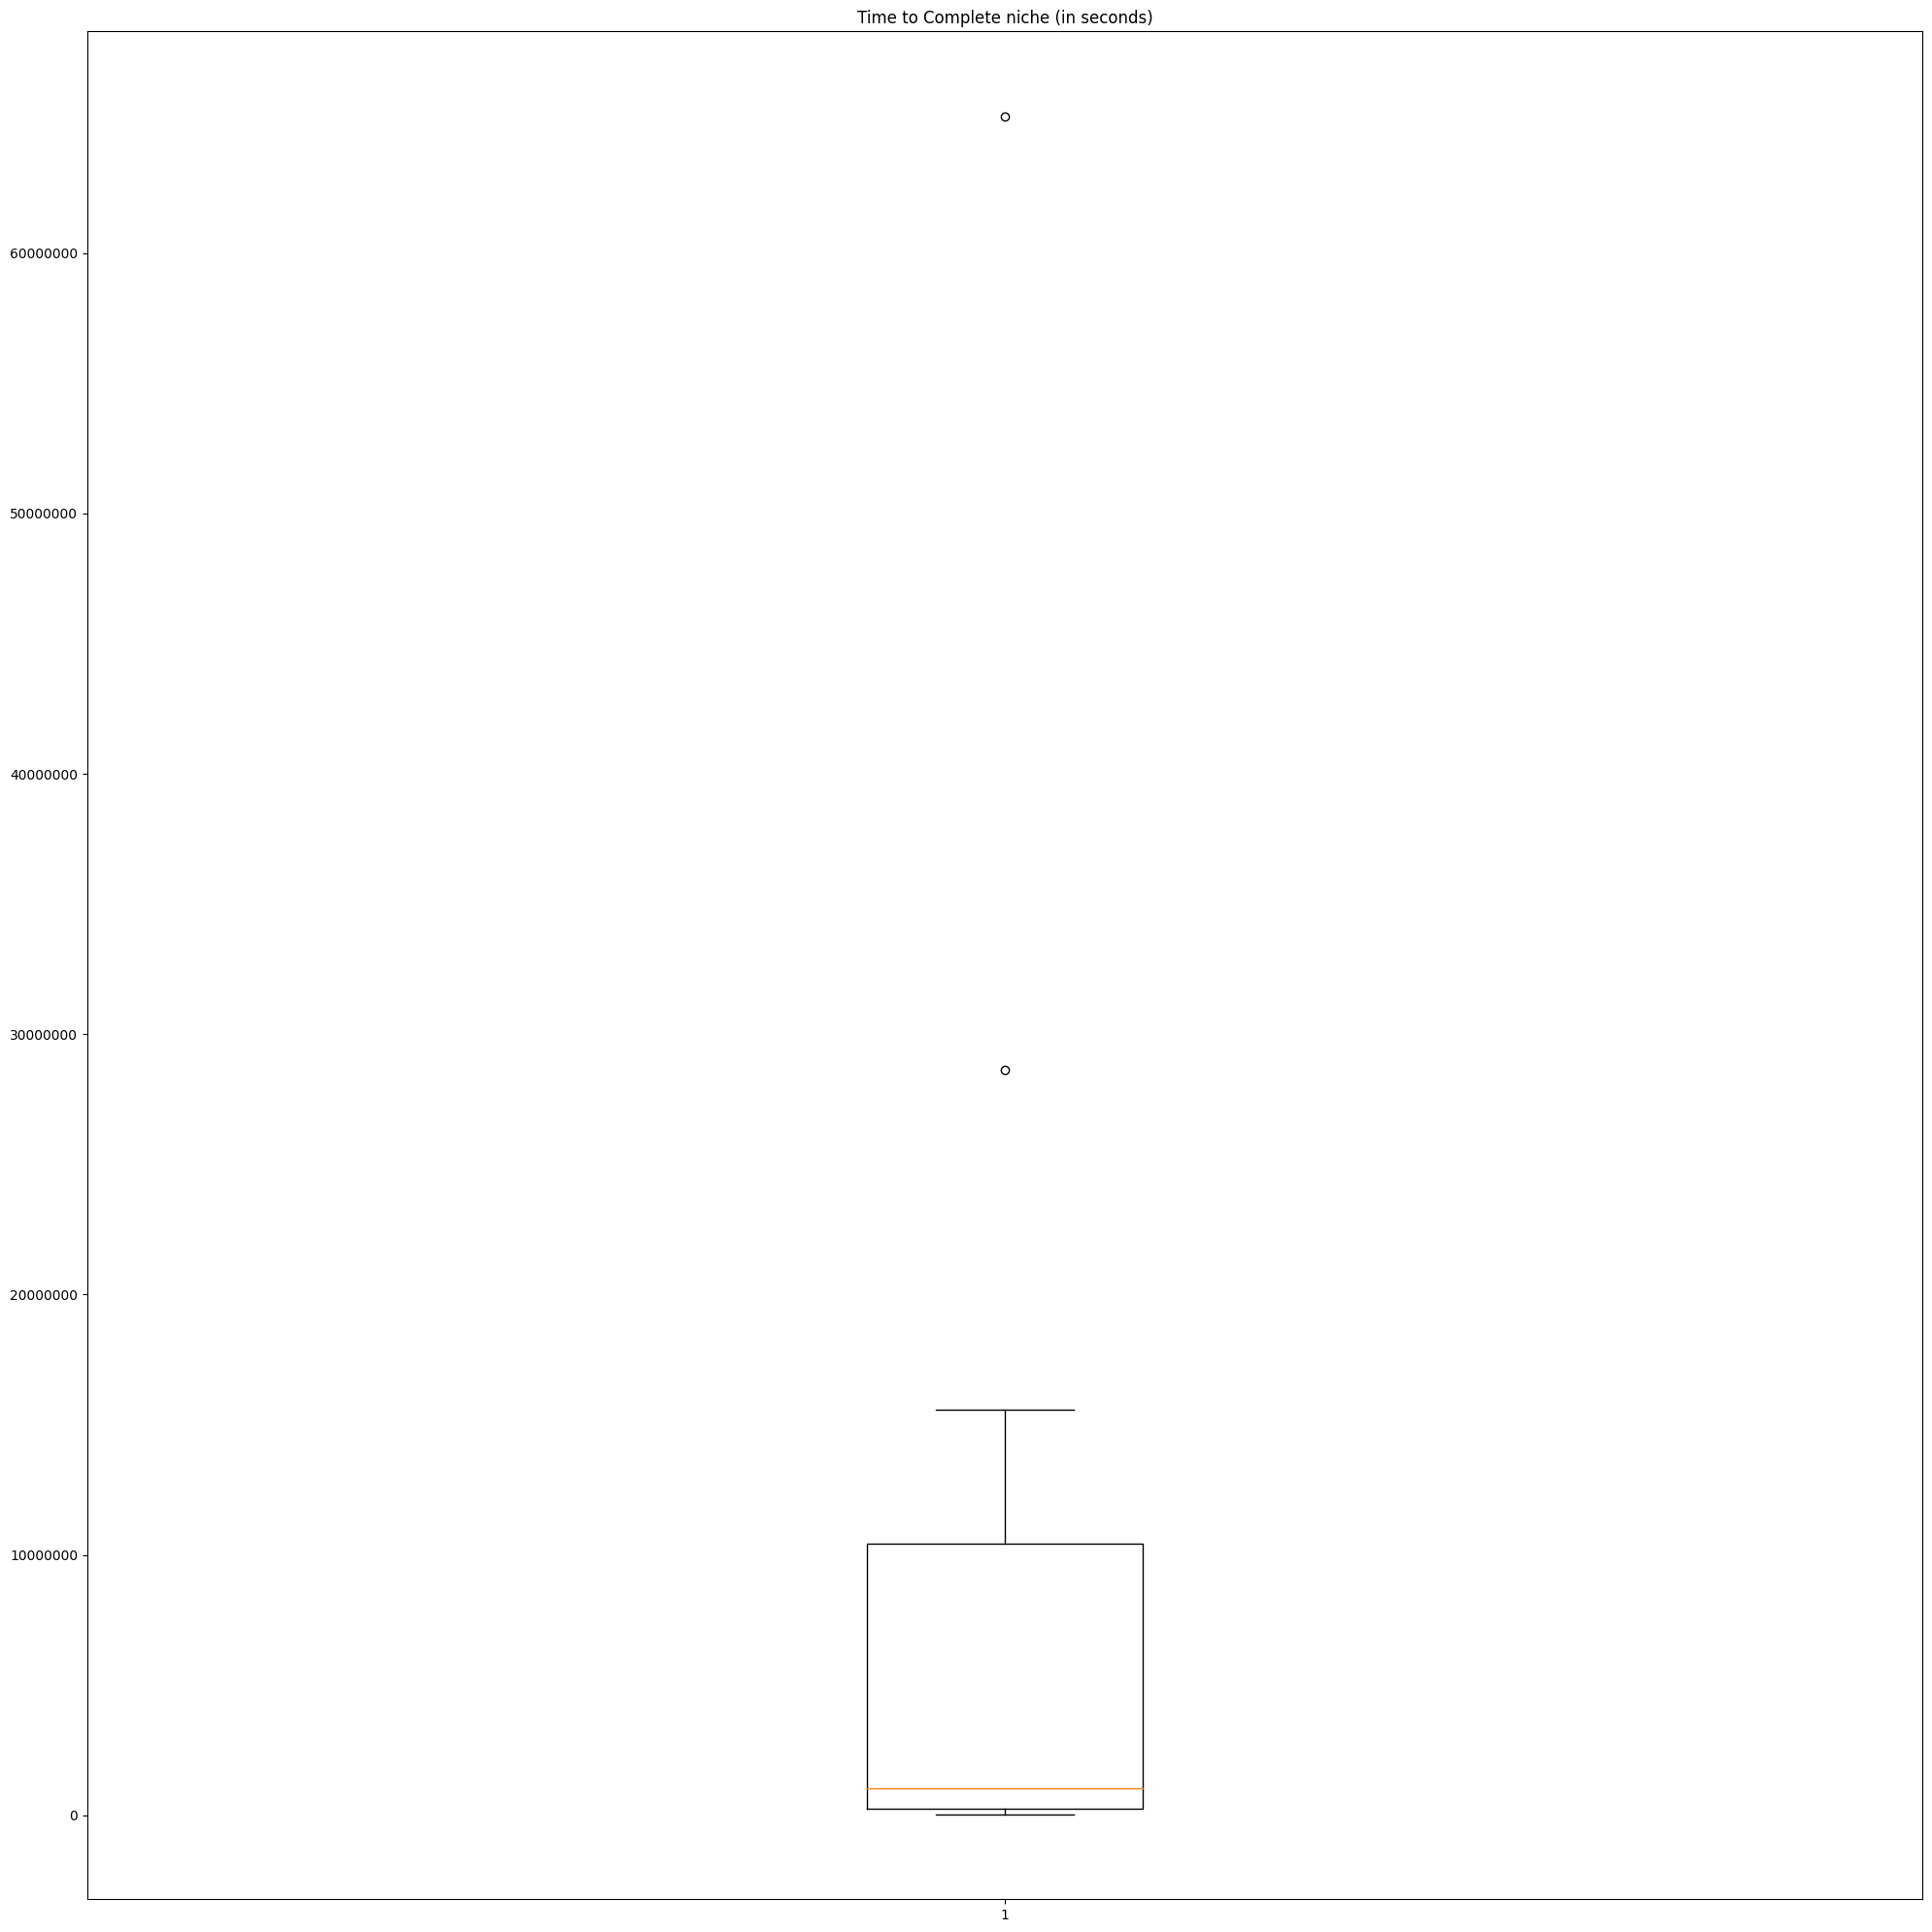

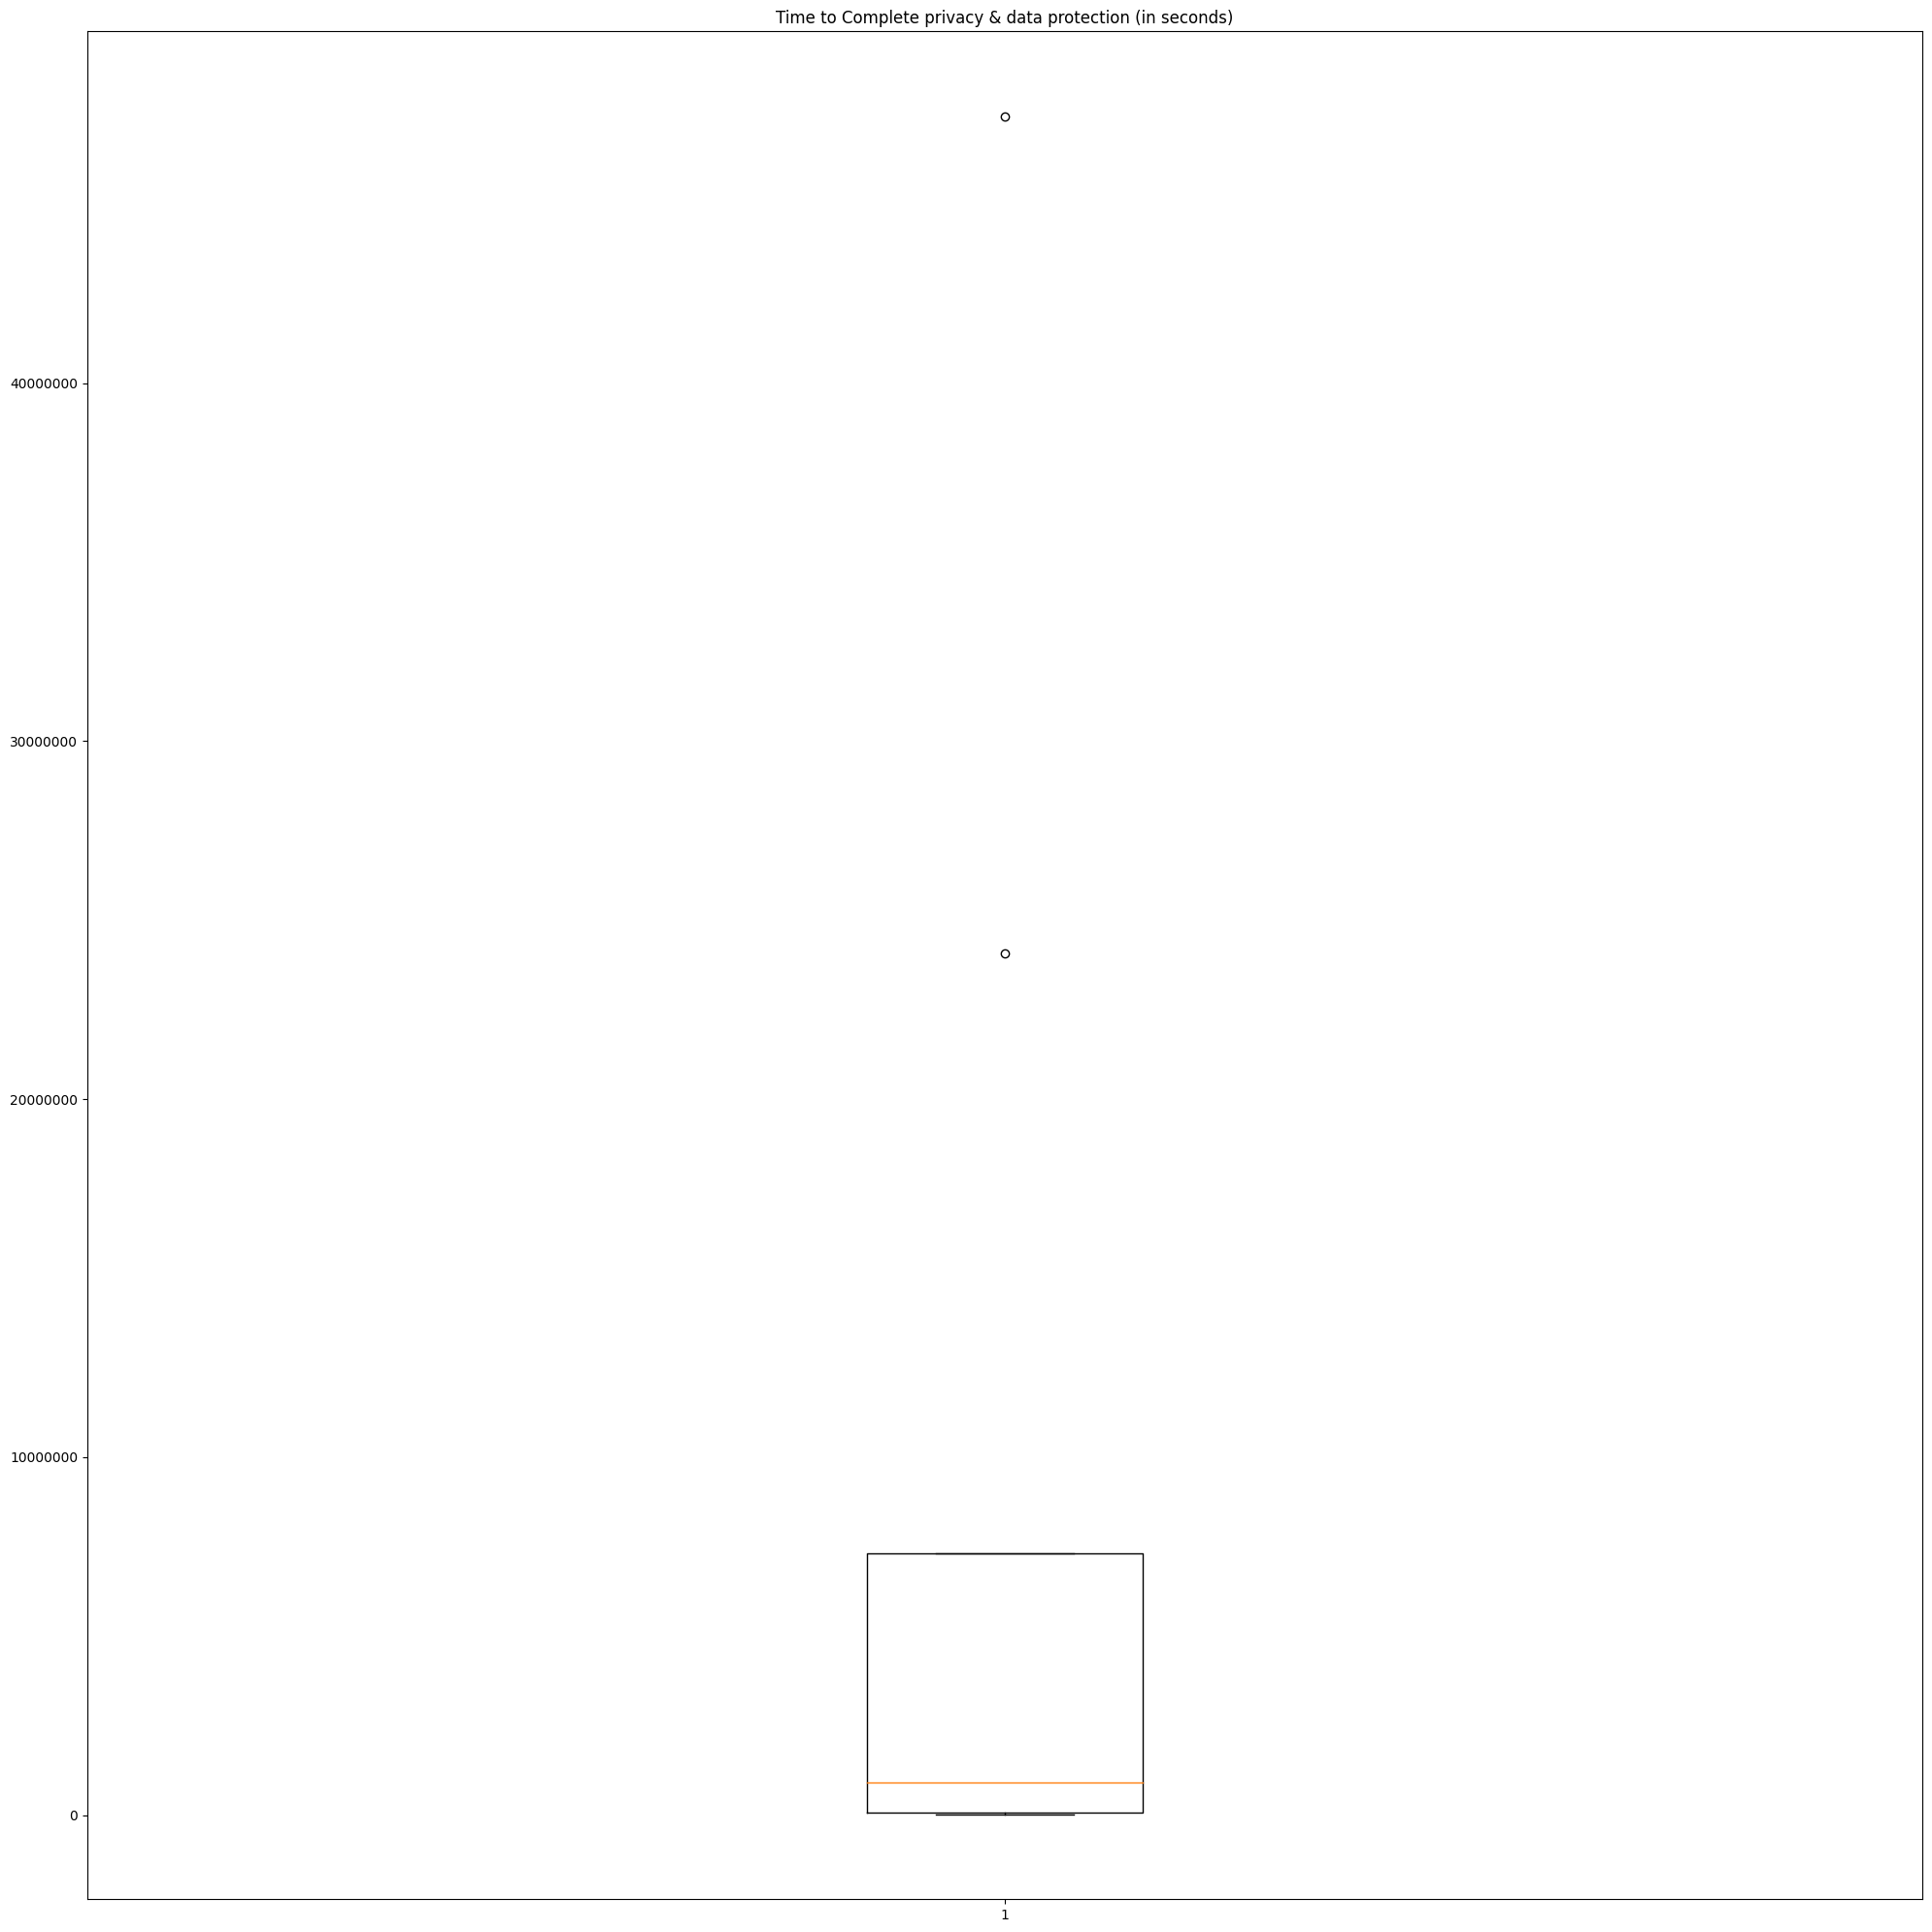

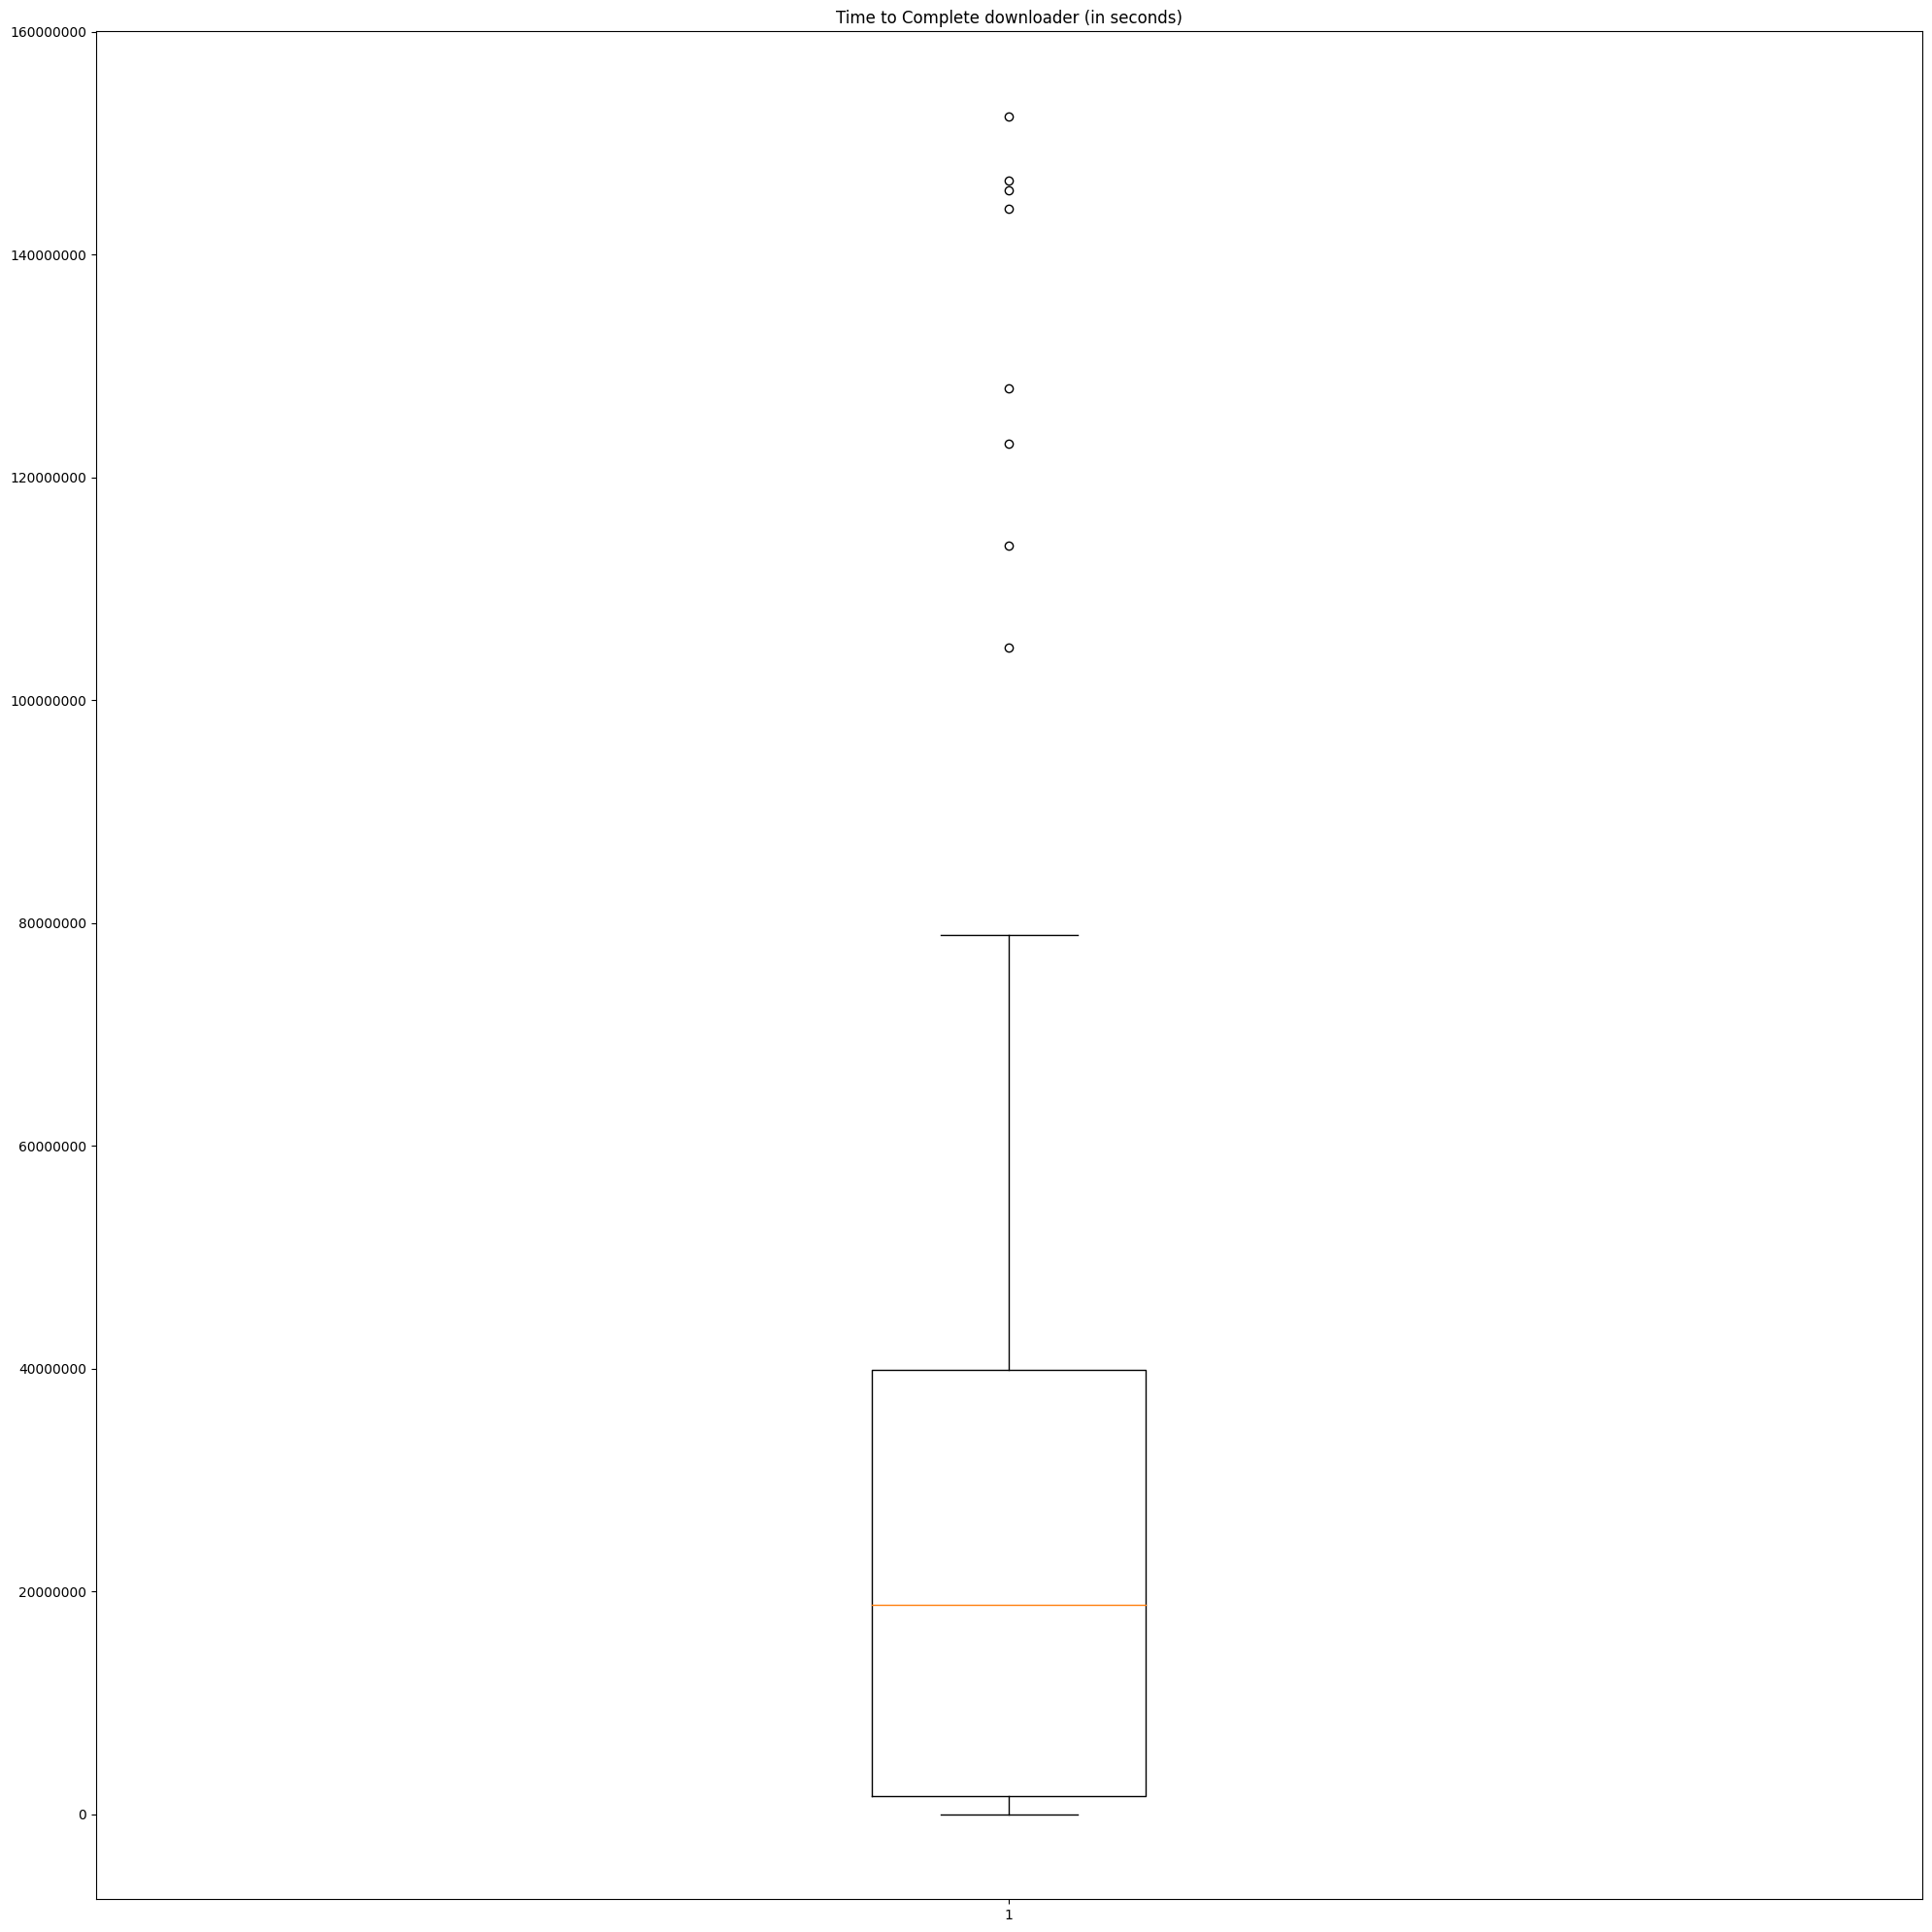

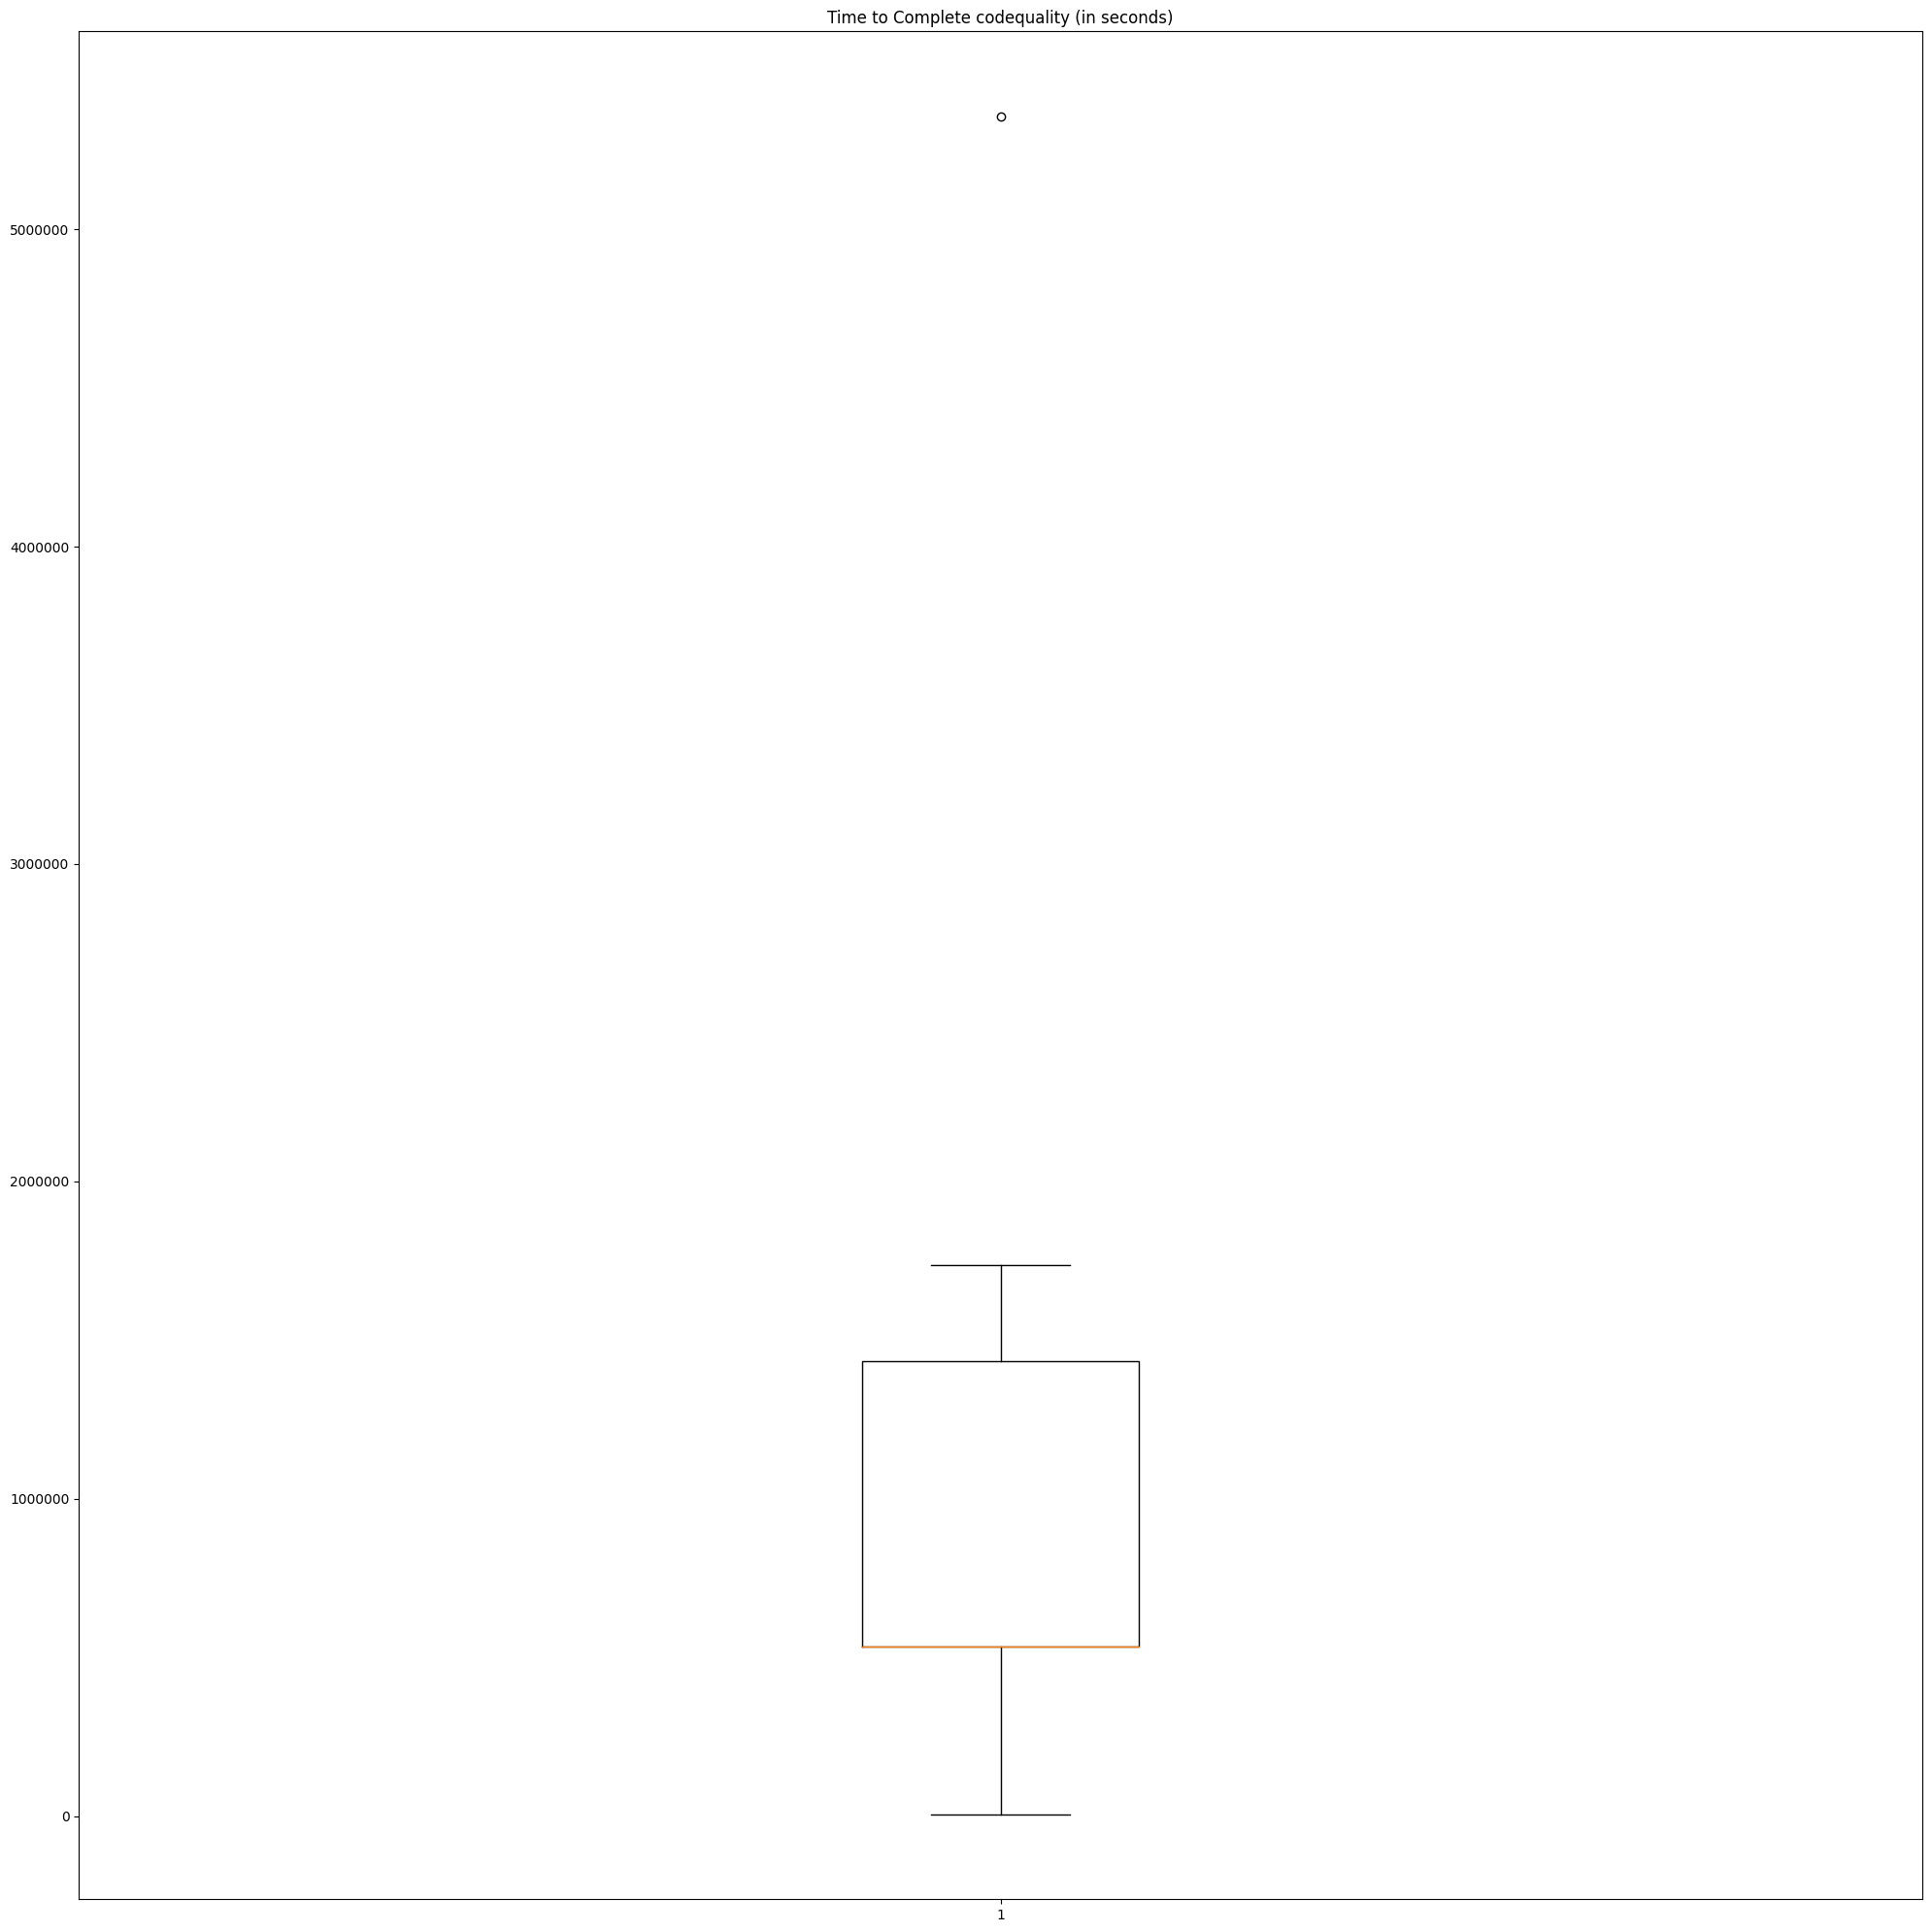

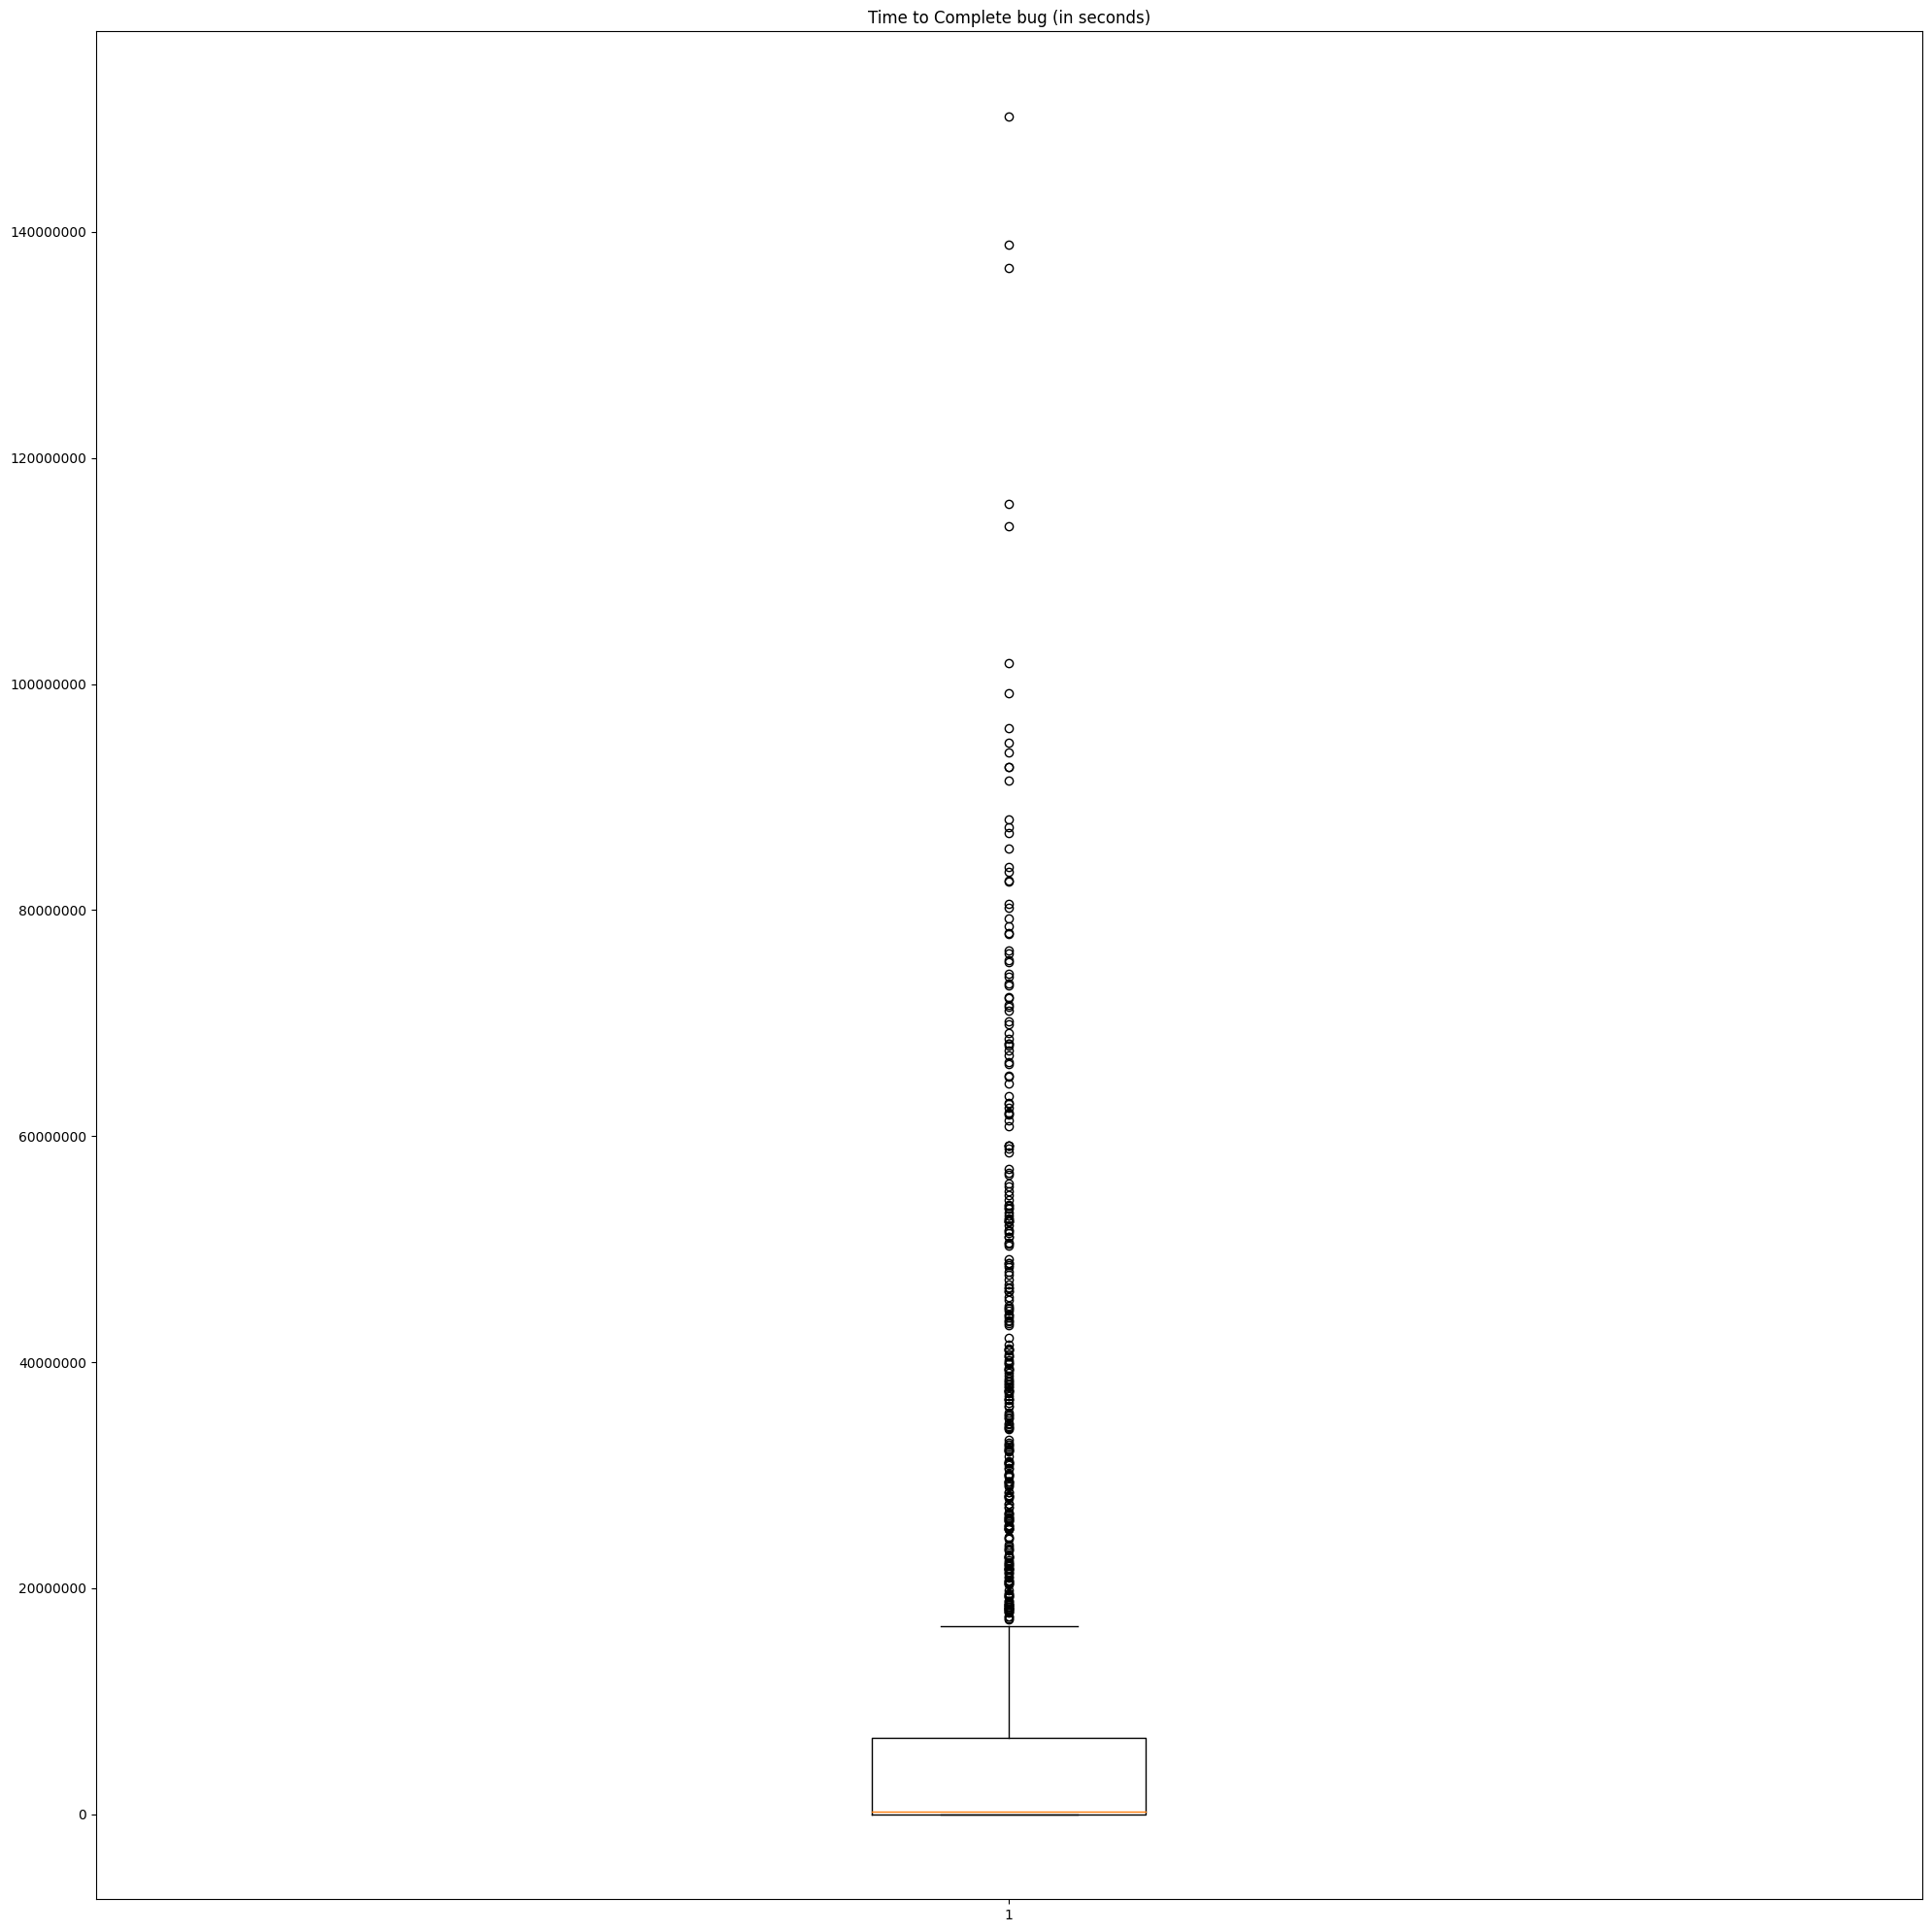

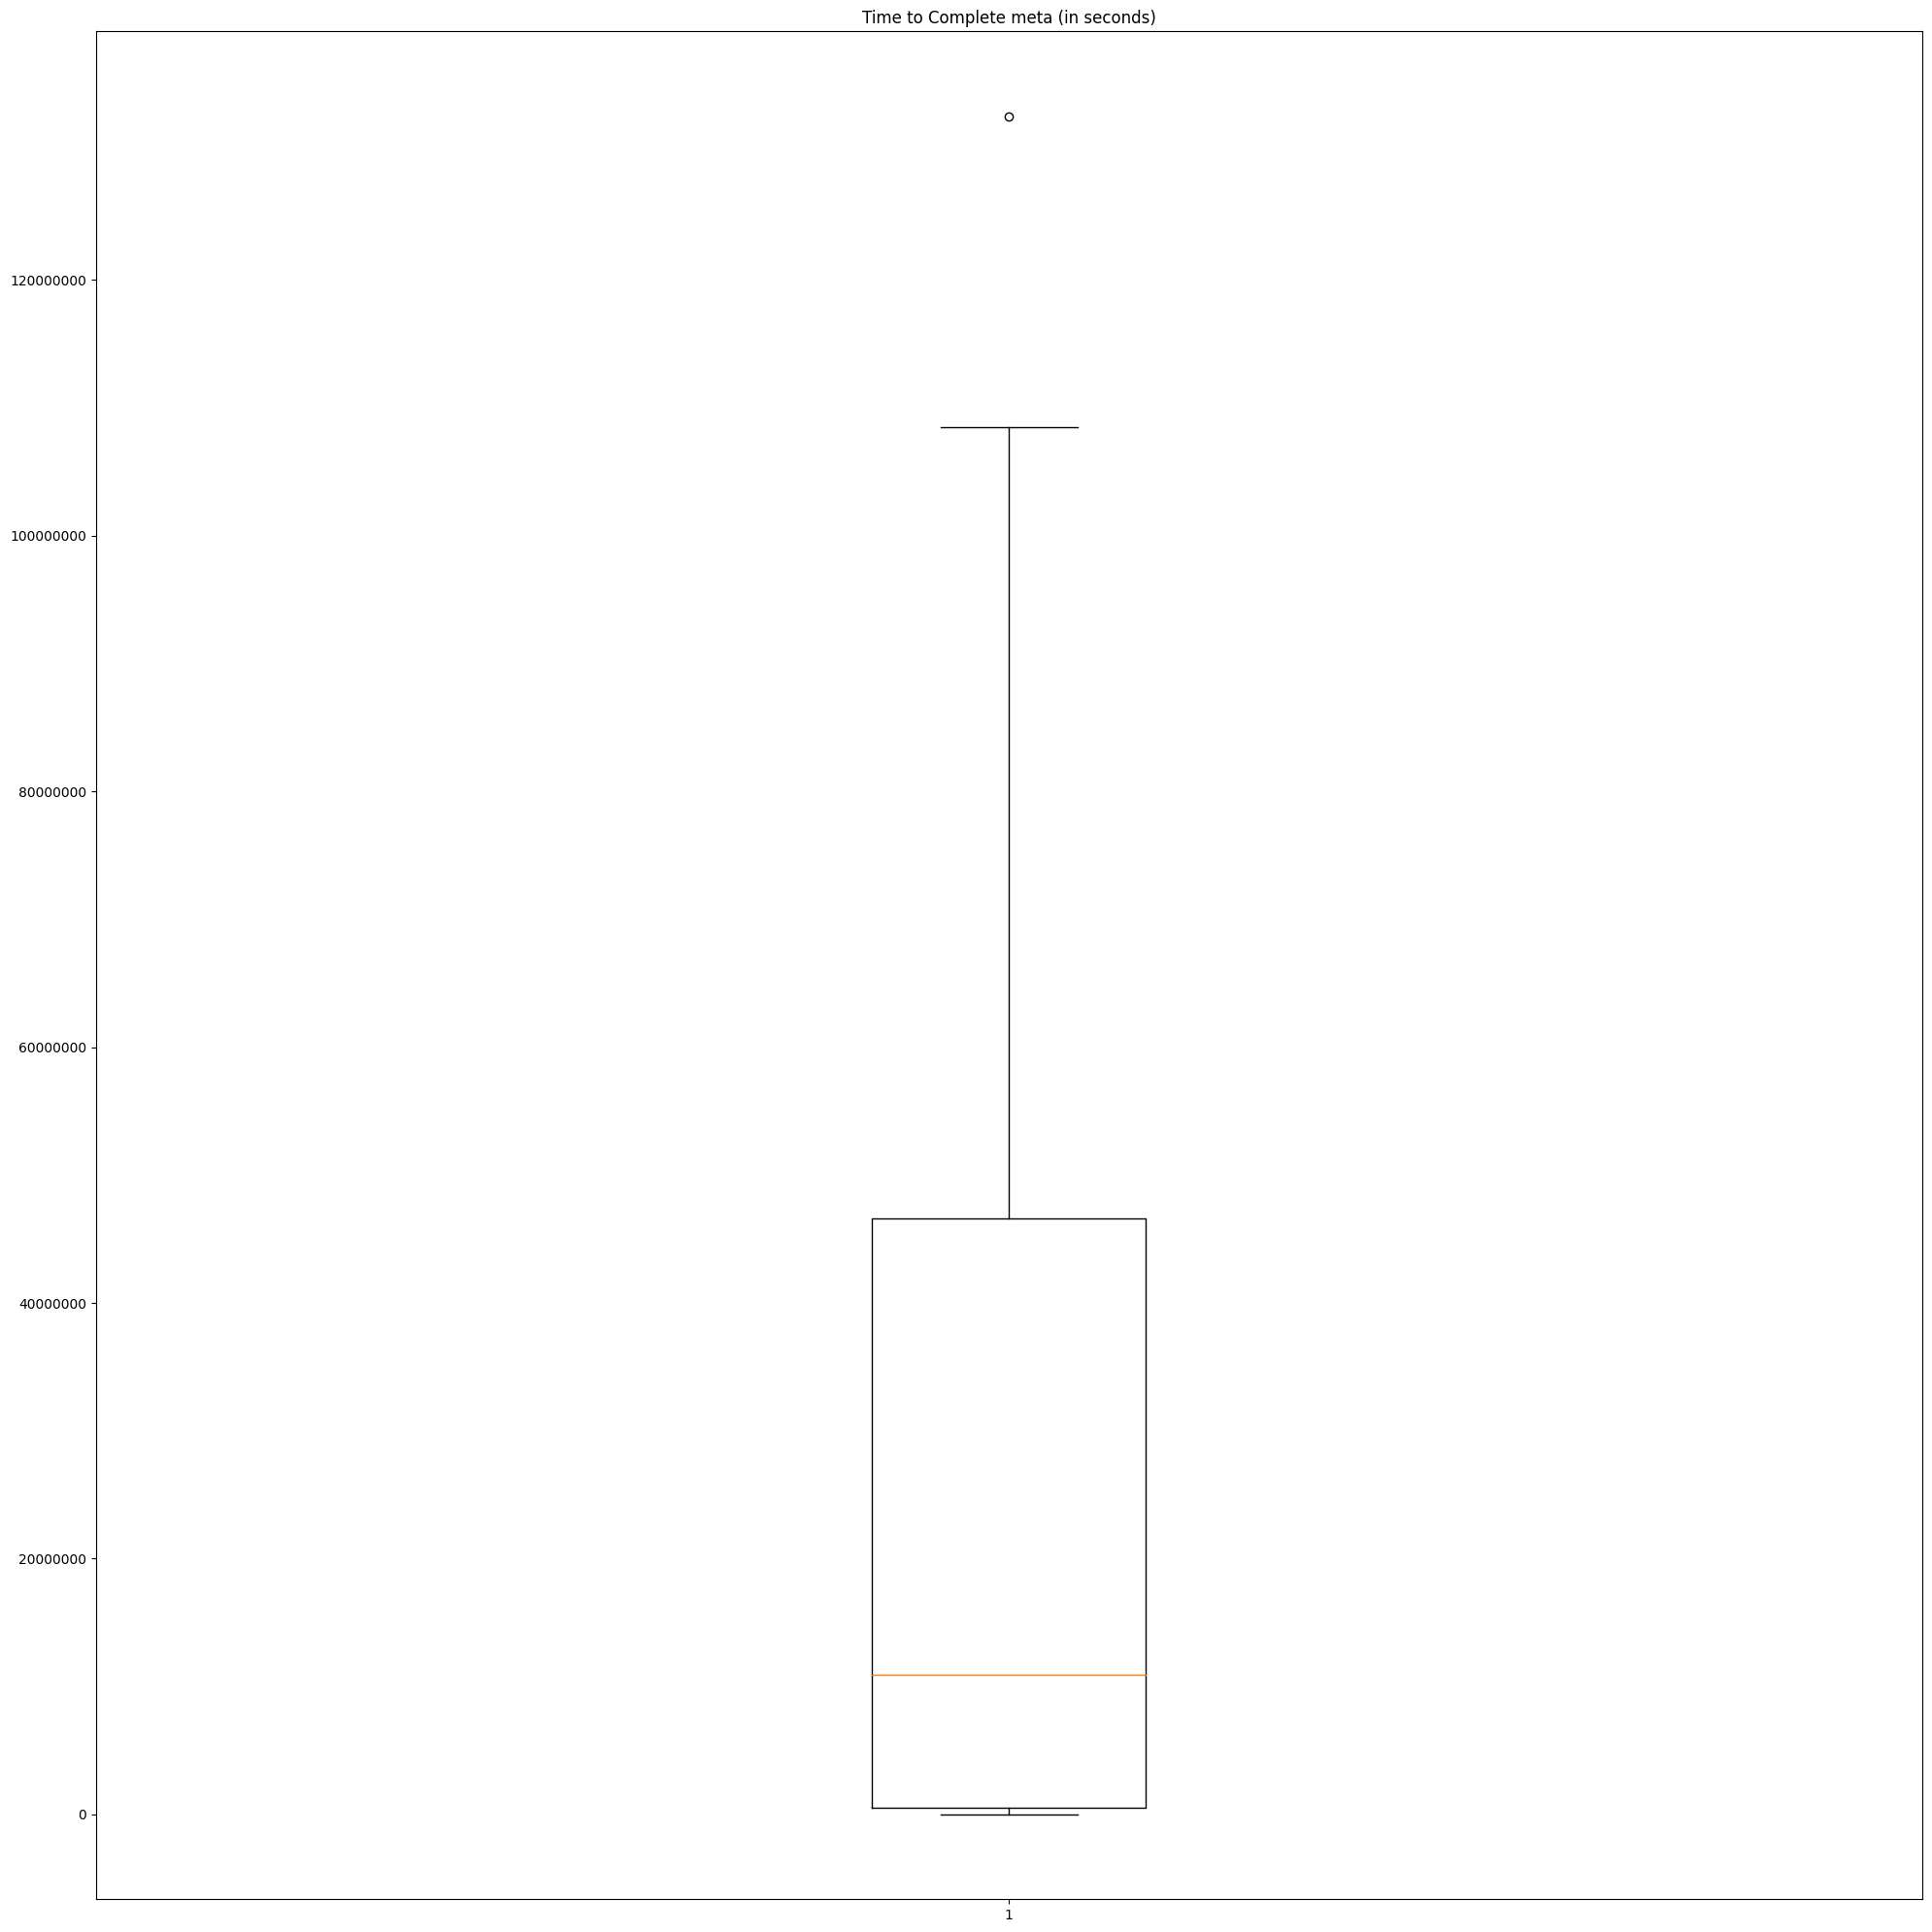

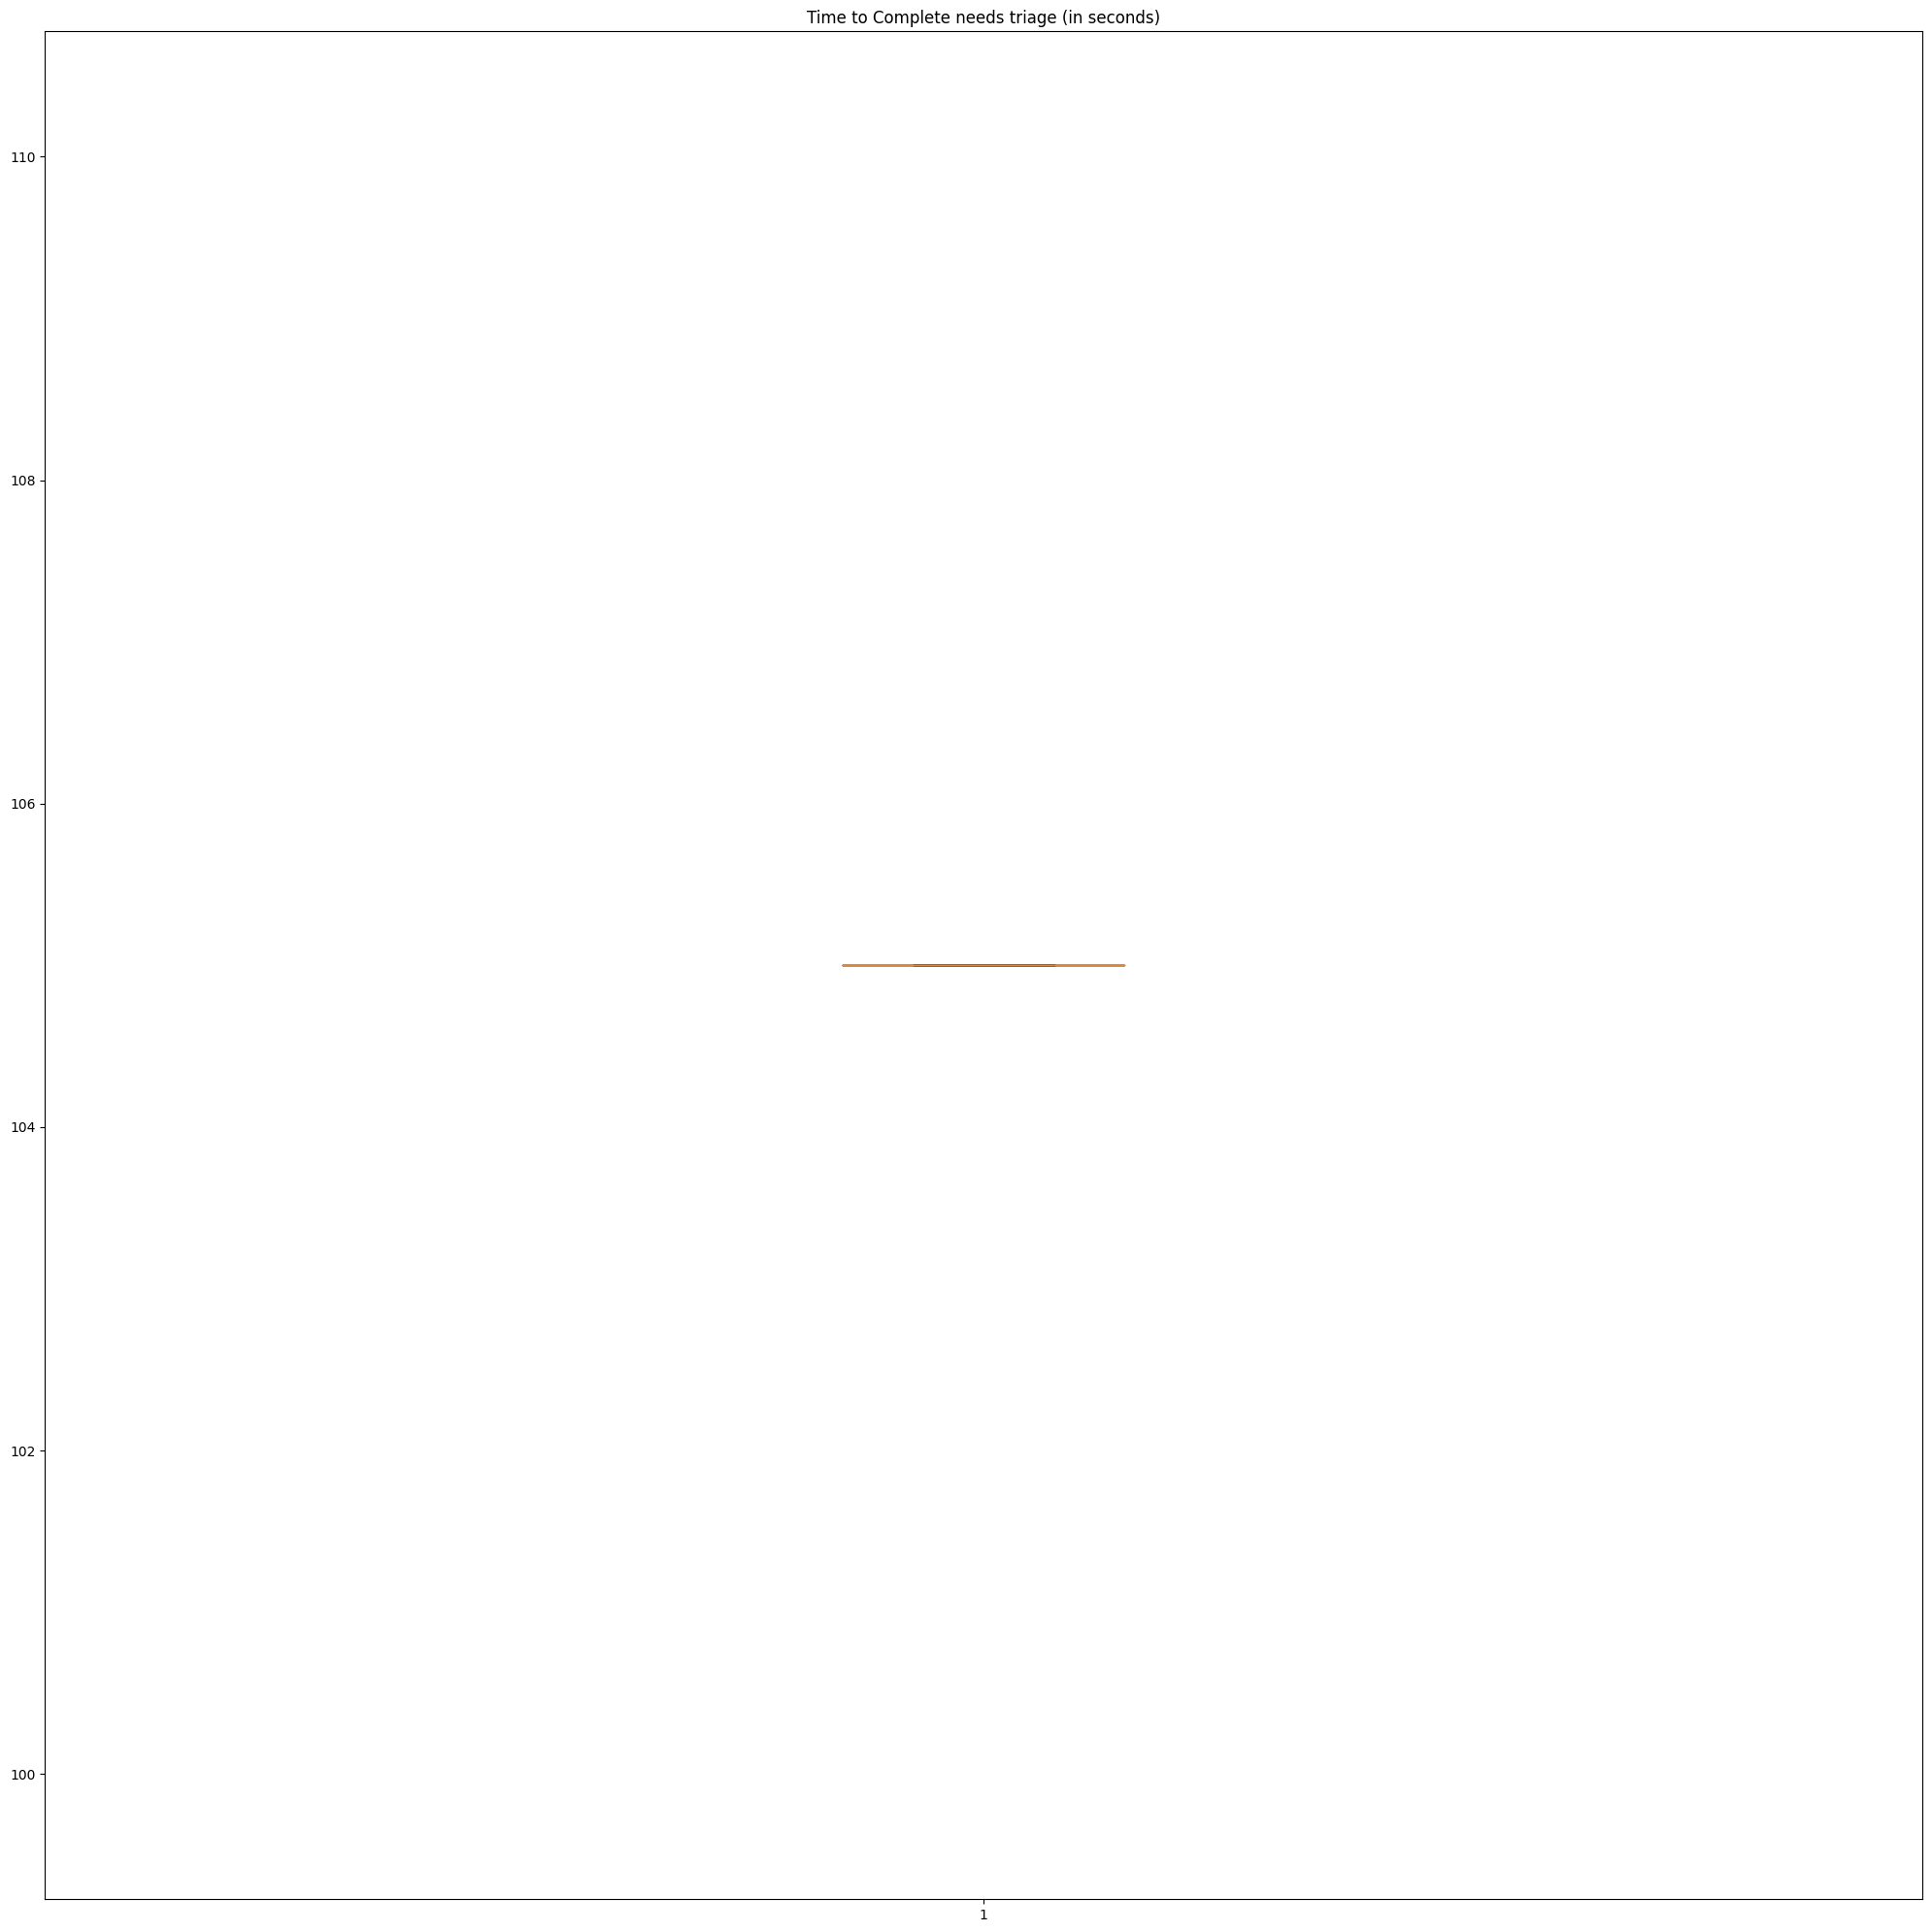

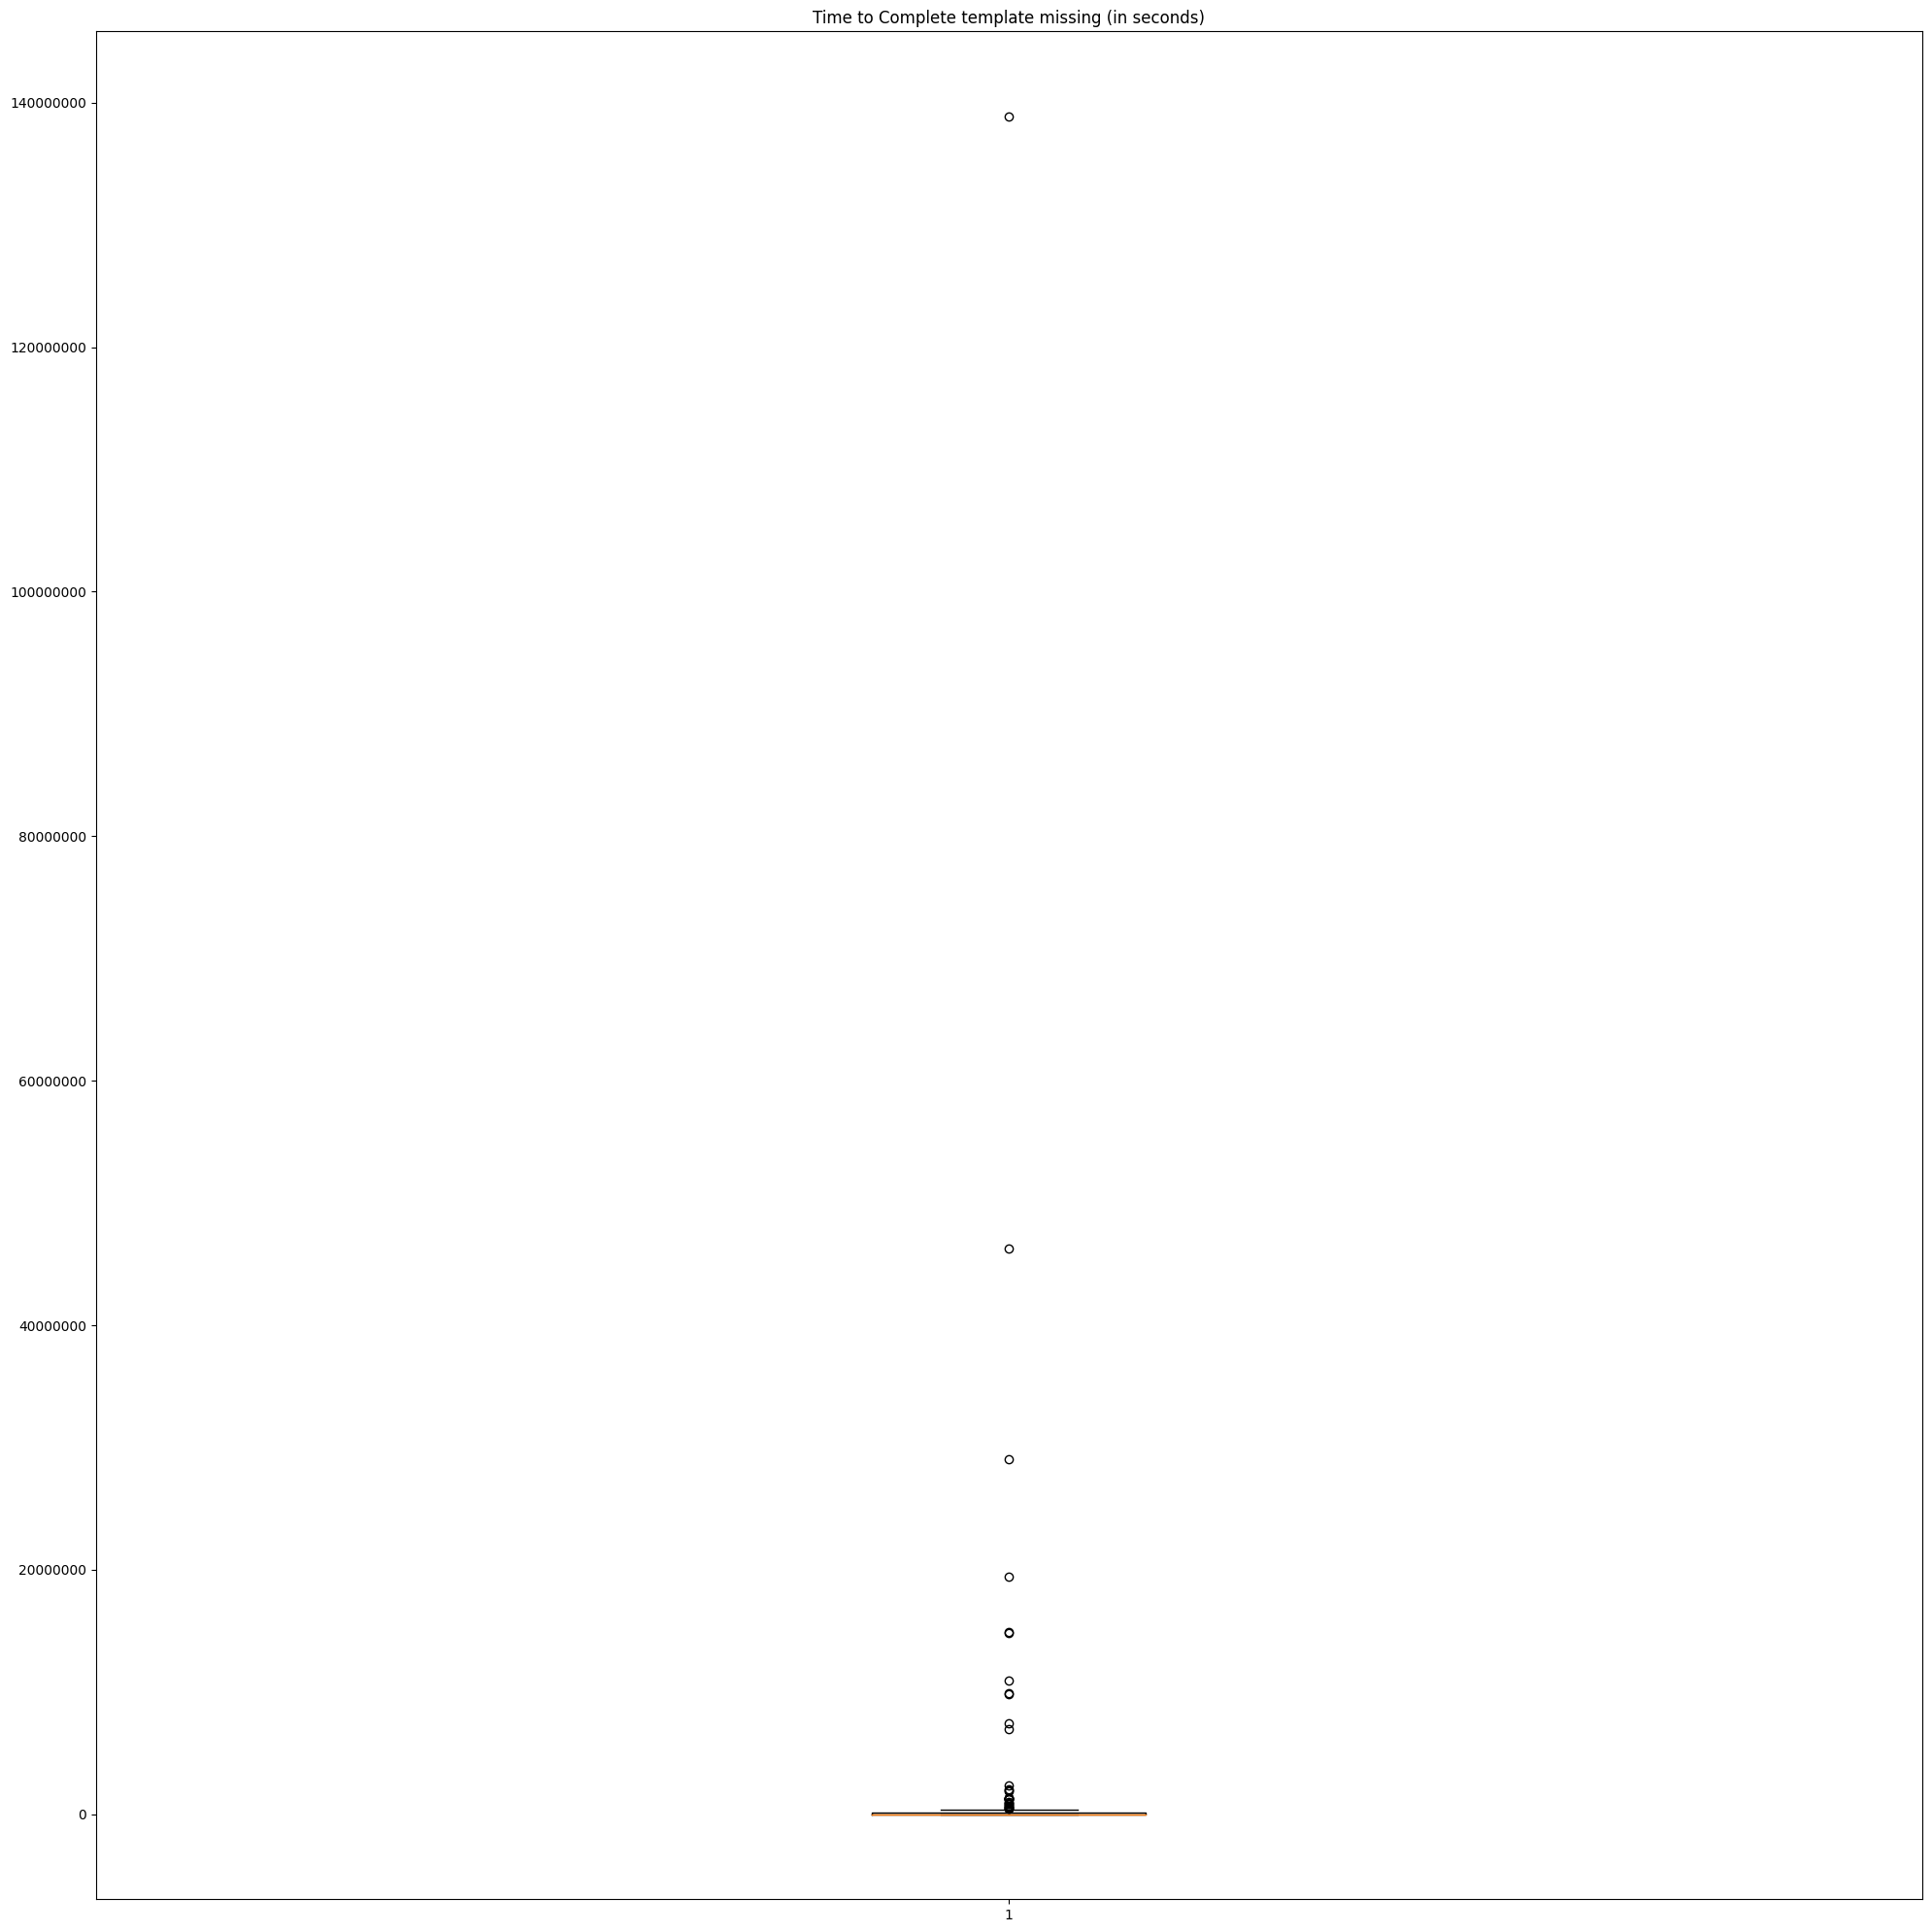

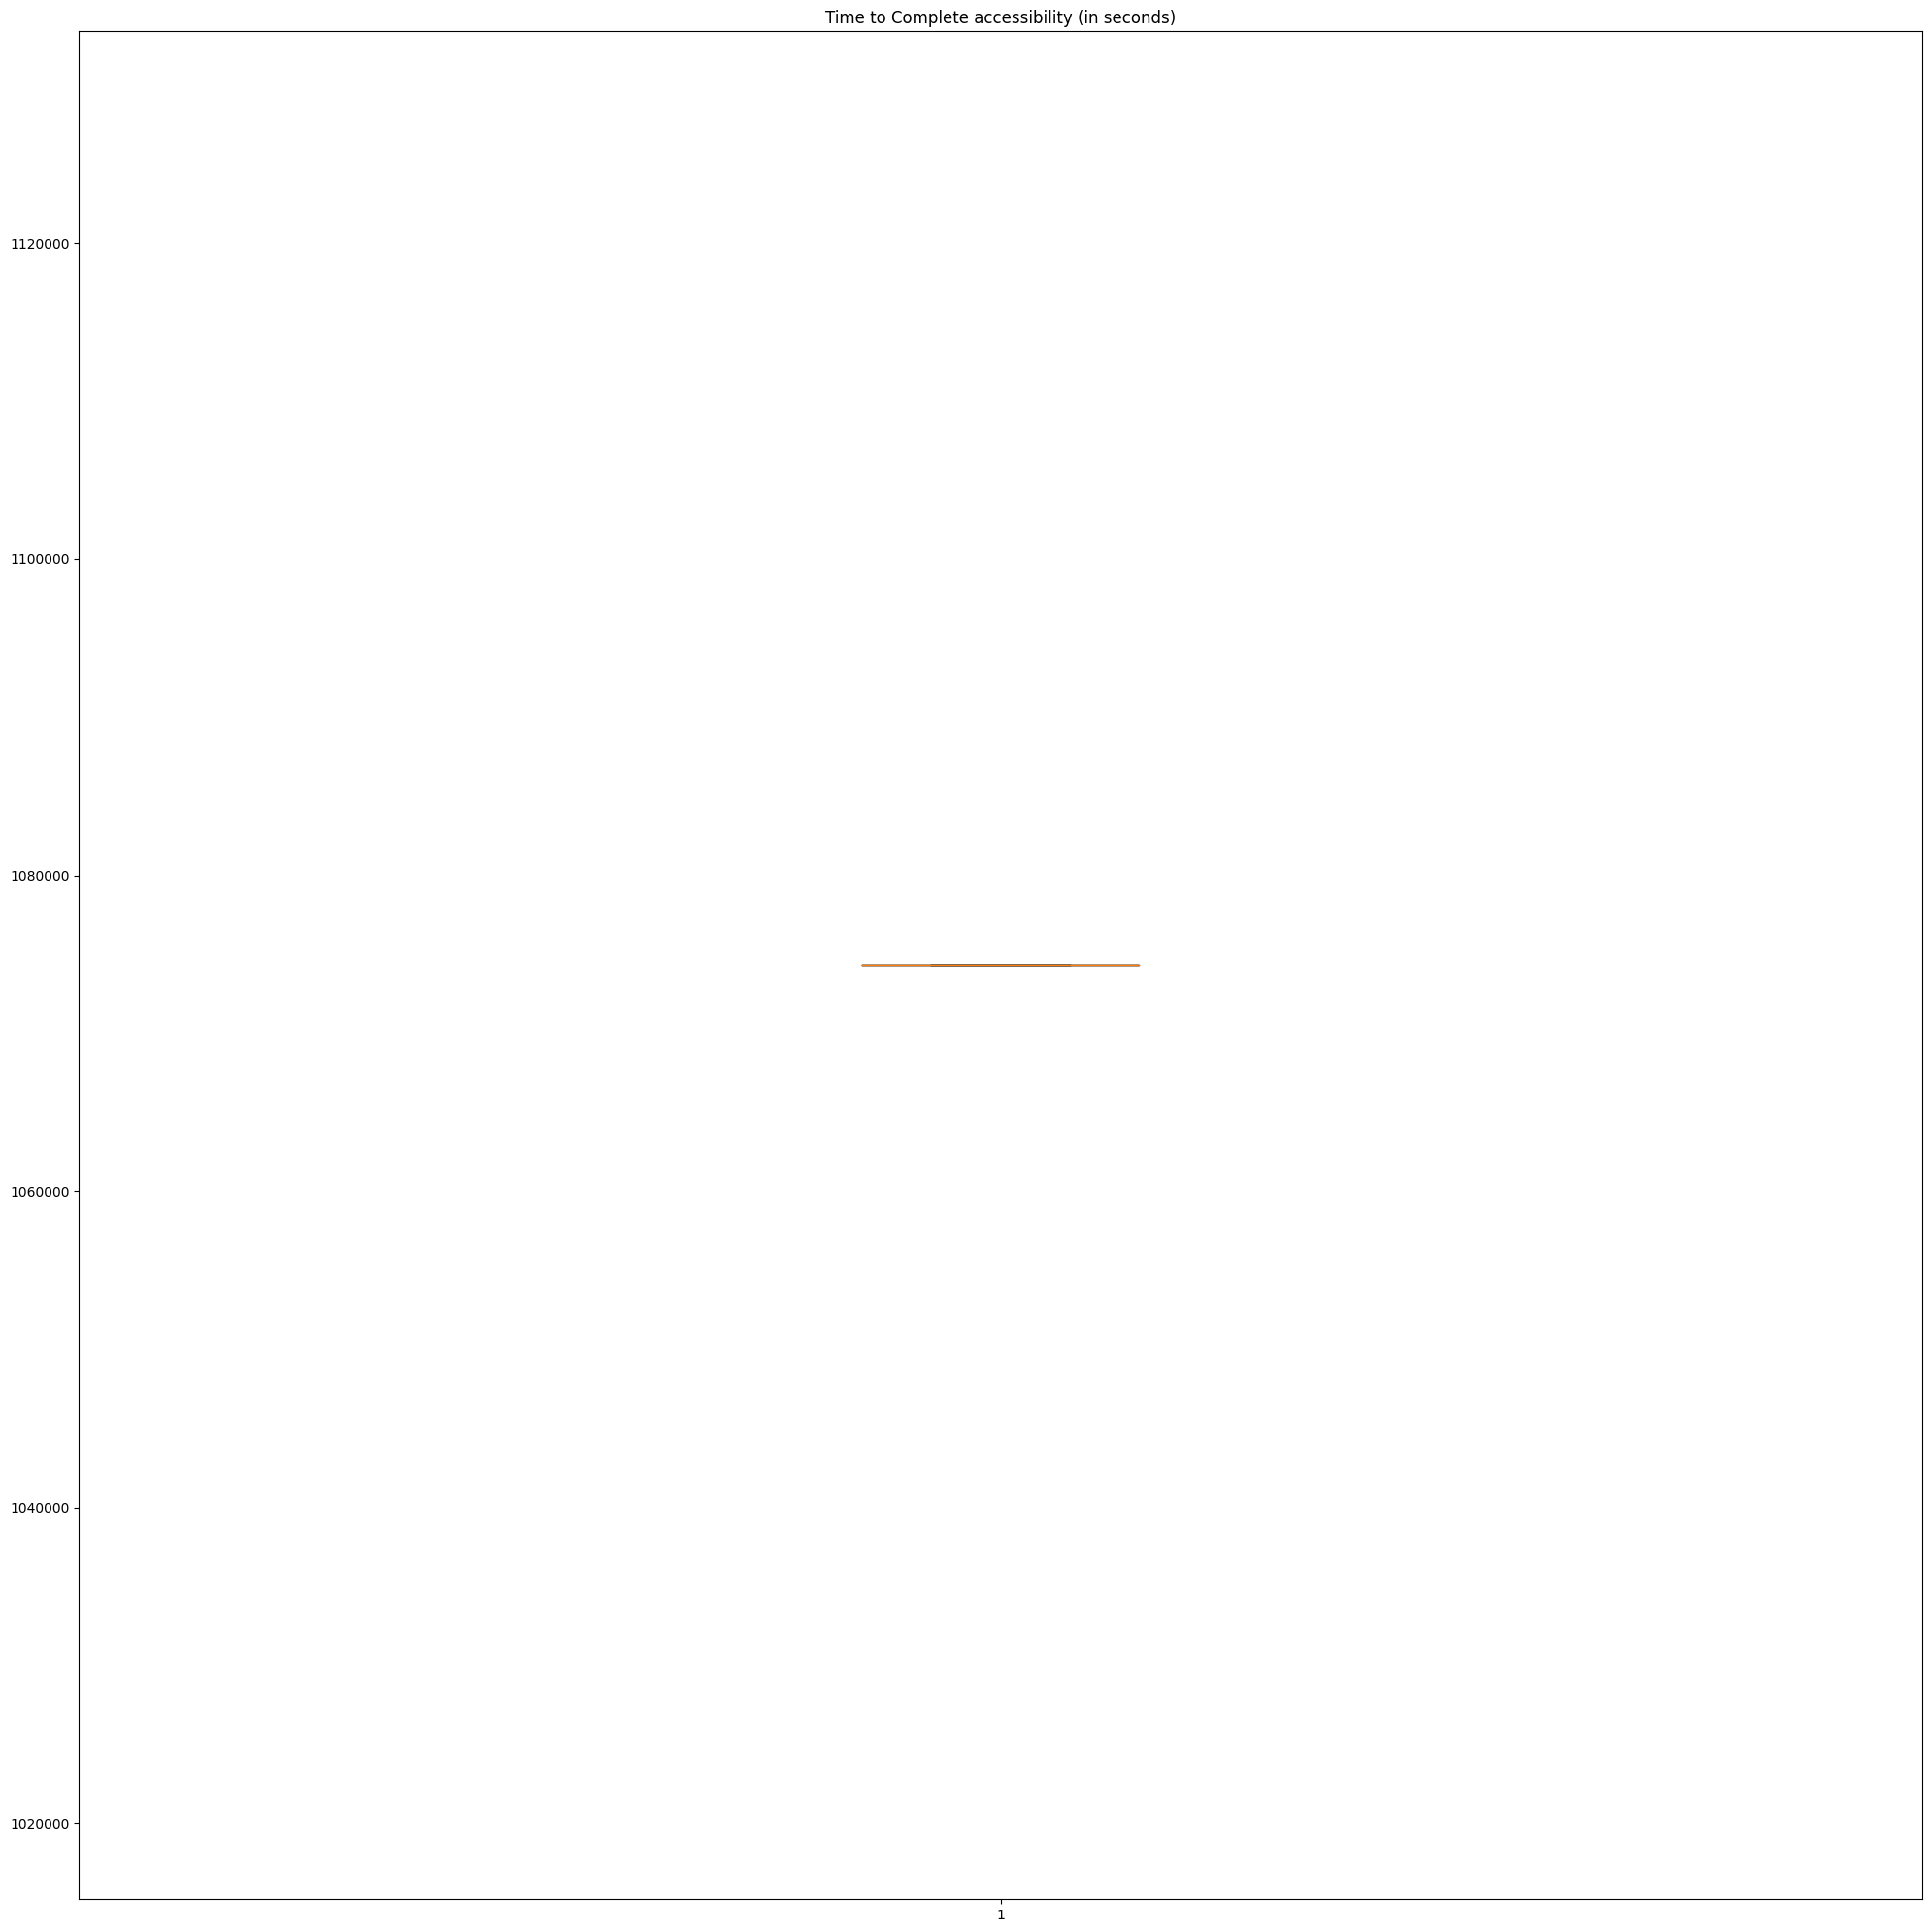

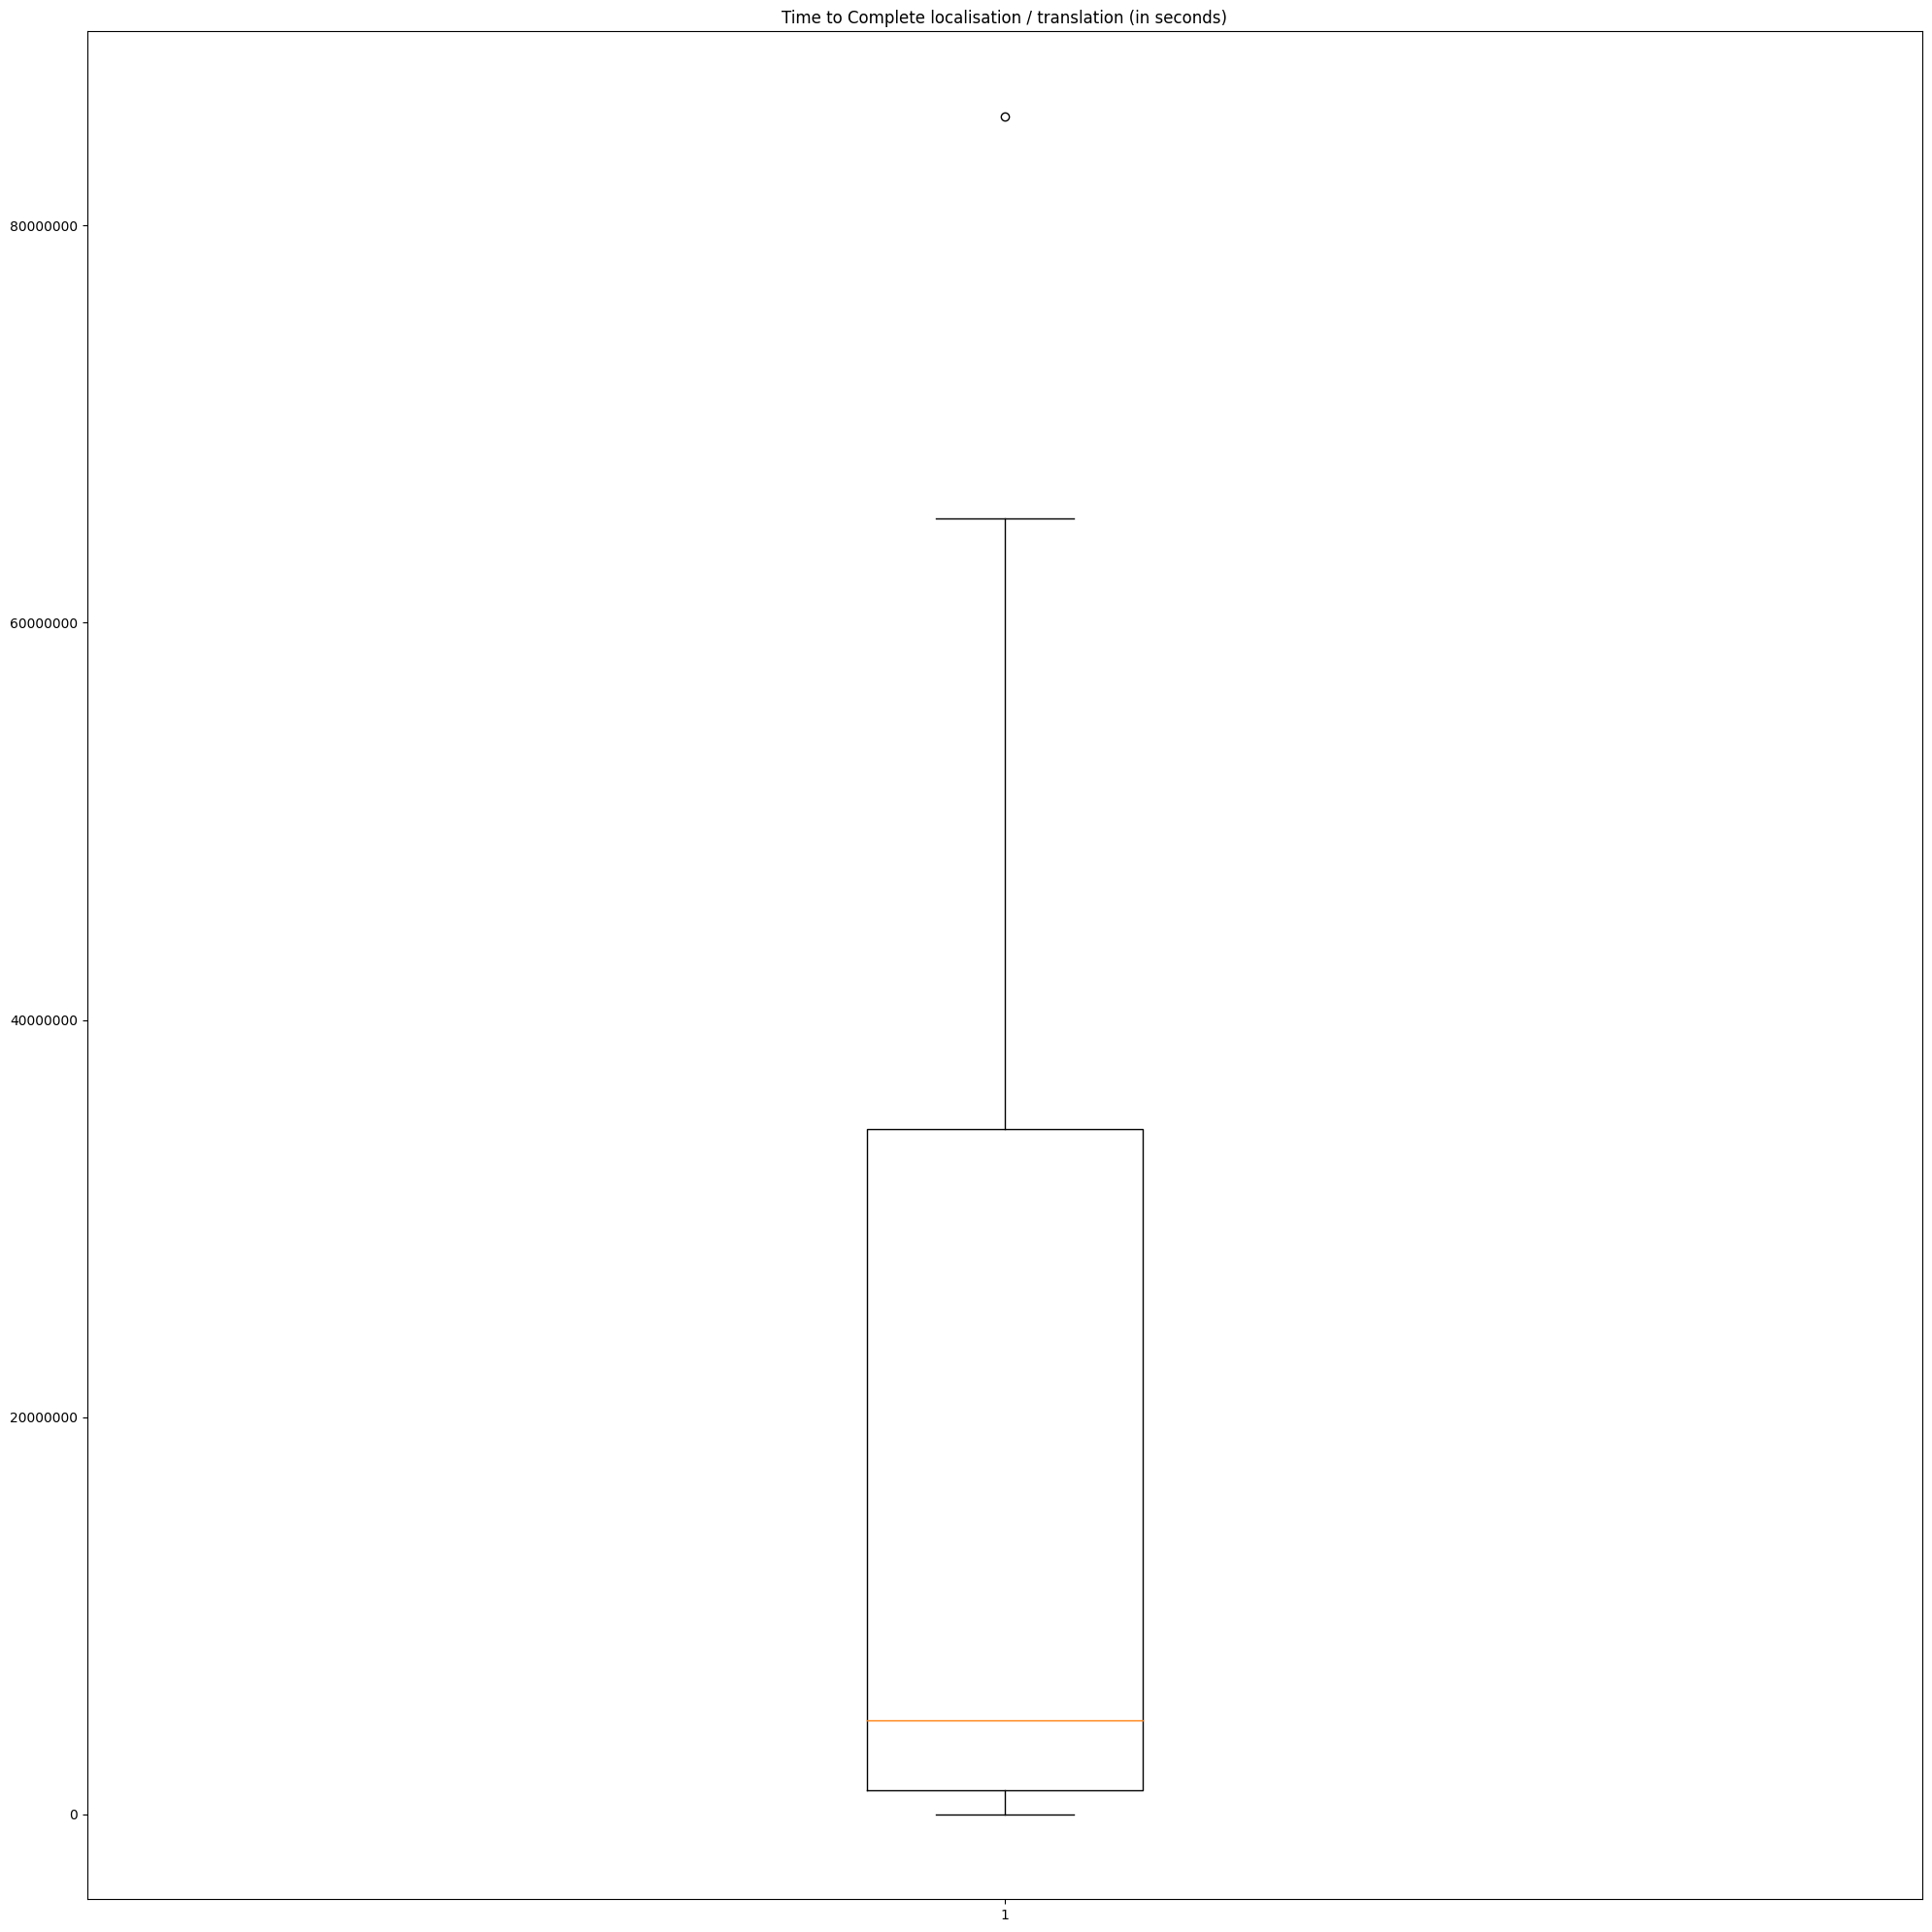

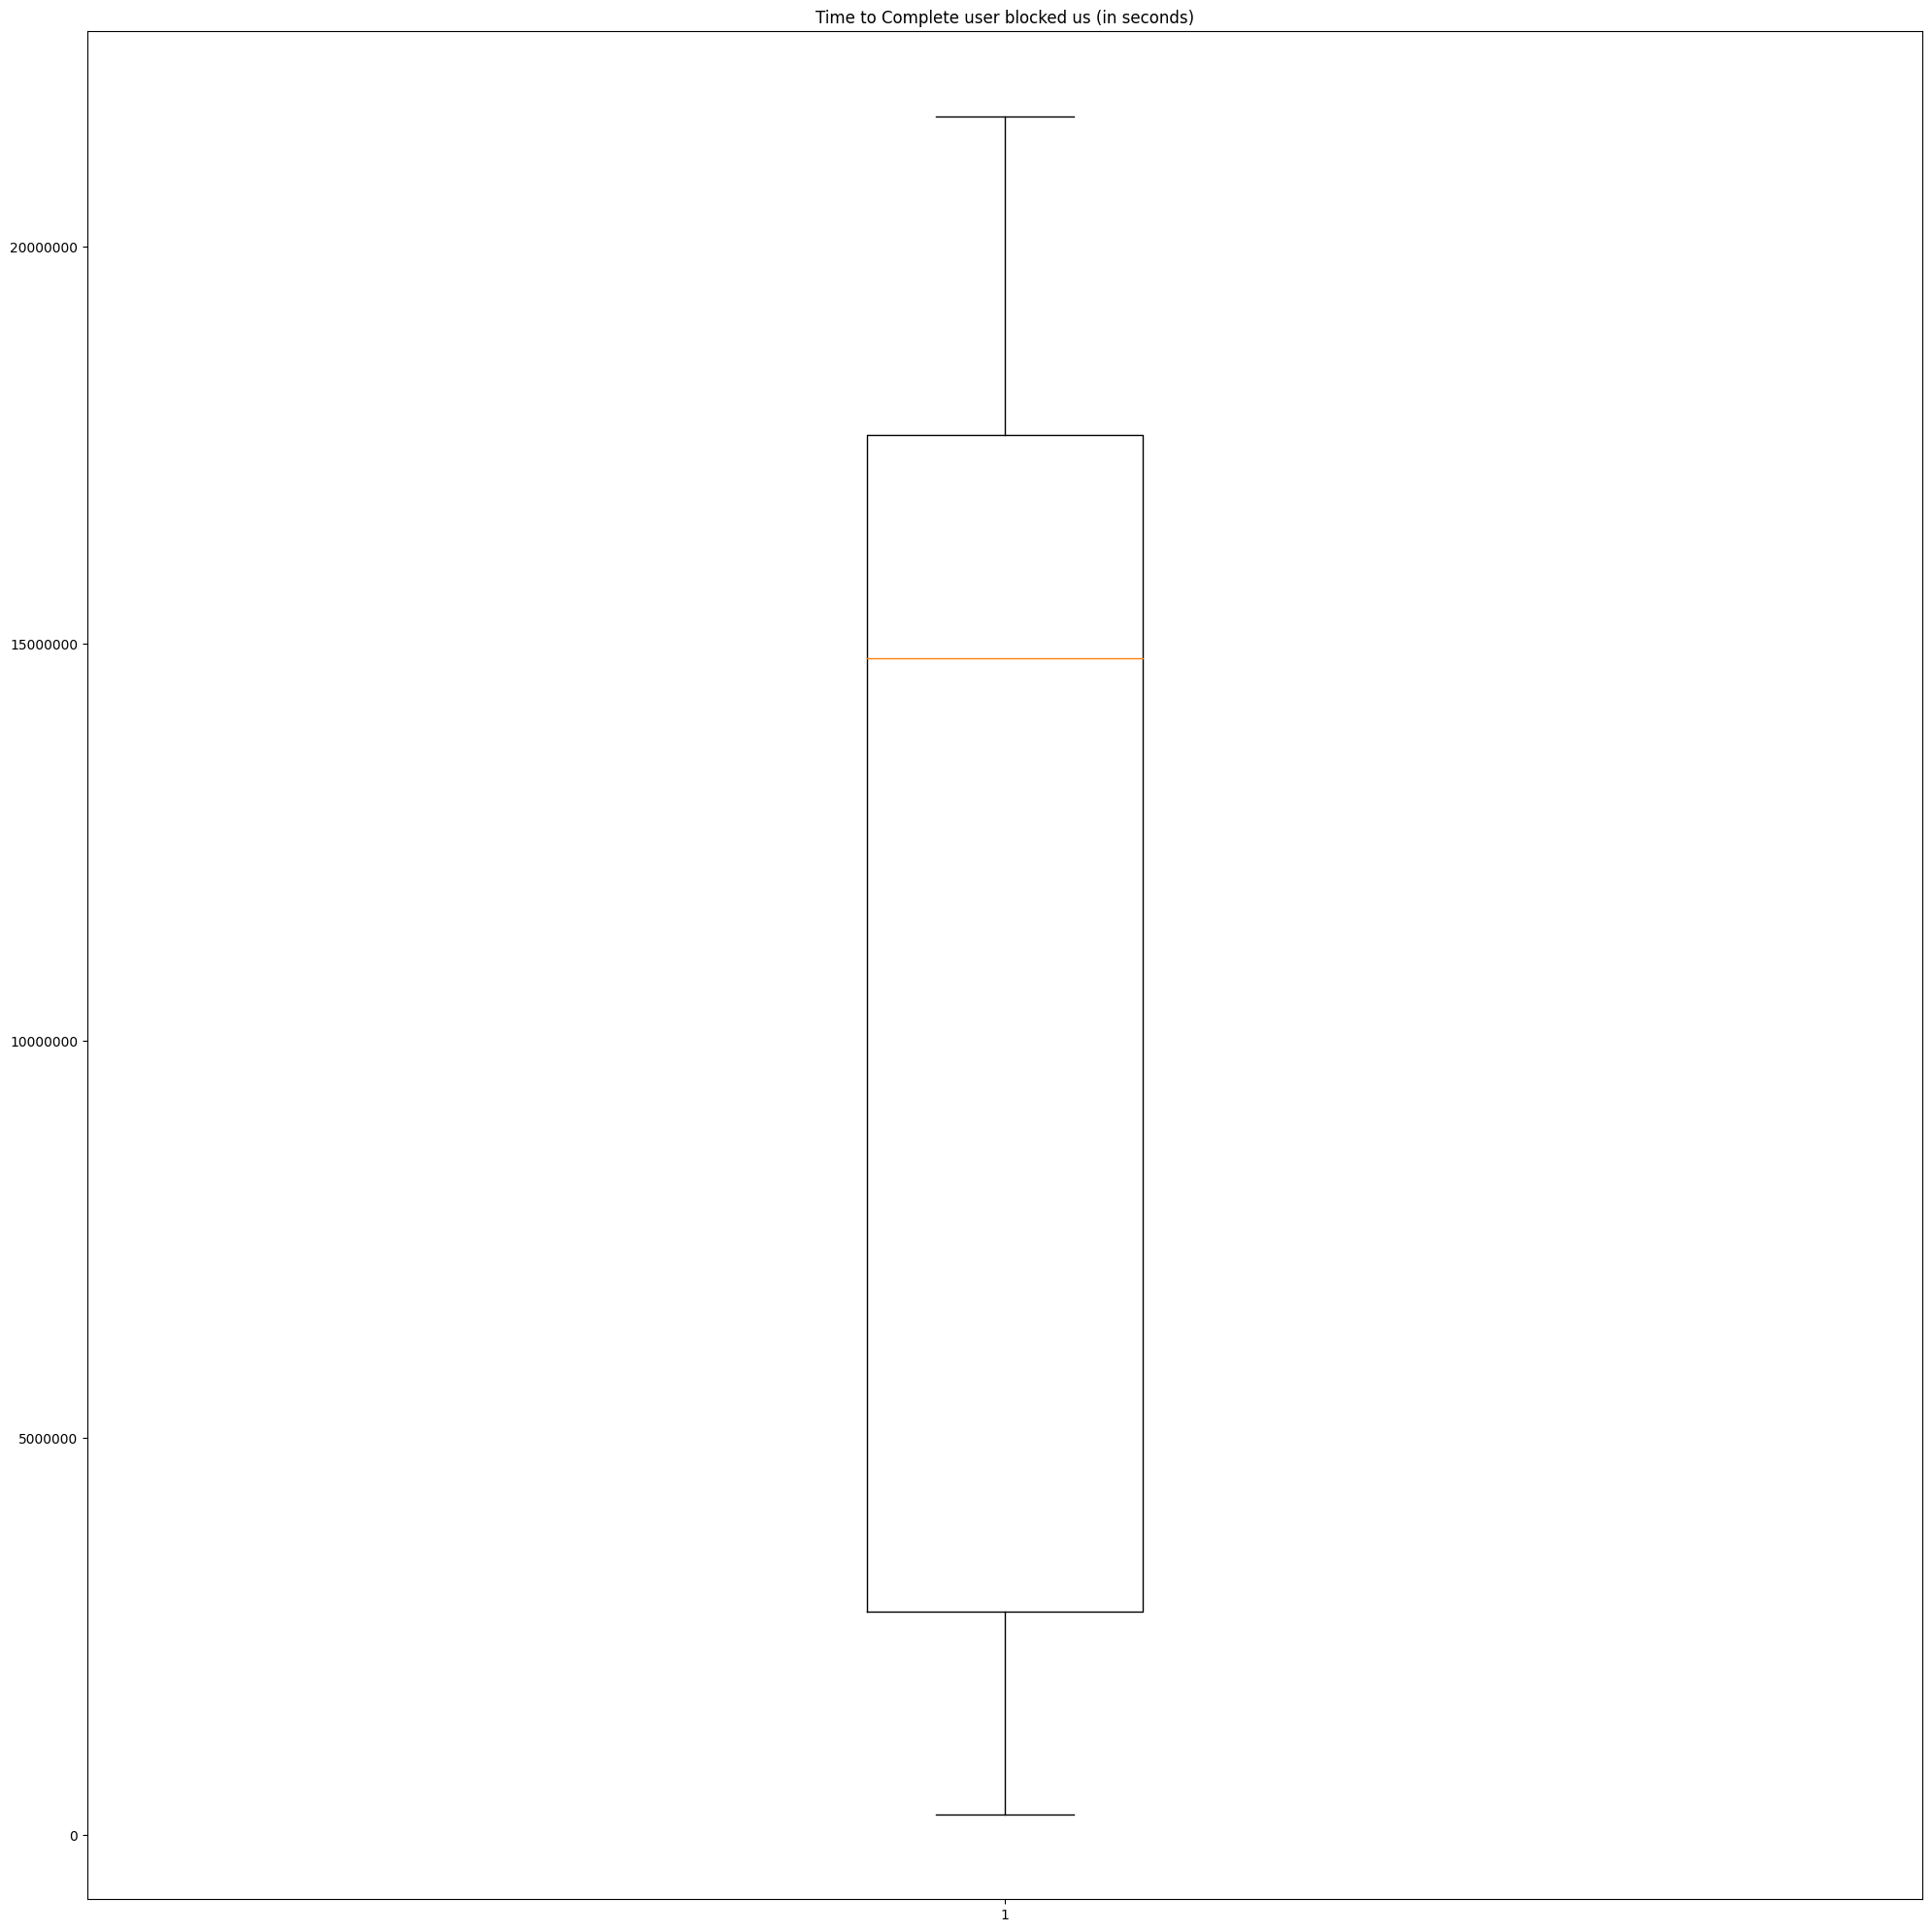

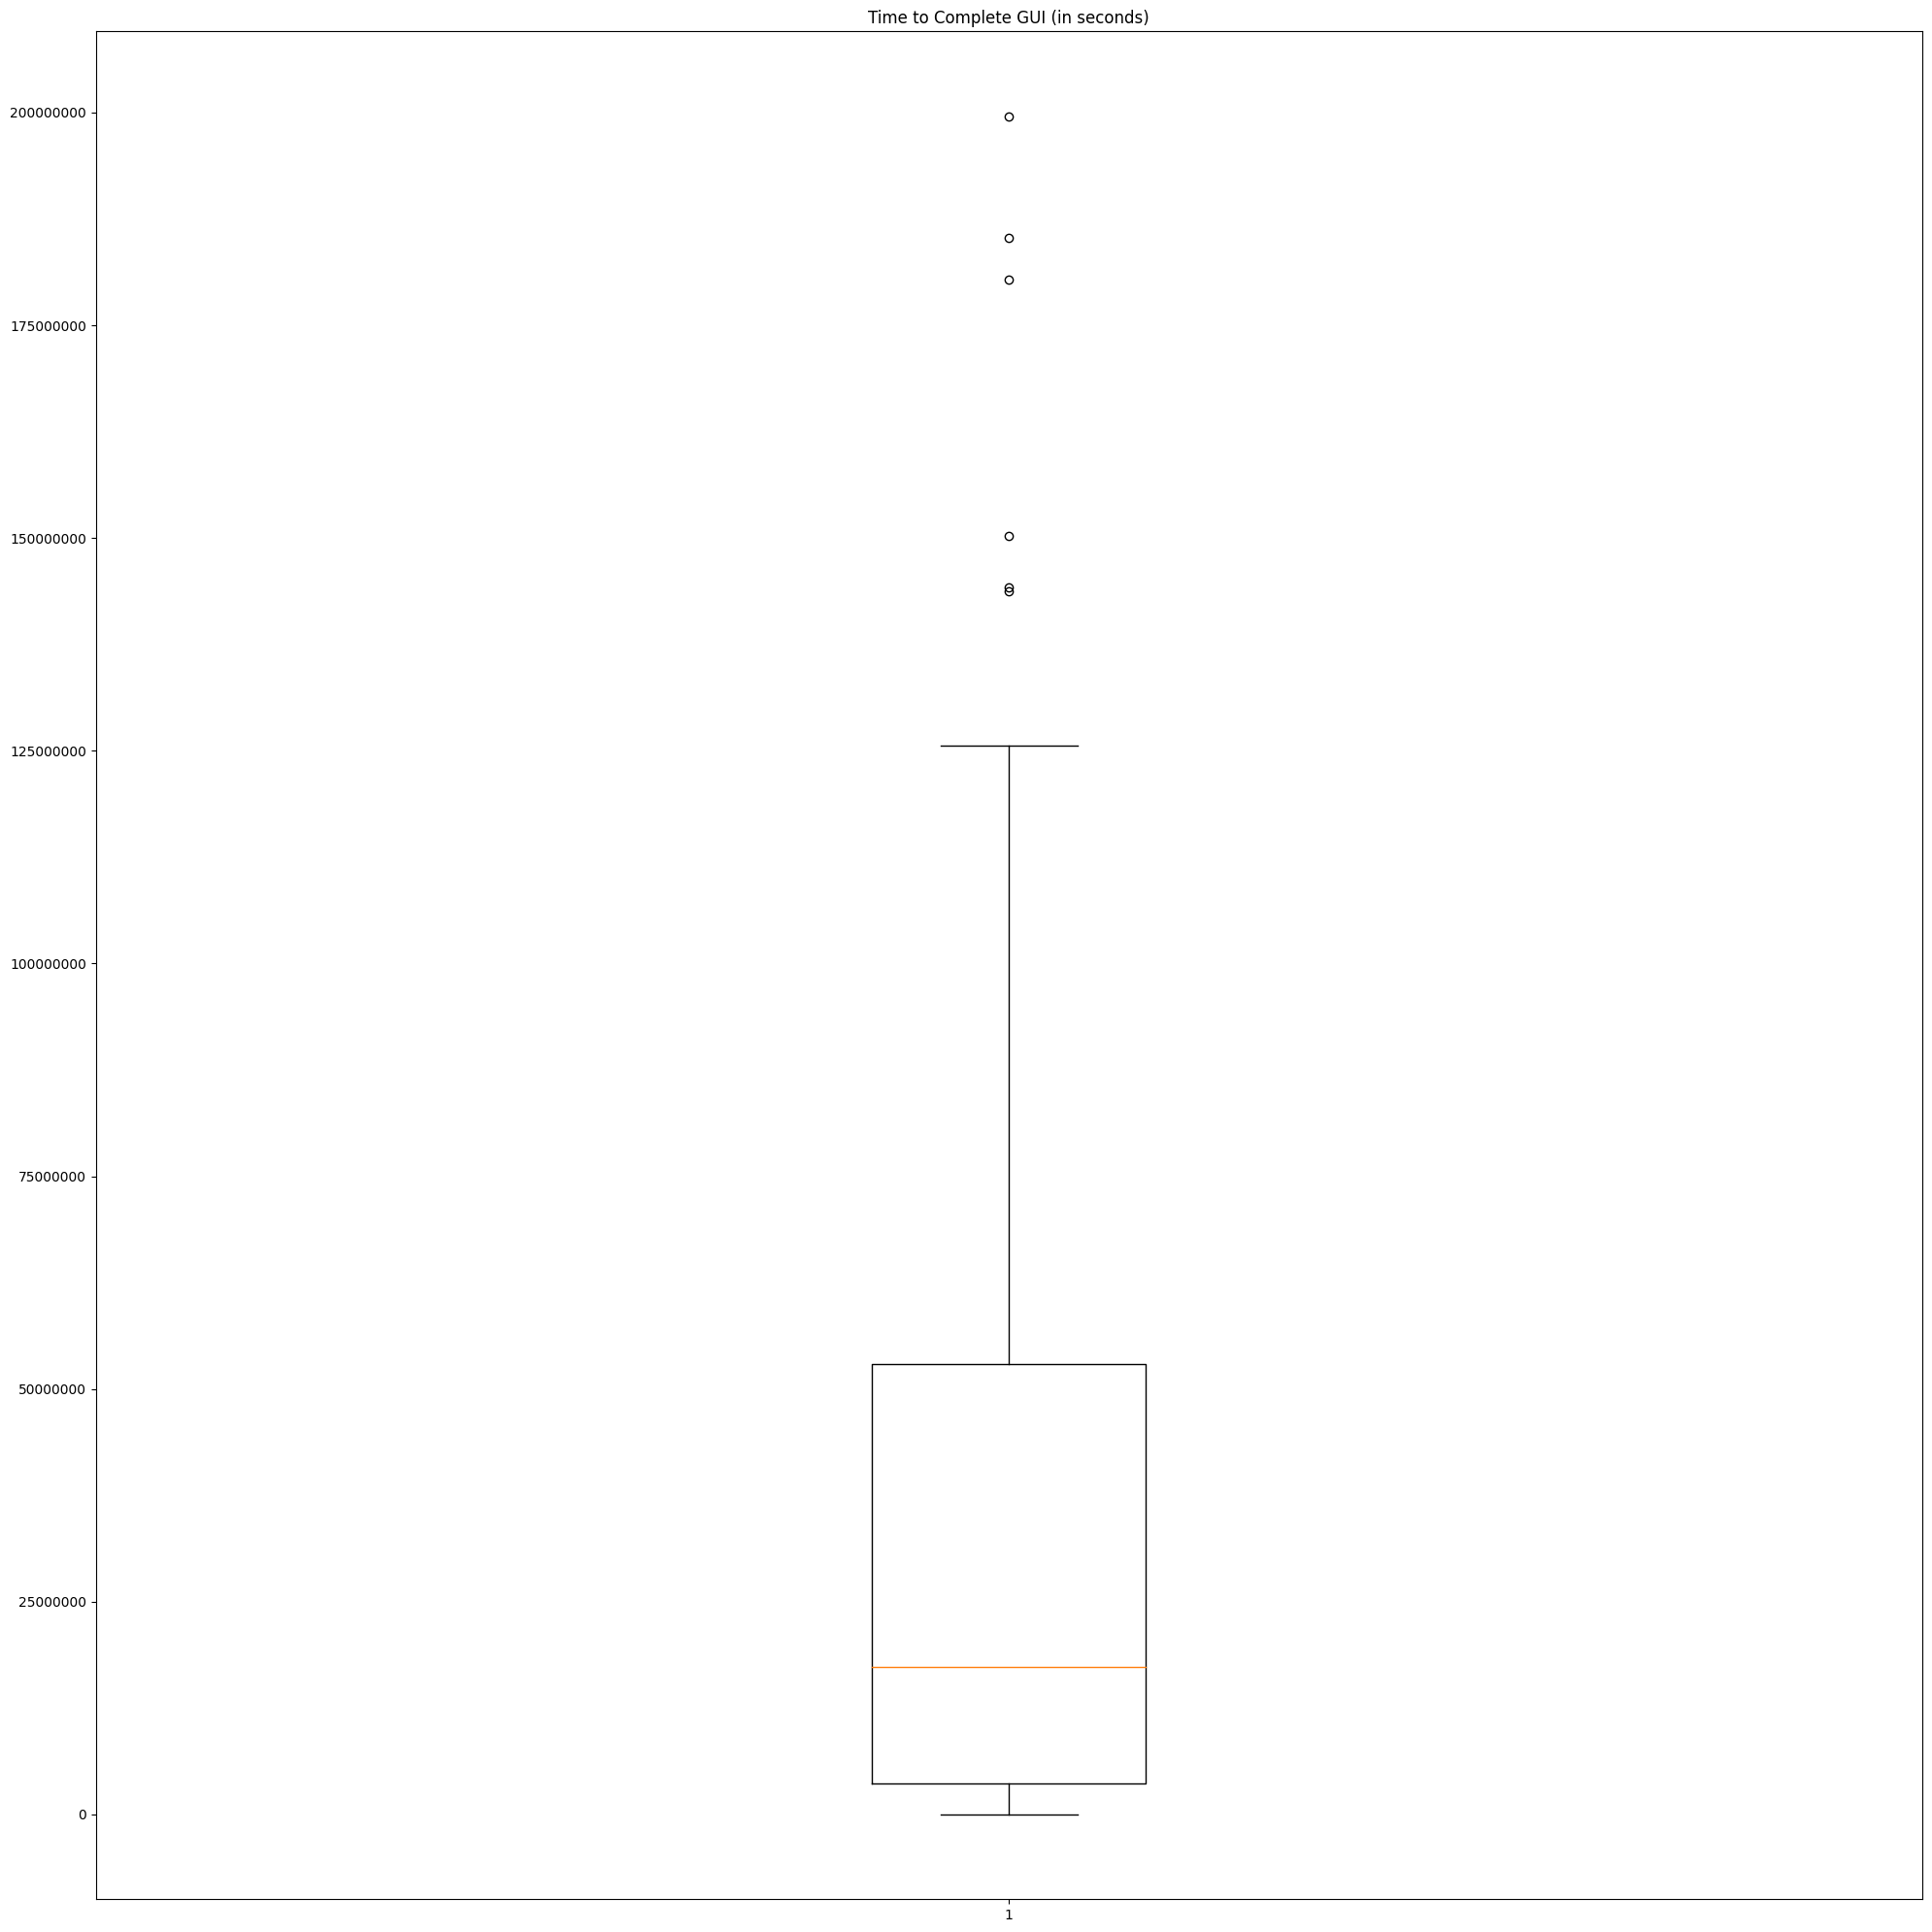

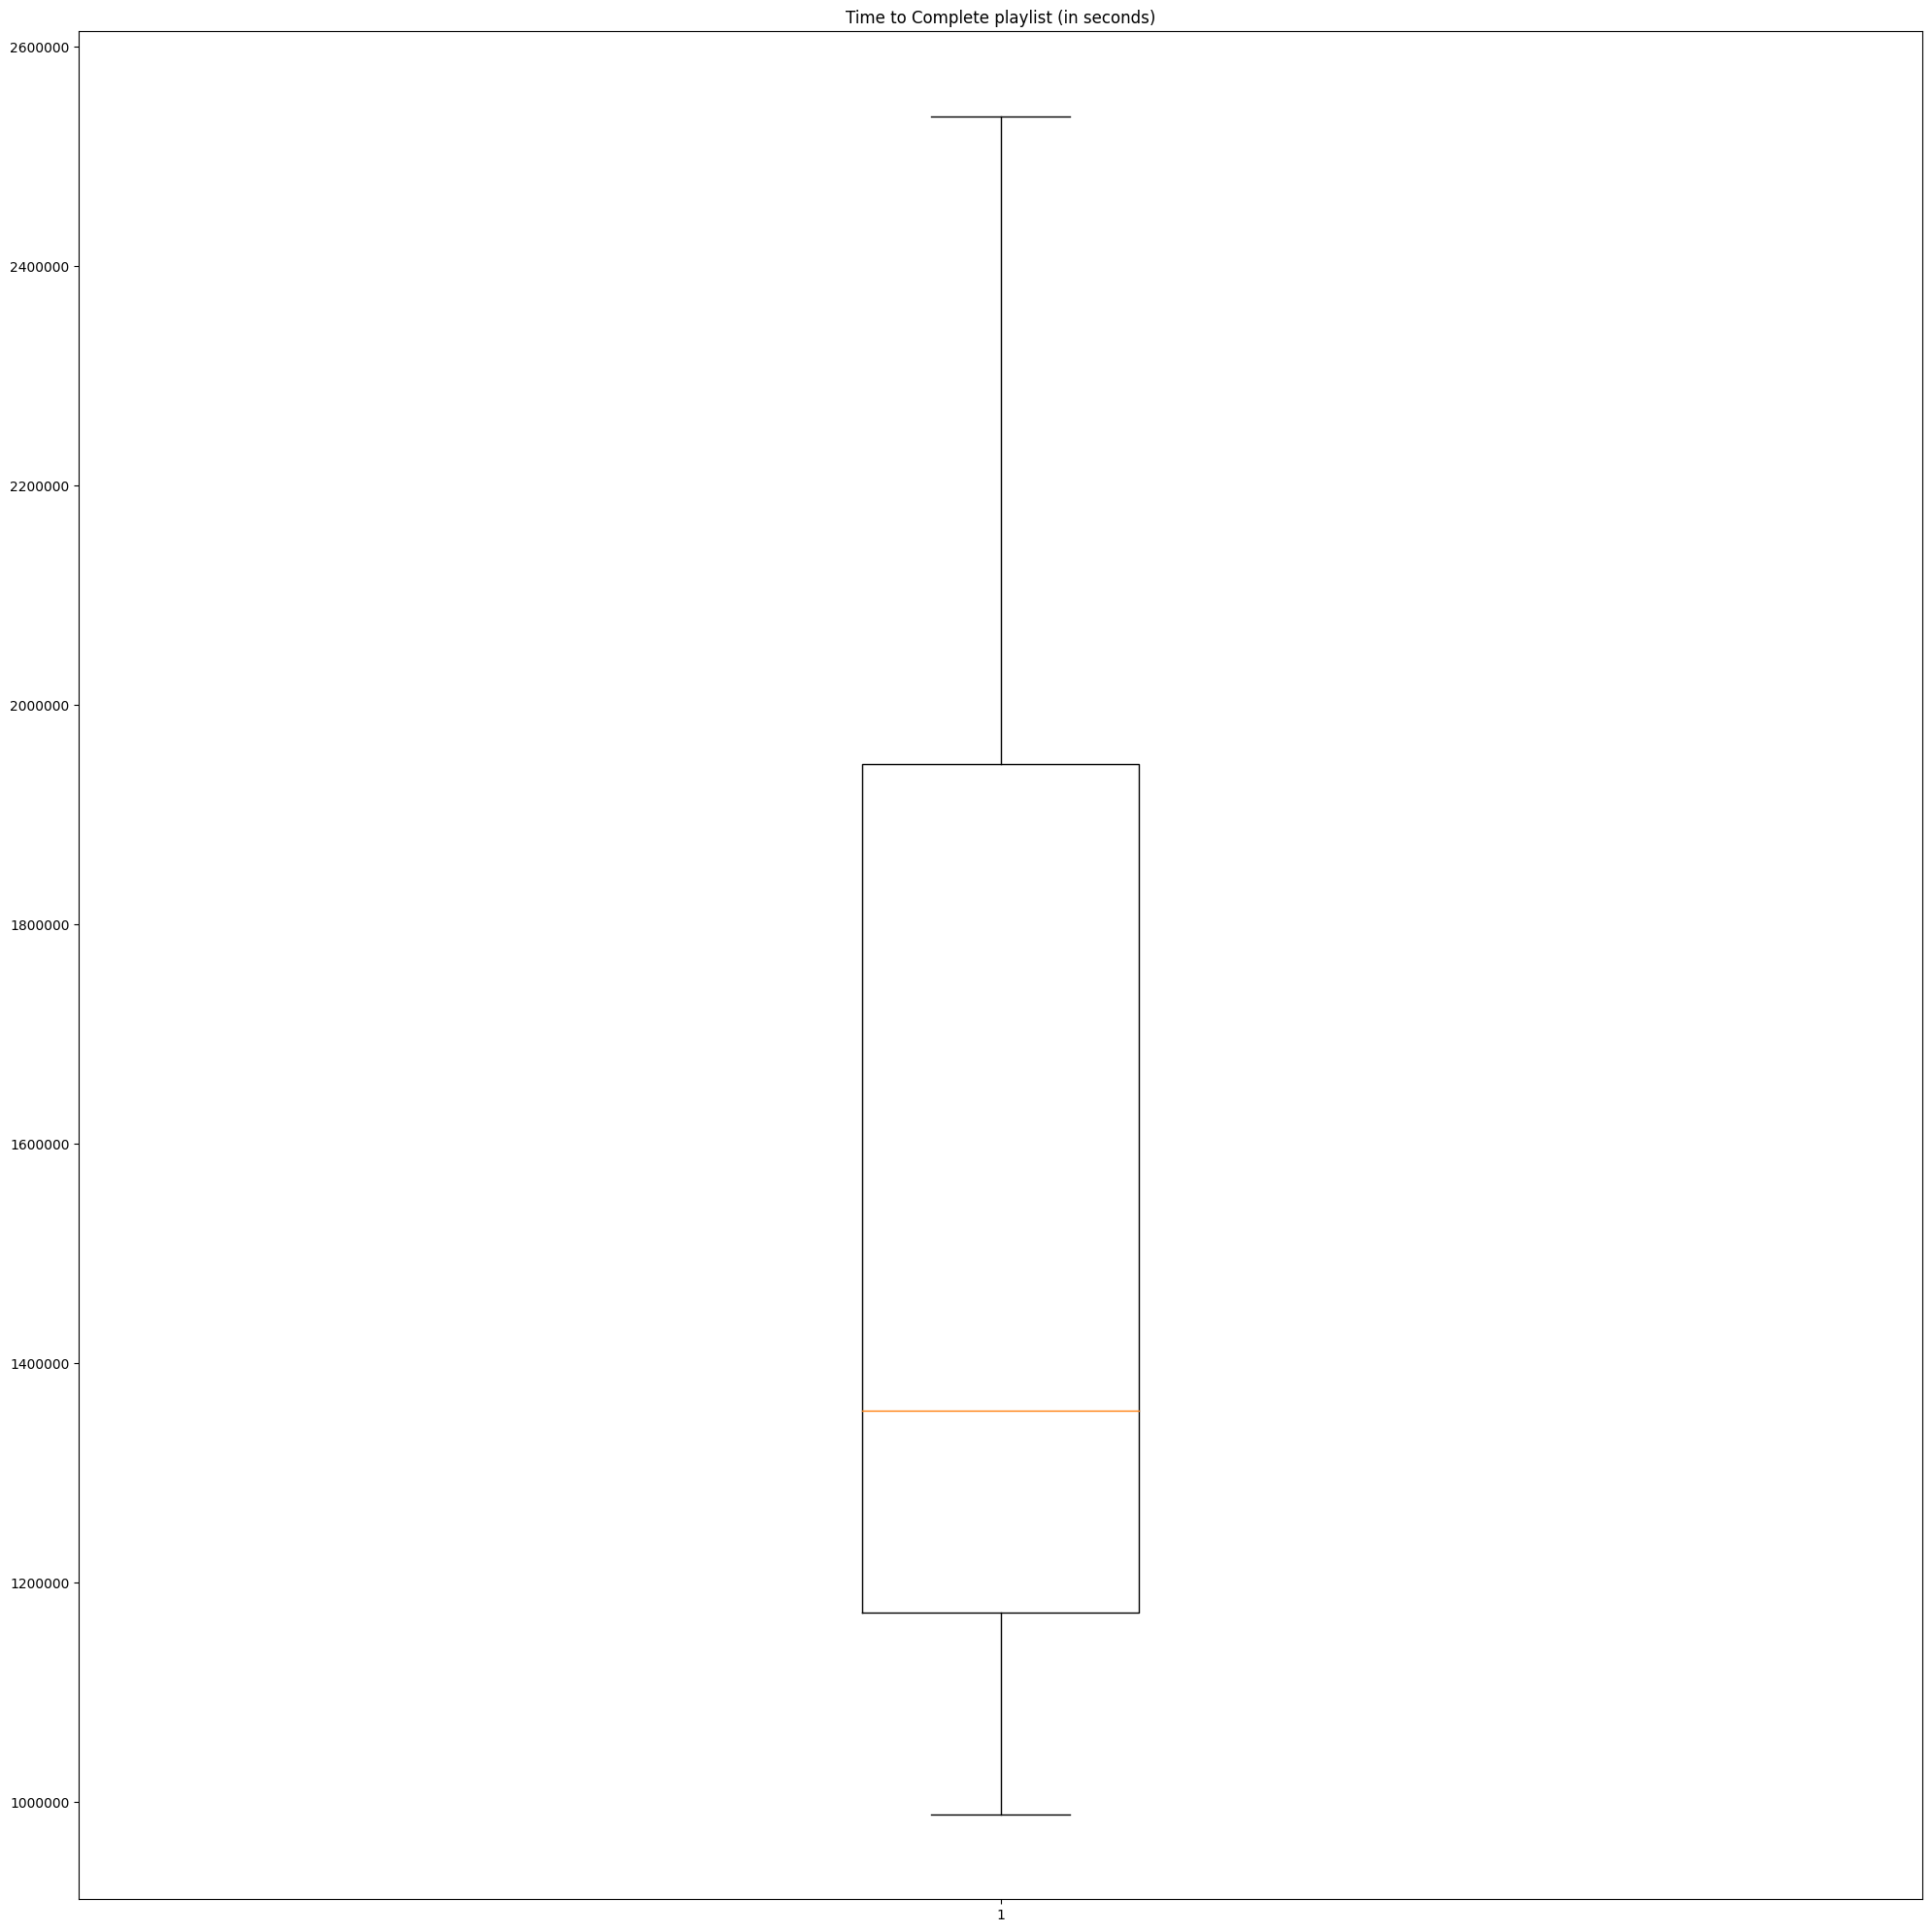

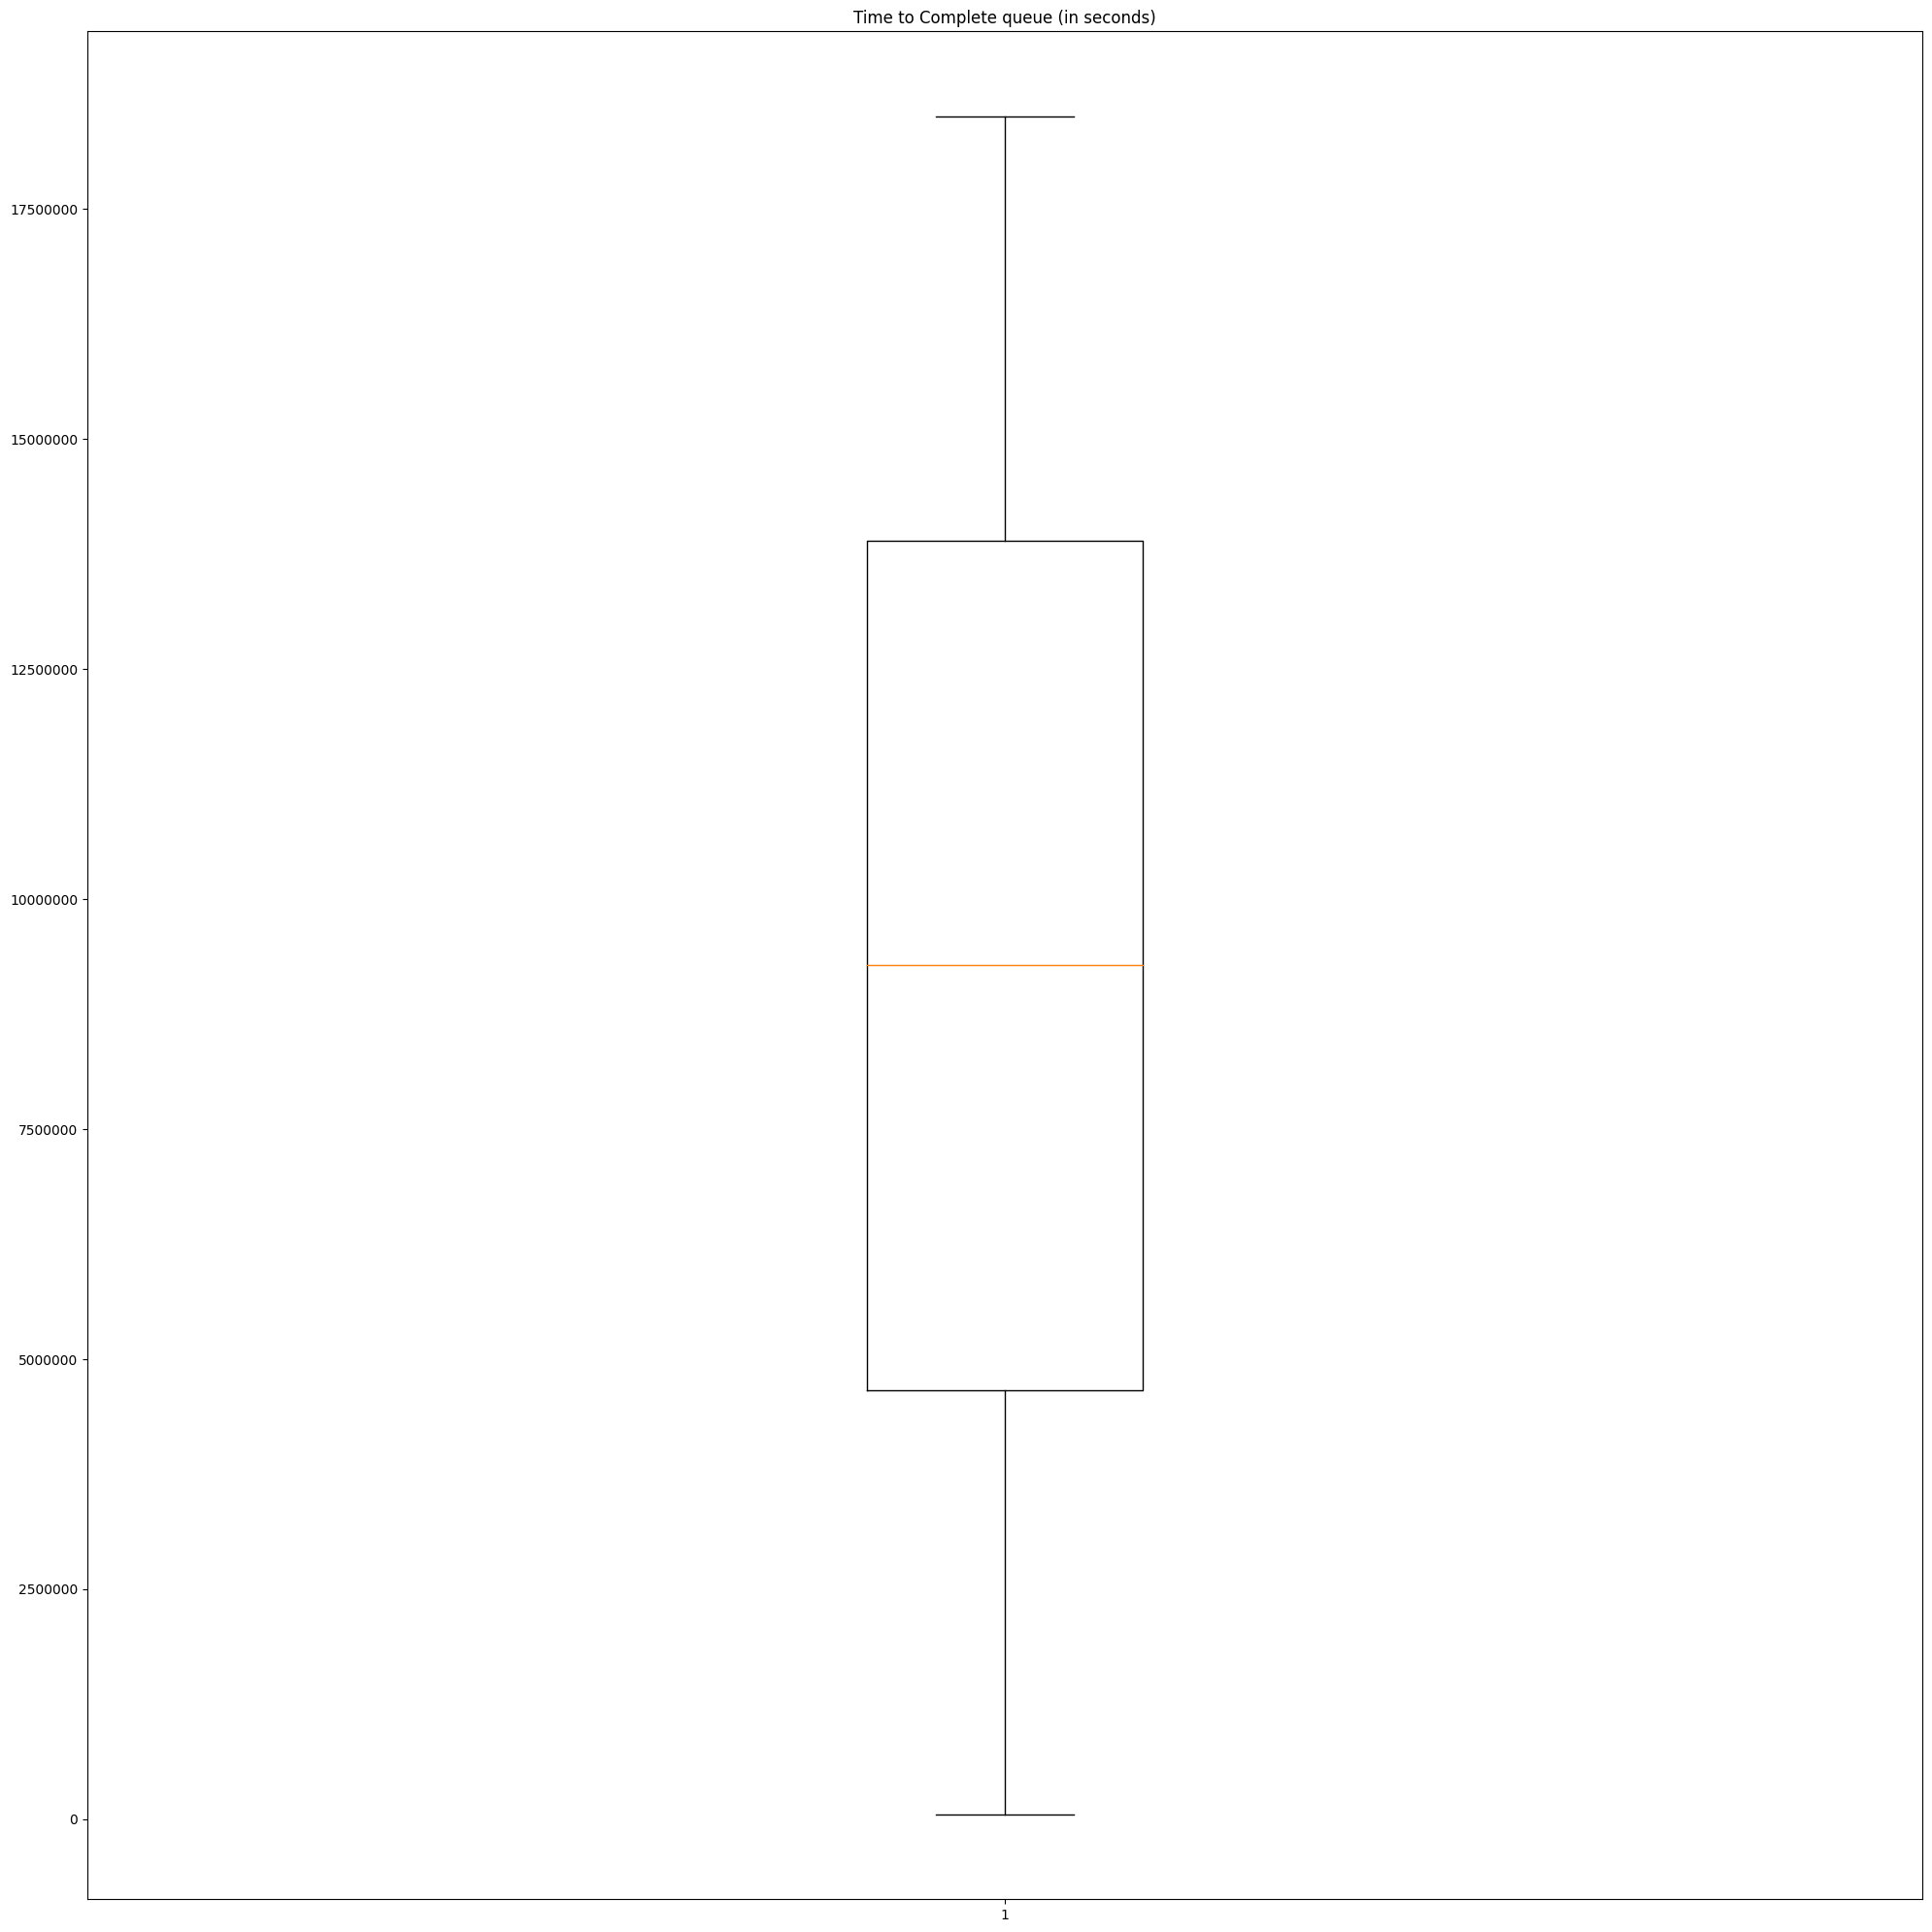

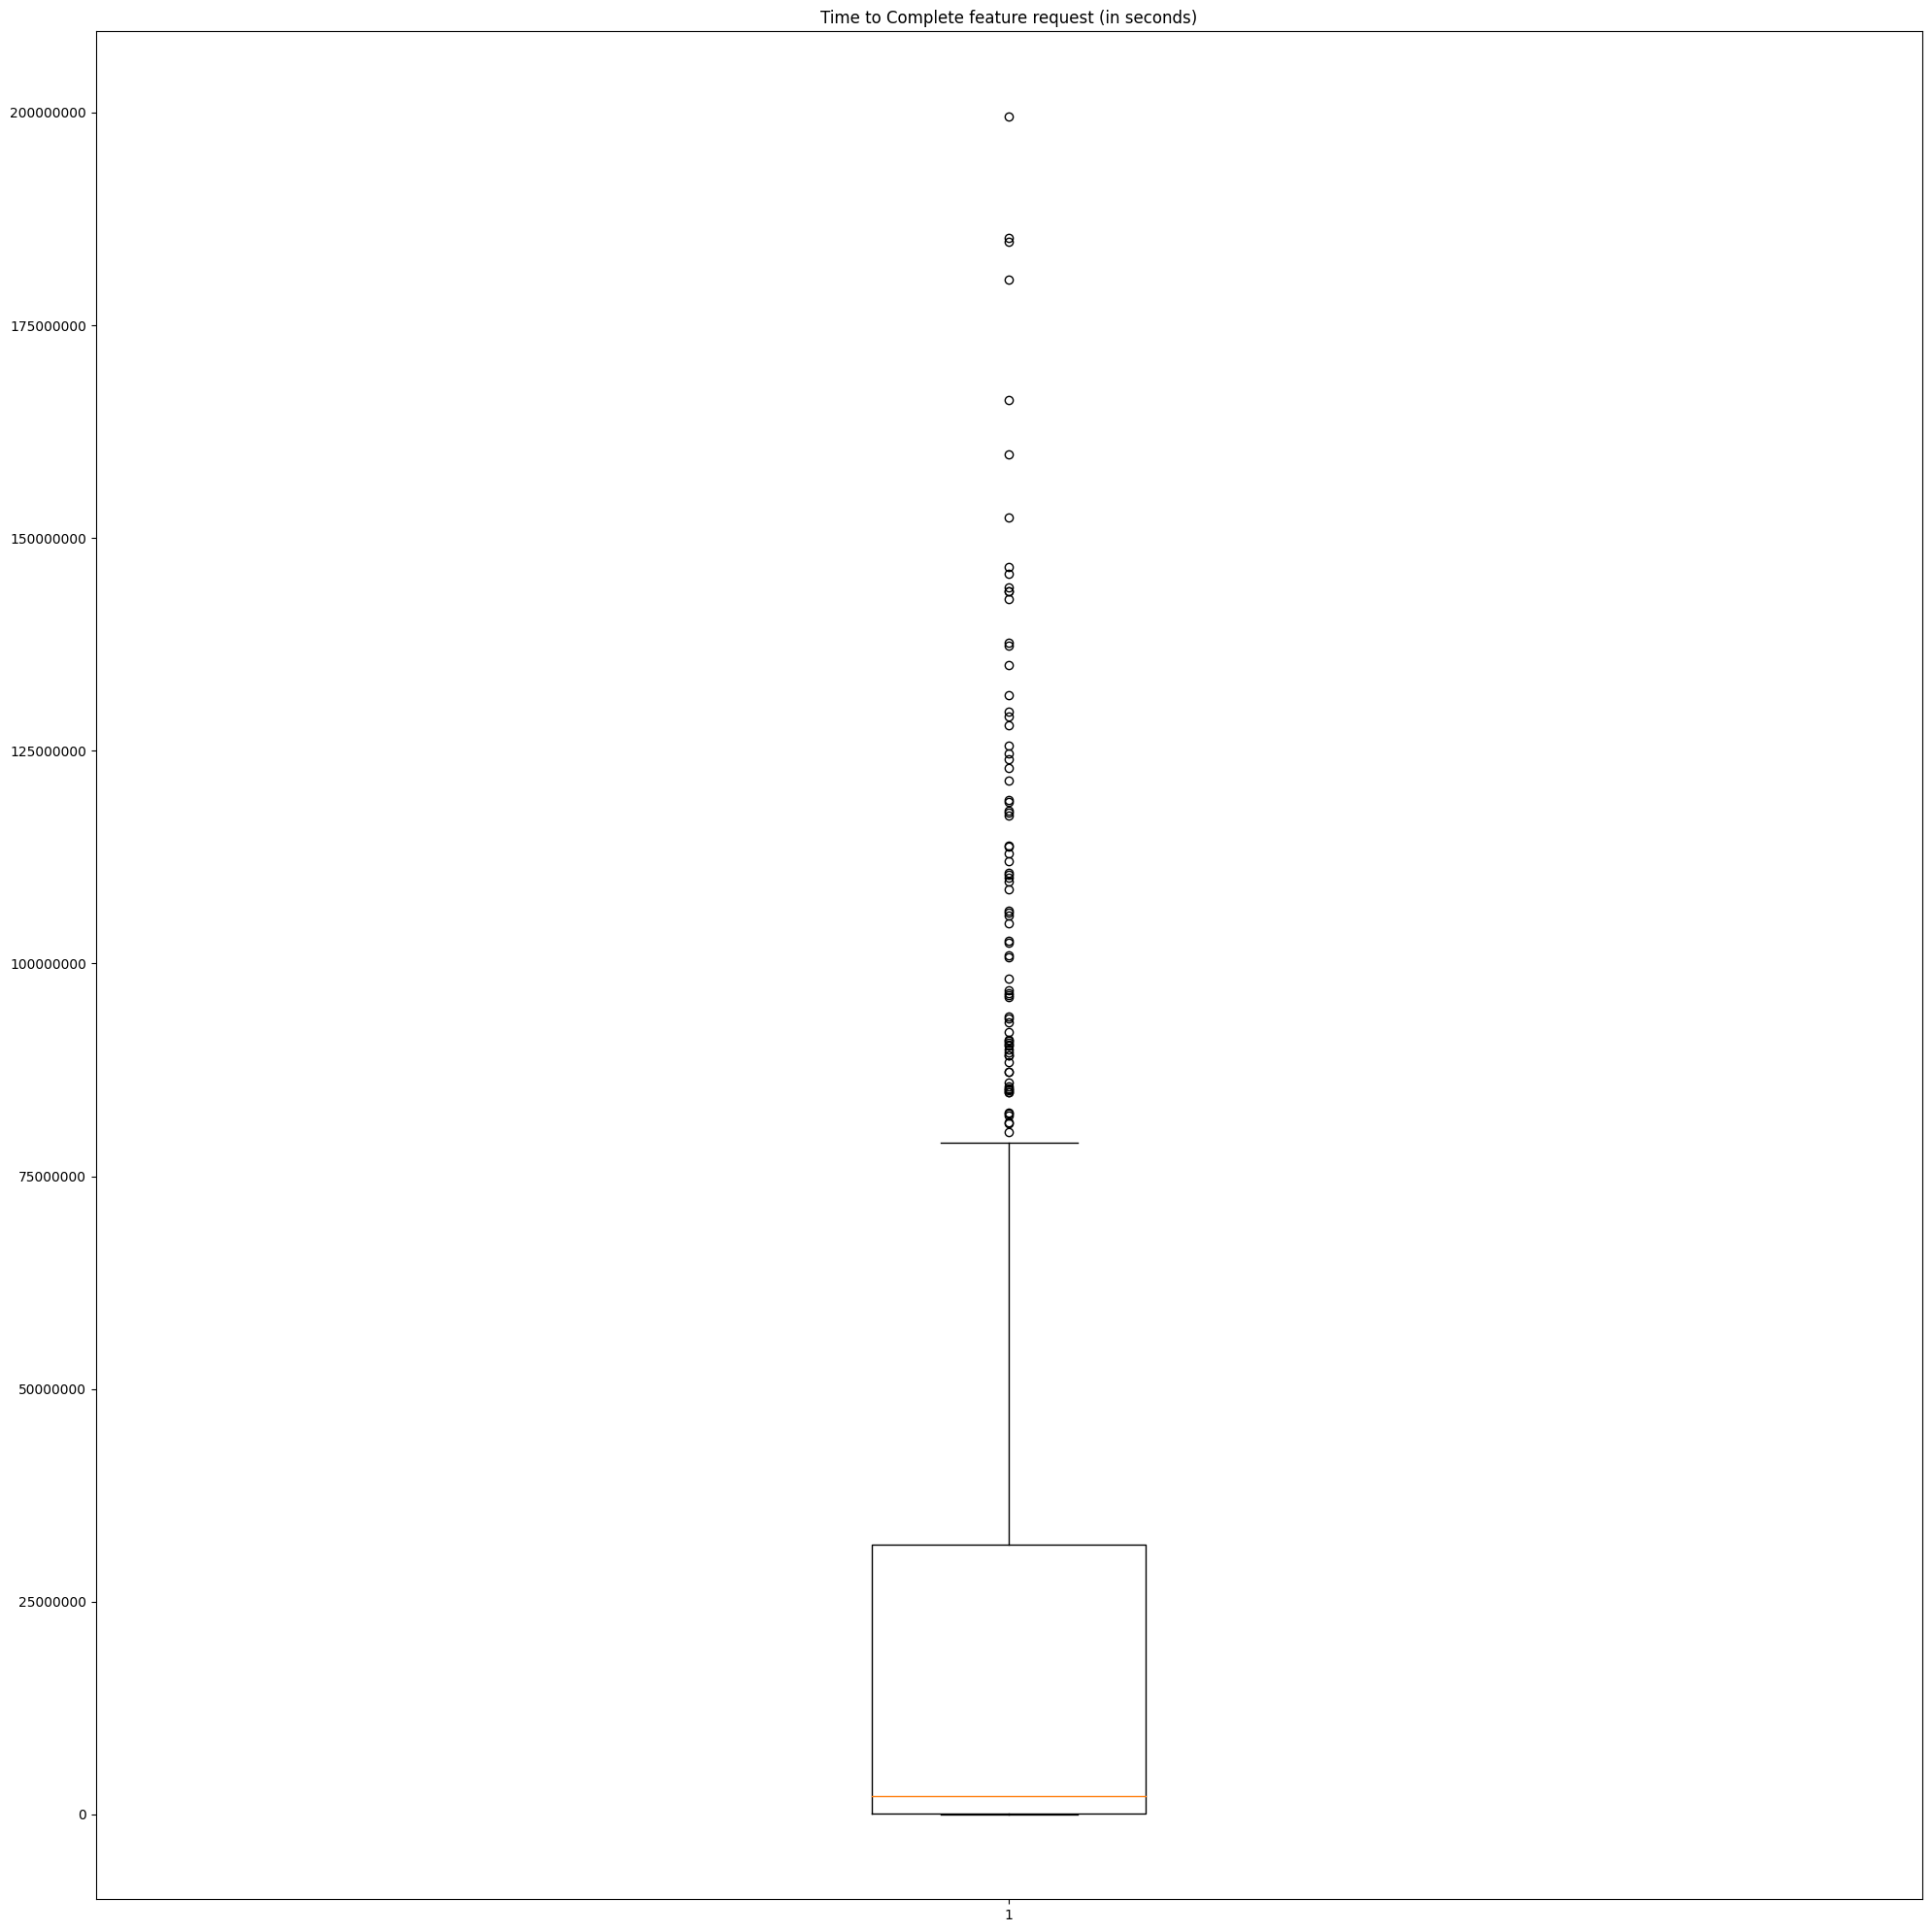

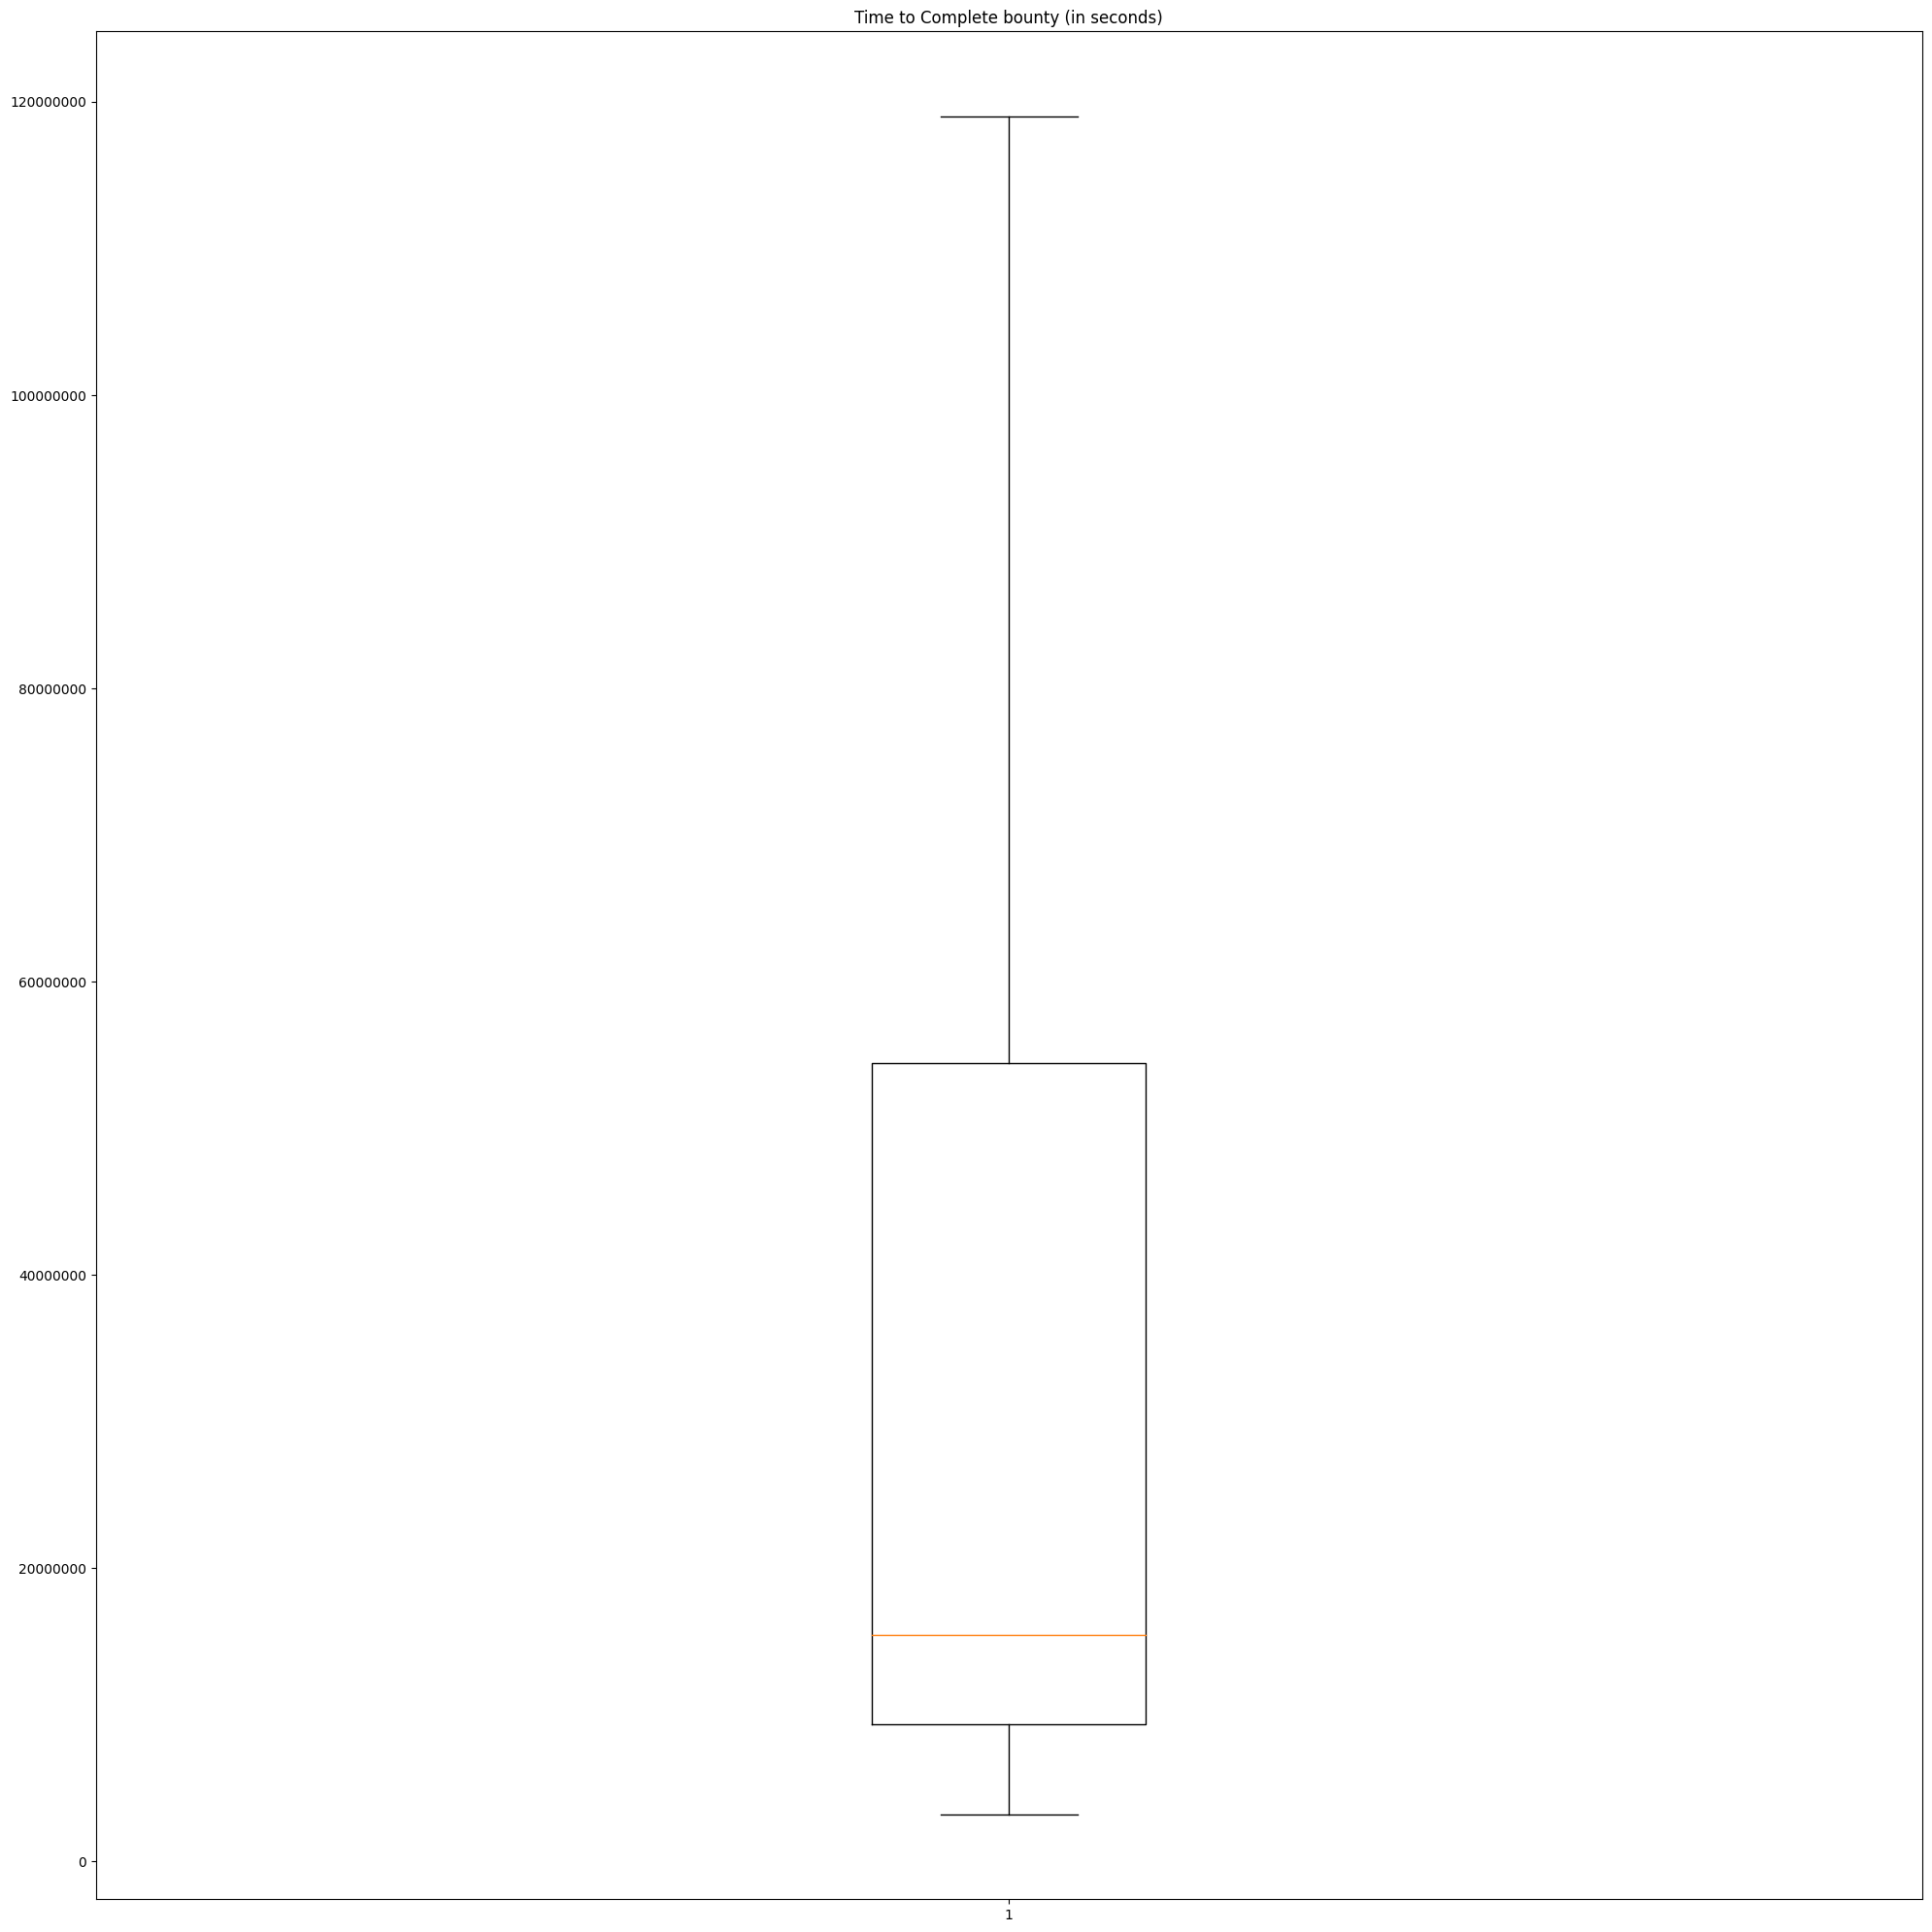

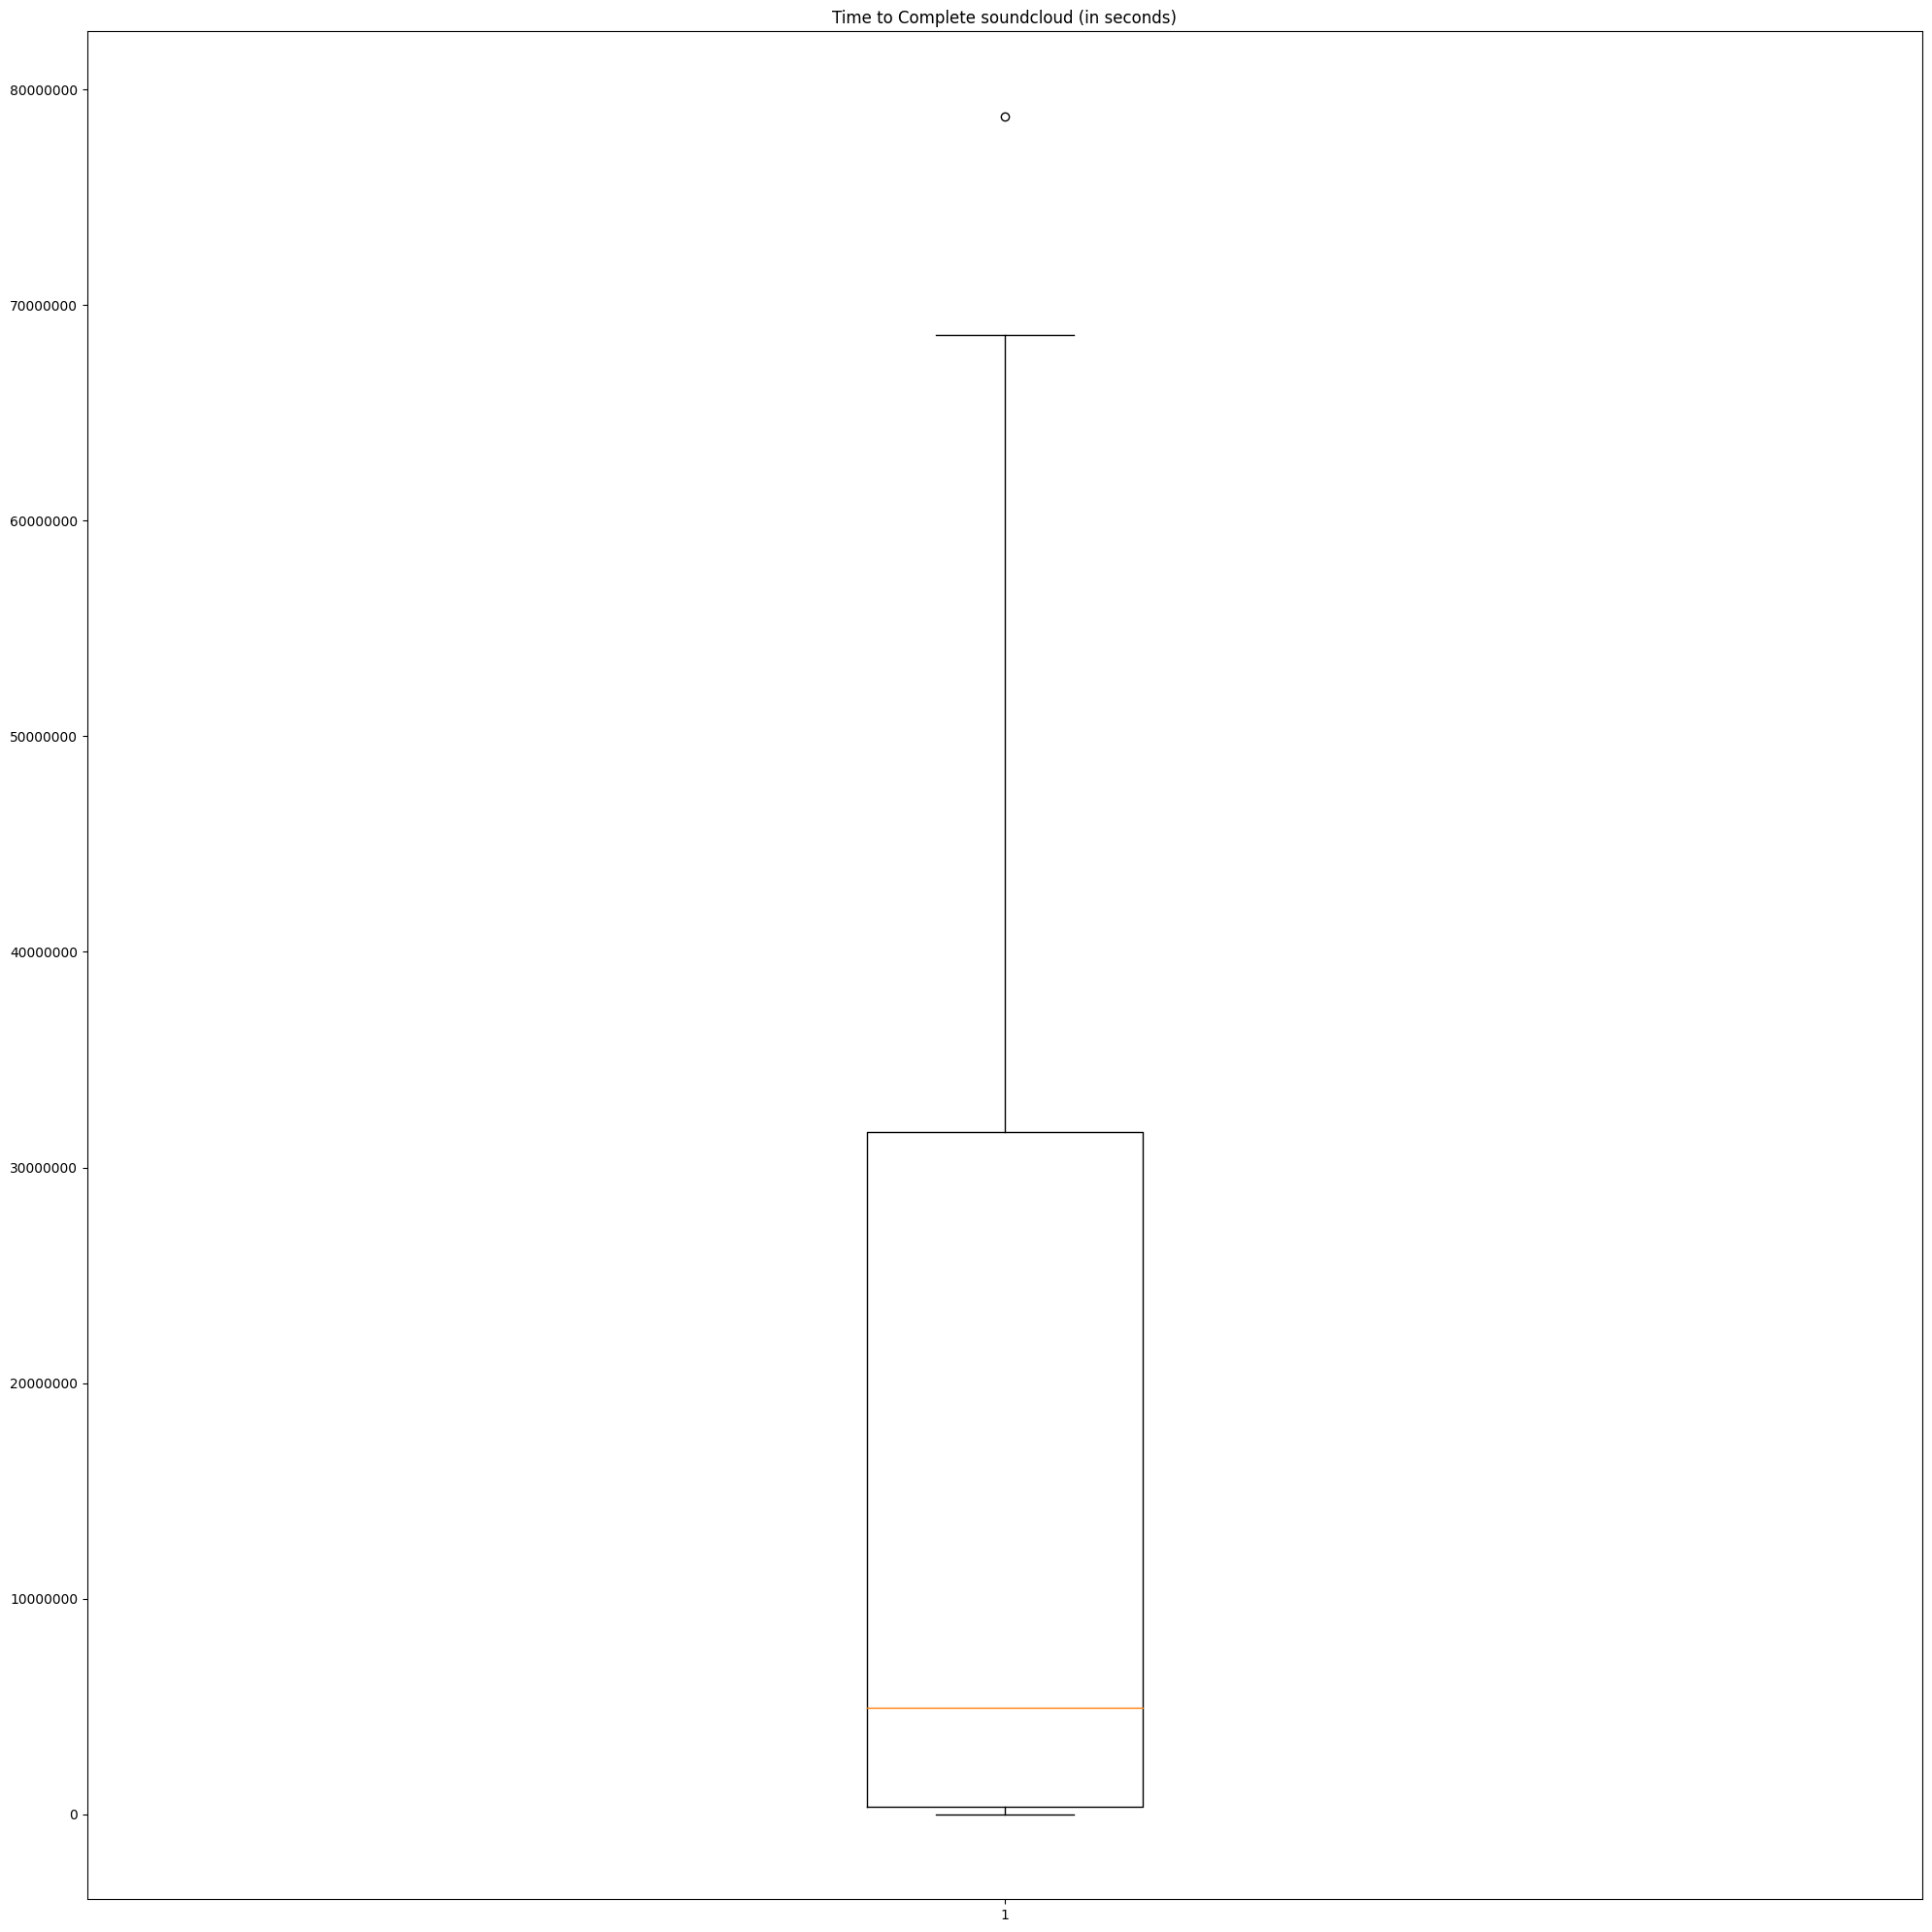

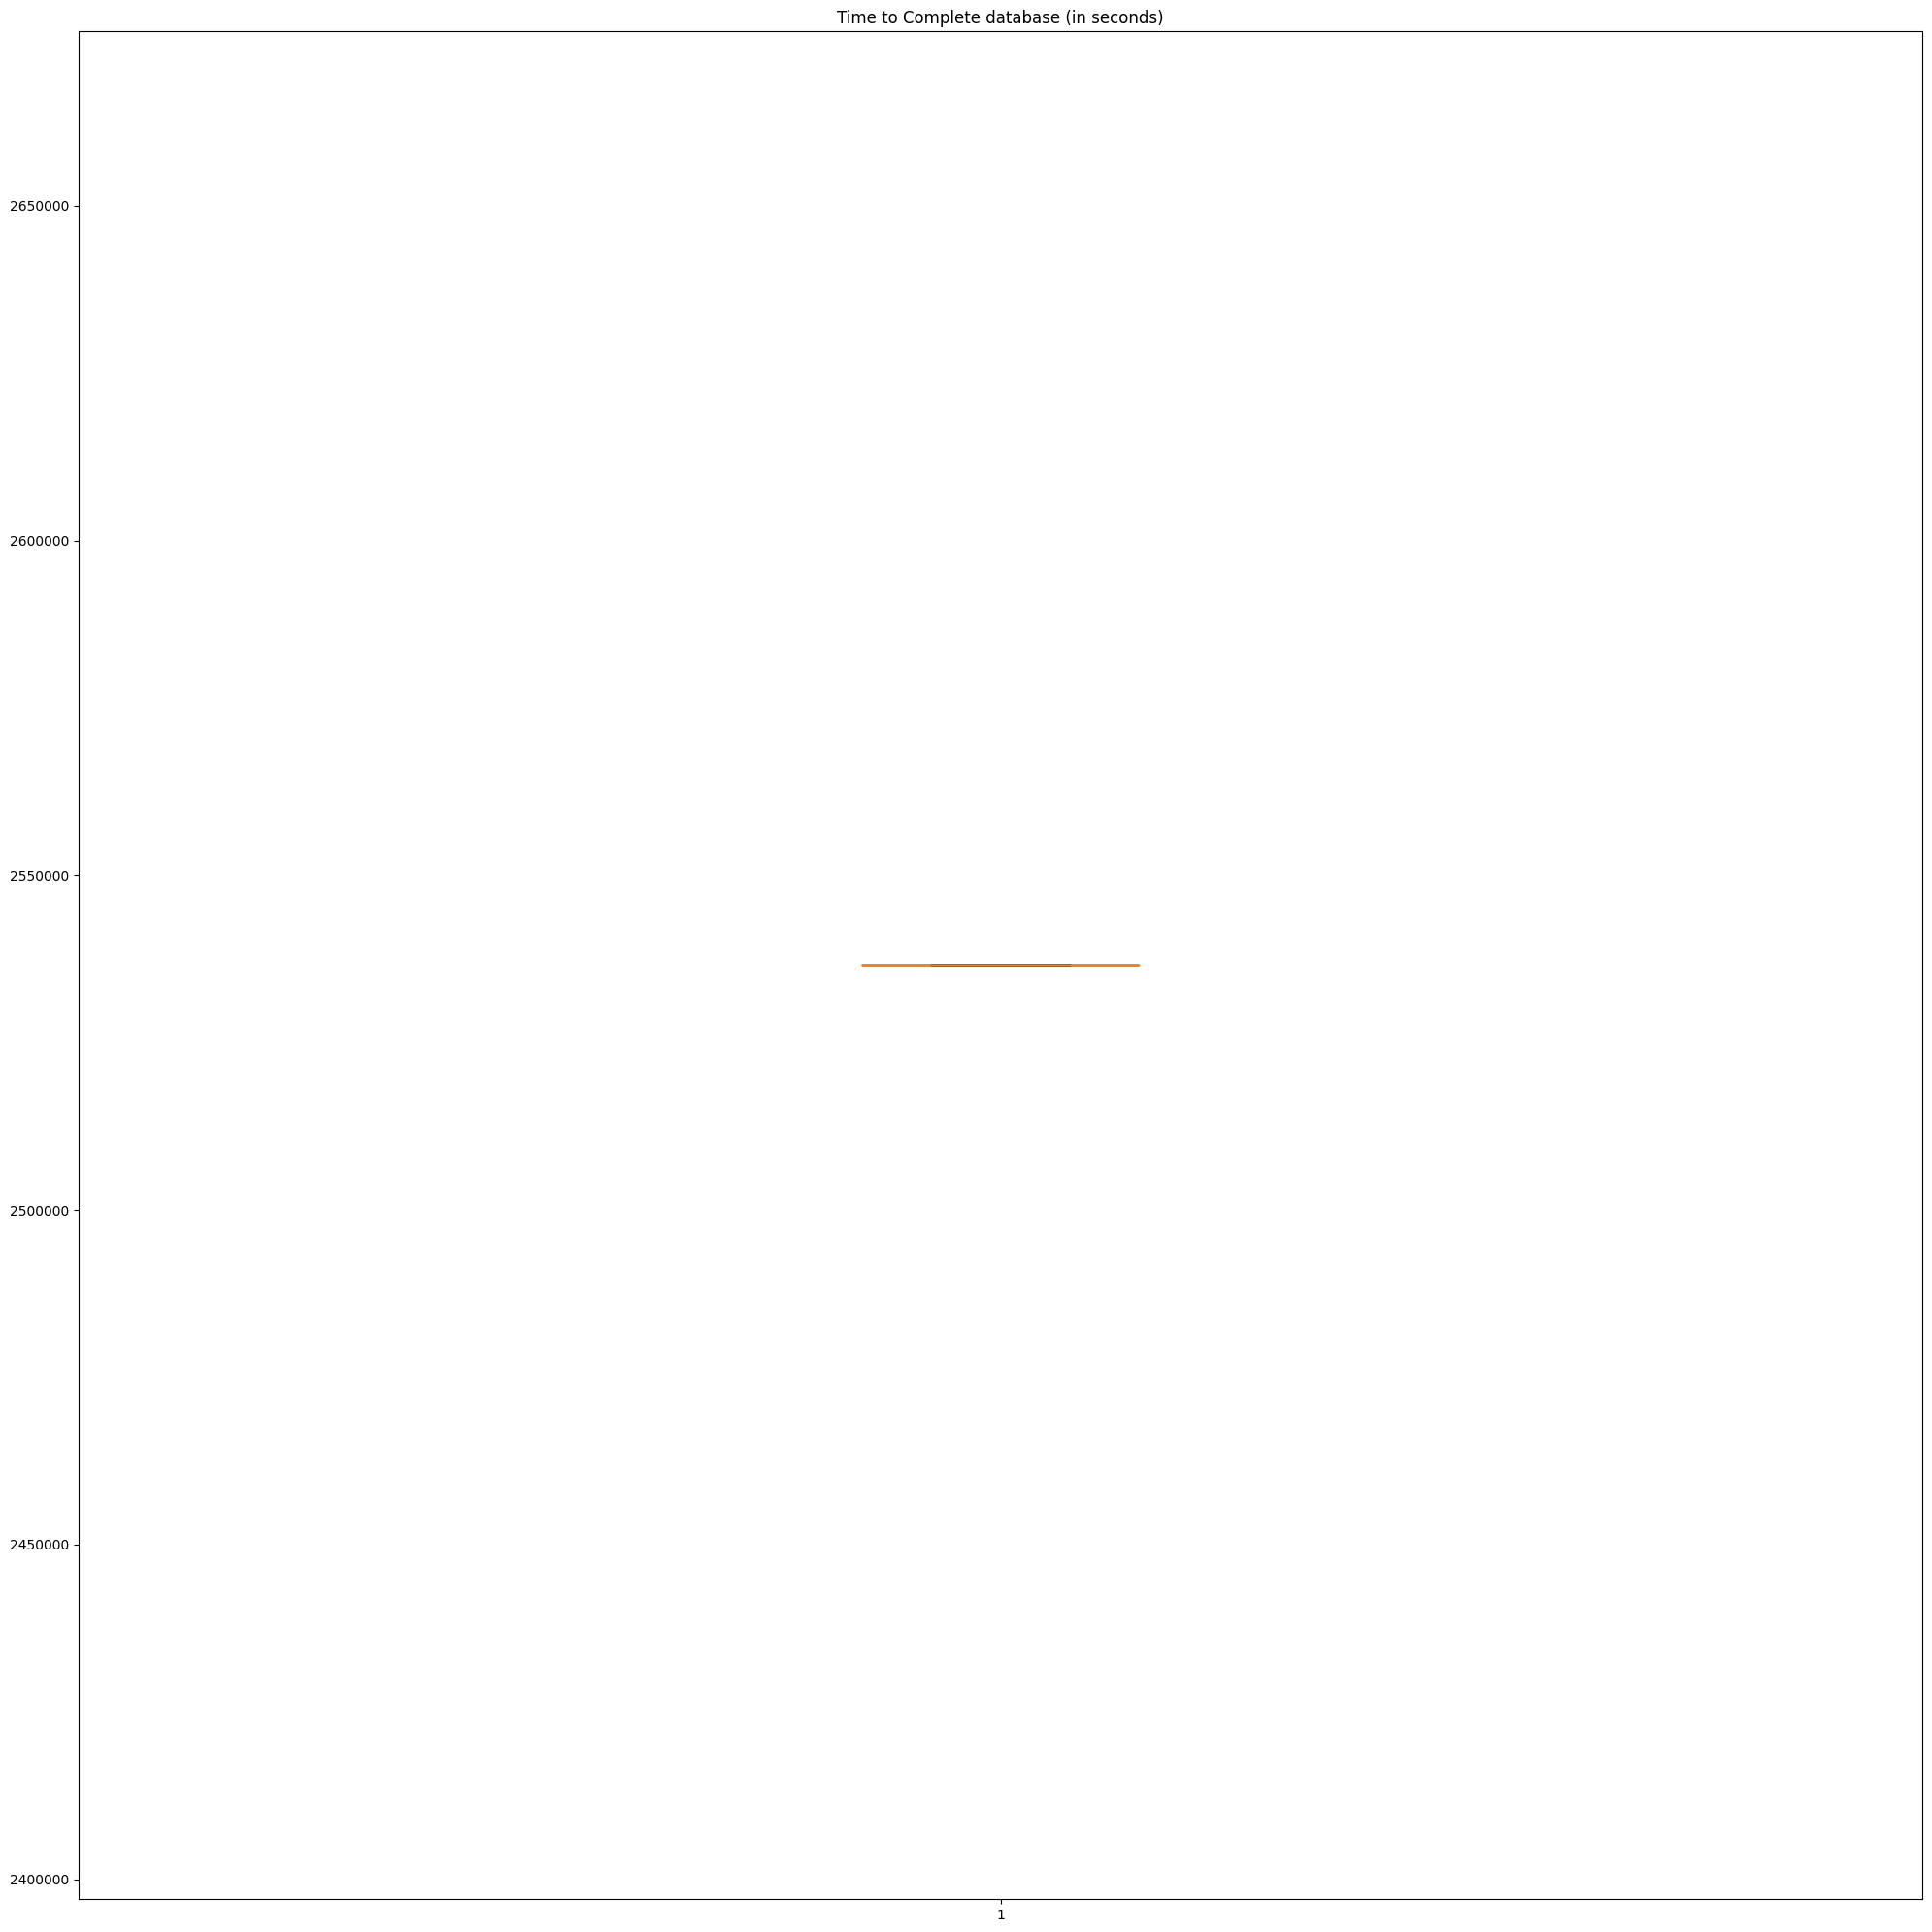

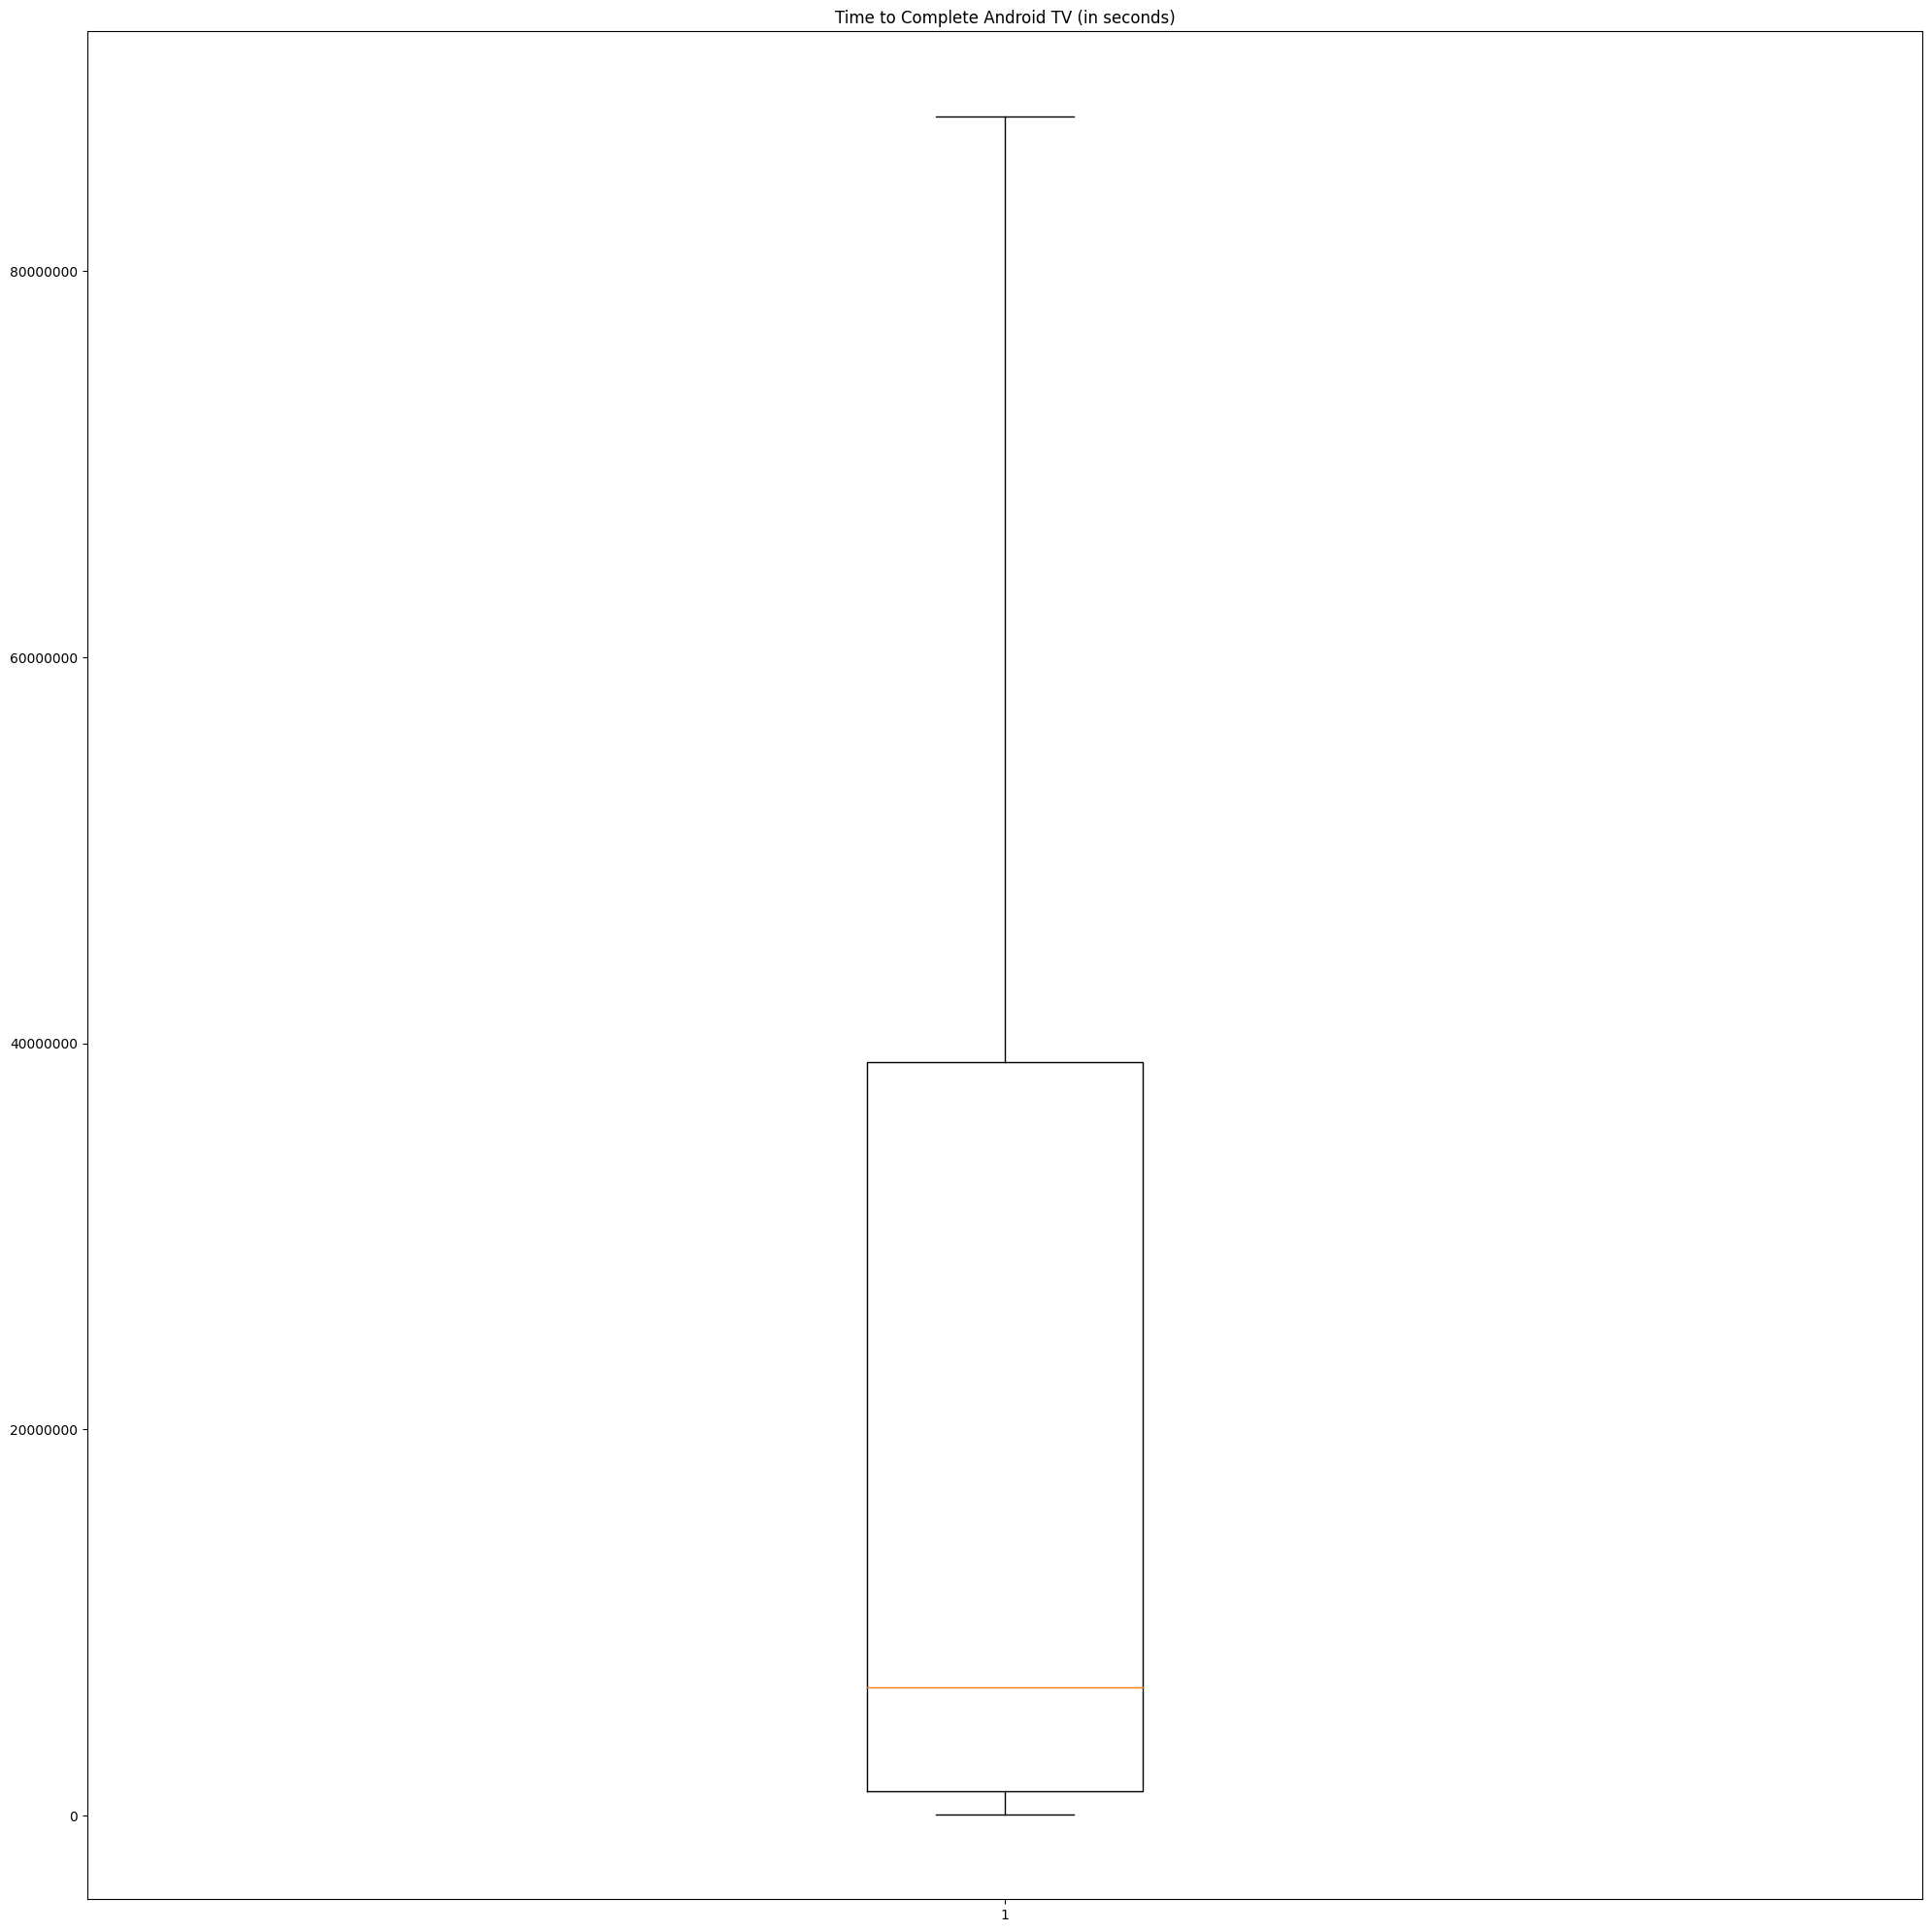

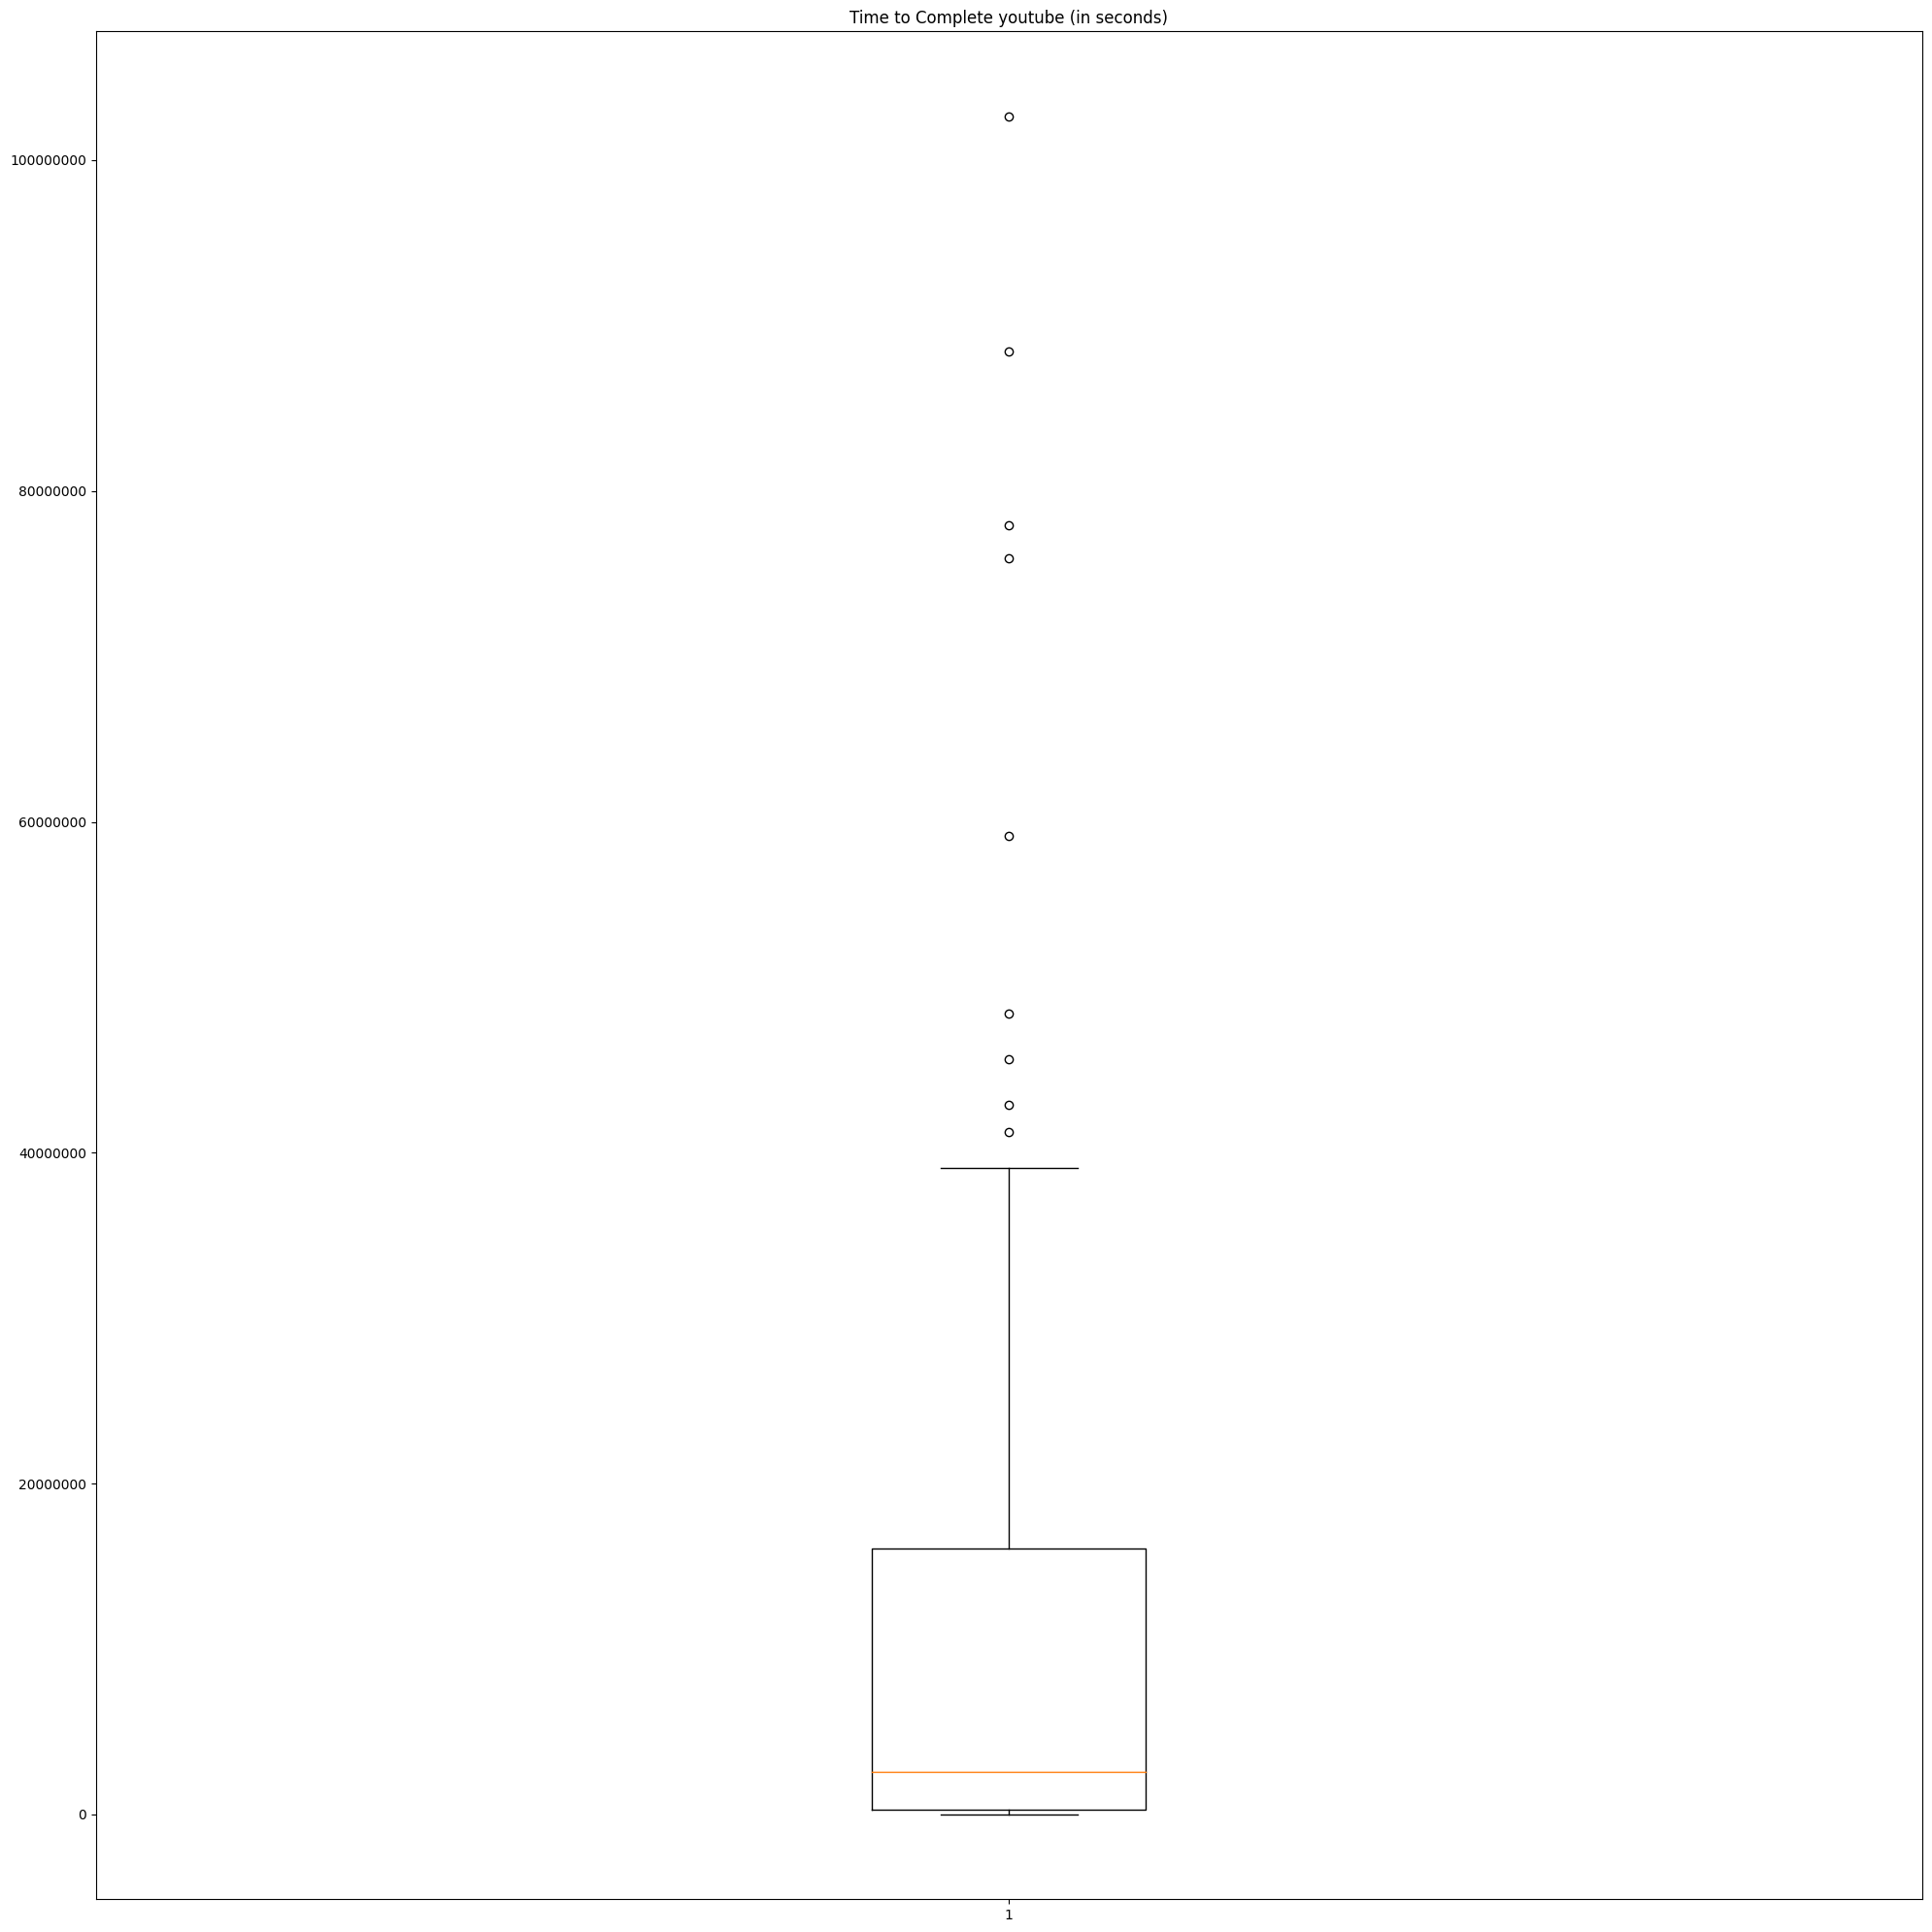

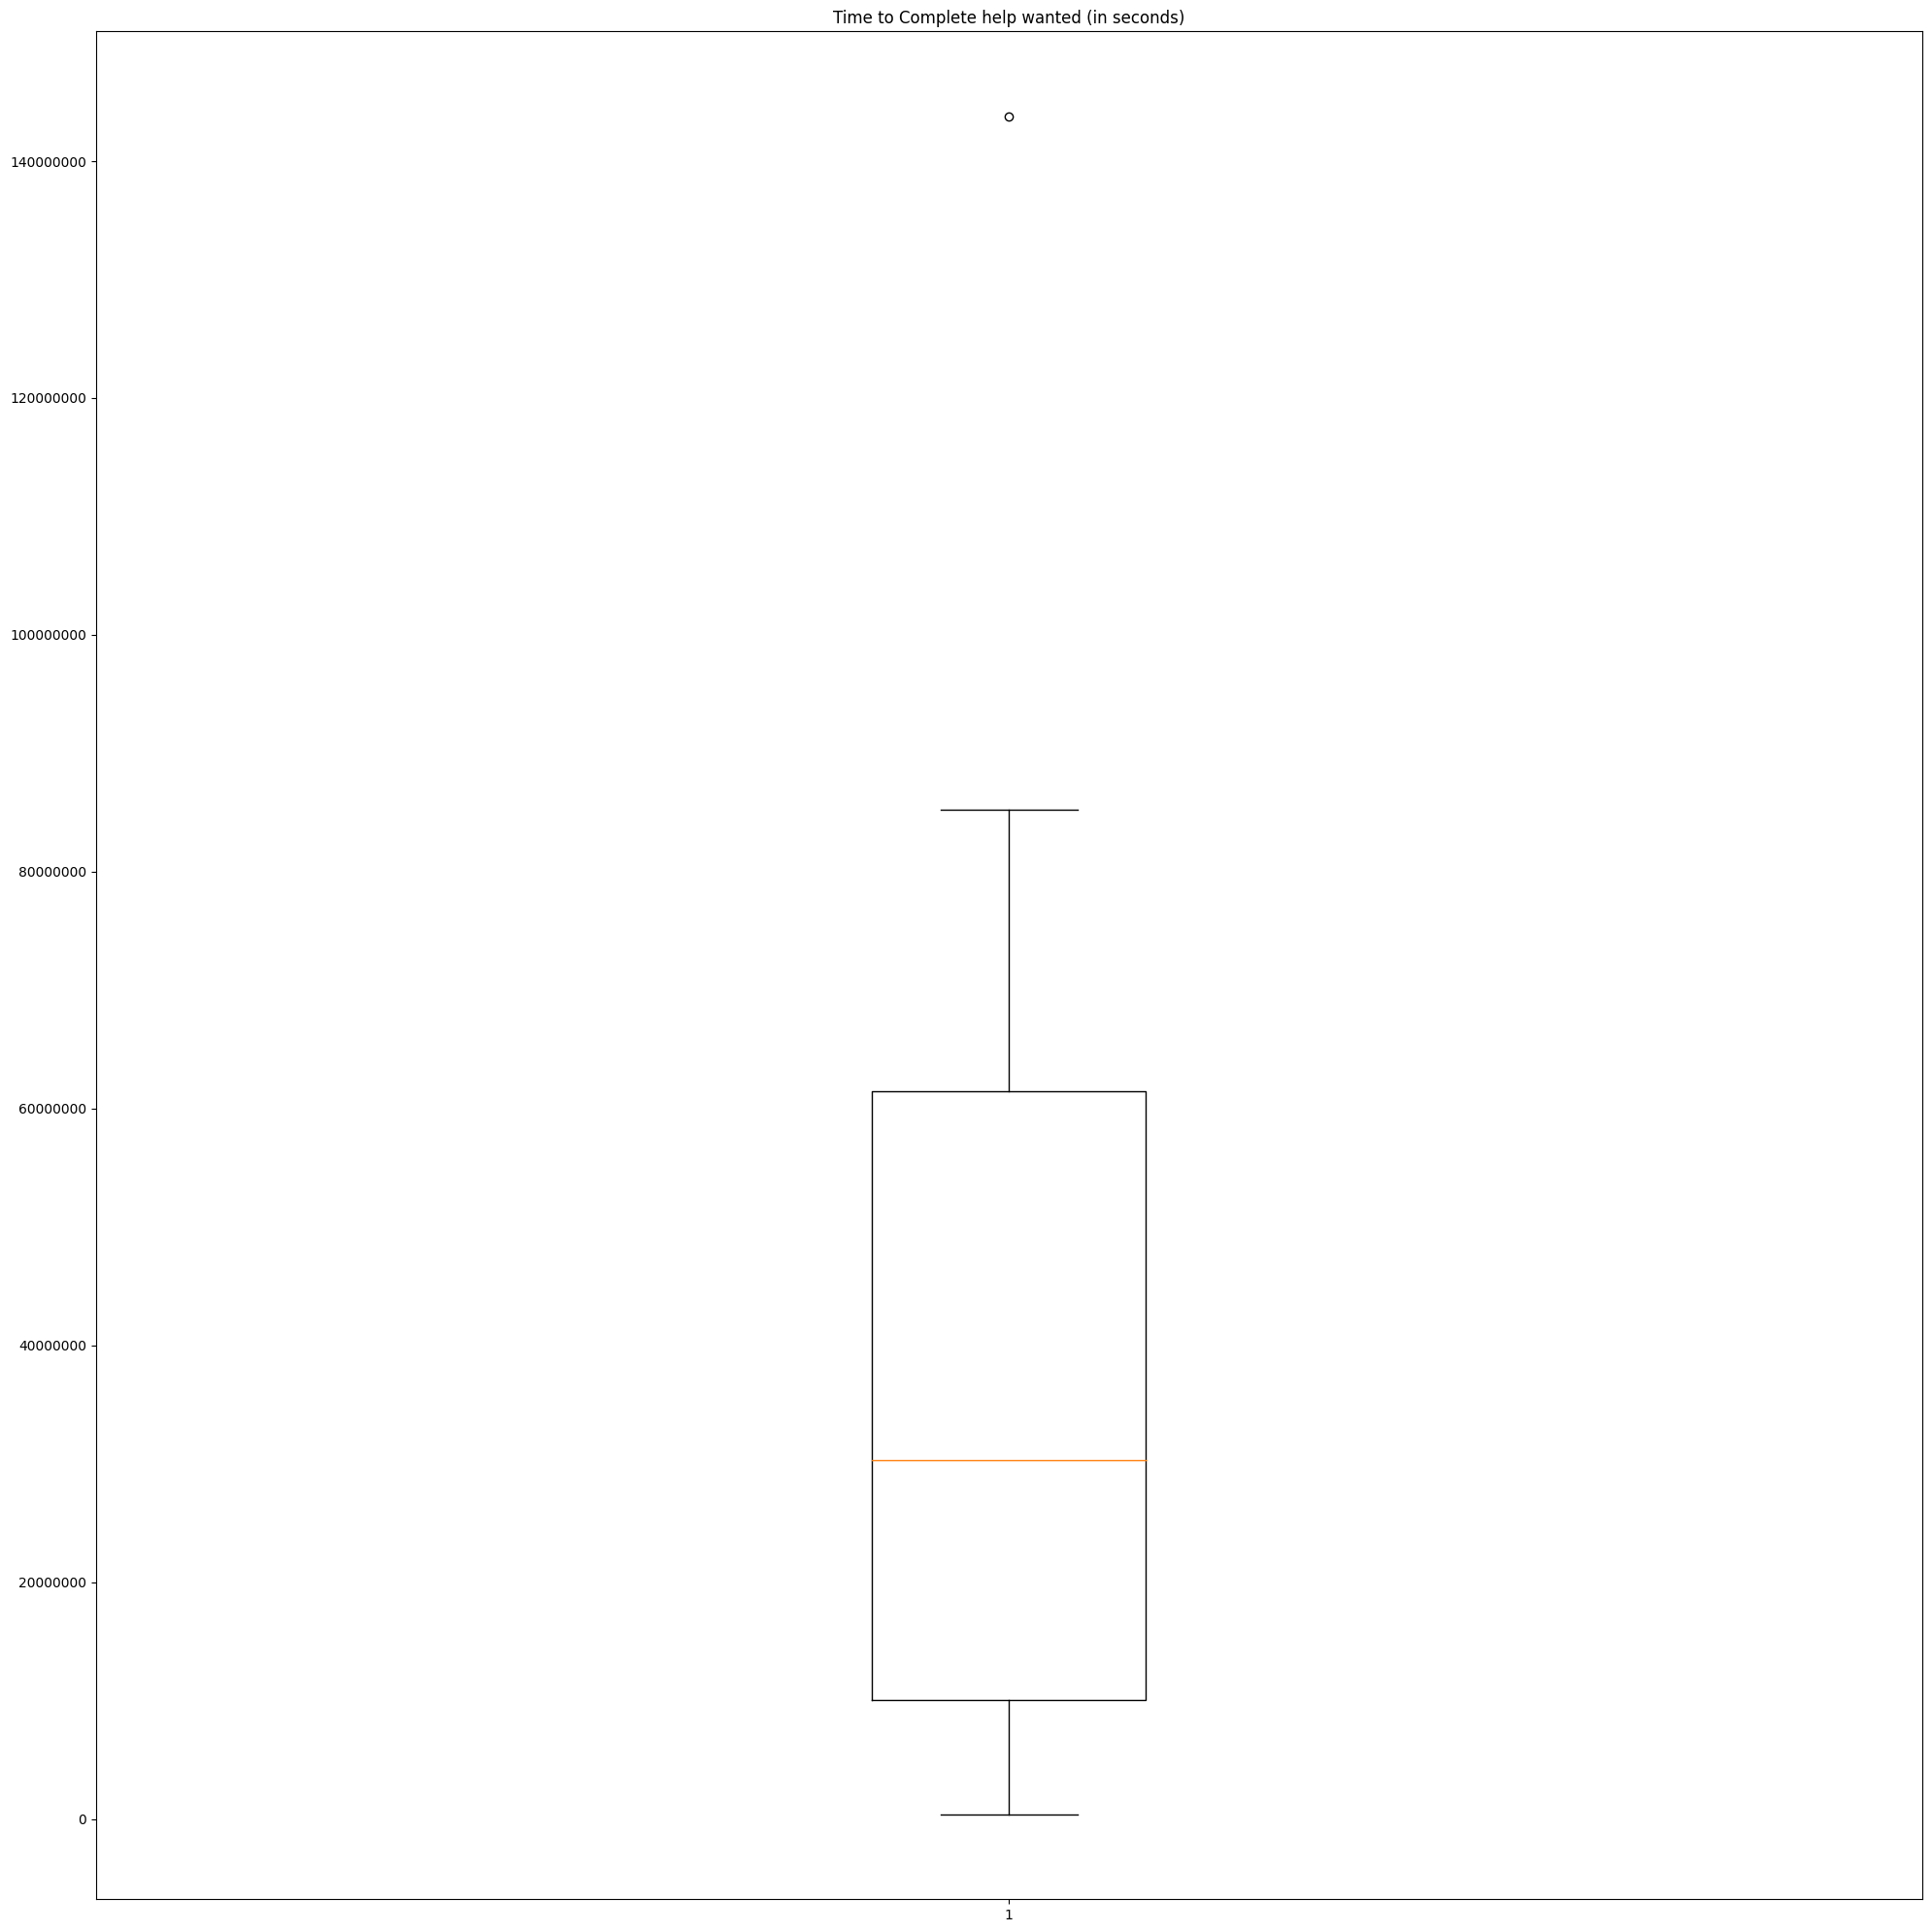

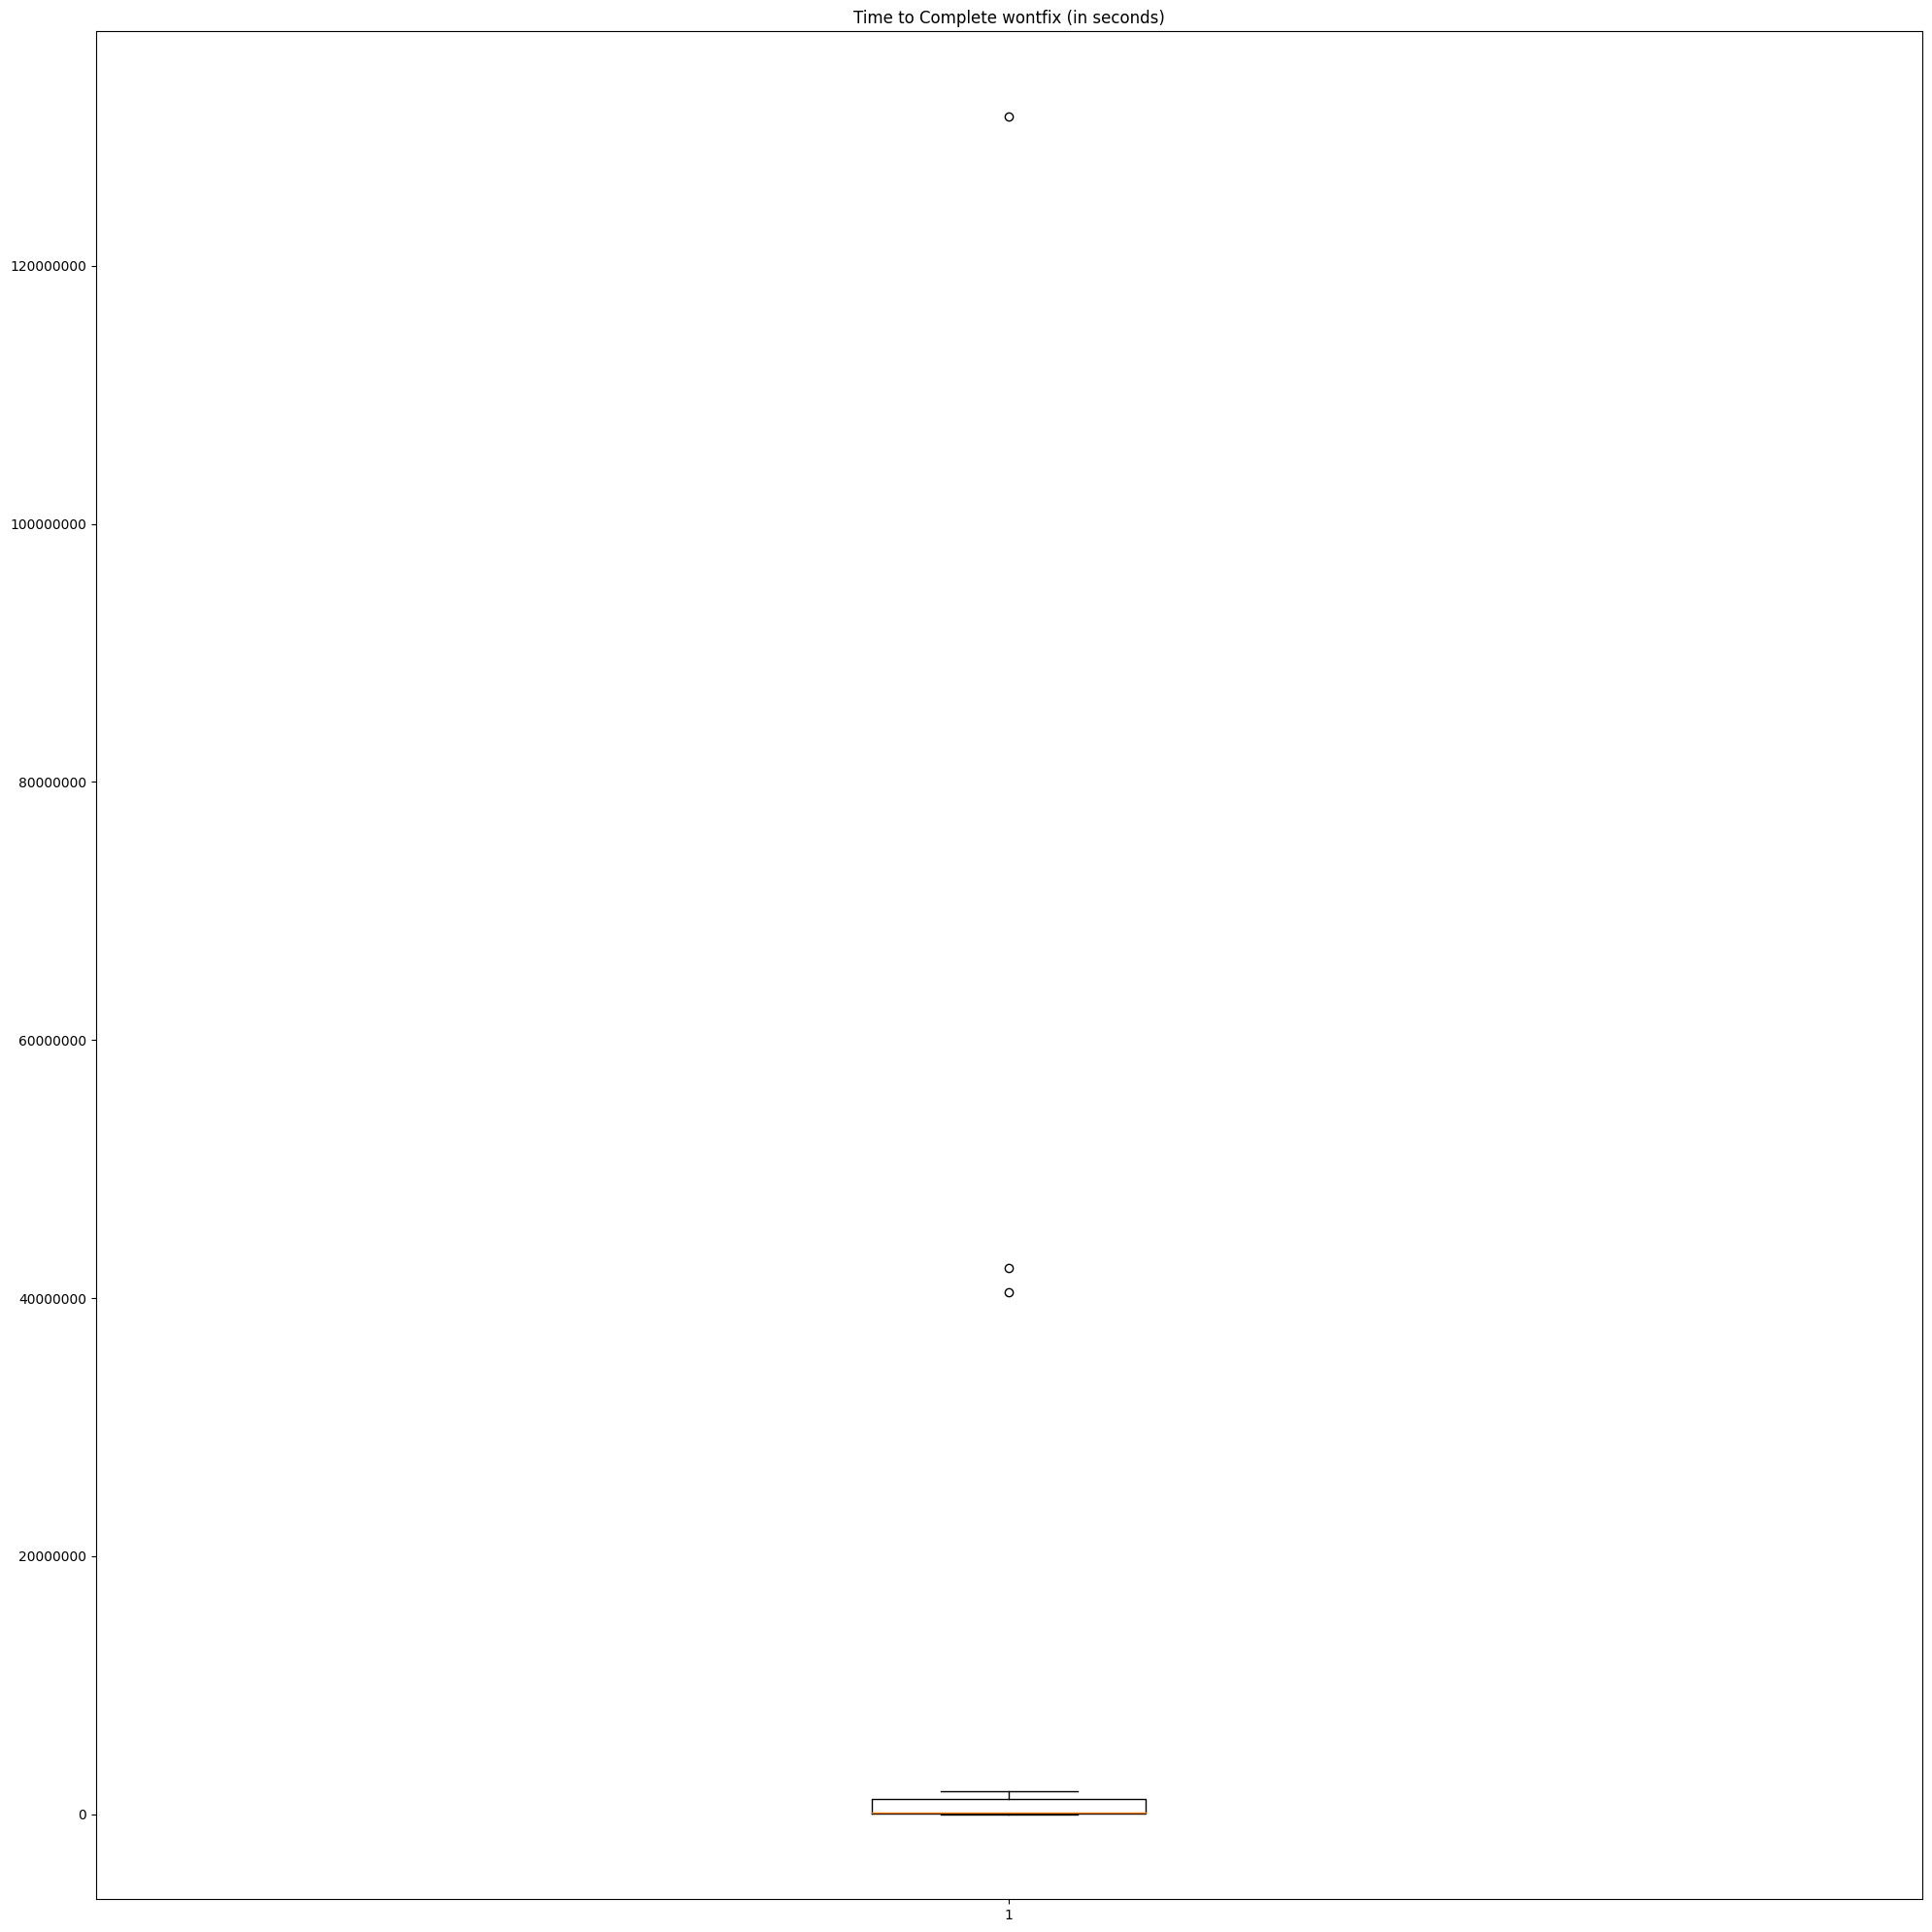

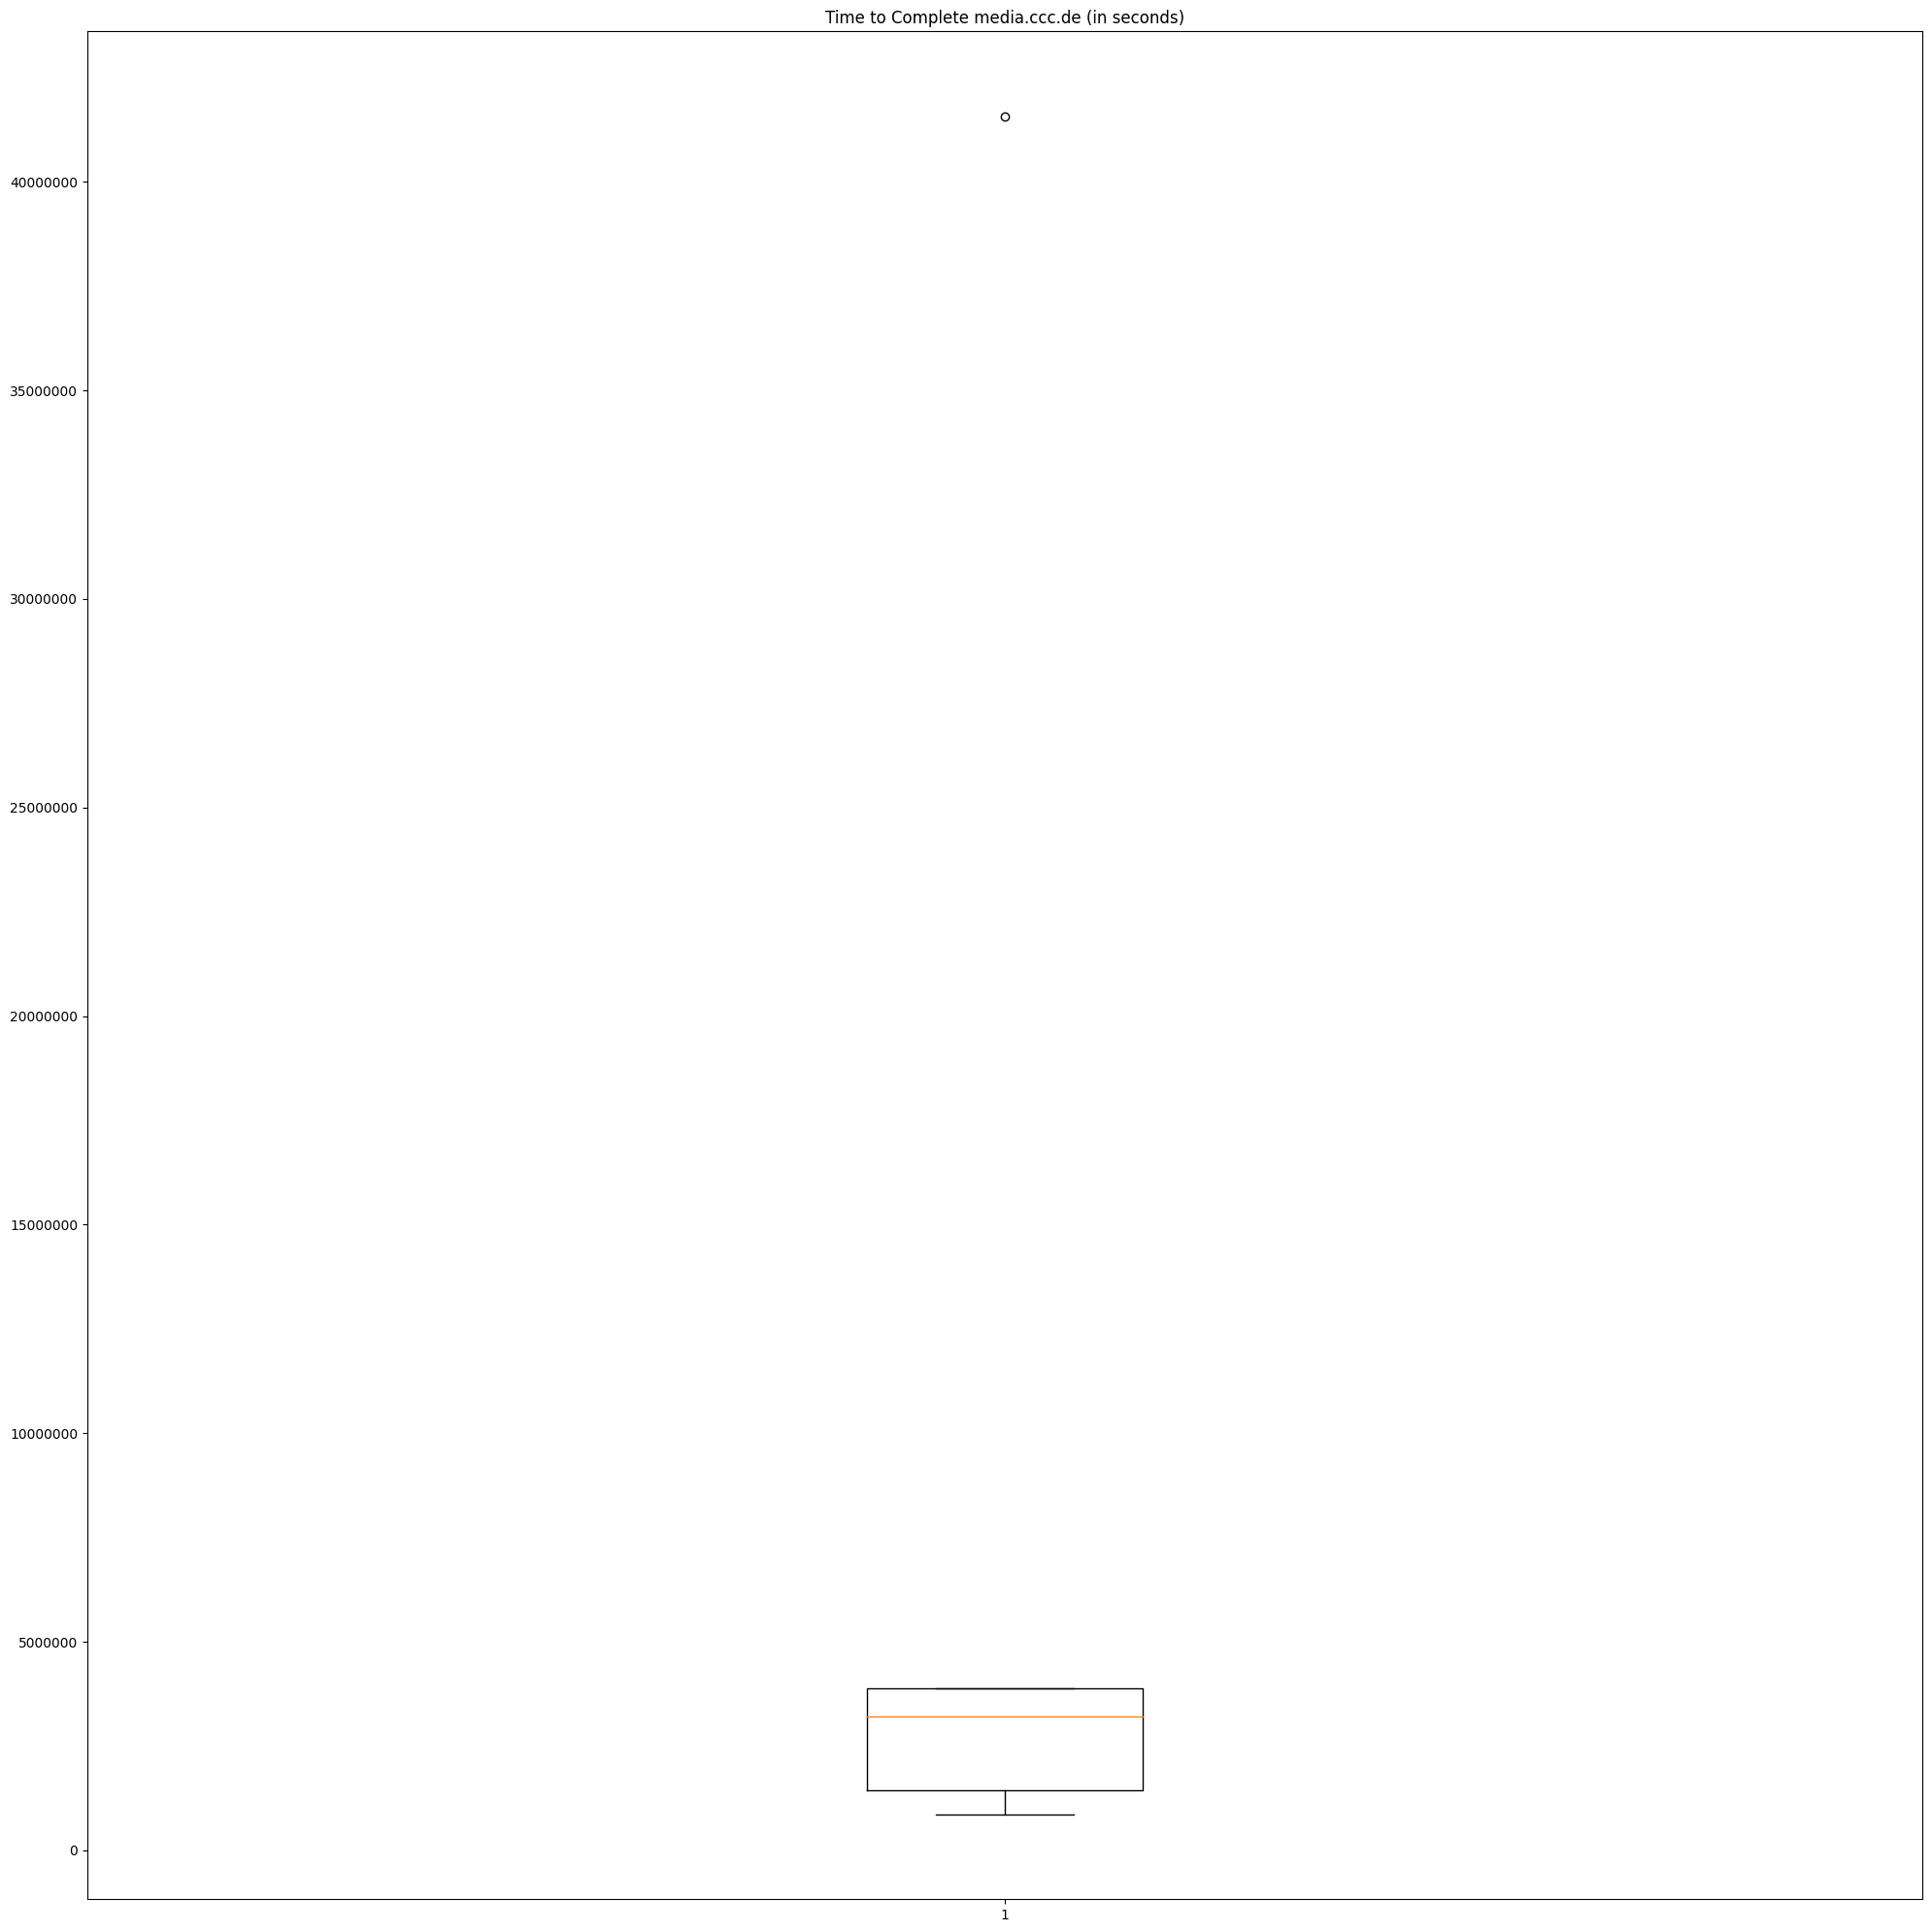

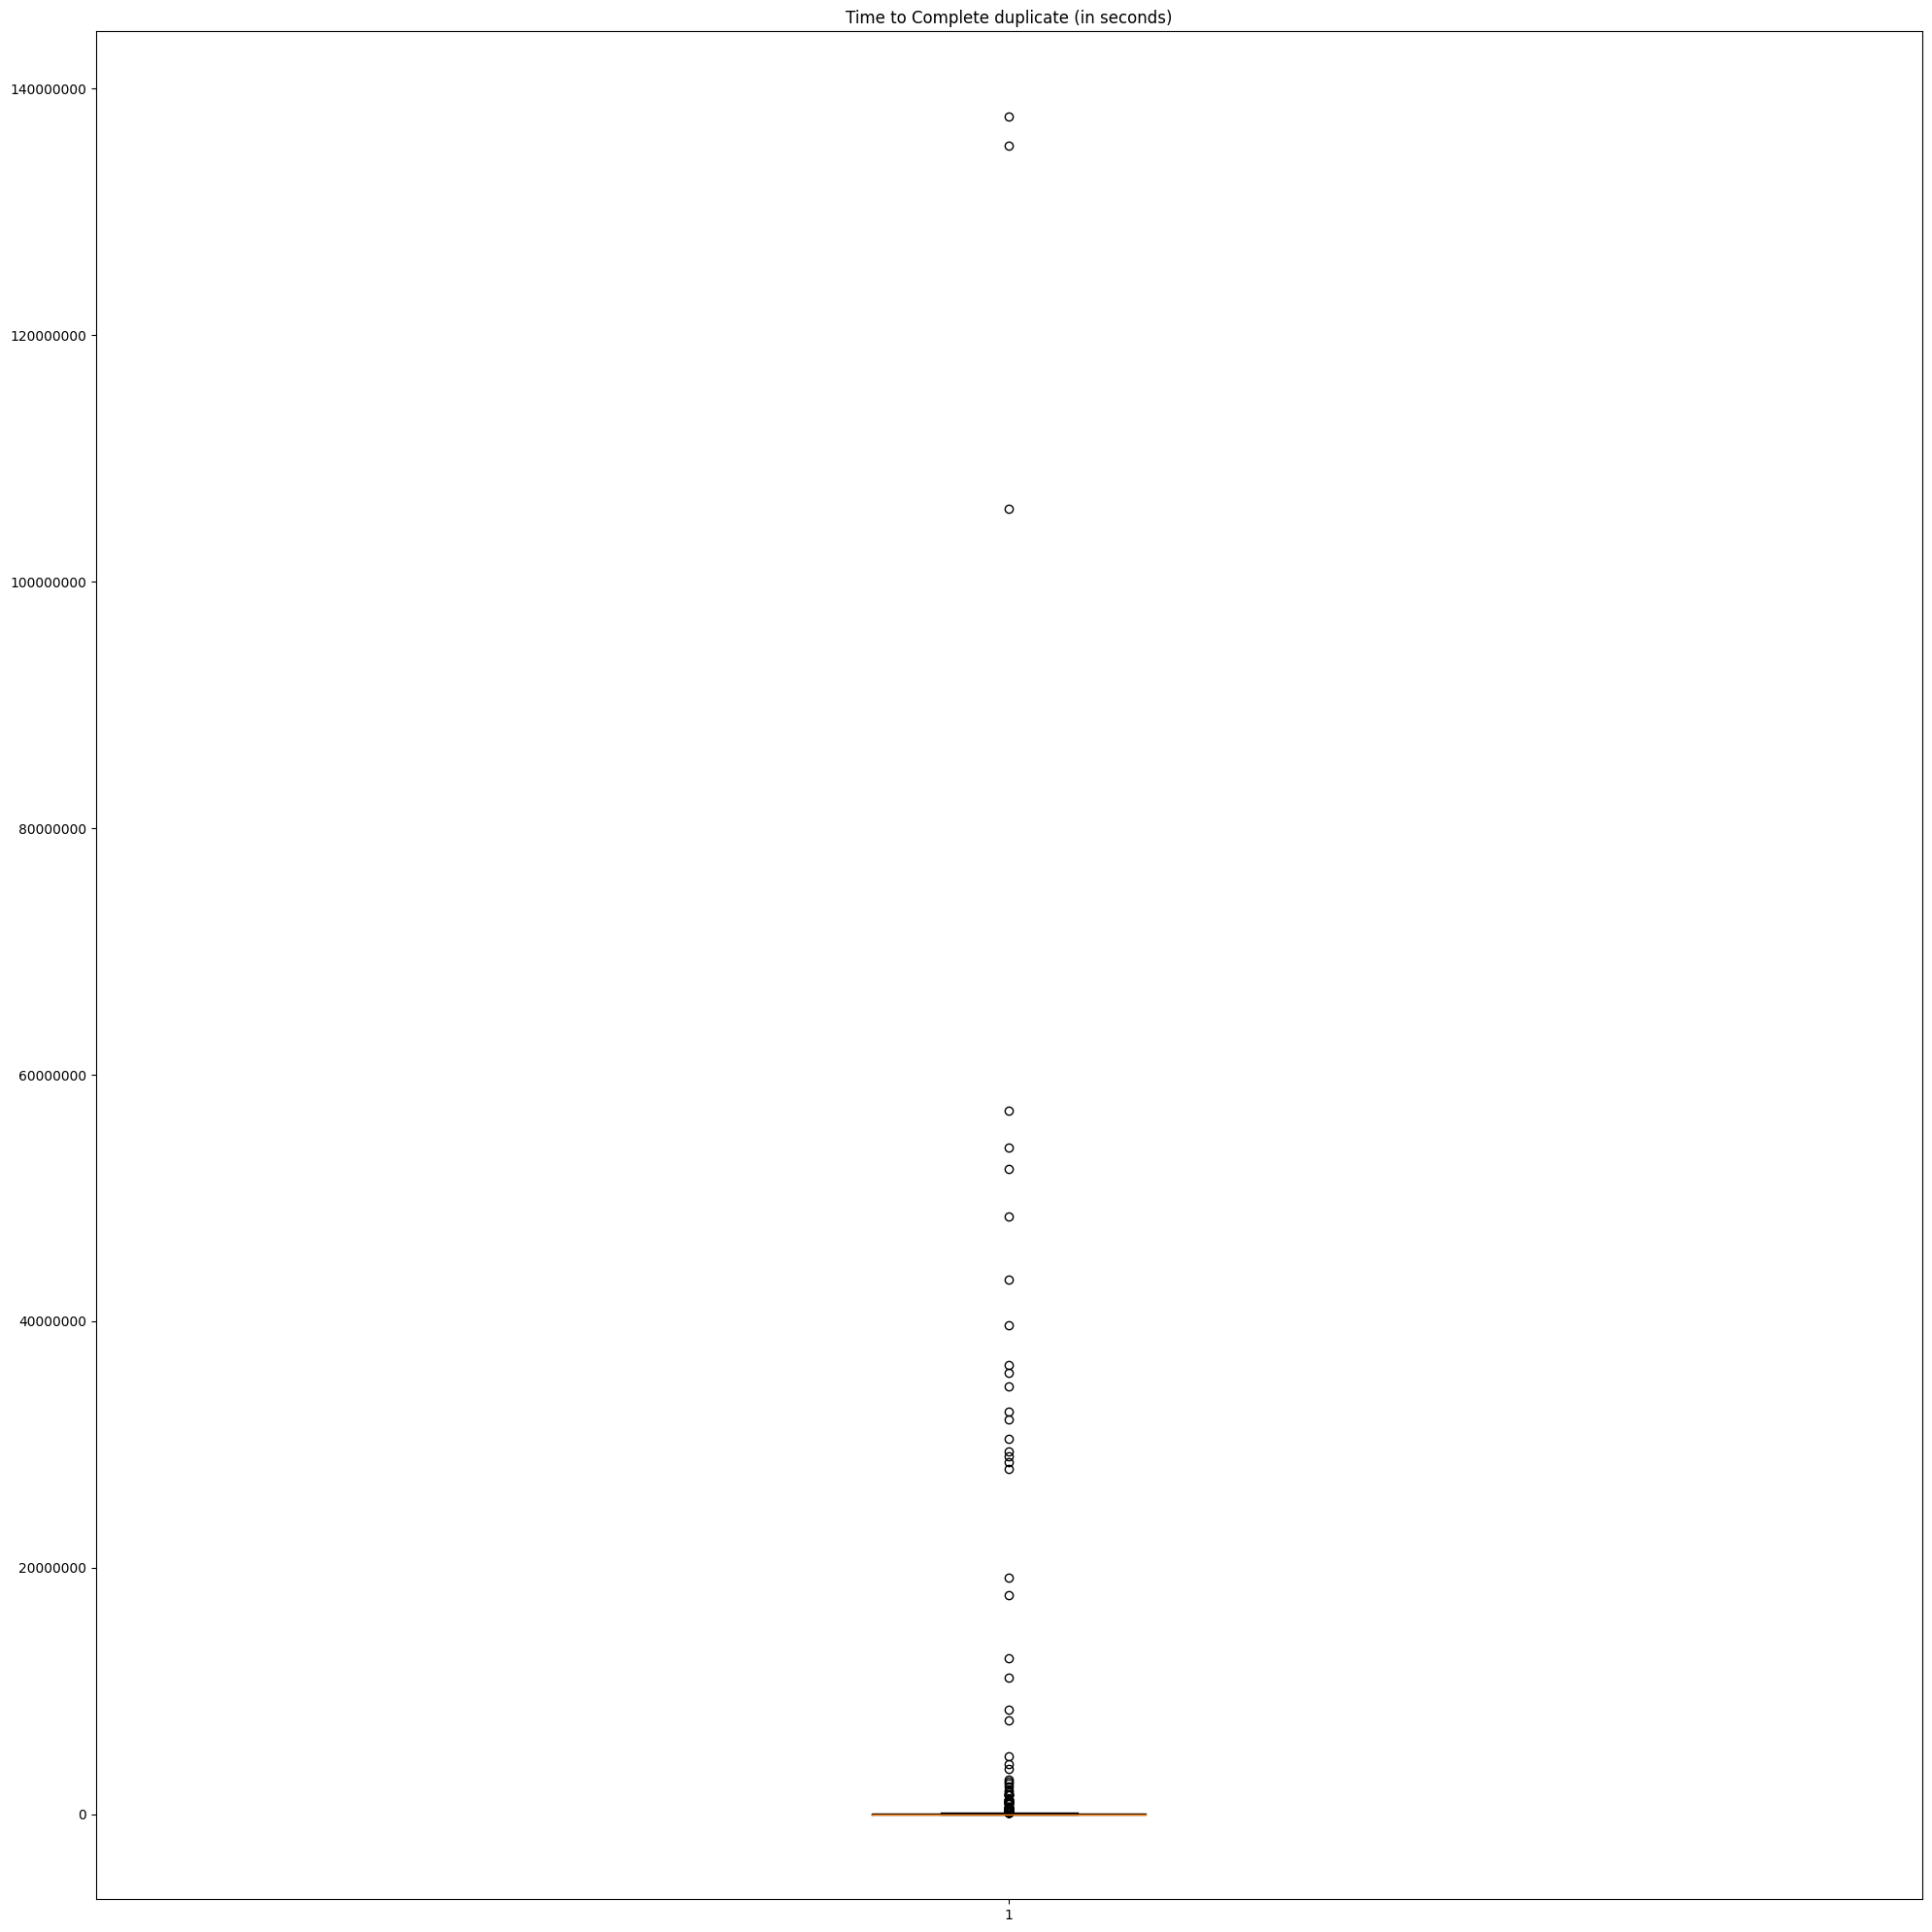

In [400]:
show_completion_time_distribution()